# MCEN 5228 Final Project
## Jamie Voros, Ryan Wells

### Abstract

Avalanche forecasts exist in the United States as tools to inform recreational backcountry users during the winter months (Fredston et al., 1994). An avalanche forecast in Colorado will typically contain a description of the various avalanche problems, and their consequences and likelihood of occurring. In addition, the forecast will also contain an overall safety rating on a 1 to 5 point scale. In the state of Colorado, avalanche forecasting is based on regional input from individual surveyors which is submitted to the Colorado Avalanche Information Center (CAIC) for amalgamation into a statewide forecast. Notably, the CAIC forecast splits Colorado into several geographical zones as well as three elevations. The forecast contains a safety rating per zone in addition to a safety rating per zone per elevation (not all states will give ratings per elevation: Wyoming, for example, will give a single safety rating per region).

Avalanches are becoming more prevalent worldwide as a result of global warming (Ballesteros-Cánovas et al., 2018; Castebrunet et al., 2014; Martin et al., 2001) yet all CAIC avalanche forecasting is still done by hand. There is extensive literature on the algorithmic prediction of avalanche occurrences (Bakkehoi, S., 1987; Choubin et al., 2019; Eglit et al., 2020; McClung, 2000; Naaim et al., 2004; Ramos et al., 2009; Singh et al., 2015; Singh & Ashwagosha, 2008; Viallon-Galinier et al., 2022) but limited literature on algorithmically providing an avalanche forecast (Dekanova et al., 2018). This project aims to use existing weather data in order to algorithmically generate an overall avalanche safety rating on the 1 to 5 point scale per region in Colorado.

We aim to validate the algorithm with past data. We currently anticipate using a simple “if” statement based algorithm to effectively implement the existing logic used by (human) CAIC forecasters. We are not keen on using more complicated machine learning methods (with the exception of linear or logistic regression) because it is not always clear what the causal link between features and prediction is. Based on existing avalanche forecasting methods, we plan to use the following weather station data: time, sky conditions, temperature, relative humidity, storm cycle, and wind. We will also use the following Snotel data: snow density, snowfall amount, snow water equivalent.


## id matching

### Caic Zone ids
Zone ids are used to tie Colorado zones to a number.<br>
0 - Steamboat<br>
1 - Front Range<br>
2 - Vail<br>
3 - Sawatch<br>
4 - Aspen<br>
5 - Gunnison<br>
6 - Grand Mesa<br>
7 - North SJ<br>
8 - South SJ<br>
9 - Sangre

In [1]:
import numpy as np
import pandas as pd
import json

In [5]:
import errno
import os
import signal
import functools

class TimeoutError(Exception):
    pass

def timeout(seconds=10, error_message=os.strerror(errno.ETIME)):
    def decorator(func):
        def _handle_timeout(signum, frame):
            raise TimeoutError(error_message)

        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            signal.signal(signal.SIGALRM, _handle_timeout)
            signal.alarm(seconds)
            try:
                result = func(*args, **kwargs)
            finally:
                signal.alarm(0)
            return result

        return wrapper

    return decorator

In [6]:
import time

@timeout(5)
def getRating(key):
    #takes key, returns danger rating(1-5 scale)
    url = 'https://cloudfront.avalanche.state.co.us/caic/pub_bc_avo.php?bc_avo_fx_id=' + str(key)
    response = pd.read_html(url)
    ratings = []
    for i in range(0,3):
        ratingString = response[0].iloc[:,2][i]
        idx = ratingString.find('(') + 1
        try:
            ratingInt = int(ratingString[idx])
        except:
            ratingInt = 0
        ratings.append(ratingInt)
    return max(ratings) #return max rating that data as single value

In [33]:
@timeout(8)
def getWeatherData(date):
    #date format is yyyy-mm-dd
    url = "https://classic.avalanche.state.co.us/caic/obs_stns/zones.php?date=" + date + "+01&stnlink=daily&unit=e&flag=on&area=caic&span=6&caldate=" + date
    rawData = pd.read_html(url)
    rawData = rawData[1:]
    weatherData = []
    for table in rawData:
        numericData = table.apply(pd.to_numeric, errors='coerce') # cast all items in table as numeric, text goes to NaN
        numericList = list(numericData.mean())
        numericList = numericList[2:-1]
        numericList = [0 if pd.isna(x) else x for x in numericList] # if whole col is nan, set to 0
        weatherData.append(numericList)
    return weatherData


In [26]:
zoneUrls = []
# copy pasted from website
zone_zero ='''[{'2022':{'values':[19000,18987,18970,18963,18942,18938,18925,18911,18896,18883,18877,18864,18857,18844,18833,18820,18808,18797,18787,18779,18759,18744,18733,18719,18712,18700,18693,18683,18666,18652,18645,18637,18619,18609,18595,18586,18579,18570,18558,18545,18538,18517,18506,18489,18474,18471,18452,18445,18434,18425,18410,18400,18384,18372,18368,18355,18344,18327,18319,18305,18292,18287,18276,18259,18256,18244,18222,18211,18200,18189,18175,18165,18156,18146,18133,18126,18114,18106,18088,18081,18070,18065,18052,18041,18028,18017,18004,17987,17976,17971,17962,17945,17934,17930,17916,17912,17902,17888,17872,17862,17848,17835,17827,17816,17807,17796,17779,17770,17762,17749,17742,17728,17723,17705,17697,17689,17670,17665,17653,17636],'texts':['2022/04/30 6:00 AM','2022/04/29 6:32 AM','2022/04/28 6:44 AM','2022/04/27 7:02 AM','2022/04/26 5:56 AM','2022/04/25 7:04 AM','2022/04/24 6:50 AM','2022/04/23 6:47 AM','2022/04/22 6:02 AM','2022/04/21 6:23 AM','2022/04/20 6:19 AM','2022/04/19 6:35 AM','2022/04/18 6:47 AM','2022/04/17 6:55 AM','2022/04/16 7:22 AM','2022/04/15 6:52 AM','2022/04/14 6:27 AM','2022/04/13 6:45 AM','2022/04/12 7:00 AM','2022/04/11 6:26 AM','2022/04/10 6:23 AM','2022/04/09 6:41 AM','2022/04/08 6:59 AM','2022/04/07 6:38 AM','2022/04/06 6:28 AM','2022/04/05 6:30 AM','2022/04/04 6:42 AM','2022/04/03 7:07 AM','2022/04/02 6:36 AM','2022/04/01 7:04 AM','2022/03/31 7:11 AM','2022/03/30 6:56 AM','2022/03/29 6:42 AM','2022/03/28 7:07 AM','2022/03/27 6:43 AM','2022/03/26 6:39 AM','2022/03/25 7:08 AM','2022/03/24 7:00 AM','2022/03/23 6:40 AM','2022/03/22 6:21 AM','2022/03/21 6:52 AM','2022/03/20 6:55 AM','2022/03/19 7:31 AM','2022/03/18 7:04 AM','2022/03/17 6:36 AM','2022/03/16 6:57 AM','2022/03/15 6:19 AM','2022/03/14 7:02 AM','2022/03/13 7:19 AM','2022/03/12 6:57 AM','2022/03/11 7:05 AM','2022/03/10 7:11 AM','2022/03/09 6:52 AM','2022/03/08 6:56 AM','2022/03/07 7:09 AM','2022/03/06 7:05 AM','2022/03/05 6:58 AM','2022/03/04 6:40 AM','2022/03/03 6:49 AM','2022/03/02 6:34 AM','2022/03/01 6:26 AM','2022/02/28 6:54 AM','2022/02/27 6:54 AM','2022/02/26 6:42 AM','2022/02/25 7:27 AM','2022/02/24 7:05 AM','2022/02/23 6:51 AM','2022/02/22 7:03 AM','2022/02/21 6:50 AM','2022/02/20 6:26 AM','2022/02/19 6:34 AM','2022/02/18 6:14 AM','2022/02/17 7:08 AM','2022/02/16 6:29 AM','2022/02/15 6:21 AM','2022/02/14 6:58 AM','2022/02/13 6:45 AM','2022/02/12 7:14 AM','2022/02/11 7:53 AM','2022/02/10 6:44 AM','2022/02/09 6:45 AM','2022/02/08 6:47 AM','2022/02/07 6:36 AM','2022/02/06 6:48 AM','2022/02/05 6:57 AM','2022/02/04 7:03 AM','2022/02/03 6:48 AM','2022/02/02 6:29 AM','2022/02/01 5:55 AM','2022/01/31 7:08 AM','2022/01/30 6:48 AM','2022/01/29 6:36 AM','2022/01/28 6:28 AM','2022/01/27 7:13 AM','2022/01/26 6:28 AM','2022/01/25 6:54 AM','2022/01/24 6:31 AM','2022/01/23 6:42 AM','2022/01/22 6:28 AM','2022/01/21 6:35 AM','2022/01/20 6:28 AM','2022/01/19 6:33 AM','2022/01/18 6:46 AM','2022/01/17 6:33 AM','2022/01/16 6:23 AM','2022/01/15 7:24 AM','2022/01/14 6:11 AM','2022/01/13 6:30 AM','2022/01/12 6:35 AM','2022/01/11 6:31 AM','2022/01/10 6:58 AM','2022/01/09 6:43 AM','2022/01/08 7:38 AM','2022/01/07 6:41 AM','2022/01/06 7:09 AM','2022/01/05 7:20 AM','2022/01/04 6:57 AM','2022/01/03 7:19 AM','2022/01/02 6:38 AM','2022/01/01 6:28 AM']},'2021':{'values':[17627,17604,17592,17577,17556,17549,17538,17525,17509,17504,17487,17479,17462,17450,17439,17428,17414,17400,17391,17382,17373,17360,17341,17332,17322,17304,17298,17284,17269,17257,17247,17237,17224,17218,17204,17194,17184,17172,17161,17148,17136,17123,17113,17107,17095,17082,17079,17059,17050,17036,16573,16529,16505,16481,16462,16440,16408,16395,16387,16380,16365,16355,16338,16330,16321,16306,16298,16288,16275,16265,16252,16242,16228,16226,16211,16197,16187,16169,16157,16145,16132,16110,16099,16086,16068,16055,16043,16034,16023,16012,15997,15985,15971,15954,15944,15930,15922,15906,15898,15887,15876,15870,15850,15842,15831,15820,15803,15790,15782,15771,15758,15753,15738,15727,15717,15708,15697,15685,15672,15662,15646,15634,15625,15613,15604,15585,15568,15559,15547,15534,15522,15502,15492,15480,15469,15466,15445,15430,15420,15410,15400,15391,15381,15366,15353,15338,15330,15315,15304,15292,15291,15270,15267,15251,15241,15227,15213,15200,15195,15178,15167,15160,15146,15133,15118,15106,15096,15083,15072,15058],'texts':['2021/12/31 7:01 AM','2021/12/30 6:40 AM','2021/12/29 6:59 AM','2021/12/28 7:00 AM','2021/12/27 7:02 AM','2021/12/26 7:05 AM','2021/12/25 7:17 AM','2021/12/24 7:15 AM','2021/12/23 6:34 AM','2021/12/22 6:58 AM','2021/12/21 6:30 AM','2021/12/20 6:19 AM','2021/12/19 5:58 AM','2021/12/18 6:35 AM','2021/12/17 6:30 AM','2021/12/16 6:24 AM','2021/12/15 7:26 AM','2021/12/14 6:59 AM','2021/12/13 7:34 AM','2021/12/12 6:36 AM','2021/12/11 7:17 AM','2021/12/10 7:07 AM','2021/12/09 6:55 AM','2021/12/08 7:13 AM','2021/12/07 7:12 AM','2021/12/06 7:01 AM','2021/12/05 6:28 AM','2021/12/04 5:57 AM','2021/12/03 6:06 AM','2021/12/02 6:08 AM','2021/12/01 6:38 AM','2021/11/30 6:36 AM','2021/11/29 6:36 AM','2021/11/28 6:14 AM','2021/11/27 5:40 AM','2021/11/26 6:42 AM','2021/11/25 6:51 AM','2021/11/24 7:01 AM','2021/11/23 6:26 AM','2021/11/22 6:36 AM','2021/11/21 6:32 AM','2021/11/20 6:16 AM','2021/11/19 6:08 AM','2021/11/18 6:53 AM','2021/11/17 6:10 AM','2021/11/16 6:18 AM','2021/11/15 6:48 AM','2021/11/14 6:05 AM','2021/11/13 6:38 AM','2021/11/12 7:15 AM','2021/04/30 6:48 AM','2021/04/29 6:34 AM','2021/04/28 7:25 AM','2021/04/27 7:01 AM','2021/04/26 6:32 AM','2021/04/25 6:33 AM','2021/04/24 6:51 AM','2021/04/23 6:40 AM','2021/04/22 6:00 AM','2021/04/21 6:32 AM','2021/04/20 6:47 AM','2021/04/19 7:15 AM','2021/04/18 6:46 AM','2021/04/17 6:47 AM','2021/04/16 7:06 AM','2021/04/15 6:37 AM','2021/04/14 6:53 AM','2021/04/13 5:34 AM','2021/04/12 6:32 AM','2021/04/11 6:30 AM','2021/04/10 6:00 AM','2021/04/09 6:10 AM','2021/04/08 6:31 AM','2021/04/07 7:05 AM','2021/04/06 7:11 AM','2021/04/05 6:23 AM','2021/04/04 6:43 AM','2021/04/03 6:46 AM','2021/04/02 6:44 AM','2021/04/01 6:26 AM','2021/03/31 6:45 AM','2021/03/30 6:32 AM','2021/03/29 6:42 AM','2021/03/28 6:24 AM','2021/03/27 6:38 AM','2021/03/26 6:56 AM','2021/03/25 7:11 AM','2021/03/24 7:25 AM','2021/03/23 7:06 AM','2021/03/22 7:20 AM','2021/03/21 7:15 AM','2021/03/20 6:50 AM','2021/03/19 6:28 AM','2021/03/18 6:58 AM','2021/03/17 6:36 AM','2021/03/16 7:07 AM','2021/03/15 7:13 AM','2021/03/14 7:01 AM','2021/03/13 7:35 AM','2021/03/12 7:07 AM','2021/03/11 6:48 AM','2021/03/10 7:44 AM','2021/03/09 6:55 AM','2021/03/08 7:05 AM','2021/03/07 6:52 AM','2021/03/06 6:40 AM','2021/03/05 6:37 AM','2021/03/04 6:52 AM','2021/03/03 6:20 AM','2021/03/02 6:49 AM','2021/03/01 7:02 AM','2021/02/28 7:03 AM','2021/02/27 6:32 AM','2021/02/26 6:36 AM','2021/02/25 6:47 AM','2021/02/24 7:02 AM','2021/02/23 7:13 AM','2021/02/22 7:14 AM','2021/02/21 7:07 AM','2021/02/20 7:17 AM','2021/02/19 6:52 AM','2021/02/18 6:41 AM','2021/02/17 6:15 AM','2021/02/16 6:50 AM','2021/02/15 7:08 AM','2021/02/14 6:45 AM','2021/02/13 7:00 AM','2021/02/12 7:25 AM','2021/02/11 7:00 AM','2021/02/10 7:06 AM','2021/02/09 7:02 AM','2021/02/08 6:55 AM','2021/02/07 6:40 AM','2021/02/06 6:42 AM','2021/02/05 7:04 AM','2021/02/04 7:02 AM','2021/02/03 7:23 AM','2021/02/02 7:26 AM','2021/02/01 7:20 AM','2021/01/31 6:58 AM','2021/01/30 7:09 AM','2021/01/29 6:38 AM','2021/01/28 6:47 AM','2021/01/27 7:29 AM','2021/01/26 6:58 AM','2021/01/25 6:37 AM','2021/01/24 7:03 AM','2021/01/23 7:17 AM','2021/01/22 7:09 AM','2021/01/21 6:26 AM','2021/01/20 7:16 AM','2021/01/19 7:48 AM','2021/01/18 7:28 AM','2021/01/17 6:48 AM','2021/01/16 6:43 AM','2021/01/15 6:46 AM','2021/01/14 6:25 AM','2021/01/13 6:13 AM','2021/01/12 6:58 AM','2021/01/11 6:34 AM','2021/01/10 6:18 AM','2021/01/09 7:04 AM','2021/01/08 6:49 AM','2021/01/07 7:14 AM','2021/01/06 7:10 AM','2021/01/05 6:17 AM','2021/01/04 6:40 AM','2021/01/03 7:10 AM','2021/01/02 6:39 AM','2021/01/01 6:45 AM']},'2020':{'values':[15047,15037,15025,15012,15006,14991,14977,14966,14952,14943,14925,14913,14901,14890,14879,14866,14860,14846,14831,14818,14801,14783,14777,14764,14753,14740,14728,14721,14713,14706,14686,14681,14664,14652,14637,14629,14620,14604,14591,14585,14569,14558,14552,14535,14524,14502,14487,14480,14458,14360,14334,14330,14321,14306,14301,14280,14261,13996,13947,13936,13922,13901,13895,13882,13870,13854,13845,13833,13819,13807,13798,13782,13772,13756,13726,13712,13703,13690,13672,13657,13648,13634,13621,13617,13605,13588,13580,13567,13557,13532,13519,13509,13497,13486,13475,13464,13459,13446,13439,13421,13411,13400,13386,13374,13364,13361,13339,13325,13317,13306,13302,13283,13278,13261,13252,13238,13230,13211,13207,13193,13176,13153,13136,13125,13113,13104,13088,13074,13063,13057,13045,13035,13022,13009,13000,12990,12978,12966,12953,12943,12937,12921,12908,12897,12884,12878,12867,12858,12844,12829,12821,12808,12802,12785,12772,12758,12743,12732,12721,12715],'texts':['2020/12/31 6:18 AM','2020/12/30 6:47 AM','2020/12/29 6:57 AM','2020/12/28 7:41 AM','2020/12/27 7:20 AM','2020/12/26 7:04 AM','2020/12/25 7:00 AM','2020/12/24 6:53 AM','2020/12/23 7:31 AM','2020/12/22 6:57 AM','2020/12/21 7:29 AM','2020/12/20 6:51 AM','2020/12/19 7:01 AM','2020/12/18 6:34 AM','2020/12/17 7:05 AM','2020/12/16 7:04 AM','2020/12/15 7:14 AM','2020/12/14 6:54 AM','2020/12/13 6:41 AM','2020/12/12 7:00 AM','2020/12/11 7:22 AM','2020/12/10 6:33 AM','2020/12/09 6:15 AM','2020/12/08 6:11 AM','2020/12/07 5:33 AM','2020/12/06 6:08 AM','2020/12/05 6:38 AM','2020/12/04 6:02 AM','2020/12/03 6:47 AM','2020/12/02 7:02 AM','2020/12/01 6:49 AM','2020/11/30 6:58 AM','2020/11/29 6:28 AM','2020/11/28 6:35 AM','2020/11/27 6:13 AM','2020/11/26 6:45 AM','2020/11/25 6:51 AM','2020/11/24 6:59 AM','2020/11/23 6:35 AM','2020/11/22 6:43 AM','2020/11/21 6:47 AM','2020/11/20 6:46 AM','2020/11/19 6:55 AM','2020/11/18 7:07 AM','2020/11/17 7:08 AM','2020/11/16 6:51 AM','2020/11/15 6:51 AM','2020/11/14 6:34 AM','2020/11/13 6:38 AM','2020/10/30 7:59 AM','2020/10/24 4:39 PM','2020/10/23 10:54 AM','2020/10/11 4:36 PM','2020/09/11 2:14 PM','2020/08/14 4:28 PM','2020/06/03 12:49 PM','2020/05/30 3:08 PM','2020/04/12 6:55 AM','2020/04/11 6:26 AM','2020/04/10 6:39 AM','2020/04/09 7:06 AM','2020/04/08 6:39 AM','2020/04/07 6:54 AM','2020/04/06 6:51 AM','2020/04/05 7:10 AM','2020/04/04 6:50 AM','2020/04/03 7:00 AM','2020/04/02 6:49 AM','2020/04/01 6:31 AM','2020/03/31 6:55 AM','2020/03/30 6:55 AM','2020/03/29 6:17 AM','2020/03/28 6:44 AM','2020/03/27 6:43 AM','2020/03/26 7:47 AM','2020/03/25 6:31 AM','2020/03/24 6:27 AM','2020/03/23 6:35 AM','2020/03/22 7:05 AM','2020/03/21 6:50 AM','2020/03/20 6:47 AM','2020/03/19 6:27 AM','2020/03/18 6:03 AM','2020/03/17 7:04 AM','2020/03/16 6:38 AM','2020/03/15 6:53 AM','2020/03/14 6:52 AM','2020/03/13 6:14 AM','2020/03/12 7:09 AM','2020/03/11 6:55 AM','2020/03/10 7:00 AM','2020/03/09 5:55 AM','2020/03/08 6:33 AM','2020/03/07 6:24 AM','2020/03/06 6:20 AM','2020/03/05 6:46 AM','2020/03/04 7:13 AM','2020/03/03 7:03 AM','2020/03/02 7:29 AM','2020/03/01 6:37 AM','2020/02/29 6:30 AM','2020/02/28 6:38 AM','2020/02/27 6:32 AM','2020/02/26 6:28 AM','2020/02/25 6:21 AM','2020/02/24 7:02 AM','2020/02/23 6:36 AM','2020/02/22 6:24 AM','2020/02/21 6:43 AM','2020/02/20 6:44 AM','2020/02/19 7:32 AM','2020/02/18 6:52 AM','2020/02/17 7:23 AM','2020/02/16 6:52 AM','2020/02/15 7:04 AM','2020/02/14 6:57 AM','2020/02/13 6:11 AM','2020/02/12 6:29 AM','2020/02/11 7:31 AM','2020/02/10 7:12 AM','2020/02/09 7:05 AM','2020/02/08 6:42 AM','2020/02/07 6:57 AM','2020/02/06 7:12 AM','2020/02/05 6:42 AM','2020/02/04 7:28 AM','2020/02/03 7:12 AM','2020/02/02 6:55 AM','2020/02/01 6:44 AM','2020/01/31 7:21 AM','2020/01/30 6:58 AM','2020/01/29 7:25 AM','2020/01/28 6:26 AM','2020/01/27 6:13 AM','2020/01/26 6:41 AM','2020/01/25 6:59 AM','2020/01/24 7:10 AM','2020/01/23 6:47 AM','2020/01/22 6:43 AM','2020/01/21 6:51 AM','2020/01/20 6:40 AM','2020/01/19 6:47 AM','2020/01/18 6:54 AM','2020/01/17 7:04 AM','2020/01/16 6:07 AM','2020/01/15 7:17 AM','2020/01/14 6:56 AM','2020/01/13 7:52 AM','2020/01/12 6:58 AM','2020/01/11 7:17 AM','2020/01/10 6:48 AM','2020/01/09 6:41 AM','2020/01/08 6:57 AM','2020/01/07 6:50 AM','2020/01/06 7:05 AM','2020/01/05 7:09 AM','2020/01/04 6:47 AM','2020/01/03 7:05 AM','2020/01/02 7:31 AM','2020/01/01 7:07 AM']},'2019':{'values':[12706,12680,12669,12658,12647,12638,12625,12620,12602,12592,12585,12571,12560,12548,12537,12532,12512,12502,12489,12478,12473,12461,12441,12431,12415,12406,12396,12384,12378,12358,12350,12332,12318,12304,12294,12282,12273,12261,12138,12117,12106,12071,12047,11861,11849,11827,11813,11804,11798,11787,11777,11760,11743,11734,11723,11711,11702,11687,11670,11662,11652,11642,11628,11615,11608,11597,11581,11567,11558,11547,11532,11523,11507,11488,11476,11464,11455,11439,11430,11412,11403,11387,11378,11367,11358,11354,11341,11329,11312,11301,11285,11275,11273,11258,11237,11231,11215,11210,11195,11176,11163,11156,11136,11122,11110,11101,11091,11076,11071,11056,11045,11034,11020,11016,10994,10980,10969,10958,10947,10933,10929,10917,10908,10889,10875,10861,10851,10842,10827,10816,10802,10793,10781,10773,10766,10749,10733,10720,10706,10694,10679,10677,10656,10642,10629,10615,10603,10590,10578,10573,10552,10533,10521,10510,10497,10483,10476,10460,10447,10432,10415,10403,10395,10382],'texts':['2019/12/31 6:53 AM','2019/12/30 6:18 AM','2019/12/29 6:39 AM','2019/12/28 7:26 AM','2019/12/27 6:44 AM','2019/12/26 6:34 AM','2019/12/25 6:45 AM','2019/12/24 6:53 AM','2019/12/23 6:17 AM','2019/12/22 6:50 AM','2019/12/21 7:28 AM','2019/12/20 7:00 AM','2019/12/19 6:49 AM','2019/12/18 6:25 AM','2019/12/17 6:33 AM','2019/12/16 6:56 AM','2019/12/15 7:10 AM','2019/12/14 6:24 AM','2019/12/13 7:24 AM','2019/12/12 7:14 AM','2019/12/11 7:25 AM','2019/12/10 7:42 AM','2019/12/09 6:18 AM','2019/12/08 6:55 AM','2019/12/07 6:33 AM','2019/12/06 6:28 AM','2019/12/05 7:08 AM','2019/12/04 6:25 AM','2019/12/03 7:01 AM','2019/12/02 6:52 AM','2019/12/01 7:07 AM','2019/11/30 7:05 AM','2019/11/29 6:29 AM','2019/11/28 7:00 AM','2019/11/27 6:45 AM','2019/11/26 7:07 AM','2019/11/25 6:47 AM','2019/11/24 5:39 PM','2019/11/07 7:29 AM','2019/11/06 5:26 AM','2019/11/05 5:56 PM','2019/10/09 12:46 PM','2019/07/11 8:23 AM','2019/05/01 6:16 AM','2019/04/30 6:58 AM','2019/04/29 6:46 AM','2019/04/28 6:30 AM','2019/04/27 6:34 AM','2019/04/26 6:47 AM','2019/04/25 6:57 AM','2019/04/24 7:08 AM','2019/04/23 5:53 AM','2019/04/22 5:58 AM','2019/04/21 6:30 AM','2019/04/20 7:19 AM','2019/04/19 6:04 AM','2019/04/18 6:20 AM','2019/04/17 5:55 AM','2019/04/16 6:02 AM','2019/04/15 6:38 AM','2019/04/14 6:53 AM','2019/04/13 7:06 AM','2019/04/12 6:55 AM','2019/04/11 6:45 AM','2019/04/10 7:00 AM','2019/04/09 6:54 AM','2019/04/08 6:19 AM','2019/04/07 6:06 AM','2019/04/06 6:13 AM','2019/04/05 6:40 AM','2019/04/04 7:15 AM','2019/04/03 6:57 AM','2019/04/02 5:56 AM','2019/04/01 6:07 AM','2019/03/31 5:45 AM','2019/03/30 6:31 AM','2019/03/29 6:42 AM','2019/03/28 6:32 AM','2019/03/27 6:36 AM','2019/03/26 6:24 AM','2019/03/25 6:26 AM','2019/03/24 6:47 AM','2019/03/23 6:11 AM','2019/03/22 6:31 AM','2019/03/21 6:30 AM','2019/03/20 7:13 AM','2019/03/19 6:39 AM','2019/03/18 6:53 AM','2019/03/17 6:58 AM','2019/03/16 7:13 AM','2019/03/15 6:44 AM','2019/03/14 7:08 AM','2019/03/13 7:41 AM','2019/03/12 7:52 AM','2019/03/11 7:03 AM','2019/03/10 7:11 AM','2019/03/09 7:16 AM','2019/03/08 7:29 AM','2019/03/07 7:20 AM','2019/03/06 7:21 AM','2019/03/05 7:20 AM','2019/03/04 8:06 AM','2019/03/03 7:29 AM','2019/03/02 7:10 AM','2019/03/01 6:56 AM','2019/02/28 6:36 AM','2019/02/27 6:15 AM','2019/02/26 6:40 AM','2019/02/25 7:27 AM','2019/02/24 6:29 AM','2019/02/23 7:31 AM','2019/02/22 7:05 AM','2019/02/21 7:10 AM','2019/02/20 7:31 AM','2019/02/19 6:27 AM','2019/02/18 6:54 AM','2019/02/17 6:52 AM','2019/02/16 7:36 AM','2019/02/15 7:26 AM','2019/02/14 7:43 AM','2019/02/13 7:07 AM','2019/02/12 7:02 AM','2019/02/11 7:25 AM','2019/02/10 6:57 AM','2019/02/09 6:53 AM','2019/02/08 6:43 AM','2019/02/07 7:04 AM','2019/02/06 7:13 AM','2019/02/05 7:32 AM','2019/02/04 7:12 AM','2019/02/03 7:01 AM','2019/02/02 6:46 AM','2019/02/01 6:45 AM','2019/01/31 6:57 AM','2019/01/30 7:11 AM','2019/01/29 6:48 AM','2019/01/28 6:36 AM','2019/01/27 7:14 AM','2019/01/26 7:20 AM','2019/01/25 7:02 AM','2019/01/24 6:53 AM','2019/01/23 6:56 AM','2019/01/22 7:05 AM','2019/01/21 6:59 AM','2019/01/20 7:20 AM','2019/01/19 7:16 AM','2019/01/18 7:01 AM','2019/01/17 7:32 AM','2019/01/16 6:54 AM','2019/01/15 8:49 AM','2019/01/14 7:12 AM','2019/01/13 6:18 AM','2019/01/12 7:11 AM','2019/01/11 7:40 AM','2019/01/10 6:50 AM','2019/01/09 6:53 AM','2019/01/08 7:04 AM','2019/01/07 7:32 AM','2019/01/06 7:56 AM','2019/01/05 6:55 AM','2019/01/04 7:10 AM','2019/01/03 6:47 AM','2019/01/02 6:46 AM','2019/01/01 7:09 AM']},'2018':{'values':[10368,10355,10343,10328,10315,10308,10293,10274,10263,10248,10239,10226,10221,10202,10190,10178,10168,10156,10143,10140,10122,10114,10095,10087,10074,10058,10050,10037,10024,10011,9997,9983,9971,9965,9943,9931,9921,9907,9890,9875,9869,9858,9846,9823,9807,9798,9789,9778,9757,9735,9709,9698,9686,9672,9658,9654,9639,9624,9606,9589,9573,9568,9554,9540,9533,9519,9504,9493,9484,9473,9461,9447,9434,9427,9418,9402,9386,9376,9368,9352,9339,9327,9316,9302,9288,9271,9258,9244,9233,9223,9211,9201,9189,9179,9162,9150,9139,9130,9108,9100,9084,9074,9057,9051,9021,9019,9003,8989,8974,8963,8951,8943,8926,8910,8894,8883,8874,8858,8843,8820,8808,8804,8792,8781,8760,8754,8733,8720,8709,8705,8684,8671,8657,8642,8634,8614,8602,8584,8569,8558,8545,8533,8515,8509,8495,8482,8477,8459,8446,8434,8420,8408,8388,8379,8366,8360,8340,8333,8315,8306,8297,8278],'texts':['2018/12/31 6:43 AM','2018/12/30 6:40 AM','2018/12/29 6:47 AM','2018/12/28 7:04 AM','2018/12/27 6:38 AM','2018/12/26 7:15 AM','2018/12/25 7:48 AM','2018/12/24 6:54 AM','2018/12/23 7:20 AM','2018/12/22 6:52 AM','2018/12/21 7:10 AM','2018/12/20 7:06 AM','2018/12/19 7:16 AM','2018/12/18 6:45 AM','2018/12/17 6:28 AM','2018/12/16 6:36 AM','2018/12/15 7:16 AM','2018/12/14 6:56 AM','2018/12/13 7:02 AM','2018/12/12 7:03 AM','2018/12/11 6:49 AM','2018/12/10 7:11 AM','2018/12/09 7:26 AM','2018/12/08 6:49 AM','2018/12/07 6:57 AM','2018/12/06 6:50 AM','2018/12/05 6:37 AM','2018/12/04 7:28 AM','2018/12/03 7:05 AM','2018/12/02 7:13 AM','2018/12/01 7:07 AM','2018/11/30 7:22 AM','2018/11/29 7:10 AM','2018/11/28 7:26 AM','2018/11/27 7:00 AM','2018/11/26 6:32 AM','2018/11/25 7:24 AM','2018/11/24 7:00 AM','2018/11/23 7:30 AM','2018/11/22 6:50 AM','2018/11/21 6:59 AM','2018/11/20 7:06 AM','2018/11/19 7:04 AM','2018/11/18 6:45 AM','2018/11/17 7:10 AM','2018/11/16 6:28 AM','2018/11/15 7:00 AM','2018/11/13 10:26 AM','2018/10/30 10:49 AM','2018/06/14 10:08 AM','2018/04/22 6:47 AM','2018/04/21 7:07 AM','2018/04/20 7:21 AM','2018/04/19 6:36 AM','2018/04/18 6:01 AM','2018/04/17 7:06 AM','2018/04/16 7:06 AM','2018/04/15 6:43 AM','2018/04/14 6:24 AM','2018/04/13 6:14 AM','2018/04/12 6:22 AM','2018/04/11 7:07 AM','2018/04/10 6:32 AM','2018/04/09 7:00 AM','2018/04/08 7:29 AM','2018/04/07 7:49 AM','2018/04/06 6:48 AM','2018/04/05 6:28 AM','2018/04/04 6:27 AM','2018/04/03 6:59 AM','2018/04/02 7:07 AM','2018/04/01 6:16 AM','2018/03/31 6:28 AM','2018/03/30 7:02 AM','2018/03/29 6:34 AM','2018/03/28 6:36 AM','2018/03/27 6:51 AM','2018/03/26 7:08 AM','2018/03/25 7:03 AM','2018/03/24 6:58 AM','2018/03/23 7:18 AM','2018/03/22 6:50 AM','2018/03/21 6:54 AM','2018/03/20 6:36 AM','2018/03/19 7:23 AM','2018/03/18 6:54 AM','2018/03/17 7:04 AM','2018/03/16 6:53 AM','2018/03/15 7:13 AM','2018/03/14 6:37 AM','2018/03/13 6:02 AM','2018/03/12 6:45 AM','2018/03/11 7:04 AM','2018/03/10 6:39 AM','2018/03/09 6:38 AM','2018/03/08 7:29 AM','2018/03/07 6:50 AM','2018/03/06 7:24 AM','2018/03/05 6:52 AM','2018/03/04 7:12 AM','2018/03/03 6:15 AM','2018/03/02 6:32 AM','2018/03/01 6:23 AM','2018/02/28 6:57 AM','2018/02/27 5:48 AM','2018/02/26 7:23 AM','2018/02/25 7:33 AM','2018/02/24 6:48 AM','2018/02/23 7:04 AM','2018/02/22 7:00 AM','2018/02/21 7:00 AM','2018/02/20 6:40 AM','2018/02/19 8:21 AM','2018/02/18 7:59 AM','2018/02/17 6:44 AM','2018/02/16 6:58 AM','2018/02/15 7:50 AM','2018/02/14 7:21 AM','2018/02/13 7:11 AM','2018/02/12 6:31 AM','2018/02/11 6:11 AM','2018/02/10 7:14 AM','2018/02/09 7:19 AM','2018/02/08 7:02 AM','2018/02/07 6:46 AM','2018/02/06 7:44 AM','2018/02/05 6:55 AM','2018/02/04 7:04 AM','2018/02/03 6:45 AM','2018/02/02 6:37 AM','2018/02/01 6:42 AM','2018/01/31 6:50 AM','2018/01/30 7:21 AM','2018/01/29 6:49 AM','2018/01/28 7:12 AM','2018/01/27 7:00 AM','2018/01/26 6:54 AM','2018/01/25 7:07 AM','2018/01/24 6:32 AM','2018/01/23 6:35 AM','2018/01/22 7:10 AM','2018/01/21 7:20 AM','2018/01/20 6:18 AM','2018/01/19 6:30 AM','2018/01/18 6:22 AM','2018/01/17 7:04 AM','2018/01/16 7:31 AM','2018/01/15 7:02 AM','2018/01/14 5:59 AM','2018/01/13 6:46 AM','2018/01/12 7:11 AM','2018/01/11 6:51 AM','2018/01/10 6:41 AM','2018/01/09 7:10 AM','2018/01/08 7:05 AM','2018/01/07 7:44 AM','2018/01/06 6:22 AM','2018/01/05 6:22 AM','2018/01/04 6:35 AM','2018/01/03 7:08 AM','2018/01/02 7:14 AM','2018/01/01 6:17 AM']},'2017':{'values':[8264,8258,8251,8227,8215,8202,8185,8168,8141,8137,8118,8105,8097,8086,8068,8063,8053,8039,8022,8017,8006,7990,7973,7968,7951,7940,7925,7916,7901,7892,7875,7866,7851,7830,7814,7808,7794,7783,7766,7742,7720,7685,7653,7641,7635,7622,7611,7583,7570,7551,7547,7522,7506,7482,7467,7458,7451,7430,7424,7405,7384,7359,7355,7344,7321,7312,7297,7280,7266,7254,7231,7225,7209,7195,7184,7168,7163,7148,7130,7119,7105,7093,7083,7072,7055,7038,7029,7012,6993,6982,6966,6950,6936,6928,6910,6895,6883,6868,6860,6847,6832,6814,6800,6780,6767,6753,6732,6723,6703,6680,6665,6663,6646,6632,6627,6606,6592,6576,6567,6551,6532,6523,6512,6491,6475,6460,6449,6439,6422,6406,6390,6378,6366,6353,6342,6325,6311,6292,6276,6259,6242,6231,6212,6193,6188,6164,6150,6140,6113],'texts':['2017/12/31 6:15 AM','2017/12/30 6:58 AM','2017/12/29 6:56 AM','2017/12/28 6:45 AM','2017/12/27 7:23 AM','2017/12/26 6:49 AM','2017/12/25 7:14 AM','2017/12/24 7:36 AM','2017/12/23 7:03 AM','2017/12/22 7:29 AM','2017/12/21 7:14 AM','2017/12/20 6:42 AM','2017/12/19 6:28 AM','2017/12/18 6:40 AM','2017/12/17 6:45 AM','2017/12/16 6:41 AM','2017/12/15 6:40 AM','2017/12/14 6:22 AM','2017/12/13 6:24 AM','2017/12/12 6:54 AM','2017/12/11 6:29 AM','2017/12/10 7:01 AM','2017/12/09 6:20 AM','2017/12/08 6:45 AM','2017/12/07 6:38 AM','2017/12/06 6:53 AM','2017/12/05 6:18 AM','2017/12/04 7:12 AM','2017/12/03 6:41 AM','2017/12/02 6:19 AM','2017/12/01 6:39 AM','2017/11/30 6:26 AM','2017/11/29 6:31 AM','2017/11/28 6:27 AM','2017/11/27 6:40 AM','2017/11/26 6:48 AM','2017/11/25 6:19 AM','2017/11/24 6:35 AM','2017/11/23 6:19 AM','2017/11/22 6:27 AM','2017/11/21 5:27 AM','2017/07/12 9:16 AM','2017/05/18 10:09 AM','2017/04/16 6:19 AM','2017/04/15 5:26 AM','2017/04/14 6:35 AM','2017/04/13 6:08 AM','2017/04/12 6:32 AM','2017/04/11 6:21 AM','2017/04/10 5:58 AM','2017/04/09 7:49 AM','2017/04/08 6:39 AM','2017/04/07 6:43 AM','2017/04/06 6:32 AM','2017/04/05 6:52 AM','2017/04/04 7:37 AM','2017/04/03 7:02 AM','2017/04/02 6:40 AM','2017/04/01 7:05 AM','2017/03/31 7:17 AM','2017/03/30 6:53 AM','2017/03/29 6:50 AM','2017/03/28 7:43 AM','2017/03/27 7:32 AM','2017/03/26 6:45 AM','2017/03/25 6:21 AM','2017/03/24 6:48 AM','2017/03/23 6:39 AM','2017/03/22 6:35 AM','2017/03/21 7:15 AM','2017/03/20 5:54 AM','2017/03/19 6:28 AM','2017/03/18 6:30 AM','2017/03/17 6:42 AM','2017/03/16 6:20 AM','2017/03/15 6:24 AM','2017/03/14 7:05 AM','2017/03/13 7:02 AM','2017/03/12 6:04 AM','2017/03/11 6:34 AM','2017/03/10 6:45 AM','2017/03/09 6:43 AM','2017/03/08 6:37 AM','2017/03/07 6:34 AM','2017/03/06 6:30 AM','2017/03/05 5:56 AM','2017/03/04 6:47 AM','2017/03/03 6:33 AM','2017/03/02 6:51 AM','2017/03/01 6:46 AM','2017/02/28 7:11 AM','2017/02/27 7:00 AM','2017/02/26 6:37 AM','2017/02/25 6:38 AM','2017/02/24 7:12 AM','2017/02/23 7:11 AM','2017/02/22 5:59 AM','2017/02/21 7:03 AM','2017/02/20 7:15 AM','2017/02/19 7:08 AM','2017/02/18 6:43 AM','2017/02/17 6:41 AM','2017/02/16 7:07 AM','2017/02/15 7:14 AM','2017/02/14 7:41 AM','2017/02/13 7:44 AM','2017/02/12 6:33 AM','2017/02/11 7:00 AM','2017/02/10 6:51 AM','2017/02/09 7:05 AM','2017/02/08 6:25 AM','2017/02/07 7:59 AM','2017/02/06 6:36 AM','2017/02/05 6:58 AM','2017/02/04 6:49 AM','2017/02/03 6:42 AM','2017/02/02 6:57 AM','2017/02/01 6:39 AM','2017/01/31 6:27 AM','2017/01/30 6:35 AM','2017/01/29 6:20 AM','2017/01/28 6:30 AM','2017/01/27 6:00 AM','2017/01/26 6:44 AM','2017/01/25 6:30 AM','2017/01/24 6:32 AM','2017/01/23 6:58 AM','2017/01/22 7:32 AM','2017/01/21 6:23 AM','2017/01/20 7:04 AM','2017/01/19 6:15 AM','2017/01/18 6:26 AM','2017/01/17 6:33 AM','2017/01/16 6:34 AM','2017/01/15 7:14 AM','2017/01/14 7:19 AM','2017/01/13 7:05 AM','2017/01/12 7:10 AM','2017/01/11 7:05 AM','2017/01/10 6:56 AM','2017/01/09 7:14 AM','2017/01/08 7:26 AM','2017/01/07 6:46 AM','2017/01/06 6:58 AM','2017/01/05 7:44 AM','2017/01/04 6:59 AM','2017/01/03 7:25 AM','2017/01/02 8:05 AM','2017/01/01 6:49 AM']},'2016':{'values':[6105,6094,6077,6055,6038,6026,6014,6004,5991,5977,5956,5949,5934,5923,5895,5878,5864,5849,5829,5807,5798,5776,5757,5746,5733,5721,5702,5690,5673,5661,5648,5636,5618,5611,5596,5573,5549,5536,5519,5509,5483,5470,5456,5442,5428,5416,5413,5403,5385,5372,5351,5342,5319,5302,5287,5282,5261,5242,5229,5219,5206,5204,5191,5177,5163,5139,5117,5111,5091,5079,5062,5038,5033,5023,5003,4985,4969,4960,4939,4929,4915,4904,4893,4879,4870,4862,4847,4840,4829,4806,4789,4785,4773,4750,4741,4725,4718,4711,4693,4673,4654,4643,4639,4620,4614,4594,4582,4567,4557,4545,4527,4517,4506,4493,4468,4464,4454,4436,4428,4410,4400,4388,4374,4361,4347,4334,4313,4304,4285,4263,4253,4243,4231,4220,4202,4188,4167,4161,4147,4144,4128,4115,4099,4091,4068,4057,4046,4038,4027,4009,4000],'texts':['2016/12/31 6:51 AM','2016/12/30 6:45 AM','2016/12/29 6:40 AM','2016/12/28 6:44 AM','2016/12/27 6:54 AM','2016/12/26 6:35 AM','2016/12/25 6:13 AM','2016/12/24 6:55 AM','2016/12/23 6:24 AM','2016/12/22 6:28 AM','2016/12/21 6:46 AM','2016/12/20 7:03 AM','2016/12/19 7:53 AM','2016/12/18 7:50 AM','2016/12/17 6:56 AM','2016/12/16 7:38 AM','2016/12/15 7:38 AM','2016/12/14 7:10 AM','2016/12/13 7:10 AM','2016/12/12 6:46 AM','2016/12/11 7:42 AM','2016/12/10 7:06 AM','2016/12/09 7:05 AM','2016/12/08 6:49 AM','2016/12/07 7:21 AM','2016/12/06 6:38 AM','2016/12/05 6:07 AM','2016/12/04 6:40 AM','2016/12/03 6:07 AM','2016/12/02 7:19 AM','2016/12/01 7:20 AM','2016/11/30 6:32 AM','2016/11/29 7:00 AM','2016/11/28 7:37 AM','2016/11/27 7:20 AM','2016/11/26 6:11 AM','2016/11/25 6:23 AM','2016/11/24 6:41 AM','2016/11/23 6:33 AM','2016/11/20 7:40 AM','2016/04/20 6:13 AM','2016/04/19 6:45 AM','2016/04/18 6:49 AM','2016/04/17 6:45 AM','2016/04/16 6:33 AM','2016/04/15 6:25 AM','2016/04/14 7:17 AM','2016/04/13 7:06 AM','2016/04/12 6:23 AM','2016/04/11 7:15 AM','2016/04/10 6:56 AM','2016/04/09 7:03 AM','2016/04/08 6:12 AM','2016/04/07 5:51 AM','2016/04/06 6:09 AM','2016/04/05 7:24 AM','2016/04/04 6:36 AM','2016/04/03 6:44 AM','2016/04/02 6:17 AM','2016/04/01 6:07 AM','2016/03/31 6:32 AM','2016/03/30 7:52 AM','2016/03/29 7:29 AM','2016/03/28 7:31 AM','2016/03/27 7:54 AM','2016/03/26 6:51 AM','2016/03/25 6:33 AM','2016/03/24 7:30 AM','2016/03/23 7:07 AM','2016/03/22 7:17 AM','2016/03/21 6:47 AM','2016/03/20 6:47 AM','2016/03/19 7:34 AM','2016/03/18 8:12 AM','2016/03/17 7:11 AM','2016/03/16 7:11 AM','2016/03/15 7:19 AM','2016/03/14 7:19 AM','2016/03/13 6:24 AM','2016/03/12 6:46 AM','2016/03/11 6:16 AM','2016/03/10 6:31 AM','2016/03/09 7:16 AM','2016/03/08 7:44 AM','2016/03/07 7:14 AM','2016/03/06 7:23 AM','2016/03/05 6:25 AM','2016/03/04 7:12 AM','2016/03/03 7:06 AM','2016/03/02 7:04 AM','2016/03/01 6:58 AM','2016/02/29 7:08 AM','2016/02/28 7:12 AM','2016/02/27 6:27 AM','2016/02/26 6:15 AM','2016/02/25 5:58 AM','2016/02/24 7:01 AM','2016/02/23 7:59 AM','2016/02/22 7:10 AM','2016/02/21 7:17 AM','2016/02/20 6:23 AM','2016/02/19 6:56 AM','2016/02/18 7:40 AM','2016/02/17 7:09 AM','2016/02/16 8:02 AM','2016/02/15 7:33 AM','2016/02/14 7:14 AM','2016/02/13 6:15 AM','2016/02/12 6:44 AM','2016/02/11 7:18 AM','2016/02/10 7:19 AM','2016/02/09 7:16 AM','2016/02/08 7:30 AM','2016/02/07 7:14 AM','2016/02/06 6:34 AM','2016/02/05 7:34 AM','2016/02/04 8:35 AM','2016/02/03 7:11 AM','2016/02/02 7:51 AM','2016/02/01 7:35 AM','2016/01/31 8:20 AM','2016/01/30 7:36 AM','2016/01/29 6:52 AM','2016/01/28 6:32 AM','2016/01/27 7:13 AM','2016/01/26 7:15 AM','2016/01/25 7:02 AM','2016/01/24 7:54 AM','2016/01/23 6:53 AM','2016/01/22 7:03 AM','2016/01/21 6:42 AM','2016/01/20 6:59 AM','2016/01/19 7:32 AM','2016/01/18 7:52 AM','2016/01/17 7:36 AM','2016/01/16 7:37 AM','2016/01/15 7:41 AM','2016/01/14 6:17 AM','2016/01/13 6:54 AM','2016/01/12 7:42 AM','2016/01/11 6:58 AM','2016/01/10 7:34 AM','2016/01/09 6:43 AM','2016/01/08 7:23 AM','2016/01/07 6:34 AM','2016/01/06 6:58 AM','2016/01/05 6:22 AM','2016/01/04 7:00 AM','2016/01/03 7:25 AM','2016/01/02 6:26 AM','2016/01/01 7:31 AM']},'2015':{'values':[3983,3979,3968,3957,3940,3916,3901,3893,3883,3869,3857,3840,3820,3807,3797,3793,3769,3758,3748,3730,3720,3711,3701,3693,3677,3664,3658,3651,3622,3607,3596,3584,3582,3563,3555,3536,3530,3524,3503,3500,3474,3469,3458,3445,3428,3412,3402,3387,3377,3337,3323,3310,3293,3290,3257,3244,3234,3226,3208,3196,3191,3182,3164,3159,3142,3121,3107,3099,3081,3069,3047,3035,3019,3015,2994,2980,2970,2963,2955,2942,2931,2907,2899,2882,2879,2851,2838,2828,2822,2811,2803,2785,2778,2763,2758,2737,2725,2713,2704,2695,2678,2666,2655,2645,2643,2634,2612,2605,2593,2586,2568,2557,2542,2532,2525,2508,2498,2483,2466,2456,2449,2436,2415,2402,2394,2389,2367,2365,2341,2335,2326,2304,2291,2281,2270,2260,2252,2245,2223,2213,2205,2190,2188,2168,2156],'texts':['2015/12/31 5:51 AM','2015/12/30 8:03 AM','2015/12/29 7:21 AM','2015/12/28 8:18 AM','2015/12/27 7:48 AM','2015/12/26 7:52 AM','2015/12/25 6:23 AM','2015/12/24 7:18 AM','2015/12/23 8:04 AM','2015/12/22 8:26 AM','2015/12/21 8:18 AM','2015/12/20 7:35 AM','2015/12/19 6:37 AM','2015/12/18 7:10 AM','2015/12/17 6:59 AM','2015/12/16 7:53 AM','2015/12/15 7:16 AM','2015/12/14 7:08 AM','2015/12/13 7:45 AM','2015/12/12 7:44 AM','2015/12/11 6:48 AM','2015/12/10 6:48 AM','2015/12/09 7:14 AM','2015/12/08 7:34 AM','2015/12/07 7:18 AM','2015/12/06 6:54 AM','2015/12/05 6:59 AM','2015/12/04 7:12 AM','2015/12/03 6:29 AM','2015/12/02 6:22 AM','2015/12/01 6:53 AM','2015/11/30 6:59 AM','2015/11/29 7:52 AM','2015/11/28 6:58 AM','2015/11/27 6:51 AM','2015/11/26 6:16 AM','2015/11/25 6:56 AM','2015/11/24 7:26 AM','2015/11/23 7:04 AM','2015/11/22 8:02 AM','2015/11/21 6:48 AM','2015/11/20 7:23 AM','2015/11/19 8:10 AM','2015/11/18 7:43 AM','2015/11/17 6:54 AM','2015/11/16 7:51 AM','2015/11/15 7:09 AM','2015/11/14 6:52 AM','2015/11/13 7:24 AM','2015/04/22 3:44 PM','2015/04/05 6:17 AM','2015/04/04 6:18 AM','2015/04/03 6:30 AM','2015/04/02 7:59 AM','2015/04/01 6:20 AM','2015/03/31 6:03 AM','2015/03/30 6:29 AM','2015/03/29 6:57 AM','2015/03/28 6:31 AM','2015/03/27 6:35 AM','2015/03/26 7:20 AM','2015/03/25 7:37 AM','2015/03/24 7:12 AM','2015/03/23 7:06 AM','2015/03/22 7:27 AM','2015/03/21 6:45 AM','2015/03/20 6:34 AM','2015/03/19 7:57 AM','2015/03/18 7:51 AM','2015/03/17 7:00 AM','2015/03/16 6:44 AM','2015/03/15 6:48 AM','2015/03/14 6:50 AM','2015/03/13 7:22 AM','2015/03/12 6:02 AM','2015/03/11 5:50 AM','2015/03/10 6:37 AM','2015/03/09 7:10 AM','2015/03/08 7:19 AM','2015/03/07 7:43 AM','2015/03/06 7:17 AM','2015/03/05 6:48 AM','2015/03/04 7:15 AM','2015/03/03 7:10 AM','2015/03/02 8:12 AM','2015/03/01 7:50 AM','2015/02/28 6:04 AM','2015/02/27 6:11 AM','2015/02/26 7:14 AM','2015/02/25 7:20 AM','2015/02/24 7:43 AM','2015/02/23 7:08 AM','2015/02/22 8:19 AM','2015/02/21 7:33 AM','2015/02/20 7:31 AM','2015/02/19 6:44 AM','2015/02/18 5:54 AM','2015/02/17 6:52 AM','2015/02/16 7:26 AM','2015/02/15 6:57 AM','2015/02/14 5:36 AM','2015/02/13 6:23 AM','2015/02/12 6:59 AM','2015/02/11 6:32 AM','2015/02/10 7:25 AM','2015/02/09 7:40 AM','2015/02/08 6:52 AM','2015/02/07 6:34 AM','2015/02/06 7:01 AM','2015/02/05 7:32 AM','2015/02/04 6:51 AM','2015/02/03 7:03 AM','2015/02/02 8:15 AM','2015/02/01 7:18 AM','2015/01/31 7:09 AM','2015/01/30 6:28 AM','2015/01/29 6:01 AM','2015/01/28 6:58 AM','2015/01/27 6:50 AM','2015/01/26 6:51 AM','2015/01/25 7:07 AM','2015/01/24 7:22 AM','2015/01/23 6:15 AM','2015/01/22 6:14 AM','2015/01/21 6:28 AM','2015/01/20 7:49 AM','2015/01/19 6:26 AM','2015/01/18 8:08 AM','2015/01/17 6:46 AM','2015/01/16 7:01 AM','2015/01/15 7:14 AM','2015/01/14 6:19 AM','2015/01/13 6:44 AM','2015/01/12 7:13 AM','2015/01/11 6:10 AM','2015/01/10 5:58 AM','2015/01/09 6:11 AM','2015/01/08 7:37 AM','2015/01/07 6:46 AM','2015/01/06 7:00 AM','2015/01/05 6:42 AM','2015/01/04 7:01 AM','2015/01/03 7:44 AM','2015/01/02 6:30 AM','2015/01/01 5:44 AM']},'2014':{'values':[2146,2135,2121,2102,2091,2076,2064,2063,2048,2032,2015,2010,1996,1987,1969,1960,1952,1939,1914,1902,1891,1877,1864,1853,1842,1830,1817,1816,1801,1779,1776,1754,1738,1723,1710,1696,1682,1667,1661,1652,1643,1624,1605,1603,1580,1578,1553,1533,1521,1514,1498,1482,1468,1460,1450,1427,1410,1400,1387,1377,1364,1347,1331,1325,1303,1299,1284,1270,1244,1228,1216,1199,1189,1174,1163,1148,1141,1126,1107,1095,1081,1069,1060,1045,1032,1023,1010,992,977,966,956,936,918,908,892,882,878,870,847,828,818,806,796,786,779,766,745,740,720,705,689,671,666,650,640,622,613,600,590,571,557,549,544,526,523,511,488,481,467,454,440,437,428,415,396,391,373,362,349,343,321,310,298,283,269,258,241,225,206,199,190,165,154,139,127,111],'texts':['2014/12/31 6:57 AM','2014/12/30 6:29 AM','2014/12/29 7:57 AM','2014/12/28 7:17 AM','2014/12/27 6:47 AM','2014/12/26 7:04 AM','2014/12/25 6:31 AM','2014/12/24 7:43 AM','2014/12/23 8:06 AM','2014/12/22 7:15 AM','2014/12/21 7:54 AM','2014/12/20 7:23 AM','2014/12/19 7:02 AM','2014/12/18 6:09 AM','2014/12/17 6:39 AM','2014/12/16 7:25 AM','2014/12/15 8:42 AM','2014/12/14 8:20 AM','2014/12/13 6:51 AM','2014/12/12 5:47 AM','2014/12/11 6:36 AM','2014/12/10 7:06 AM','2014/12/09 6:27 AM','2014/12/08 6:24 AM','2014/12/07 7:20 AM','2014/12/06 6:02 AM','2014/12/05 6:29 AM','2014/12/04 7:32 AM','2014/12/03 7:21 AM','2014/12/02 6:33 AM','2014/12/01 8:09 AM','2014/11/30 7:02 AM','2014/11/29 7:20 AM','2014/11/28 6:55 AM','2014/11/27 7:10 AM','2014/11/26 6:27 AM','2014/11/25 6:27 AM','2014/11/24 6:36 AM','2014/11/23 7:08 AM','2014/11/22 7:30 AM','2014/11/21 7:24 AM','2014/11/20 6:35 AM','2014/11/19 5:50 AM','2014/11/18 9:17 PM','2014/06/06 6:37 AM','2014/06/05 6:11 AM','2014/04/20 7:24 AM','2014/04/19 5:39 AM','2014/04/18 5:29 AM','2014/04/17 6:55 AM','2014/04/16 6:50 AM','2014/04/15 5:16 AM','2014/04/14 5:44 AM','2014/04/13 7:12 AM','2014/04/12 7:49 AM','2014/04/11 6:30 AM','2014/04/10 7:09 AM','2014/04/09 6:44 AM','2014/04/08 5:39 AM','2014/04/07 6:03 AM','2014/04/06 6:48 AM','2014/04/05 5:42 AM','2014/04/04 6:38 AM','2014/04/03 8:01 AM','2014/04/02 6:50 AM','2014/04/01 7:05 AM','2014/03/31 7:21 AM','2014/03/30 7:04 AM','2014/03/29 7:48 AM','2014/03/28 6:05 AM','2014/03/27 7:22 AM','2014/03/26 7:09 AM','2014/03/25 7:21 AM','2014/03/24 5:30 AM','2014/03/23 5:42 AM','2014/03/22 5:47 AM','2014/03/21 7:05 AM','2014/03/20 6:56 AM','2014/03/19 6:44 AM','2014/03/18 6:12 AM','2014/03/17 5:41 AM','2014/03/16 6:28 AM','2014/03/15 7:29 AM','2014/03/14 5:16 AM','2014/03/13 5:27 AM','2014/03/12 7:44 AM','2014/03/11 7:56 AM','2014/03/10 5:11 AM','2014/03/09 5:17 AM','2014/03/08 5:32 AM','2014/03/07 6:21 AM','2014/03/06 7:02 AM','2014/03/05 5:58 AM','2014/03/04 5:27 AM','2014/03/03 5:23 AM','2014/03/02 6:26 AM','2014/03/01 7:47 AM','2014/02/28 8:24 AM','2014/02/27 6:29 AM','2014/02/26 5:41 AM','2014/02/25 6:01 AM','2014/02/24 5:23 AM','2014/02/23 6:09 AM','2014/02/22 6:11 AM','2014/02/21 7:28 AM','2014/02/20 7:37 AM','2014/02/19 5:11 AM','2014/02/18 7:47 AM','2014/02/17 6:07 AM','2014/02/16 8:20 AM','2014/02/15 8:13 AM','2014/02/14 6:34 AM','2014/02/13 7:46 AM','2014/02/12 7:54 AM','2014/02/11 7:44 AM','2014/02/10 7:12 AM','2014/02/09 7:56 AM','2014/02/08 8:08 AM','2014/02/07 7:42 AM','2014/02/06 5:47 AM','2014/02/05 5:41 AM','2014/02/04 6:11 AM','2014/02/03 7:49 AM','2014/02/02 5:45 AM','2014/02/01 9:00 AM','2014/01/31 8:26 AM','2014/01/30 6:45 AM','2014/01/29 7:53 AM','2014/01/28 8:23 AM','2014/01/27 6:25 AM','2014/01/26 6:23 AM','2014/01/25 7:07 AM','2014/01/24 7:05 AM','2014/01/23 7:05 AM','2014/01/22 6:35 AM','2014/01/21 7:25 AM','2014/01/20 6:32 AM','2014/01/19 4:55 AM','2014/01/18 5:31 AM','2014/01/17 6:54 AM','2014/01/16 5:51 AM','2014/01/15 5:57 AM','2014/01/14 5:57 AM','2014/01/13 5:43 AM','2014/01/12 6:25 AM','2014/01/11 7:06 AM','2014/01/10 7:20 AM','2014/01/09 6:26 AM','2014/01/08 6:16 AM','2014/01/07 7:32 AM','2014/01/06 7:20 AM','2014/01/05 6:36 AM','2014/01/04 7:32 AM','2014/01/03 7:33 AM','2014/01/02 7:54 AM','2014/01/01 5:45 AM']},'2013':{'values':[101,88,76,65,51,38,27,12,4],'texts':['2013/12/31 5:19 AM','2013/12/30 6:18 AM','2013/12/29 5:47 AM','2013/12/28 5:45 AM','2013/12/27 5:55 AM','2013/12/26 6:09 AM','2013/12/25 5:50 AM','2013/12/24 7:34 AM','2013/12/23 4:23 PM']}}]'''
zone_zero = zone_zero.replace('\'', '\"' )
zoneUrls.append(zone_zero)

zone_one = '''[{'2022':{'values':[19001,18991,18973,18961,18943,18933,18926,18914,18900,18885,18878,18860,18853,18845,18836,18822,18812,18800,18789,18781,18760,18745,18730,18721,18713,18704,18694,18685,18668,18657,18646,18639,18621,18612,18602,18587,18581,18569,18559,18546,18539,18516,18501,18488,18478,18472,18456,18446,18433,18423,18413,18401,18388,18374,18369,18356,18346,18328,18324,18306,18294,18289,18277,18260,18257,18243,18225,18212,18203,18190,18176,18166,18158,18151,18135,18127,18115,18102,18090,18083,18072,18066,18053,18042,18030,18020,18007,17988,17977,17972,17964,17946,17935,17929,17917,17904,17903,17889,17873,17860,17850,17839,17828,17817,17808,17798,17780,17774,17763,17750,17743,17731,17721,17708,17701,17690,17672,17667,17654,17637],'texts':['2022/04/30 6:07 AM','2022/04/29 6:52 AM','2022/04/28 6:53 AM','2022/04/27 7:01 AM','2022/04/26 6:11 AM','2022/04/25 6:50 AM','2022/04/24 6:58 AM','2022/04/23 7:02 AM','2022/04/22 6:17 AM','2022/04/21 6:26 AM','2022/04/20 6:22 AM','2022/04/19 6:08 AM','2022/04/18 6:41 AM','2022/04/17 6:53 AM','2022/04/16 7:27 AM','2022/04/15 6:55 AM','2022/04/14 6:31 AM','2022/04/13 6:48 AM','2022/04/12 7:06 AM','2022/04/11 6:36 AM','2022/04/10 6:25 AM','2022/04/09 6:48 AM','2022/04/08 6:51 AM','2022/04/07 6:44 AM','2022/04/06 6:29 AM','2022/04/05 6:43 AM','2022/04/04 6:52 AM','2022/04/03 7:13 AM','2022/04/02 6:41 AM','2022/04/01 7:11 AM','2022/03/31 7:13 AM','2022/03/30 7:04 AM','2022/03/29 6:52 AM','2022/03/28 7:27 AM','2022/03/27 6:47 AM','2022/03/26 6:45 AM','2022/03/25 7:10 AM','2022/03/24 6:56 AM','2022/03/23 6:44 AM','2022/03/22 6:24 AM','2022/03/21 7:05 AM','2022/03/20 6:52 AM','2022/03/19 7:10 AM','2022/03/18 6:50 AM','2022/03/17 6:56 AM','2022/03/16 7:02 AM','2022/03/15 6:25 AM','2022/03/14 7:07 AM','2022/03/13 7:07 AM','2022/03/12 6:52 AM','2022/03/11 7:08 AM','2022/03/10 7:20 AM','2022/03/09 7:04 AM','2022/03/08 7:03 AM','2022/03/07 7:17 AM','2022/03/06 7:10 AM','2022/03/05 7:03 AM','2022/03/04 6:43 AM','2022/03/03 6:56 AM','2022/03/02 6:36 AM','2022/03/01 6:30 AM','2022/02/28 7:05 AM','2022/02/27 7:00 AM','2022/02/26 6:44 AM','2022/02/25 7:32 AM','2022/02/24 7:01 AM','2022/02/23 6:58 AM','2022/02/22 7:06 AM','2022/02/21 6:50 AM','2022/02/20 6:32 AM','2022/02/19 6:41 AM','2022/02/18 6:26 AM','2022/02/17 7:22 AM','2022/02/16 6:34 AM','2022/02/15 6:33 AM','2022/02/14 7:07 AM','2022/02/13 6:57 AM','2022/02/12 7:12 AM','2022/02/11 7:13 AM','2022/02/10 7:02 AM','2022/02/09 6:50 AM','2022/02/08 6:51 AM','2022/02/07 6:38 AM','2022/02/06 6:56 AM','2022/02/05 7:17 AM','2022/02/04 7:14 AM','2022/02/03 7:10 AM','2022/02/02 6:43 AM','2022/02/01 6:12 AM','2022/01/31 7:08 AM','2022/01/30 7:10 AM','2022/01/29 6:39 AM','2022/01/28 6:41 AM','2022/01/27 7:04 AM','2022/01/26 6:29 AM','2022/01/25 6:50 AM','2022/01/24 6:35 AM','2022/01/23 6:50 AM','2022/01/22 6:30 AM','2022/01/21 6:21 AM','2022/01/20 6:46 AM','2022/01/19 6:52 AM','2022/01/18 6:47 AM','2022/01/17 6:37 AM','2022/01/16 6:39 AM','2022/01/15 7:26 AM','2022/01/14 6:13 AM','2022/01/13 6:46 AM','2022/01/12 6:35 AM','2022/01/11 6:35 AM','2022/01/10 6:59 AM','2022/01/09 7:06 AM','2022/01/08 7:21 AM','2022/01/07 7:01 AM','2022/01/06 7:13 AM','2022/01/05 7:24 AM','2022/01/04 6:57 AM','2022/01/03 7:12 AM','2022/01/02 6:43 AM','2022/01/01 6:30 AM']},'2021':{'values':[17630,17606,17594,17579,17559,17551,17540,17527,17510,17505,17489,17480,17465,17451,17442,17429,17419,17401,17393,17379,17368,17365,17343,17333,17323,17307,17300,17286,17270,17258,17248,17238,17225,17221,17205,17196,17186,17173,17162,17150,17140,17124,17114,17109,17096,17088,17074,17058,17052,17041,16571,16527,16514,16473,16463,16435,16409,16394,16385,16375,16362,16352,16340,16328,16319,16305,16297,16285,16278,16262,16250,16243,16229,16215,16201,16194,16183,16168,16158,16143,16131,16108,16096,16087,16070,16056,16048,16029,16019,16010,15995,15984,15970,15955,15946,15932,15918,15909,15895,15886,15875,15864,15856,15839,15830,15824,15802,15791,15783,15772,15764,15751,15737,15728,15719,15705,15691,15679,15671,15663,15645,15636,15628,15614,15600,15586,15570,15557,15546,15537,15525,15510,15491,15481,15470,15460,15452,15431,15424,15412,15399,15388,15377,15370,15355,15344,15329,15316,15303,15296,15285,15272,15263,15253,15238,15223,15212,15202,15186,15177,15166,15155,15147,15132,15124,15107,15094,15084,15070,15059],'texts':['2021/12/31 7:07 AM','2021/12/30 6:50 AM','2021/12/29 7:00 AM','2021/12/28 7:00 AM','2021/12/27 7:04 AM','2021/12/26 7:10 AM','2021/12/25 7:19 AM','2021/12/24 6:57 AM','2021/12/23 6:36 AM','2021/12/22 7:00 AM','2021/12/21 6:30 AM','2021/12/20 6:18 AM','2021/12/19 6:07 AM','2021/12/18 6:39 AM','2021/12/17 6:49 AM','2021/12/16 6:35 AM','2021/12/15 7:34 AM','2021/12/14 7:02 AM','2021/12/13 7:36 AM','2021/12/12 6:28 AM','2021/12/11 7:00 AM','2021/12/10 7:31 AM','2021/12/09 7:24 AM','2021/12/08 7:13 AM','2021/12/07 7:13 AM','2021/12/06 7:02 AM','2021/12/05 6:29 AM','2021/12/04 5:57 AM','2021/12/03 6:10 AM','2021/12/02 6:10 AM','2021/12/01 6:39 AM','2021/11/30 6:37 AM','2021/11/29 6:36 AM','2021/11/28 6:16 AM','2021/11/27 5:43 AM','2021/11/26 6:53 AM','2021/11/25 6:56 AM','2021/11/24 7:05 AM','2021/11/23 6:27 AM','2021/11/22 6:38 AM','2021/11/21 6:55 AM','2021/11/20 6:18 AM','2021/11/19 6:09 AM','2021/11/18 6:57 AM','2021/11/17 6:12 AM','2021/11/16 6:26 AM','2021/11/15 6:44 AM','2021/11/14 6:01 AM','2021/11/13 6:46 AM','2021/11/12 7:15 AM','2021/04/30 6:28 AM','2021/04/29 6:54 AM','2021/04/28 7:11 AM','2021/04/27 6:43 AM','2021/04/26 6:34 AM','2021/04/25 6:28 AM','2021/04/24 7:07 AM','2021/04/23 6:23 AM','2021/04/22 5:39 AM','2021/04/21 6:28 AM','2021/04/20 6:41 AM','2021/04/19 7:08 AM','2021/04/18 7:04 AM','2021/04/17 6:28 AM','2021/04/16 6:41 AM','2021/04/15 6:23 AM','2021/04/14 6:43 AM','2021/04/13 5:26 AM','2021/04/12 6:40 AM','2021/04/11 6:31 AM','2021/04/10 5:49 AM','2021/04/09 6:07 AM','2021/04/08 6:43 AM','2021/04/07 6:52 AM','2021/04/06 6:57 AM','2021/04/05 6:18 AM','2021/04/04 6:17 AM','2021/04/03 6:42 AM','2021/04/02 7:11 AM','2021/04/01 6:50 AM','2021/03/31 7:15 AM','2021/03/30 6:17 AM','2021/03/29 6:14 AM','2021/03/28 6:27 AM','2021/03/27 7:12 AM','2021/03/26 7:01 AM','2021/03/25 7:47 AM','2021/03/24 7:19 AM','2021/03/23 6:47 AM','2021/03/22 7:00 AM','2021/03/21 6:51 AM','2021/03/20 7:06 AM','2021/03/19 6:26 AM','2021/03/18 7:11 AM','2021/03/17 6:57 AM','2021/03/16 7:22 AM','2021/03/15 6:46 AM','2021/03/14 6:58 AM','2021/03/13 7:24 AM','2021/03/12 7:03 AM','2021/03/11 6:36 AM','2021/03/10 7:21 AM','2021/03/09 7:08 AM','2021/03/08 6:49 AM','2021/03/07 6:35 AM','2021/03/06 7:02 AM','2021/03/05 6:23 AM','2021/03/04 6:50 AM','2021/03/03 6:33 AM','2021/03/02 6:55 AM','2021/03/01 7:08 AM','2021/02/28 6:51 AM','2021/02/27 6:21 AM','2021/02/26 6:47 AM','2021/02/25 6:54 AM','2021/02/24 7:08 AM','2021/02/23 6:55 AM','2021/02/22 6:58 AM','2021/02/21 6:50 AM','2021/02/20 7:19 AM','2021/02/19 6:50 AM','2021/02/18 6:29 AM','2021/02/17 6:19 AM','2021/02/16 6:54 AM','2021/02/15 6:59 AM','2021/02/14 6:53 AM','2021/02/13 7:15 AM','2021/02/12 7:18 AM','2021/02/11 7:17 AM','2021/02/10 7:26 AM','2021/02/09 7:07 AM','2021/02/08 7:19 AM','2021/02/07 6:46 AM','2021/02/06 6:50 AM','2021/02/05 7:09 AM','2021/02/04 6:35 AM','2021/02/03 7:26 AM','2021/02/02 7:10 AM','2021/02/01 7:18 AM','2021/01/31 7:05 AM','2021/01/30 7:15 AM','2021/01/29 6:26 AM','2021/01/28 6:20 AM','2021/01/27 7:33 AM','2021/01/26 7:02 AM','2021/01/25 7:03 AM','2021/01/24 7:13 AM','2021/01/23 7:08 AM','2021/01/22 6:54 AM','2021/01/21 7:04 AM','2021/01/20 6:49 AM','2021/01/19 6:56 AM','2021/01/18 7:10 AM','2021/01/17 7:21 AM','2021/01/16 6:25 AM','2021/01/15 6:01 AM','2021/01/14 6:27 AM','2021/01/13 6:16 AM','2021/01/12 6:31 AM','2021/01/11 6:33 AM','2021/01/10 6:17 AM','2021/01/09 6:48 AM','2021/01/08 6:50 AM','2021/01/07 7:03 AM','2021/01/06 7:33 AM','2021/01/05 6:25 AM','2021/01/04 6:15 AM','2021/01/03 6:57 AM','2021/01/02 6:28 AM','2021/01/01 6:40 AM']},'2020':{'values':[15051,15036,15026,15013,15003,14988,14979,14965,14953,14937,14929,14916,14900,14892,14881,14870,14856,14849,14833,14823,14803,14784,14778,14765,14754,14739,14727,14717,14708,14702,14688,14676,14667,14651,14638,14628,14615,14606,14590,14580,14576,14560,14551,14538,14516,14509,14488,14483,14459,14361,14298,14281,14262,13999,13950,13935,13921,13900,13889,13876,13866,13853,13842,13829,13822,13811,13800,13785,13771,13759,13727,13715,13704,13691,13673,13659,13645,13632,13623,13610,13601,13587,13577,13568,13556,13537,13522,13511,13496,13484,13476,13463,13454,13443,13432,13420,13410,13395,13384,13375,13366,13351,13340,13327,13316,13305,13300,13287,13277,13263,13251,13240,13225,13214,13201,13186,13174,13156,13138,13124,13114,13102,13087,13073,13062,13053,13041,13030,13023,13010,12999,12988,12977,12965,12958,12947,12931,12920,12907,12896,12885,12875,12863,12853,12840,12830,12820,12806,12794,12787,12775,12756,12744,12733,12720,12709],'texts':['2020/12/31 6:38 AM','2020/12/30 6:43 AM','2020/12/29 6:59 AM','2020/12/28 7:09 AM','2020/12/27 6:55 AM','2020/12/26 6:42 AM','2020/12/25 6:55 AM','2020/12/24 6:40 AM','2020/12/23 7:30 AM','2020/12/22 6:21 AM','2020/12/21 7:21 AM','2020/12/20 7:05 AM','2020/12/19 7:23 AM','2020/12/18 7:05 AM','2020/12/17 7:01 AM','2020/12/16 7:14 AM','2020/12/15 7:05 AM','2020/12/14 6:51 AM','2020/12/13 7:05 AM','2020/12/12 7:24 AM','2020/12/11 7:02 AM','2020/12/10 6:20 AM','2020/12/09 6:27 AM','2020/12/08 6:14 AM','2020/12/07 5:39 AM','2020/12/06 5:49 AM','2020/12/05 6:38 AM','2020/12/04 5:33 AM','2020/12/03 6:20 AM','2020/12/02 7:00 AM','2020/12/01 6:53 AM','2020/11/30 6:50 AM','2020/11/29 6:52 AM','2020/11/28 6:49 AM','2020/11/27 6:24 AM','2020/11/26 6:34 AM','2020/11/25 6:35 AM','2020/11/24 7:09 AM','2020/11/23 6:30 AM','2020/11/22 6:22 AM','2020/11/21 6:51 AM','2020/11/20 6:51 AM','2020/11/19 7:03 AM','2020/11/18 7:20 AM','2020/11/17 6:57 AM','2020/11/16 7:05 AM','2020/11/15 6:58 AM','2020/11/14 6:40 AM','2020/11/13 6:43 AM','2020/10/30 8:04 AM','2020/08/14 3:19 PM','2020/06/03 12:49 PM','2020/05/30 3:08 PM','2020/04/12 6:55 AM','2020/04/11 6:22 AM','2020/04/10 6:33 AM','2020/04/09 6:51 AM','2020/04/08 6:38 AM','2020/04/07 6:49 AM','2020/04/06 6:43 AM','2020/04/05 7:24 AM','2020/04/04 6:28 AM','2020/04/03 6:15 AM','2020/04/02 6:18 AM','2020/04/01 6:37 AM','2020/03/31 7:07 AM','2020/03/30 7:02 AM','2020/03/29 6:41 AM','2020/03/28 6:27 AM','2020/03/27 6:45 AM','2020/03/26 7:50 AM','2020/03/25 6:52 AM','2020/03/24 6:36 AM','2020/03/23 6:39 AM','2020/03/22 6:55 AM','2020/03/21 6:54 AM','2020/03/20 6:13 AM','2020/03/19 6:13 AM','2020/03/18 6:10 AM','2020/03/17 6:44 AM','2020/03/16 6:27 AM','2020/03/15 6:44 AM','2020/03/14 7:01 AM','2020/03/13 6:42 AM','2020/03/12 6:58 AM','2020/03/11 7:10 AM','2020/03/10 7:10 AM','2020/03/09 6:40 AM','2020/03/08 6:24 AM','2020/03/07 6:16 AM','2020/03/06 6:40 AM','2020/03/05 6:36 AM','2020/03/04 7:08 AM','2020/03/03 6:52 AM','2020/03/02 7:12 AM','2020/03/01 6:35 AM','2020/02/29 6:21 AM','2020/02/28 6:10 AM','2020/02/27 6:31 AM','2020/02/26 6:39 AM','2020/02/25 6:26 AM','2020/02/24 6:38 AM','2020/02/23 6:53 AM','2020/02/22 7:05 AM','2020/02/21 7:03 AM','2020/02/20 6:38 AM','2020/02/19 7:18 AM','2020/02/18 6:49 AM','2020/02/17 7:17 AM','2020/02/16 6:45 AM','2020/02/15 6:54 AM','2020/02/14 7:03 AM','2020/02/13 5:57 AM','2020/02/12 6:47 AM','2020/02/11 7:15 AM','2020/02/10 6:50 AM','2020/02/09 6:52 AM','2020/02/08 6:46 AM','2020/02/07 6:47 AM','2020/02/06 7:14 AM','2020/02/05 6:46 AM','2020/02/04 7:07 AM','2020/02/03 6:53 AM','2020/02/02 6:44 AM','2020/02/01 6:56 AM','2020/01/31 7:06 AM','2020/01/30 6:34 AM','2020/01/29 6:47 AM','2020/01/28 6:37 AM','2020/01/27 6:25 AM','2020/01/26 6:36 AM','2020/01/25 7:24 AM','2020/01/24 7:05 AM','2020/01/23 6:56 AM','2020/01/22 6:58 AM','2020/01/21 7:10 AM','2020/01/20 6:07 AM','2020/01/19 6:25 AM','2020/01/18 7:05 AM','2020/01/17 6:55 AM','2020/01/16 6:13 AM','2020/01/15 7:06 AM','2020/01/14 7:02 AM','2020/01/13 7:23 AM','2020/01/12 7:04 AM','2020/01/11 6:51 AM','2020/01/10 6:36 AM','2020/01/09 6:43 AM','2020/01/08 6:34 AM','2020/01/07 7:02 AM','2020/01/06 7:21 AM','2020/01/05 6:34 AM','2020/01/04 6:32 AM','2020/01/03 6:53 AM','2020/01/02 7:13 AM','2020/01/01 6:48 AM']},'2019':{'values':[12697,12682,12668,12659,12649,12639,12629,12613,12605,12591,12579,12570,12558,12550,12538,12522,12511,12499,12491,12475,12468,12455,12443,12432,12418,12404,12395,12386,12370,12359,12347,12333,12321,12310,12295,12288,12276,12264,12139,12118,12107,12048,11892,11866,11852,11828,11816,11805,11792,11786,11774,11756,11744,11733,11726,11712,11698,11686,11671,11664,11650,11639,11634,11619,11602,11590,11582,11571,11560,11550,11536,11519,11506,11489,11478,11465,11457,11438,11432,11418,11405,11391,11377,11369,11357,11350,11338,11330,11311,11302,11288,11276,11263,11251,11239,11227,11218,11206,11193,11178,11158,11150,11135,11123,11111,11103,11093,11079,11070,11059,11050,11039,11019,11012,10998,10983,10973,10966,10956,10932,10926,10910,10902,10888,10878,10870,10850,10848,10828,10819,10805,10795,10782,10772,10761,10750,10735,10723,10705,10696,10684,10675,10658,10644,10632,10622,10611,10593,10586,10560,10553,10536,10522,10508,10499,10485,10477,10465,10453,10445,10416,10405,10397,10383],'texts':['2019/12/31 6:46 AM','2019/12/30 6:30 AM','2019/12/29 6:36 AM','2019/12/28 7:08 AM','2019/12/27 6:46 AM','2019/12/26 6:44 AM','2019/12/25 7:05 AM','2019/12/24 6:19 AM','2019/12/23 6:25 AM','2019/12/22 6:26 AM','2019/12/21 6:48 AM','2019/12/20 6:35 AM','2019/12/19 6:56 AM','2019/12/18 6:59 AM','2019/12/17 6:53 AM','2019/12/16 6:44 AM','2019/12/15 7:11 AM','2019/12/14 6:20 AM','2019/12/13 7:18 AM','2019/12/12 7:03 AM','2019/12/11 7:05 AM','2019/12/10 7:12 AM','2019/12/09 6:38 AM','2019/12/08 7:23 AM','2019/12/07 6:58 AM','2019/12/06 6:03 AM','2019/12/05 6:42 AM','2019/12/04 6:35 AM','2019/12/03 6:39 AM','2019/12/02 7:05 AM','2019/12/01 6:37 AM','2019/11/30 6:38 AM','2019/11/29 6:59 AM','2019/11/28 7:19 AM','2019/11/27 6:57 AM','2019/11/26 7:14 AM','2019/11/25 6:58 AM','2019/11/24 5:40 PM','2019/11/07 7:29 AM','2019/11/06 5:29 AM','2019/11/05 7:35 PM','2019/07/11 9:09 AM','2019/05/02 11:41 AM','2019/05/01 6:28 AM','2019/04/30 7:06 AM','2019/04/29 7:01 AM','2019/04/28 6:51 AM','2019/04/27 6:41 AM','2019/04/26 6:29 AM','2019/04/25 6:56 AM','2019/04/24 6:56 AM','2019/04/23 5:48 AM','2019/04/22 5:59 AM','2019/04/21 6:19 AM','2019/04/20 7:12 AM','2019/04/19 6:09 AM','2019/04/18 6:02 AM','2019/04/17 5:52 AM','2019/04/16 6:11 AM','2019/04/15 6:52 AM','2019/04/14 6:39 AM','2019/04/13 7:06 AM','2019/04/12 7:13 AM','2019/04/11 6:54 AM','2019/04/10 6:52 AM','2019/04/09 6:50 AM','2019/04/08 6:31 AM','2019/04/07 6:30 AM','2019/04/06 6:26 AM','2019/04/05 6:44 AM','2019/04/04 6:41 AM','2019/04/03 6:51 AM','2019/04/02 5:55 AM','2019/04/01 6:12 AM','2019/03/31 6:14 AM','2019/03/30 6:23 AM','2019/03/29 6:47 AM','2019/03/28 6:35 AM','2019/03/27 6:47 AM','2019/03/26 6:34 AM','2019/03/25 6:31 AM','2019/03/24 7:00 AM','2019/03/23 6:28 AM','2019/03/22 6:34 AM','2019/03/21 6:42 AM','2019/03/20 7:07 AM','2019/03/19 6:35 AM','2019/03/18 7:08 AM','2019/03/17 7:03 AM','2019/03/16 7:30 AM','2019/03/15 6:47 AM','2019/03/14 6:51 AM','2019/03/13 6:46 AM','2019/03/12 7:23 AM','2019/03/11 7:13 AM','2019/03/10 6:57 AM','2019/03/09 7:29 AM','2019/03/08 6:53 AM','2019/03/07 7:23 AM','2019/03/06 7:45 AM','2019/03/05 7:19 AM','2019/03/04 7:03 AM','2019/03/03 7:01 AM','2019/03/02 7:07 AM','2019/03/01 6:46 AM','2019/02/28 6:56 AM','2019/02/27 6:38 AM','2019/02/26 6:49 AM','2019/02/25 7:25 AM','2019/02/24 6:43 AM','2019/02/23 7:15 AM','2019/02/22 7:00 AM','2019/02/21 6:53 AM','2019/02/20 7:03 AM','2019/02/19 6:35 AM','2019/02/18 7:12 AM','2019/02/17 7:05 AM','2019/02/16 7:45 AM','2019/02/15 7:47 AM','2019/02/14 6:56 AM','2019/02/13 7:04 AM','2019/02/12 7:00 AM','2019/02/11 7:11 AM','2019/02/10 6:33 AM','2019/02/09 7:00 AM','2019/02/08 7:32 AM','2019/02/07 6:17 AM','2019/02/06 7:51 AM','2019/02/05 7:12 AM','2019/02/04 7:16 AM','2019/02/03 6:41 AM','2019/02/02 7:08 AM','2019/02/01 7:19 AM','2019/01/31 6:45 AM','2019/01/30 6:54 AM','2019/01/29 7:00 AM','2019/01/28 6:44 AM','2019/01/27 7:05 AM','2019/01/26 6:54 AM','2019/01/25 6:58 AM','2019/01/24 7:05 AM','2019/01/23 7:18 AM','2019/01/22 7:25 AM','2019/01/21 7:17 AM','2019/01/20 7:16 AM','2019/01/19 7:33 AM','2019/01/18 7:50 AM','2019/01/17 7:04 AM','2019/01/16 7:28 AM','2019/01/15 7:01 AM','2019/01/14 7:19 AM','2019/01/13 6:49 AM','2019/01/12 7:04 AM','2019/01/11 6:54 AM','2019/01/10 7:18 AM','2019/01/09 7:01 AM','2019/01/08 7:16 AM','2019/01/07 7:53 AM','2019/01/06 7:45 AM','2019/01/05 7:46 AM','2019/01/04 6:53 AM','2019/01/03 6:30 AM','2019/01/02 7:03 AM','2019/01/01 7:20 AM']},'2018':{'values':[10370,10358,10347,10331,10320,10300,10290,10276,10262,10251,10238,10225,10215,10203,10191,10176,10166,10157,10147,10130,10117,10107,10099,10084,10073,10063,10055,10033,10021,10013,9996,9988,9967,9957,9946,9933,9920,9909,9892,9874,9868,9850,9840,9822,9806,9797,9781,9758,9752,9736,9707,9694,9683,9669,9659,9642,9632,9626,9600,9591,9577,9559,9550,9534,9526,9513,9503,9490,9486,9468,9454,9448,9432,9422,9414,9403,9398,9374,9360,9347,9336,9328,9310,9294,9282,9266,9252,9242,9228,9222,9205,9198,9186,9171,9158,9149,9138,9129,9105,9096,9085,9072,9059,9041,9024,9010,9000,8982,8971,8962,8947,8934,8925,8905,8889,8881,8870,8859,8846,8823,8814,8796,8783,8770,8757,8747,8735,8721,8711,8696,8681,8659,8656,8639,8627,8613,8601,8579,8572,8559,8551,8534,8519,8511,8496,8484,8471,8460,8447,8430,8419,8403,8389,8382,8363,8353,8337,8325,8319,8304,8291,8281],'texts':['2018/12/31 7:15 AM','2018/12/30 6:51 AM','2018/12/29 7:00 AM','2018/12/28 6:48 AM','2018/12/27 7:18 AM','2018/12/26 7:05 AM','2018/12/25 7:28 AM','2018/12/24 7:09 AM','2018/12/23 6:58 AM','2018/12/22 6:50 AM','2018/12/21 6:44 AM','2018/12/20 6:36 AM','2018/12/19 6:55 AM','2018/12/18 6:56 AM','2018/12/17 6:37 AM','2018/12/16 5:36 AM','2018/12/15 7:38 AM','2018/12/14 7:30 AM','2018/12/13 7:31 AM','2018/12/12 6:27 AM','2018/12/11 6:18 AM','2018/12/10 7:03 AM','2018/12/09 7:09 AM','2018/12/08 6:27 AM','2018/12/07 6:47 AM','2018/12/06 7:08 AM','2018/12/05 6:55 AM','2018/12/04 7:09 AM','2018/12/03 6:54 AM','2018/12/02 7:03 AM','2018/12/01 6:50 AM','2018/11/30 7:29 AM','2018/11/29 6:46 AM','2018/11/28 7:02 AM','2018/11/27 7:08 AM','2018/11/26 6:57 AM','2018/11/25 6:55 AM','2018/11/24 7:22 AM','2018/11/23 7:40 AM','2018/11/22 6:40 AM','2018/11/21 6:58 AM','2018/11/20 6:52 AM','2018/11/19 6:54 AM','2018/11/18 6:26 AM','2018/11/17 6:47 AM','2018/11/16 6:18 AM','2018/11/15 7:03 AM','2018/10/30 10:49 AM','2018/10/16 3:30 PM','2018/06/14 10:08 AM','2018/04/22 6:40 AM','2018/04/21 7:08 AM','2018/04/20 7:13 AM','2018/04/19 6:39 AM','2018/04/18 6:28 AM','2018/04/17 6:35 AM','2018/04/16 6:59 AM','2018/04/15 6:55 AM','2018/04/14 6:15 AM','2018/04/13 6:27 AM','2018/04/12 6:37 AM','2018/04/11 6:38 AM','2018/04/10 6:23 AM','2018/04/09 6:44 AM','2018/04/08 7:13 AM','2018/04/07 7:21 AM','2018/04/06 6:49 AM','2018/04/05 6:31 AM','2018/04/04 6:40 AM','2018/04/03 6:56 AM','2018/04/02 7:03 AM','2018/04/01 6:32 AM','2018/03/31 5:54 AM','2018/03/30 6:38 AM','2018/03/29 6:18 AM','2018/03/28 6:49 AM','2018/03/27 7:32 AM','2018/03/26 6:47 AM','2018/03/25 6:46 AM','2018/03/24 6:37 AM','2018/03/23 7:01 AM','2018/03/22 6:52 AM','2018/03/21 6:29 AM','2018/03/20 6:21 AM','2018/03/19 6:59 AM','2018/03/18 6:32 AM','2018/03/17 6:36 AM','2018/03/16 7:05 AM','2018/03/15 6:55 AM','2018/03/14 6:31 AM','2018/03/13 5:52 AM','2018/03/12 6:39 AM','2018/03/11 7:00 AM','2018/03/10 6:29 AM','2018/03/09 6:44 AM','2018/03/08 7:25 AM','2018/03/07 6:44 AM','2018/03/06 7:17 AM','2018/03/05 6:38 AM','2018/03/04 6:29 AM','2018/03/03 6:27 AM','2018/03/02 6:19 AM','2018/03/01 6:32 AM','2018/02/28 5:57 AM','2018/02/27 6:01 AM','2018/02/26 7:06 AM','2018/02/25 7:16 AM','2018/02/24 6:35 AM','2018/02/23 6:38 AM','2018/02/22 7:08 AM','2018/02/21 6:24 AM','2018/02/20 5:53 AM','2018/02/19 8:12 AM','2018/02/18 7:27 AM','2018/02/17 6:12 AM','2018/02/16 6:46 AM','2018/02/15 7:21 AM','2018/02/14 7:29 AM','2018/02/13 7:20 AM','2018/02/12 7:11 AM','2018/02/11 7:14 AM','2018/02/10 7:20 AM','2018/02/09 7:06 AM','2018/02/08 6:02 AM','2018/02/07 6:28 AM','2018/02/06 6:56 AM','2018/02/05 7:00 AM','2018/02/04 7:02 AM','2018/02/03 7:01 AM','2018/02/02 5:56 AM','2018/02/01 6:43 AM','2018/01/31 6:17 AM','2018/01/30 7:13 AM','2018/01/29 6:37 AM','2018/01/28 6:57 AM','2018/01/27 6:47 AM','2018/01/26 6:36 AM','2018/01/25 6:42 AM','2018/01/24 6:45 AM','2018/01/23 7:28 AM','2018/01/22 7:15 AM','2018/01/21 7:23 AM','2018/01/20 6:52 AM','2018/01/19 6:51 AM','2018/01/18 6:15 AM','2018/01/17 7:12 AM','2018/01/16 7:19 AM','2018/01/15 7:03 AM','2018/01/14 6:15 AM','2018/01/13 6:29 AM','2018/01/12 6:58 AM','2018/01/11 6:32 AM','2018/01/10 6:33 AM','2018/01/09 7:21 AM','2018/01/08 6:53 AM','2018/01/07 7:13 AM','2018/01/06 6:28 AM','2018/01/05 5:59 AM','2018/01/04 6:53 AM','2018/01/03 7:01 AM','2018/01/02 7:08 AM','2018/01/01 6:26 AM']},'2017':{'values':[8266,8252,8249,8225,8213,8199,8188,8165,8143,8128,8113,8103,8093,8083,8074,8058,8049,8033,8020,8011,8001,7989,7971,7958,7948,7935,7926,7910,7903,7879,7871,7857,7843,7831,7817,7802,7797,7779,7764,7743,7722,7686,7654,7647,7632,7618,7598,7590,7572,7552,7542,7525,7501,7480,7468,7461,7447,7431,7414,7399,7387,7360,7350,7338,7322,7310,7296,7279,7268,7244,7232,7223,7213,7198,7180,7166,7154,7147,7134,7115,7102,7091,7082,7073,7056,7039,7031,7014,6991,6977,6967,6952,6939,6923,6909,6893,6881,6875,6854,6843,6831,6815,6794,6777,6768,6748,6730,6718,6708,6681,6672,6655,6648,6635,6617,6605,6585,6577,6569,6555,6533,6519,6505,6492,6476,6462,6452,6436,6419,6403,6392,6380,6367,6354,6337,6322,6312,6293,6272,6260,6248,6225,6209,6201,6183,6167,6148,6134,6121],'texts':['2017/12/31 6:42 AM','2017/12/30 6:49 AM','2017/12/29 7:10 AM','2017/12/28 6:48 AM','2017/12/27 7:12 AM','2017/12/26 6:45 AM','2017/12/25 7:21 AM','2017/12/24 7:26 AM','2017/12/23 7:21 AM','2017/12/22 7:03 AM','2017/12/21 6:47 AM','2017/12/20 6:41 AM','2017/12/19 6:24 AM','2017/12/18 6:31 AM','2017/12/17 7:13 AM','2017/12/16 6:35 AM','2017/12/15 6:34 AM','2017/12/14 6:12 AM','2017/12/13 6:25 AM','2017/12/12 6:38 AM','2017/12/11 6:14 AM','2017/12/10 6:45 AM','2017/12/09 6:31 AM','2017/12/08 5:48 AM','2017/12/07 6:21 AM','2017/12/06 6:40 AM','2017/12/05 6:20 AM','2017/12/04 6:58 AM','2017/12/03 6:47 AM','2017/12/02 5:49 AM','2017/12/01 6:32 AM','2017/11/30 6:20 AM','2017/11/29 6:25 AM','2017/11/28 6:50 AM','2017/11/27 6:49 AM','2017/11/26 6:44 AM','2017/11/25 6:14 AM','2017/11/24 6:19 AM','2017/11/23 6:16 AM','2017/11/22 6:33 AM','2017/11/21 7:14 AM','2017/07/12 9:18 AM','2017/05/18 10:09 AM','2017/04/16 6:20 AM','2017/04/15 5:05 AM','2017/04/14 6:37 AM','2017/04/13 6:12 AM','2017/04/12 7:11 AM','2017/04/11 6:25 AM','2017/04/10 6:04 AM','2017/04/09 7:40 AM','2017/04/08 7:16 AM','2017/04/07 6:40 AM','2017/04/06 6:31 AM','2017/04/05 7:20 AM','2017/04/04 7:45 AM','2017/04/03 6:56 AM','2017/04/02 6:53 AM','2017/04/01 6:59 AM','2017/03/31 7:10 AM','2017/03/30 7:19 AM','2017/03/29 6:57 AM','2017/03/28 7:16 AM','2017/03/27 7:06 AM','2017/03/26 6:50 AM','2017/03/25 6:25 AM','2017/03/24 6:38 AM','2017/03/23 6:43 AM','2017/03/22 7:16 AM','2017/03/21 7:05 AM','2017/03/20 6:02 AM','2017/03/19 6:24 AM','2017/03/18 6:59 AM','2017/03/17 7:19 AM','2017/03/16 5:54 AM','2017/03/15 6:28 AM','2017/03/14 6:50 AM','2017/03/13 6:38 AM','2017/03/12 6:06 AM','2017/03/11 6:14 AM','2017/03/10 6:59 AM','2017/03/09 6:56 AM','2017/03/08 6:41 AM','2017/03/07 6:48 AM','2017/03/06 6:37 AM','2017/03/05 6:28 AM','2017/03/04 7:33 AM','2017/03/03 7:08 AM','2017/03/02 6:48 AM','2017/03/01 6:13 AM','2017/02/28 7:19 AM','2017/02/27 7:20 AM','2017/02/26 6:52 AM','2017/02/25 6:27 AM','2017/02/24 7:17 AM','2017/02/23 7:08 AM','2017/02/22 6:00 AM','2017/02/21 7:16 AM','2017/02/20 6:56 AM','2017/02/19 6:53 AM','2017/02/18 7:06 AM','2017/02/17 6:49 AM','2017/02/16 6:31 AM','2017/02/15 6:35 AM','2017/02/14 7:47 AM','2017/02/13 7:19 AM','2017/02/12 6:33 AM','2017/02/11 6:47 AM','2017/02/10 7:31 AM','2017/02/09 7:15 AM','2017/02/08 7:25 AM','2017/02/07 7:27 AM','2017/02/06 6:53 AM','2017/02/05 7:12 AM','2017/02/04 6:03 AM','2017/02/03 6:43 AM','2017/02/02 6:21 AM','2017/02/01 6:57 AM','2017/01/31 6:56 AM','2017/01/30 6:56 AM','2017/01/29 6:19 AM','2017/01/28 5:58 AM','2017/01/27 6:00 AM','2017/01/26 7:07 AM','2017/01/25 6:59 AM','2017/01/24 6:13 AM','2017/01/23 7:16 AM','2017/01/22 7:29 AM','2017/01/21 6:25 AM','2017/01/20 6:56 AM','2017/01/19 6:19 AM','2017/01/18 7:00 AM','2017/01/17 6:32 AM','2017/01/16 6:26 AM','2017/01/15 7:01 AM','2017/01/14 7:03 AM','2017/01/13 7:17 AM','2017/01/12 7:29 AM','2017/01/11 6:40 AM','2017/01/10 6:44 AM','2017/01/09 8:00 AM','2017/01/08 7:02 AM','2017/01/07 6:34 AM','2017/01/06 8:08 AM','2017/01/05 7:46 AM','2017/01/04 7:21 AM','2017/01/03 7:18 AM','2017/01/02 6:53 AM','2017/01/01 7:06 AM']},'2016':{'values':[6111,6096,6073,6053,6044,6027,6015,6008,5988,5976,5955,5950,5933,5909,5891,5882,5861,5846,5826,5803,5788,5771,5756,5749,5739,5722,5703,5691,5683,5662,5642,5627,5619,5600,5589,5572,5544,5532,5517,5508,5484,5471,5457,5440,5434,5418,5412,5392,5380,5363,5350,5336,5320,5303,5291,5275,5258,5243,5232,5218,5207,5197,5187,5169,5154,5146,5119,5109,5088,5081,5065,5040,5026,5016,5001,4986,4971,4956,4941,4927,4917,4905,4892,4888,4876,4860,4844,4835,4820,4812,4786,4776,4766,4751,4739,4727,4712,4701,4682,4667,4656,4640,4628,4616,4607,4591,4577,4568,4556,4537,4524,4511,4498,4483,4470,4461,4443,4435,4423,4408,4396,4385,4375,4363,4345,4330,4312,4298,4287,4265,4254,4245,4234,4214,4198,4185,4174,4157,4146,4135,4125,4107,4100,4085,4069,4053,4042,4030,4028,4010,3996],'texts':['2016/12/31 7:58 AM','2016/12/30 7:53 AM','2016/12/29 6:39 AM','2016/12/28 6:59 AM','2016/12/27 7:19 AM','2016/12/26 6:52 AM','2016/12/25 6:26 AM','2016/12/24 7:12 AM','2016/12/23 7:46 AM','2016/12/22 6:29 AM','2016/12/21 6:51 AM','2016/12/20 7:26 AM','2016/12/19 7:59 AM','2016/12/18 6:56 AM','2016/12/17 6:37 AM','2016/12/16 7:45 AM','2016/12/15 7:22 AM','2016/12/14 7:34 AM','2016/12/13 7:00 AM','2016/12/12 6:30 AM','2016/12/11 7:29 AM','2016/12/10 6:44 AM','2016/12/09 6:21 AM','2016/12/08 7:06 AM','2016/12/07 7:23 AM','2016/12/06 6:44 AM','2016/12/05 6:07 AM','2016/12/04 6:58 AM','2016/12/03 7:02 AM','2016/12/02 6:54 AM','2016/12/01 7:12 AM','2016/11/30 6:18 AM','2016/11/29 7:03 AM','2016/11/28 7:06 AM','2016/11/27 7:07 AM','2016/11/26 6:21 AM','2016/11/25 6:21 AM','2016/11/24 6:22 AM','2016/11/23 6:12 AM','2016/11/20 7:26 AM','2016/04/20 6:35 AM','2016/04/19 6:52 AM','2016/04/18 7:03 AM','2016/04/17 6:39 AM','2016/04/16 6:58 AM','2016/04/15 6:47 AM','2016/04/14 7:16 AM','2016/04/13 6:03 AM','2016/04/12 6:11 AM','2016/04/11 7:16 AM','2016/04/10 6:56 AM','2016/04/09 6:55 AM','2016/04/08 6:14 AM','2016/04/07 5:53 AM','2016/04/06 6:49 AM','2016/04/05 7:15 AM','2016/04/04 6:19 AM','2016/04/03 6:32 AM','2016/04/02 6:26 AM','2016/04/01 6:04 AM','2016/03/31 6:45 AM','2016/03/30 6:57 AM','2016/03/29 7:03 AM','2016/03/28 6:32 AM','2016/03/27 6:19 AM','2016/03/26 7:18 AM','2016/03/25 6:40 AM','2016/03/24 7:26 AM','2016/03/23 6:49 AM','2016/03/22 7:38 AM','2016/03/21 7:20 AM','2016/03/20 7:12 AM','2016/03/19 7:04 AM','2016/03/18 7:31 AM','2016/03/17 6:50 AM','2016/03/16 7:24 AM','2016/03/15 7:16 AM','2016/03/14 6:42 AM','2016/03/13 6:35 AM','2016/03/12 7:02 AM','2016/03/11 6:33 AM','2016/03/10 6:32 AM','2016/03/09 7:02 AM','2016/03/08 7:56 AM','2016/03/07 7:36 AM','2016/03/06 6:57 AM','2016/03/05 6:20 AM','2016/03/04 6:59 AM','2016/03/03 6:21 AM','2016/03/02 7:52 AM','2016/03/01 6:31 AM','2016/02/29 6:42 AM','2016/02/28 6:16 AM','2016/02/27 6:52 AM','2016/02/26 6:17 AM','2016/02/25 6:35 AM','2016/02/24 6:36 AM','2016/02/23 6:39 AM','2016/02/22 6:41 AM','2016/02/21 6:27 AM','2016/02/20 6:36 AM','2016/02/19 6:34 AM','2016/02/18 7:33 AM','2016/02/17 6:26 AM','2016/02/16 7:17 AM','2016/02/15 7:00 AM','2016/02/14 7:14 AM','2016/02/13 6:23 AM','2016/02/12 6:36 AM','2016/02/11 6:29 AM','2016/02/10 6:50 AM','2016/02/09 6:27 AM','2016/02/08 6:35 AM','2016/02/07 6:01 AM','2016/02/06 6:53 AM','2016/02/05 7:15 AM','2016/02/04 6:58 AM','2016/02/03 6:41 AM','2016/02/02 7:42 AM','2016/02/01 7:30 AM','2016/01/31 7:34 AM','2016/01/30 7:37 AM','2016/01/29 7:05 AM','2016/01/28 6:49 AM','2016/01/27 6:26 AM','2016/01/26 7:04 AM','2016/01/25 6:50 AM','2016/01/24 7:05 AM','2016/01/23 7:04 AM','2016/01/22 7:12 AM','2016/01/21 6:57 AM','2016/01/20 7:27 AM','2016/01/19 7:56 AM','2016/01/18 7:11 AM','2016/01/17 7:03 AM','2016/01/16 7:24 AM','2016/01/15 7:48 AM','2016/01/14 6:31 AM','2016/01/13 6:53 AM','2016/01/12 7:10 AM','2016/01/11 6:49 AM','2016/01/10 6:52 AM','2016/01/09 7:03 AM','2016/01/08 6:52 AM','2016/01/07 6:49 AM','2016/01/06 7:02 AM','2016/01/05 6:07 AM','2016/01/04 6:08 AM','2016/01/03 7:30 AM','2016/01/02 6:32 AM','2016/01/01 7:14 AM']},'2015':{'values':[3990,3980,3969,3958,3941,3920,3903,3895,3884,3870,3853,3841,3821,3808,3798,3792,3771,3760,3753,3733,3721,3712,3702,3694,3681,3663,3654,3638,3632,3608,3597,3586,3578,3566,3549,3537,3527,3516,3507,3489,3475,3462,3449,3440,3429,3413,3399,3388,3378,3338,3324,3312,3292,3284,3258,3245,3232,3222,3209,3197,3186,3174,3166,3157,3144,3124,3108,3095,3086,3070,3050,3036,3018,3007,2995,2981,2971,2961,2954,2943,2930,2909,2900,2887,2870,2854,2839,2827,2817,2805,2798,2784,2776,2760,2752,2739,2727,2714,2702,2696,2679,2668,2656,2647,2635,2623,2613,2604,2591,2580,2571,2560,2553,2534,2519,2509,2499,2481,2468,2457,2443,2431,2418,2403,2395,2381,2370,2364,2342,2336,2318,2305,2292,2283,2271,2261,2254,2239,2225,2215,2202,2191,2187,2169,2157],'texts':['2015/12/31 7:30 AM','2015/12/30 8:22 AM','2015/12/29 7:24 AM','2015/12/28 8:19 AM','2015/12/27 7:55 AM','2015/12/26 8:05 AM','2015/12/25 7:08 AM','2015/12/24 7:41 AM','2015/12/23 8:06 AM','2015/12/22 8:30 AM','2015/12/21 7:58 AM','2015/12/20 7:34 AM','2015/12/19 6:58 AM','2015/12/18 7:11 AM','2015/12/17 7:00 AM','2015/12/16 7:50 AM','2015/12/15 7:41 AM','2015/12/14 7:42 AM','2015/12/13 7:46 AM','2015/12/12 8:43 AM','2015/12/11 6:52 AM','2015/12/10 6:57 AM','2015/12/09 7:16 AM','2015/12/08 7:43 AM','2015/12/07 7:21 AM','2015/12/06 6:54 AM','2015/12/05 6:43 AM','2015/12/04 6:03 AM','2015/12/03 7:37 AM','2015/12/02 6:47 AM','2015/12/01 7:14 AM','2015/11/30 6:57 AM','2015/11/29 7:10 AM','2015/11/28 7:04 AM','2015/11/27 7:40 AM','2015/11/26 7:35 AM','2015/11/25 6:46 AM','2015/11/24 7:10 AM','2015/11/23 6:58 AM','2015/11/22 7:23 AM','2015/11/21 7:00 AM','2015/11/20 6:59 AM','2015/11/19 7:19 AM','2015/11/18 7:29 AM','2015/11/17 7:21 AM','2015/11/16 8:13 AM','2015/11/15 6:41 AM','2015/11/14 6:44 AM','2015/11/13 7:00 AM','2015/04/22 3:45 PM','2015/04/05 6:32 AM','2015/04/04 6:34 AM','2015/04/03 6:05 AM','2015/04/02 7:25 AM','2015/04/01 6:31 AM','2015/03/31 6:03 AM','2015/03/30 6:27 AM','2015/03/29 6:44 AM','2015/03/28 6:40 AM','2015/03/27 6:35 AM','2015/03/26 6:51 AM','2015/03/25 7:10 AM','2015/03/24 7:24 AM','2015/03/23 6:59 AM','2015/03/22 7:32 AM','2015/03/21 6:55 AM','2015/03/20 6:48 AM','2015/03/19 7:26 AM','2015/03/18 7:43 AM','2015/03/17 7:08 AM','2015/03/16 6:45 AM','2015/03/15 6:51 AM','2015/03/14 6:43 AM','2015/03/13 6:46 AM','2015/03/12 6:18 AM','2015/03/11 5:51 AM','2015/03/10 6:39 AM','2015/03/09 6:58 AM','2015/03/08 7:15 AM','2015/03/07 7:28 AM','2015/03/06 7:14 AM','2015/03/05 7:01 AM','2015/03/04 7:31 AM','2015/03/03 7:55 AM','2015/03/02 7:37 AM','2015/03/01 8:06 AM','2015/02/28 6:04 AM','2015/02/27 6:18 AM','2015/02/26 6:36 AM','2015/02/25 6:55 AM','2015/02/24 7:25 AM','2015/02/23 7:04 AM','2015/02/22 8:03 AM','2015/02/21 7:25 AM','2015/02/20 6:43 AM','2015/02/19 7:05 AM','2015/02/18 6:26 AM','2015/02/17 7:19 AM','2015/02/16 7:17 AM','2015/02/15 7:13 AM','2015/02/14 6:06 AM','2015/02/13 6:43 AM','2015/02/12 6:59 AM','2015/02/11 6:40 AM','2015/02/10 6:44 AM','2015/02/09 7:03 AM','2015/02/08 6:54 AM','2015/02/07 6:34 AM','2015/02/06 6:53 AM','2015/02/05 7:05 AM','2015/02/04 7:17 AM','2015/02/03 7:25 AM','2015/02/02 7:58 AM','2015/02/01 7:34 AM','2015/01/31 6:17 AM','2015/01/30 6:53 AM','2015/01/29 6:16 AM','2015/01/28 6:48 AM','2015/01/27 6:56 AM','2015/01/26 6:49 AM','2015/01/25 6:35 AM','2015/01/24 6:59 AM','2015/01/23 6:26 AM','2015/01/22 6:15 AM','2015/01/21 6:55 AM','2015/01/20 6:58 AM','2015/01/19 6:39 AM','2015/01/18 8:00 AM','2015/01/17 7:58 AM','2015/01/16 7:13 AM','2015/01/15 6:00 AM','2015/01/14 6:34 AM','2015/01/13 7:18 AM','2015/01/12 7:14 AM','2015/01/11 6:19 AM','2015/01/10 6:01 AM','2015/01/09 6:22 AM','2015/01/08 6:44 AM','2015/01/07 6:47 AM','2015/01/06 7:06 AM','2015/01/05 6:37 AM','2015/01/04 7:00 AM','2015/01/03 7:40 AM','2015/01/02 6:38 AM','2015/01/01 6:12 AM']},'2014':{'values':[2140,2134,2119,2101,2089,2077,2065,2053,2044,2030,2016,2008,1995,1988,1972,1959,1950,1937,1919,1903,1890,1878,1865,1851,1846,1832,1818,1807,1794,1780,1775,1749,1734,1724,1713,1698,1683,1668,1659,1645,1634,1625,1609,1604,1591,1587,1555,1545,1534,1523,1510,1494,1486,1471,1457,1440,1429,1412,1403,1388,1378,1367,1349,1334,1319,1304,1293,1282,1266,1241,1229,1217,1196,1185,1175,1166,1149,1140,1124,1108,1097,1086,1068,1058,1047,1033,1017,1005,997,978,968,957,940,922,910,894,884,872,869,849,831,819,810,799,788,773,760,747,739,724,696,685,672,659,647,637,628,609,594,583,573,558,550,539,527,516,501,489,476,465,452,441,435,425,414,395,386,375,365,350,341,322,311,300,290,274,261,244,227,209,193,186,168,150,135,124,113],'texts':['2014/12/31 6:44 AM','2014/12/30 6:24 AM','2014/12/29 7:52 AM','2014/12/28 7:05 AM','2014/12/27 6:48 AM','2014/12/26 7:03 AM','2014/12/25 6:26 AM','2014/12/24 7:03 AM','2014/12/23 7:42 AM','2014/12/22 7:18 AM','2014/12/21 7:55 AM','2014/12/20 7:04 AM','2014/12/19 6:39 AM','2014/12/18 6:23 AM','2014/12/17 6:53 AM','2014/12/16 7:03 AM','2014/12/15 8:33 AM','2014/12/14 8:14 AM','2014/12/13 7:14 AM','2014/12/12 5:52 AM','2014/12/11 6:28 AM','2014/12/10 7:07 AM','2014/12/09 6:27 AM','2014/12/08 6:53 AM','2014/12/07 7:20 AM','2014/12/06 6:26 AM','2014/12/05 6:28 AM','2014/12/04 6:43 AM','2014/12/03 6:57 AM','2014/12/02 6:45 AM','2014/12/01 7:50 AM','2014/11/30 6:29 AM','2014/11/29 6:26 AM','2014/11/28 7:21 AM','2014/11/27 7:28 AM','2014/11/26 6:40 AM','2014/11/25 6:49 AM','2014/11/24 6:37 AM','2014/11/23 6:38 AM','2014/11/22 6:54 AM','2014/11/21 6:51 AM','2014/11/20 6:36 AM','2014/11/19 7:10 AM','2014/11/18 9:34 PM','2014/09/04 10:38 AM','2014/06/10 3:08 PM','2014/04/27 7:46 AM','2014/04/20 6:41 AM','2014/04/19 5:58 AM','2014/04/18 5:59 AM','2014/04/17 5:50 AM','2014/04/16 6:11 AM','2014/04/15 6:04 AM','2014/04/14 6:14 AM','2014/04/13 6:56 AM','2014/04/12 6:25 AM','2014/04/11 6:50 AM','2014/04/10 7:54 AM','2014/04/09 7:07 AM','2014/04/08 6:00 AM','2014/04/07 6:23 AM','2014/04/06 6:54 AM','2014/04/05 5:57 AM','2014/04/04 6:55 AM','2014/04/03 6:58 AM','2014/04/02 6:47 AM','2014/04/01 6:52 AM','2014/03/31 7:03 AM','2014/03/30 7:05 AM','2014/03/29 7:46 AM','2014/03/28 6:26 AM','2014/03/27 7:39 AM','2014/03/26 6:54 AM','2014/03/25 6:36 AM','2014/03/24 5:56 AM','2014/03/23 5:57 AM','2014/03/22 6:20 AM','2014/03/21 6:55 AM','2014/03/20 6:51 AM','2014/03/19 6:36 AM','2014/03/18 6:33 AM','2014/03/17 6:16 AM','2014/03/16 6:25 AM','2014/03/15 6:38 AM','2014/03/14 5:49 AM','2014/03/13 5:41 AM','2014/03/12 6:25 AM','2014/03/11 6:25 AM','2014/03/10 6:11 AM','2014/03/09 6:21 AM','2014/03/08 6:39 AM','2014/03/07 6:34 AM','2014/03/06 7:07 AM','2014/03/05 6:20 AM','2014/03/04 5:55 AM','2014/03/03 5:39 AM','2014/03/02 6:40 AM','2014/03/01 6:33 AM','2014/02/28 8:07 AM','2014/02/27 6:58 AM','2014/02/26 5:58 AM','2014/02/25 6:28 AM','2014/02/24 6:11 AM','2014/02/23 6:28 AM','2014/02/22 6:28 AM','2014/02/21 6:39 AM','2014/02/20 7:03 AM','2014/02/19 5:54 AM','2014/02/18 7:08 AM','2014/02/17 6:52 AM','2014/02/16 7:09 AM','2014/02/15 7:51 AM','2014/02/14 6:48 AM','2014/02/13 7:23 AM','2014/02/12 8:04 AM','2014/02/11 7:05 AM','2014/02/10 8:15 AM','2014/02/09 7:34 AM','2014/02/08 7:05 AM','2014/02/07 6:44 AM','2014/02/06 6:03 AM','2014/02/05 5:56 AM','2014/02/04 6:30 AM','2014/02/03 7:05 AM','2014/02/02 6:01 AM','2014/02/01 7:57 AM','2014/01/31 7:15 AM','2014/01/30 6:58 AM','2014/01/29 7:33 AM','2014/01/28 7:51 AM','2014/01/27 6:44 AM','2014/01/26 6:34 AM','2014/01/25 7:02 AM','2014/01/24 6:32 AM','2014/01/23 6:59 AM','2014/01/22 6:07 AM','2014/01/21 6:39 AM','2014/01/20 7:20 AM','2014/01/19 6:00 AM','2014/01/18 5:48 AM','2014/01/17 6:11 AM','2014/01/16 6:26 AM','2014/01/15 6:32 AM','2014/01/14 6:07 AM','2014/01/13 6:13 AM','2014/01/12 6:57 AM','2014/01/11 7:17 AM','2014/01/10 7:44 AM','2014/01/09 6:51 AM','2014/01/08 6:58 AM','2014/01/07 6:52 AM','2014/01/06 7:05 AM','2014/01/05 6:59 AM','2014/01/04 7:20 AM','2014/01/03 7:17 AM','2014/01/02 7:06 AM','2014/01/01 6:07 AM']},'2013':{'values':[102,90,77,66,52,39,28,13,5],'texts':['2013/12/31 5:24 AM','2013/12/30 6:40 AM','2013/12/29 6:41 AM','2013/12/28 6:13 AM','2013/12/27 6:18 AM','2013/12/26 6:45 AM','2013/12/25 6:11 AM','2013/12/24 6:54 AM','2013/12/23 4:26 PM']}}]'''
zone_one = zone_one.replace('\'', '\"' )
zoneUrls.append(zone_one)

zone_two = '''[{'2022':{'values':[18996,18981,18974,18958,18951,18937,18929,18912,18901,18884,18880,18862,18852,18846,18832,18821,18805,18801,18791,18773,18762,18750,18731,18720,18714,18703,18697,18686,18670,18659,18648,18638,18623,18611,18603,18589,18578,18573,18561,18547,18537,18519,18497,18495,18481,18473,18458,18441,18435,18418,18407,18396,18390,18377,18365,18358,18345,18335,18318,18307,18296,18283,18278,18265,18252,18241,18228,18214,18202,18192,18182,18171,18154,18152,18137,18131,18116,18103,18091,18084,18074,18067,18049,18043,18029,18019,18003,17992,17980,17970,17965,17949,17942,17924,17918,17911,17896,17890,17881,17869,17851,17840,17829,17818,17809,17791,17785,17771,17765,17752,17738,17733,17720,17712,17696,17691,17674,17661,17655,17640],'texts':['2022/04/30 5:36 AM','2022/04/29 6:10 AM','2022/04/28 6:58 AM','2022/04/27 6:54 AM','2022/04/26 6:18 AM','2022/04/25 7:06 AM','2022/04/24 7:01 AM','2022/04/23 6:50 AM','2022/04/22 6:21 AM','2022/04/21 6:25 AM','2022/04/20 6:27 AM','2022/04/19 6:14 AM','2022/04/18 6:30 AM','2022/04/17 7:00 AM','2022/04/16 7:11 AM','2022/04/15 6:54 AM','2022/04/14 6:37 AM','2022/04/13 6:50 AM','2022/04/12 7:09 AM','2022/04/11 6:09 AM','2022/04/10 6:30 AM','2022/04/09 7:21 AM','2022/04/08 7:02 AM','2022/04/07 7:02 AM','2022/04/06 6:33 AM','2022/04/05 6:31 AM','2022/04/04 7:08 AM','2022/04/03 7:11 AM','2022/04/02 6:50 AM','2022/04/01 7:08 AM','2022/03/31 7:19 AM','2022/03/30 6:58 AM','2022/03/29 6:54 AM','2022/03/28 7:26 AM','2022/03/27 6:52 AM','2022/03/26 6:58 AM','2022/03/25 7:06 AM','2022/03/24 7:06 AM','2022/03/23 6:48 AM','2022/03/22 6:25 AM','2022/03/21 6:53 AM','2022/03/20 6:57 AM','2022/03/19 7:04 AM','2022/03/18 7:14 AM','2022/03/17 7:07 AM','2022/03/16 7:04 AM','2022/03/15 6:30 AM','2022/03/14 7:05 AM','2022/03/13 7:25 AM','2022/03/12 6:32 AM','2022/03/11 6:37 AM','2022/03/10 6:47 AM','2022/03/09 7:11 AM','2022/03/08 7:06 AM','2022/03/07 7:06 AM','2022/03/06 7:23 AM','2022/03/05 7:13 AM','2022/03/04 7:11 AM','2022/03/03 6:44 AM','2022/03/02 6:37 AM','2022/03/01 6:33 AM','2022/02/28 6:48 AM','2022/02/27 7:01 AM','2022/02/26 6:54 AM','2022/02/25 7:02 AM','2022/02/24 6:54 AM','2022/02/23 6:59 AM','2022/02/22 7:09 AM','2022/02/21 6:51 AM','2022/02/20 6:42 AM','2022/02/19 7:00 AM','2022/02/18 6:52 AM','2022/02/17 6:58 AM','2022/02/16 6:35 AM','2022/02/15 6:36 AM','2022/02/14 7:18 AM','2022/02/13 7:02 AM','2022/02/12 7:11 AM','2022/02/11 7:06 AM','2022/02/10 7:03 AM','2022/02/09 6:52 AM','2022/02/08 6:55 AM','2022/02/07 6:21 AM','2022/02/06 6:59 AM','2022/02/05 7:09 AM','2022/02/04 7:17 AM','2022/02/03 6:51 AM','2022/02/02 6:48 AM','2022/02/01 6:20 AM','2022/01/31 7:05 AM','2022/01/30 7:11 AM','2022/01/29 6:59 AM','2022/01/28 7:02 AM','2022/01/27 6:53 AM','2022/01/26 6:30 AM','2022/01/25 6:51 AM','2022/01/24 6:06 AM','2022/01/23 6:53 AM','2022/01/22 7:00 AM','2022/01/21 7:03 AM','2022/01/20 6:57 AM','2022/01/19 7:01 AM','2022/01/18 6:51 AM','2022/01/17 6:40 AM','2022/01/16 6:47 AM','2022/01/15 7:06 AM','2022/01/14 6:58 AM','2022/01/13 6:19 AM','2022/01/12 6:36 AM','2022/01/11 6:38 AM','2022/01/10 6:52 AM','2022/01/09 7:07 AM','2022/01/08 7:09 AM','2022/01/07 7:13 AM','2022/01/06 6:55 AM','2022/01/05 7:24 AM','2022/01/04 6:58 AM','2022/01/03 7:04 AM','2022/01/02 6:46 AM','2022/01/01 7:01 AM']},'2021':{'values':[17634,17609,17596,17580,17561,17553,17536,17528,17514,17506,17492,17475,17468,17458,17441,17436,17418,17403,17394,17380,17377,17366,17346,17334,17324,17306,17299,17285,17278,17264,17249,17239,17226,17222,17208,17203,17190,17176,17163,17151,17143,17132,17122,17108,17102,17089,17073,17060,17049,17034,16579,16533,16523,16480,16464,16443,16410,16400,16388,16378,16364,16354,16342,16336,16325,16313,16301,16286,16280,16269,16256,16245,16230,16216,16203,16196,16190,16171,16160,16146,16135,16115,16098,16089,16069,16058,16047,16032,16021,16013,16005,15986,15973,15960,15949,15931,15926,15910,15903,15891,15880,15867,15859,15841,15837,15821,15809,15794,15786,15773,15765,15752,15742,15729,15720,15704,15692,15689,15675,15667,15652,15638,15629,15616,15607,15587,15569,15564,15548,15536,15526,15511,15495,15484,15473,15462,15448,15432,15421,15413,15406,15393,15383,15372,15357,15343,15332,15320,15310,15294,15287,15275,15266,15254,15246,15230,15214,15204,15194,15179,15172,15157,15148,15138,15120,15110,15097,15091,15075,15062],'texts':['2021/12/31 7:19 AM','2021/12/30 6:56 AM','2021/12/29 7:01 AM','2021/12/28 7:00 AM','2021/12/27 7:24 AM','2021/12/26 7:15 AM','2021/12/25 7:20 AM','2021/12/24 7:19 AM','2021/12/23 7:03 AM','2021/12/22 7:00 AM','2021/12/21 6:32 AM','2021/12/20 5:43 AM','2021/12/19 6:10 AM','2021/12/18 7:19 AM','2021/12/17 7:03 AM','2021/12/16 7:05 AM','2021/12/15 7:18 AM','2021/12/14 7:04 AM','2021/12/13 8:01 AM','2021/12/12 6:34 AM','2021/12/11 7:51 AM','2021/12/10 7:33 AM','2021/12/09 7:33 AM','2021/12/08 7:15 AM','2021/12/07 7:22 AM','2021/12/06 7:02 AM','2021/12/05 6:29 AM','2021/12/04 5:55 AM','2021/12/03 6:58 AM','2021/12/02 6:45 AM','2021/12/01 6:40 AM','2021/11/30 6:37 AM','2021/11/29 6:08 AM','2021/11/28 6:19 AM','2021/11/27 6:09 AM','2021/11/26 7:14 AM','2021/11/25 7:13 AM','2021/11/24 7:08 AM','2021/11/23 6:27 AM','2021/11/22 7:10 AM','2021/11/21 7:00 AM','2021/11/20 7:18 AM','2021/11/19 6:37 AM','2021/11/18 6:57 AM','2021/11/17 7:15 AM','2021/11/16 6:28 AM','2021/11/15 6:41 AM','2021/11/14 6:08 AM','2021/11/13 6:31 AM','2021/11/12 6:51 AM','2021/04/30 6:52 AM','2021/04/29 6:38 AM','2021/04/28 7:33 AM','2021/04/27 6:56 AM','2021/04/26 6:35 AM','2021/04/25 6:39 AM','2021/04/24 7:00 AM','2021/04/23 6:44 AM','2021/04/22 6:19 AM','2021/04/21 6:29 AM','2021/04/20 6:46 AM','2021/04/19 7:13 AM','2021/04/18 6:49 AM','2021/04/17 6:56 AM','2021/04/16 7:15 AM','2021/04/15 6:40 AM','2021/04/14 7:06 AM','2021/04/13 5:29 AM','2021/04/12 6:43 AM','2021/04/11 6:34 AM','2021/04/10 6:01 AM','2021/04/09 6:15 AM','2021/04/08 6:33 AM','2021/04/07 6:57 AM','2021/04/06 6:57 AM','2021/04/05 6:21 AM','2021/04/04 6:47 AM','2021/04/03 6:53 AM','2021/04/02 6:47 AM','2021/04/01 6:36 AM','2021/03/31 7:00 AM','2021/03/30 6:38 AM','2021/03/29 6:18 AM','2021/03/28 6:37 AM','2021/03/27 6:44 AM','2021/03/26 7:07 AM','2021/03/25 7:34 AM','2021/03/24 7:22 AM','2021/03/23 6:51 AM','2021/03/22 7:11 AM','2021/03/21 7:18 AM','2021/03/20 6:57 AM','2021/03/19 6:36 AM','2021/03/18 7:16 AM','2021/03/17 7:10 AM','2021/03/16 7:13 AM','2021/03/15 7:25 AM','2021/03/14 7:04 AM','2021/03/13 7:38 AM','2021/03/12 7:08 AM','2021/03/11 6:50 AM','2021/03/10 7:29 AM','2021/03/09 7:12 AM','2021/03/08 6:55 AM','2021/03/07 6:56 AM','2021/03/06 6:44 AM','2021/03/05 6:39 AM','2021/03/04 7:03 AM','2021/03/03 6:37 AM','2021/03/02 6:57 AM','2021/03/01 7:11 AM','2021/02/28 6:43 AM','2021/02/27 6:49 AM','2021/02/26 6:43 AM','2021/02/25 6:48 AM','2021/02/24 6:54 AM','2021/02/23 6:56 AM','2021/02/22 7:19 AM','2021/02/21 7:08 AM','2021/02/20 7:18 AM','2021/02/19 6:56 AM','2021/02/18 6:41 AM','2021/02/17 6:22 AM','2021/02/16 6:56 AM','2021/02/15 7:11 AM','2021/02/14 6:53 AM','2021/02/13 7:14 AM','2021/02/12 7:32 AM','2021/02/11 7:09 AM','2021/02/10 7:16 AM','2021/02/09 7:11 AM','2021/02/08 7:29 AM','2021/02/07 6:41 AM','2021/02/06 6:47 AM','2021/02/05 7:08 AM','2021/02/04 6:47 AM','2021/02/03 7:25 AM','2021/02/02 7:11 AM','2021/02/01 7:23 AM','2021/01/31 7:06 AM','2021/01/30 7:25 AM','2021/01/29 6:56 AM','2021/01/28 7:10 AM','2021/01/27 7:35 AM','2021/01/26 7:08 AM','2021/01/25 7:22 AM','2021/01/24 7:15 AM','2021/01/23 7:34 AM','2021/01/22 7:22 AM','2021/01/21 6:29 AM','2021/01/20 6:59 AM','2021/01/19 7:25 AM','2021/01/18 7:18 AM','2021/01/17 6:56 AM','2021/01/16 6:44 AM','2021/01/15 6:47 AM','2021/01/14 6:53 AM','2021/01/13 6:27 AM','2021/01/12 6:57 AM','2021/01/11 6:35 AM','2021/01/10 6:34 AM','2021/01/09 7:02 AM','2021/01/08 6:52 AM','2021/01/07 7:34 AM','2021/01/06 7:26 AM','2021/01/05 6:30 AM','2021/01/04 6:44 AM','2021/01/03 7:19 AM','2021/01/02 6:42 AM','2021/01/01 6:51 AM']},'2020':{'values':[15049,15039,15027,15010,15009,14994,14982,14971,14950,14942,14927,14915,14904,14891,14882,14871,14857,14850,14832,14820,14802,14788,14781,14768,14756,14748,14731,14722,14714,14704,14693,14679,14666,14653,14639,14632,14618,14608,14592,14587,14570,14561,14547,14539,14523,14506,14489,14481,14460,14367,14282,14263,13997,13948,13939,13927,13904,13894,13878,13873,13864,13852,13840,13820,13813,13801,13784,13776,13757,13729,13722,13707,13693,13682,13661,13652,13639,13625,13612,13599,13597,13583,13569,13561,13547,13526,13512,13502,13485,13478,13462,13452,13442,13436,13422,13413,13406,13388,13379,13367,13354,13341,13326,13318,13312,13301,13291,13272,13268,13257,13241,13235,13218,13205,13191,13185,13157,13140,13129,13117,13106,13094,13081,13065,13052,13046,13032,13024,13012,13006,12993,12984,12968,12962,12951,12934,12926,12909,12904,12886,12873,12869,12856,12850,12838,12827,12811,12797,12789,12776,12767,12751,12737,12731,12710],'texts':['2020/12/31 6:23 AM','2020/12/30 6:51 AM','2020/12/29 7:03 AM','2020/12/28 7:46 AM','2020/12/27 7:30 AM','2020/12/26 7:14 AM','2020/12/25 7:06 AM','2020/12/24 7:10 AM','2020/12/23 7:27 AM','2020/12/22 6:56 AM','2020/12/21 7:19 AM','2020/12/20 7:00 AM','2020/12/19 7:06 AM','2020/12/18 6:44 AM','2020/12/17 7:12 AM','2020/12/16 7:18 AM','2020/12/15 7:09 AM','2020/12/14 6:53 AM','2020/12/13 6:44 AM','2020/12/12 7:14 AM','2020/12/11 7:20 AM','2020/12/10 6:44 AM','2020/12/09 6:28 AM','2020/12/08 6:17 AM','2020/12/07 5:39 AM','2020/12/06 6:11 AM','2020/12/05 6:46 AM','2020/12/04 6:04 AM','2020/12/03 6:48 AM','2020/12/02 7:01 AM','2020/12/01 7:01 AM','2020/11/30 6:50 AM','2020/11/29 6:42 AM','2020/11/28 6:45 AM','2020/11/27 6:46 AM','2020/11/26 7:04 AM','2020/11/25 6:49 AM','2020/11/24 7:22 AM','2020/11/23 6:46 AM','2020/11/22 6:44 AM','2020/11/21 6:48 AM','2020/11/20 6:47 AM','2020/11/19 6:56 AM','2020/11/18 7:24 AM','2020/11/17 7:04 AM','2020/11/16 7:00 AM','2020/11/15 7:00 AM','2020/11/14 6:51 AM','2020/11/13 6:44 AM','2020/10/30 9:08 AM','2020/06/03 12:50 PM','2020/05/30 3:08 PM','2020/04/12 6:40 AM','2020/04/11 6:27 AM','2020/04/10 6:47 AM','2020/04/09 7:18 AM','2020/04/08 7:02 AM','2020/04/07 6:52 AM','2020/04/06 6:48 AM','2020/04/05 7:21 AM','2020/04/04 7:03 AM','2020/04/03 7:05 AM','2020/04/02 7:04 AM','2020/04/01 6:42 AM','2020/03/31 7:10 AM','2020/03/30 7:05 AM','2020/03/29 6:31 AM','2020/03/28 6:52 AM','2020/03/27 6:45 AM','2020/03/26 7:47 AM','2020/03/25 7:06 AM','2020/03/24 6:49 AM','2020/03/23 6:49 AM','2020/03/22 7:17 AM','2020/03/21 7:02 AM','2020/03/20 7:17 AM','2020/03/19 6:38 AM','2020/03/18 6:24 AM','2020/03/17 6:48 AM','2020/03/16 6:17 AM','2020/03/15 7:04 AM','2020/03/14 7:04 AM','2020/03/13 6:25 AM','2020/03/12 7:21 AM','2020/03/11 7:20 AM','2020/03/10 7:28 AM','2020/03/09 6:45 AM','2020/03/08 6:58 AM','2020/03/07 6:42 AM','2020/03/06 6:49 AM','2020/03/05 7:04 AM','2020/03/04 6:44 AM','2020/03/03 6:36 AM','2020/03/02 7:17 AM','2020/03/01 6:53 AM','2020/02/29 6:59 AM','2020/02/28 7:09 AM','2020/02/27 6:55 AM','2020/02/26 6:52 AM','2020/02/25 6:41 AM','2020/02/24 6:48 AM','2020/02/23 6:54 AM','2020/02/22 6:44 AM','2020/02/21 7:23 AM','2020/02/20 7:14 AM','2020/02/19 7:20 AM','2020/02/18 6:58 AM','2020/02/17 7:04 AM','2020/02/16 7:11 AM','2020/02/15 7:28 AM','2020/02/14 7:15 AM','2020/02/13 6:36 AM','2020/02/12 6:59 AM','2020/02/11 7:25 AM','2020/02/10 7:00 AM','2020/02/09 7:08 AM','2020/02/08 6:48 AM','2020/02/07 7:01 AM','2020/02/06 7:20 AM','2020/02/05 6:50 AM','2020/02/04 7:21 AM','2020/02/03 7:32 AM','2020/02/02 7:21 AM','2020/02/01 7:05 AM','2020/01/31 6:56 AM','2020/01/30 7:06 AM','2020/01/29 6:51 AM','2020/01/28 6:42 AM','2020/01/27 6:33 AM','2020/01/26 6:55 AM','2020/01/25 7:35 AM','2020/01/24 7:33 AM','2020/01/23 7:08 AM','2020/01/22 7:01 AM','2020/01/21 7:16 AM','2020/01/20 6:25 AM','2020/01/19 7:03 AM','2020/01/18 7:25 AM','2020/01/17 7:17 AM','2020/01/16 6:31 AM','2020/01/15 6:58 AM','2020/01/14 7:04 AM','2020/01/13 7:33 AM','2020/01/12 7:14 AM','2020/01/11 7:27 AM','2020/01/10 7:06 AM','2020/01/09 7:00 AM','2020/01/08 6:51 AM','2020/01/07 7:05 AM','2020/01/06 7:29 AM','2020/01/05 7:23 AM','2020/01/04 6:48 AM','2020/01/03 7:11 AM','2020/01/02 7:38 AM','2020/01/01 6:53 AM']},'2019':{'values':[12702,12691,12670,12665,12651,12637,12634,12615,12606,12599,12588,12578,12563,12554,12542,12520,12515,12498,12495,12484,12472,12459,12446,12433,12416,12410,12401,12387,12374,12364,12354,12334,12319,12309,12299,12289,12277,12265,12140,12119,12108,12050,11864,11856,11833,11820,11806,11789,11780,11769,11757,11747,11739,11725,11713,11704,11690,11673,11667,11653,11643,11629,11617,11609,11598,11586,11570,11561,11548,11537,11522,11508,11490,11477,11472,11456,11442,11434,11419,11406,11390,11379,11370,11356,11353,11340,11331,11315,11300,11286,11278,11270,11254,11243,11226,11214,11205,11194,11184,11159,11151,11134,11121,11114,11105,11095,11080,11069,11057,11046,11035,11022,11015,10999,10986,10970,10959,10948,10934,10921,10913,10906,10890,10881,10863,10852,10845,10830,10820,10804,10794,10783,10779,10765,10752,10736,10726,10707,10698,10686,10676,10659,10647,10630,10616,10608,10591,10580,10564,10558,10535,10519,10511,10498,10488,10478,10466,10449,10435,10426,10404,10399,10384],'texts':['2019/12/31 6:48 AM','2019/12/30 7:07 AM','2019/12/29 7:07 AM','2019/12/28 7:29 AM','2019/12/27 6:46 AM','2019/12/26 6:53 AM','2019/12/25 7:09 AM','2019/12/24 6:35 AM','2019/12/23 6:36 AM','2019/12/22 6:59 AM','2019/12/21 7:31 AM','2019/12/20 7:02 AM','2019/12/19 7:00 AM','2019/12/18 7:10 AM','2019/12/17 7:08 AM','2019/12/16 6:23 AM','2019/12/15 7:27 AM','2019/12/14 6:15 AM','2019/12/13 7:44 AM','2019/12/12 7:30 AM','2019/12/11 7:13 AM','2019/12/10 7:20 AM','2019/12/09 7:08 AM','2019/12/08 7:09 AM','2019/12/07 6:54 AM','2019/12/06 6:45 AM','2019/12/05 7:16 AM','2019/12/04 6:38 AM','2019/12/03 6:48 AM','2019/12/02 7:34 AM','2019/12/01 7:09 AM','2019/11/30 6:48 AM','2019/11/29 6:32 AM','2019/11/28 7:05 AM','2019/11/27 7:02 AM','2019/11/26 7:35 AM','2019/11/25 7:04 AM','2019/11/24 5:40 PM','2019/11/07 7:30 AM','2019/11/06 5:33 AM','2019/11/05 7:35 PM','2019/07/11 9:11 AM','2019/05/01 6:28 AM','2019/04/30 7:15 AM','2019/04/29 7:14 AM','2019/04/28 6:57 AM','2019/04/27 6:39 AM','2019/04/26 6:19 AM','2019/04/25 6:53 AM','2019/04/24 6:54 AM','2019/04/23 5:50 AM','2019/04/22 6:08 AM','2019/04/21 6:48 AM','2019/04/20 7:18 AM','2019/04/19 6:13 AM','2019/04/18 6:20 AM','2019/04/17 5:56 AM','2019/04/16 6:13 AM','2019/04/15 7:00 AM','2019/04/14 7:02 AM','2019/04/13 7:10 AM','2019/04/12 6:51 AM','2019/04/11 7:04 AM','2019/04/10 7:08 AM','2019/04/09 6:59 AM','2019/04/08 6:42 AM','2019/04/07 6:13 AM','2019/04/06 6:20 AM','2019/04/05 6:58 AM','2019/04/04 7:16 AM','2019/04/03 6:53 AM','2019/04/02 6:00 AM','2019/04/01 6:14 AM','2019/03/31 6:24 AM','2019/03/30 6:49 AM','2019/03/29 7:02 AM','2019/03/28 7:02 AM','2019/03/27 6:56 AM','2019/03/26 6:44 AM','2019/03/25 6:43 AM','2019/03/24 7:26 AM','2019/03/23 6:27 AM','2019/03/22 7:09 AM','2019/03/21 6:48 AM','2019/03/20 7:10 AM','2019/03/19 6:36 AM','2019/03/18 7:14 AM','2019/03/17 7:21 AM','2019/03/16 6:51 AM','2019/03/15 6:58 AM','2019/03/14 7:26 AM','2019/03/13 6:54 AM','2019/03/12 7:31 AM','2019/03/11 7:26 AM','2019/03/10 6:38 AM','2019/03/09 7:11 AM','2019/03/08 7:06 AM','2019/03/07 7:34 AM','2019/03/06 7:54 AM','2019/03/05 7:11 AM','2019/03/04 7:17 AM','2019/03/03 7:24 AM','2019/03/02 7:27 AM','2019/03/01 7:01 AM','2019/02/28 7:07 AM','2019/02/27 6:41 AM','2019/02/26 6:59 AM','2019/02/25 7:20 AM','2019/02/24 6:32 AM','2019/02/23 7:03 AM','2019/02/22 7:04 AM','2019/02/21 7:04 AM','2019/02/20 7:17 AM','2019/02/19 6:47 AM','2019/02/18 7:21 AM','2019/02/17 6:33 AM','2019/02/16 7:14 AM','2019/02/15 7:02 AM','2019/02/14 7:31 AM','2019/02/13 6:59 AM','2019/02/12 7:01 AM','2019/02/11 7:14 AM','2019/02/10 6:51 AM','2019/02/09 7:15 AM','2019/02/08 7:04 AM','2019/02/07 6:58 AM','2019/02/06 7:37 AM','2019/02/05 7:18 AM','2019/02/04 7:25 AM','2019/02/03 7:36 AM','2019/02/02 7:18 AM','2019/02/01 7:06 AM','2019/01/31 7:21 AM','2019/01/30 7:03 AM','2019/01/29 7:19 AM','2019/01/28 7:03 AM','2019/01/27 7:44 AM','2019/01/26 7:37 AM','2019/01/25 7:27 AM','2019/01/24 7:20 AM','2019/01/23 7:27 AM','2019/01/22 7:30 AM','2019/01/21 7:22 AM','2019/01/20 7:08 AM','2019/01/19 7:32 AM','2019/01/18 7:29 AM','2019/01/17 7:09 AM','2019/01/16 7:10 AM','2019/01/15 7:16 AM','2019/01/14 7:41 AM','2019/01/13 6:54 AM','2019/01/12 7:33 AM','2019/01/11 7:21 AM','2019/01/10 7:34 AM','2019/01/09 7:12 AM','2019/01/08 7:26 AM','2019/01/07 8:02 AM','2019/01/06 7:35 AM','2019/01/05 7:13 AM','2019/01/04 7:28 AM','2019/01/03 7:18 AM','2019/01/02 7:16 AM','2019/01/01 7:28 AM']},'2018':{'values':[10372,10357,10345,10329,10319,10304,10286,10275,10268,10249,10240,10227,10213,10206,10192,10180,10169,10161,10148,10134,10118,10111,10098,10092,10078,10061,10052,10039,10023,10016,10001,9990,9980,9960,9949,9935,9924,9908,9894,9880,9863,9854,9845,9831,9810,9799,9785,9759,9712,9695,9684,9667,9663,9643,9638,9628,9601,9593,9580,9560,9553,9538,9525,9514,9501,9491,9478,9472,9457,9453,9433,9423,9411,9401,9394,9375,9366,9348,9337,9325,9309,9296,9285,9268,9255,9243,9227,9220,9206,9194,9188,9173,9161,9147,9134,9126,9106,9099,9083,9071,9061,9043,9025,9016,9001,8987,8972,8961,8948,8938,8922,8908,8892,8878,8867,8852,8848,8826,8817,8800,8784,8773,8756,8748,8736,8722,8710,8699,8682,8662,8655,8640,8630,8610,8599,8580,8566,8564,8552,8536,8513,8507,8494,8481,8470,8461,8450,8432,8418,8407,8387,8383,8365,8357,8338,8327,8310,8303,8292,8282],'texts':['2018/12/31 7:19 AM','2018/12/30 7:13 AM','2018/12/29 7:07 AM','2018/12/28 7:30 AM','2018/12/27 6:39 AM','2018/12/26 7:07 AM','2018/12/25 7:25 AM','2018/12/24 7:04 AM','2018/12/23 7:24 AM','2018/12/22 7:19 AM','2018/12/21 7:43 AM','2018/12/20 7:28 AM','2018/12/19 6:44 AM','2018/12/18 7:01 AM','2018/12/17 6:52 AM','2018/12/16 7:07 AM','2018/12/15 7:45 AM','2018/12/14 7:24 AM','2018/12/13 7:20 AM','2018/12/12 6:55 AM','2018/12/11 6:28 AM','2018/12/10 6:57 AM','2018/12/09 7:40 AM','2018/12/08 7:26 AM','2018/12/07 7:23 AM','2018/12/06 7:06 AM','2018/12/05 6:50 AM','2018/12/04 7:41 AM','2018/12/03 6:58 AM','2018/12/02 7:24 AM','2018/12/01 7:37 AM','2018/11/30 7:42 AM','2018/11/29 7:25 AM','2018/11/28 7:09 AM','2018/11/27 7:19 AM','2018/11/26 7:05 AM','2018/11/25 7:33 AM','2018/11/24 7:14 AM','2018/11/23 7:35 AM','2018/11/22 7:06 AM','2018/11/21 6:55 AM','2018/11/20 6:54 AM','2018/11/19 6:59 AM','2018/11/18 7:13 AM','2018/11/17 7:20 AM','2018/11/16 6:48 AM','2018/11/15 6:46 AM','2018/10/30 10:49 AM','2018/04/22 6:52 AM','2018/04/21 7:01 AM','2018/04/20 7:09 AM','2018/04/19 6:35 AM','2018/04/18 6:28 AM','2018/04/17 6:57 AM','2018/04/16 7:02 AM','2018/04/15 7:01 AM','2018/04/14 6:21 AM','2018/04/13 6:34 AM','2018/04/12 6:52 AM','2018/04/11 6:59 AM','2018/04/10 6:28 AM','2018/04/09 6:49 AM','2018/04/08 7:17 AM','2018/04/07 7:36 AM','2018/04/06 6:41 AM','2018/04/05 6:26 AM','2018/04/04 6:20 AM','2018/04/03 6:57 AM','2018/04/02 7:02 AM','2018/04/01 6:41 AM','2018/03/31 6:24 AM','2018/03/30 6:48 AM','2018/03/29 6:26 AM','2018/03/28 6:31 AM','2018/03/27 7:14 AM','2018/03/26 6:53 AM','2018/03/25 6:54 AM','2018/03/24 6:42 AM','2018/03/23 7:06 AM','2018/03/22 6:42 AM','2018/03/21 6:42 AM','2018/03/20 6:21 AM','2018/03/19 7:06 AM','2018/03/18 6:41 AM','2018/03/17 6:51 AM','2018/03/16 6:48 AM','2018/03/15 7:05 AM','2018/03/14 6:31 AM','2018/03/13 5:51 AM','2018/03/12 6:40 AM','2018/03/11 7:01 AM','2018/03/10 6:37 AM','2018/03/09 6:36 AM','2018/03/08 7:17 AM','2018/03/07 6:36 AM','2018/03/06 7:16 AM','2018/03/05 6:45 AM','2018/03/04 6:43 AM','2018/03/03 6:03 AM','2018/03/02 6:14 AM','2018/03/01 6:37 AM','2018/02/28 6:44 AM','2018/02/27 6:14 AM','2018/02/26 7:07 AM','2018/02/25 7:21 AM','2018/02/24 6:40 AM','2018/02/23 6:45 AM','2018/02/22 6:49 AM','2018/02/21 6:41 AM','2018/02/20 6:13 AM','2018/02/19 7:56 AM','2018/02/18 7:48 AM','2018/02/17 6:31 AM','2018/02/16 6:40 AM','2018/02/15 7:19 AM','2018/02/14 7:11 AM','2018/02/13 7:25 AM','2018/02/12 7:38 AM','2018/02/11 7:25 AM','2018/02/10 6:59 AM','2018/02/09 7:03 AM','2018/02/08 6:50 AM','2018/02/07 6:38 AM','2018/02/06 7:04 AM','2018/02/05 7:05 AM','2018/02/04 7:01 AM','2018/02/03 6:30 AM','2018/02/02 6:25 AM','2018/02/01 6:29 AM','2018/01/31 6:41 AM','2018/01/30 7:02 AM','2018/01/29 6:46 AM','2018/01/28 7:06 AM','2018/01/27 6:38 AM','2018/01/26 6:29 AM','2018/01/25 6:51 AM','2018/01/24 6:22 AM','2018/01/23 7:32 AM','2018/01/22 7:20 AM','2018/01/21 7:29 AM','2018/01/20 6:07 AM','2018/01/19 6:16 AM','2018/01/18 6:08 AM','2018/01/17 6:53 AM','2018/01/16 7:08 AM','2018/01/15 7:03 AM','2018/01/14 6:18 AM','2018/01/13 6:36 AM','2018/01/12 6:52 AM','2018/01/11 6:30 AM','2018/01/10 6:24 AM','2018/01/09 7:26 AM','2018/01/08 6:58 AM','2018/01/07 7:22 AM','2018/01/06 6:15 AM','2018/01/05 6:21 AM','2018/01/04 6:29 AM','2018/01/03 7:00 AM','2018/01/02 7:09 AM','2018/01/01 6:26 AM']},'2017':{'values':[8269,8255,8244,8222,8210,8201,8189,8158,8140,8126,8116,8102,8096,8084,8076,8057,8051,8032,8021,8016,8000,7996,7970,7961,7947,7937,7927,7915,7905,7884,7869,7862,7847,7833,7819,7803,7790,7777,7763,7740,7728,7719,7687,7655,7649,7631,7619,7602,7581,7575,7553,7546,7518,7502,7479,7466,7460,7445,7435,7416,7400,7376,7357,7354,7339,7324,7306,7295,7278,7265,7253,7233,7221,7208,7192,7181,7167,7160,7146,7135,7117,7104,7092,7081,7075,7057,7043,7025,7011,6990,6978,6968,6957,6943,6924,6907,6894,6882,6876,6855,6846,6829,6809,6795,6778,6766,6751,6733,6719,6702,6679,6666,6659,6649,6639,6620,6604,6587,6575,6571,6557,6534,6526,6509,6488,6472,6463,6451,6442,6418,6402,6388,6377,6368,6355,6341,6324,6309,6288,6271,6257,6244,6232,6210,6192,6186,6162,6152,6135,6128],'texts':['2017/12/31 6:48 AM','2017/12/30 6:43 AM','2017/12/29 6:51 AM','2017/12/28 6:37 AM','2017/12/27 7:04 AM','2017/12/26 6:49 AM','2017/12/25 7:29 AM','2017/12/24 7:15 AM','2017/12/23 6:44 AM','2017/12/22 6:56 AM','2017/12/21 6:53 AM','2017/12/20 6:37 AM','2017/12/19 6:27 AM','2017/12/18 6:34 AM','2017/12/17 7:17 AM','2017/12/16 6:30 AM','2017/12/15 6:37 AM','2017/12/14 6:15 AM','2017/12/13 6:19 AM','2017/12/12 6:44 AM','2017/12/11 6:16 AM','2017/12/10 7:04 AM','2017/12/09 6:16 AM','2017/12/08 6:36 AM','2017/12/07 6:23 AM','2017/12/06 6:27 AM','2017/12/05 6:22 AM','2017/12/04 7:04 AM','2017/12/03 6:50 AM','2017/12/02 6:09 AM','2017/12/01 6:22 AM','2017/11/30 6:23 AM','2017/11/29 6:16 AM','2017/11/28 6:52 AM','2017/11/27 6:54 AM','2017/11/26 6:46 AM','2017/11/25 6:07 AM','2017/11/24 6:17 AM','2017/11/23 6:06 AM','2017/11/22 6:08 AM','2017/11/21 7:14 AM','2017/11/17 4:17 PM','2017/07/12 9:21 AM','2017/05/18 10:10 AM','2017/04/16 6:21 AM','2017/04/15 5:24 AM','2017/04/14 6:31 AM','2017/04/13 6:07 AM','2017/04/12 6:24 AM','2017/04/11 6:28 AM','2017/04/10 6:07 AM','2017/04/09 7:44 AM','2017/04/08 6:37 AM','2017/04/07 6:33 AM','2017/04/06 6:22 AM','2017/04/05 6:37 AM','2017/04/04 7:40 AM','2017/04/03 6:51 AM','2017/04/02 7:07 AM','2017/04/01 6:53 AM','2017/03/31 7:05 AM','2017/03/30 6:47 AM','2017/03/29 6:39 AM','2017/03/28 7:41 AM','2017/03/27 7:10 AM','2017/03/26 6:51 AM','2017/03/25 6:18 AM','2017/03/24 6:38 AM','2017/03/23 6:36 AM','2017/03/22 6:28 AM','2017/03/21 7:09 AM','2017/03/20 6:15 AM','2017/03/19 5:55 AM','2017/03/18 6:28 AM','2017/03/17 6:37 AM','2017/03/16 6:16 AM','2017/03/15 6:15 AM','2017/03/14 6:52 AM','2017/03/13 6:38 AM','2017/03/12 6:10 AM','2017/03/11 6:25 AM','2017/03/10 6:35 AM','2017/03/09 6:32 AM','2017/03/08 6:24 AM','2017/03/07 7:00 AM','2017/03/06 6:45 AM','2017/03/05 6:46 AM','2017/03/04 6:32 AM','2017/03/03 6:22 AM','2017/03/02 6:44 AM','2017/03/01 6:36 AM','2017/02/28 7:31 AM','2017/02/27 7:29 AM','2017/02/26 7:01 AM','2017/02/25 6:32 AM','2017/02/24 6:53 AM','2017/02/23 6:52 AM','2017/02/22 5:46 AM','2017/02/21 7:23 AM','2017/02/20 7:01 AM','2017/02/19 7:00 AM','2017/02/18 6:30 AM','2017/02/17 6:33 AM','2017/02/16 6:51 AM','2017/02/15 7:02 AM','2017/02/14 7:46 AM','2017/02/13 7:29 AM','2017/02/12 6:45 AM','2017/02/11 6:44 AM','2017/02/10 6:42 AM','2017/02/09 6:48 AM','2017/02/08 6:38 AM','2017/02/07 7:37 AM','2017/02/06 6:59 AM','2017/02/05 7:19 AM','2017/02/04 6:30 AM','2017/02/03 6:17 AM','2017/02/02 6:34 AM','2017/02/01 6:26 AM','2017/01/31 7:06 AM','2017/01/30 7:16 AM','2017/01/29 6:31 AM','2017/01/28 6:48 AM','2017/01/27 5:44 AM','2017/01/26 6:34 AM','2017/01/25 6:28 AM','2017/01/24 6:18 AM','2017/01/23 7:23 AM','2017/01/22 7:40 AM','2017/01/21 6:17 AM','2017/01/20 6:59 AM','2017/01/19 6:16 AM','2017/01/18 6:21 AM','2017/01/17 6:37 AM','2017/01/16 6:27 AM','2017/01/15 7:06 AM','2017/01/14 6:45 AM','2017/01/13 6:50 AM','2017/01/12 6:47 AM','2017/01/11 6:51 AM','2017/01/10 6:29 AM','2017/01/09 8:02 AM','2017/01/08 7:12 AM','2017/01/07 6:33 AM','2017/01/06 6:35 AM','2017/01/05 7:39 AM','2017/01/04 6:50 AM','2017/01/03 7:29 AM','2017/01/02 6:54 AM','2017/01/01 7:24 AM']},'2016':{'values':[6100,6091,6075,6054,6046,6032,6016,6002,5987,5975,5954,5951,5931,5912,5893,5872,5860,5845,5825,5804,5787,5773,5758,5744,5732,5731,5704,5696,5672,5660,5643,5630,5622,5602,5595,5570,5545,5533,5521,5486,5472,5464,5443,5432,5421,5407,5394,5381,5373,5353,5337,5327,5311,5290,5281,5259,5244,5234,5224,5209,5198,5179,5170,5155,5141,5124,5106,5089,5083,5069,5048,5027,5015,5002,4989,4973,4957,4943,4930,4918,4909,4899,4890,4877,4861,4851,4836,4822,4802,4787,4779,4765,4756,4746,4733,4715,4702,4684,4668,4658,4647,4632,4621,4604,4593,4581,4573,4563,4544,4526,4512,4499,4484,4473,4459,4445,4438,4427,4411,4399,4387,4376,4362,4351,4333,4322,4305,4284,4268,4255,4242,4235,4215,4201,4183,4169,4159,4153,4137,4122,4110,4098,4087,4070,4060,4043,4031,4020,4013,3999],'texts':['2016/12/31 6:35 AM','2016/12/30 6:34 AM','2016/12/29 6:27 AM','2016/12/28 6:28 AM','2016/12/27 7:22 AM','2016/12/26 7:24 AM','2016/12/25 6:34 AM','2016/12/24 6:46 AM','2016/12/23 6:15 AM','2016/12/22 6:23 AM','2016/12/21 6:39 AM','2016/12/20 7:32 AM','2016/12/19 8:07 AM','2016/12/18 7:38 AM','2016/12/17 6:40 AM','2016/12/16 7:19 AM','2016/12/15 7:04 AM','2016/12/14 6:52 AM','2016/12/13 7:02 AM','2016/12/12 6:36 AM','2016/12/11 7:41 AM','2016/12/10 6:51 AM','2016/12/09 6:51 AM','2016/12/08 6:38 AM','2016/12/07 7:11 AM','2016/12/06 8:01 AM','2016/12/05 6:07 AM','2016/12/04 7:08 AM','2016/12/03 6:05 AM','2016/12/02 6:47 AM','2016/12/01 6:48 AM','2016/11/30 6:19 AM','2016/11/29 7:11 AM','2016/11/28 7:09 AM','2016/11/27 7:16 AM','2016/11/26 6:05 AM','2016/11/25 6:12 AM','2016/11/24 6:42 AM','2016/11/23 6:58 AM','2016/04/20 6:57 AM','2016/04/19 7:04 AM','2016/04/18 7:15 AM','2016/04/17 6:49 AM','2016/04/16 6:49 AM','2016/04/15 7:01 AM','2016/04/14 7:03 AM','2016/04/13 6:33 AM','2016/04/12 6:14 AM','2016/04/11 7:15 AM','2016/04/10 7:00 AM','2016/04/09 6:47 AM','2016/04/08 6:43 AM','2016/04/07 6:37 AM','2016/04/06 6:48 AM','2016/04/05 7:27 AM','2016/04/04 6:22 AM','2016/04/03 6:43 AM','2016/04/02 7:02 AM','2016/04/01 7:00 AM','2016/03/31 6:51 AM','2016/03/30 6:54 AM','2016/03/29 6:54 AM','2016/03/28 6:41 AM','2016/03/27 6:23 AM','2016/03/26 7:05 AM','2016/03/25 7:03 AM','2016/03/24 7:01 AM','2016/03/23 6:24 AM','2016/03/22 7:42 AM','2016/03/21 7:29 AM','2016/03/20 7:25 AM','2016/03/19 7:04 AM','2016/03/18 7:03 AM','2016/03/17 7:05 AM','2016/03/16 7:23 AM','2016/03/15 7:23 AM','2016/03/14 6:55 AM','2016/03/13 7:00 AM','2016/03/12 6:49 AM','2016/03/11 6:31 AM','2016/03/10 6:51 AM','2016/03/09 7:19 AM','2016/03/08 8:01 AM','2016/03/07 7:38 AM','2016/03/06 7:03 AM','2016/03/05 6:42 AM','2016/03/04 6:53 AM','2016/03/03 6:27 AM','2016/03/02 7:00 AM','2016/03/01 6:53 AM','2016/02/29 6:46 AM','2016/02/28 6:13 AM','2016/02/27 7:02 AM','2016/02/26 7:05 AM','2016/02/25 6:52 AM','2016/02/24 6:57 AM','2016/02/23 6:54 AM','2016/02/22 6:45 AM','2016/02/21 6:40 AM','2016/02/20 6:58 AM','2016/02/19 7:07 AM','2016/02/18 6:49 AM','2016/02/17 7:09 AM','2016/02/16 7:15 AM','2016/02/15 7:06 AM','2016/02/14 7:11 AM','2016/02/13 6:57 AM','2016/02/12 7:08 AM','2016/02/11 7:11 AM','2016/02/10 7:13 AM','2016/02/09 6:47 AM','2016/02/08 6:39 AM','2016/02/07 6:02 AM','2016/02/06 7:05 AM','2016/02/05 6:59 AM','2016/02/04 7:09 AM','2016/02/03 7:09 AM','2016/02/02 7:52 AM','2016/02/01 7:43 AM','2016/01/31 7:43 AM','2016/01/30 7:24 AM','2016/01/29 7:09 AM','2016/01/28 6:40 AM','2016/01/27 7:13 AM','2016/01/26 7:16 AM','2016/01/25 7:20 AM','2016/01/24 7:47 AM','2016/01/23 6:47 AM','2016/01/22 7:18 AM','2016/01/21 6:55 AM','2016/01/20 7:11 AM','2016/01/19 8:02 AM','2016/01/18 7:33 AM','2016/01/17 7:15 AM','2016/01/16 7:11 AM','2016/01/15 7:10 AM','2016/01/14 5:41 AM','2016/01/13 7:20 AM','2016/01/12 7:15 AM','2016/01/11 7:53 AM','2016/01/10 7:27 AM','2016/01/09 6:50 AM','2016/01/08 7:06 AM','2016/01/07 6:56 AM','2016/01/06 7:11 AM','2016/01/05 6:08 AM','2016/01/04 6:11 AM','2016/01/03 6:13 AM','2016/01/02 7:03 AM','2016/01/01 7:27 AM']},'2015':{'values':[3988,3975,3960,3951,3929,3917,3904,3892,3880,3861,3845,3832,3824,3812,3803,3785,3768,3757,3743,3731,3726,3708,3699,3689,3673,3666,3653,3647,3627,3615,3594,3583,3573,3567,3559,3541,3532,3514,3502,3492,3477,3464,3448,3442,3431,3415,3403,3389,3375,3339,3328,3318,3298,3288,3259,3246,3241,3230,3212,3204,3187,3176,3167,3154,3139,3127,3112,3098,3091,3072,3051,3042,3024,3011,2998,2982,2972,2964,2945,2935,2922,2912,2902,2894,2866,2848,2846,2835,2819,2807,2797,2787,2775,2766,2748,2742,2728,2718,2705,2699,2685,2673,2657,2648,2637,2630,2614,2609,2596,2583,2575,2561,2547,2531,2527,2516,2501,2486,2470,2464,2451,2438,2416,2405,2397,2382,2375,2360,2347,2339,2320,2306,2294,2284,2277,2268,2258,2242,2227,2216,2208,2198,2182,2173,2158],'texts':['2015/12/31 6:57 AM','2015/12/30 7:13 AM','2015/12/29 6:17 AM','2015/12/28 7:27 AM','2015/12/27 6:49 AM','2015/12/26 7:23 AM','2015/12/25 7:05 AM','2015/12/24 7:15 AM','2015/12/23 7:26 AM','2015/12/22 8:11 AM','2015/12/21 7:22 AM','2015/12/20 6:48 AM','2015/12/19 7:06 AM','2015/12/18 7:05 AM','2015/12/17 7:09 AM','2015/12/16 7:12 AM','2015/12/15 7:26 AM','2015/12/14 6:57 AM','2015/12/13 6:39 AM','2015/12/12 7:12 AM','2015/12/11 7:00 AM','2015/12/10 6:17 AM','2015/12/09 7:04 AM','2015/12/08 7:19 AM','2015/12/07 7:13 AM','2015/12/06 6:53 AM','2015/12/05 6:40 AM','2015/12/04 6:55 AM','2015/12/03 7:06 AM','2015/12/02 7:19 AM','2015/12/01 6:53 AM','2015/11/30 6:51 AM','2015/11/29 6:54 AM','2015/11/28 7:07 AM','2015/11/27 7:18 AM','2015/11/26 6:59 AM','2015/11/25 7:04 AM','2015/11/24 6:44 AM','2015/11/23 6:56 AM','2015/11/22 7:31 AM','2015/11/21 7:09 AM','2015/11/20 7:13 AM','2015/11/19 6:59 AM','2015/11/18 7:16 AM','2015/11/17 7:37 AM','2015/11/16 8:17 AM','2015/11/15 7:13 AM','2015/11/14 6:49 AM','2015/11/13 7:11 AM','2015/04/22 3:46 PM','2015/04/05 6:54 AM','2015/04/04 6:52 AM','2015/04/03 6:47 AM','2015/04/02 7:55 AM','2015/04/01 6:35 AM','2015/03/31 6:03 AM','2015/03/30 6:52 AM','2015/03/29 7:17 AM','2015/03/28 6:59 AM','2015/03/27 7:16 AM','2015/03/26 7:03 AM','2015/03/25 7:17 AM','2015/03/24 7:34 AM','2015/03/23 7:10 AM','2015/03/22 7:08 AM','2015/03/21 7:14 AM','2015/03/20 7:00 AM','2015/03/19 7:42 AM','2015/03/18 7:58 AM','2015/03/17 7:19 AM','2015/03/16 6:22 AM','2015/03/15 7:03 AM','2015/03/14 7:09 AM','2015/03/13 7:13 AM','2015/03/12 6:53 AM','2015/03/11 5:50 AM','2015/03/10 6:40 AM','2015/03/09 7:09 AM','2015/03/08 6:32 AM','2015/03/07 6:04 AM','2015/03/06 6:13 AM','2015/03/05 7:15 AM','2015/03/04 7:51 AM','2015/03/03 8:16 AM','2015/03/02 6:57 AM','2015/03/01 7:18 AM','2015/02/28 7:01 AM','2015/02/27 7:10 AM','2015/02/26 6:38 AM','2015/02/25 7:02 AM','2015/02/24 7:17 AM','2015/02/23 10:11 AM','2015/02/22 8:18 AM','2015/02/21 7:50 AM','2015/02/20 6:32 AM','2015/02/19 7:13 AM','2015/02/18 6:37 AM','2015/02/17 7:30 AM','2015/02/16 7:46 AM','2015/02/15 7:24 AM','2015/02/14 7:01 AM','2015/02/13 7:27 AM','2015/02/12 7:00 AM','2015/02/11 6:46 AM','2015/02/10 6:56 AM','2015/02/09 7:20 AM','2015/02/08 6:54 AM','2015/02/07 7:24 AM','2015/02/06 7:34 AM','2015/02/05 7:10 AM','2015/02/04 7:30 AM','2015/02/03 7:43 AM','2015/02/02 7:07 AM','2015/02/01 7:24 AM','2015/01/31 7:28 AM','2015/01/30 7:41 AM','2015/01/29 6:24 AM','2015/01/28 7:06 AM','2015/01/27 7:00 AM','2015/01/26 7:08 AM','2015/01/25 7:37 AM','2015/01/24 7:27 AM','2015/01/23 7:41 AM','2015/01/22 6:14 AM','2015/01/21 7:05 AM','2015/01/20 7:04 AM','2015/01/19 7:28 AM','2015/01/18 7:28 AM','2015/01/17 7:24 AM','2015/01/16 7:35 AM','2015/01/15 6:25 AM','2015/01/14 6:44 AM','2015/01/13 7:27 AM','2015/01/12 7:04 AM','2015/01/11 6:42 AM','2015/01/10 6:23 AM','2015/01/09 7:41 AM','2015/01/08 6:55 AM','2015/01/07 6:47 AM','2015/01/06 7:09 AM','2015/01/05 7:03 AM','2015/01/04 7:40 AM','2015/01/03 7:05 AM','2015/01/02 7:22 AM','2015/01/01 6:23 AM']},'2014':{'values':[2147,2128,2115,2107,2096,2080,2066,2057,2047,2035,2018,2012,2003,1989,1974,1961,1946,1929,1917,1910,1892,1885,1866,1854,1845,1838,1819,1809,1795,1781,1767,1748,1736,1728,1716,1699,1686,1669,1660,1647,1636,1626,1612,1549,1535,1525,1511,1499,1488,1472,1456,1441,1426,1414,1404,1389,1380,1359,1348,1337,1321,1306,1292,1278,1267,1249,1225,1219,1197,1187,1176,1164,1150,1131,1125,1112,1098,1082,1070,1059,1046,1036,1019,1006,994,980,969,953,934,924,913,899,883,871,857,851,834,821,807,795,785,774,768,748,735,723,698,687,673,663,651,643,621,607,593,582,575,559,551,537,528,515,498,490,478,466,458,443,430,418,412,400,388,371,366,354,336,323,313,302,289,270,256,240,229,211,194,185,166,151,134,125,116],'texts':['2014/12/31 7:11 AM','2014/12/30 6:13 AM','2014/12/29 7:33 AM','2014/12/28 7:12 AM','2014/12/27 7:27 AM','2014/12/26 7:14 AM','2014/12/25 6:27 AM','2014/12/24 7:05 AM','2014/12/23 7:50 AM','2014/12/22 7:30 AM','2014/12/21 7:50 AM','2014/12/20 7:37 AM','2014/12/19 7:46 AM','2014/12/18 6:36 AM','2014/12/17 7:28 AM','2014/12/16 7:43 AM','2014/12/15 8:20 AM','2014/12/14 8:14 AM','2014/12/13 7:01 AM','2014/12/12 7:10 AM','2014/12/11 6:52 AM','2014/12/10 7:05 AM','2014/12/09 6:28 AM','2014/12/08 7:29 AM','2014/12/07 7:28 AM','2014/12/06 6:59 AM','2014/12/05 6:31 AM','2014/12/04 6:44 AM','2014/12/03 7:00 AM','2014/12/02 6:49 AM','2014/12/01 7:09 AM','2014/11/30 6:23 AM','2014/11/29 6:48 AM','2014/11/28 7:55 AM','2014/11/27 7:42 AM','2014/11/26 6:52 AM','2014/11/25 7:06 AM','2014/11/24 6:39 AM','2014/11/23 6:53 AM','2014/11/22 7:03 AM','2014/11/21 6:54 AM','2014/11/20 6:41 AM','2014/11/19 7:38 AM','2014/04/20 7:11 AM','2014/04/19 6:23 AM','2014/04/18 6:26 AM','2014/04/17 6:09 AM','2014/04/16 7:02 AM','2014/04/15 6:17 AM','2014/04/14 6:38 AM','2014/04/13 6:28 AM','2014/04/12 6:25 AM','2014/04/11 6:36 AM','2014/04/10 8:00 AM','2014/04/09 7:21 AM','2014/04/08 6:11 AM','2014/04/07 6:36 AM','2014/04/06 6:16 AM','2014/04/05 5:55 AM','2014/04/04 7:03 AM','2014/04/03 7:11 AM','2014/04/02 7:01 AM','2014/04/01 6:40 AM','2014/03/31 6:24 AM','2014/03/30 6:19 AM','2014/03/29 8:05 AM','2014/03/28 5:31 AM','2014/03/27 7:48 AM','2014/03/26 7:02 AM','2014/03/25 6:51 AM','2014/03/24 6:10 AM','2014/03/23 7:16 AM','2014/03/22 6:15 AM','2014/03/21 4:37 AM','2014/03/20 6:54 AM','2014/03/19 6:43 AM','2014/03/18 6:47 AM','2014/03/17 5:52 AM','2014/03/16 5:55 AM','2014/03/15 6:15 AM','2014/03/14 6:14 AM','2014/03/13 5:55 AM','2014/03/12 6:23 AM','2014/03/11 7:07 AM','2014/03/10 5:39 AM','2014/03/09 6:31 AM','2014/03/08 6:46 AM','2014/03/07 5:54 AM','2014/03/06 6:32 AM','2014/03/05 6:37 AM','2014/03/04 6:35 AM','2014/03/03 7:02 AM','2014/03/02 6:56 AM','2014/03/01 6:33 AM','2014/02/28 6:33 AM','2014/02/27 7:11 AM','2014/02/26 6:07 AM','2014/02/25 6:44 AM','2014/02/24 5:57 AM','2014/02/23 6:13 AM','2014/02/22 5:54 AM','2014/02/21 6:10 AM','2014/02/20 8:06 AM','2014/02/19 6:33 AM','2014/02/18 6:38 AM','2014/02/17 6:31 AM','2014/02/16 6:56 AM','2014/02/15 7:40 AM','2014/02/14 6:52 AM','2014/02/13 7:32 AM','2014/02/12 8:12 AM','2014/02/11 8:45 AM','2014/02/10 6:31 AM','2014/02/09 6:52 AM','2014/02/08 7:30 AM','2014/02/07 6:49 AM','2014/02/06 6:25 AM','2014/02/05 6:05 AM','2014/02/04 6:51 AM','2014/02/03 5:58 AM','2014/02/02 6:22 AM','2014/02/01 7:07 AM','2014/01/31 6:23 AM','2014/01/30 7:06 AM','2014/01/29 7:42 AM','2014/01/28 7:34 AM','2014/01/27 7:03 AM','2014/01/26 6:40 AM','2014/01/25 6:07 AM','2014/01/24 5:47 AM','2014/01/23 6:55 AM','2014/01/22 7:33 AM','2014/01/21 6:44 AM','2014/01/20 6:13 AM','2014/01/19 6:07 AM','2014/01/18 6:22 AM','2014/01/17 6:09 AM','2014/01/16 6:42 AM','2014/01/15 6:55 AM','2014/01/14 6:30 AM','2014/01/13 6:12 AM','2014/01/12 6:25 AM','2014/01/11 6:15 AM','2014/01/10 7:03 AM','2014/01/09 7:08 AM','2014/01/08 7:09 AM','2014/01/07 7:04 AM','2014/01/06 6:27 AM','2014/01/05 6:33 AM','2014/01/04 7:06 AM','2014/01/03 6:14 AM','2014/01/02 7:14 AM','2014/01/01 6:49 AM']},'2013':{'values':[103,92,81,73,56,41,31,14,6],'texts':['2013/12/31 5:46 AM','2013/12/30 6:37 AM','2013/12/29 7:17 AM','2013/12/28 7:16 AM','2013/12/27 7:15 AM','2013/12/26 7:13 AM','2013/12/25 6:50 AM','2013/12/24 7:25 AM','2013/12/23 4:29 PM']}}]'''
zone_two = zone_two.replace('\'', '\"' )
zoneUrls.append(zone_two)

zone_three = '''[{'2022':{'values':[18998,18983,18968,18959,18944,18936,18924,18913,18904,18886,18871,18863,18859,18839,18828,18823,18816,18802,18783,18778,18756,18748,18738,18728,18711,18706,18690,18680,18665,18656,18644,18630,18617,18608,18600,18591,18580,18574,18557,18548,18536,18515,18503,18491,18484,18464,18450,18443,18432,18420,18408,18398,18385,18375,18366,18354,18347,18337,18317,18312,18290,18284,18272,18266,18245,18240,18232,18208,18199,18188,18180,18173,18157,18147,18140,18123,18113,18105,18093,18080,18071,18062,18057,18039,18032,18023,18006,17993,17978,17974,17960,17953,17939,17928,17920,17905,17899,17887,17880,17870,17859,17841,17823,17819,17806,17795,17786,17772,17764,17751,17740,17732,17718,17711,17698,17687,17678,17666,17657,17641],'texts':['2022/04/30 5:47 AM','2022/04/29 6:17 AM','2022/04/28 6:39 AM','2022/04/27 6:54 AM','2022/04/26 6:10 AM','2022/04/25 6:58 AM','2022/04/24 6:20 AM','2022/04/23 6:55 AM','2022/04/22 6:23 AM','2022/04/21 6:26 AM','2022/04/20 6:03 AM','2022/04/19 6:25 AM','2022/04/18 6:53 AM','2022/04/17 6:50 AM','2022/04/16 7:08 AM','2022/04/15 7:00 AM','2022/04/14 6:47 AM','2022/04/13 6:58 AM','2022/04/12 6:51 AM','2022/04/11 6:19 AM','2022/04/10 6:14 AM','2022/04/09 7:08 AM','2022/04/08 7:03 AM','2022/04/07 7:06 AM','2022/04/06 6:44 AM','2022/04/05 6:49 AM','2022/04/04 6:30 AM','2022/04/03 6:24 AM','2022/04/02 6:56 AM','2022/04/01 7:05 AM','2022/03/31 7:16 AM','2022/03/30 6:32 AM','2022/03/29 6:34 AM','2022/03/28 6:56 AM','2022/03/27 6:47 AM','2022/03/26 7:03 AM','2022/03/25 7:10 AM','2022/03/24 7:13 AM','2022/03/23 6:41 AM','2022/03/22 6:36 AM','2022/03/21 6:36 AM','2022/03/20 6:37 AM','2022/03/19 7:21 AM','2022/03/18 7:02 AM','2022/03/17 7:23 AM','2022/03/16 6:31 AM','2022/03/15 6:23 AM','2022/03/14 7:12 AM','2022/03/13 6:58 AM','2022/03/12 6:47 AM','2022/03/11 7:01 AM','2022/03/10 7:06 AM','2022/03/09 7:01 AM','2022/03/08 7:06 AM','2022/03/07 7:10 AM','2022/03/06 6:50 AM','2022/03/05 7:08 AM','2022/03/04 7:15 AM','2022/03/03 6:32 AM','2022/03/02 7:20 AM','2022/03/01 6:54 AM','2022/02/28 6:52 AM','2022/02/27 6:16 AM','2022/02/26 6:55 AM','2022/02/25 6:53 AM','2022/02/24 6:47 AM','2022/02/23 7:18 AM','2022/02/22 7:05 AM','2022/02/21 6:41 AM','2022/02/20 6:23 AM','2022/02/19 6:53 AM','2022/02/18 6:55 AM','2022/02/17 7:22 AM','2022/02/16 6:27 AM','2022/02/15 7:11 AM','2022/02/14 6:34 AM','2022/02/13 6:29 AM','2022/02/12 7:26 AM','2022/02/11 7:24 AM','2022/02/10 6:51 AM','2022/02/09 6:46 AM','2022/02/08 6:40 AM','2022/02/07 6:48 AM','2022/02/06 6:46 AM','2022/02/05 7:19 AM','2022/02/04 7:28 AM','2022/02/03 7:04 AM','2022/02/02 7:09 AM','2022/02/01 6:25 AM','2022/01/31 7:13 AM','2022/01/30 6:29 AM','2022/01/29 7:08 AM','2022/01/28 6:55 AM','2022/01/27 6:59 AM','2022/01/26 6:53 AM','2022/01/25 6:42 AM','2022/01/24 6:12 AM','2022/01/23 6:29 AM','2022/01/22 6:52 AM','2022/01/21 7:06 AM','2022/01/20 7:01 AM','2022/01/19 6:46 AM','2022/01/18 7:08 AM','2022/01/17 6:36 AM','2022/01/16 6:22 AM','2022/01/15 7:09 AM','2022/01/14 6:59 AM','2022/01/13 6:20 AM','2022/01/12 6:32 AM','2022/01/11 6:44 AM','2022/01/10 6:41 AM','2022/01/09 7:03 AM','2022/01/08 7:02 AM','2022/01/07 7:04 AM','2022/01/06 7:02 AM','2022/01/05 7:20 AM','2022/01/04 7:20 AM','2022/01/03 6:59 AM','2022/01/02 6:53 AM','2022/01/01 7:04 AM']},'2021':{'values':[17632,17605,17591,17584,17560,17546,17539,17530,17512,17498,17493,17481,17464,17455,17446,17430,17416,17407,17397,17386,17376,17363,17344,17335,17316,17302,17294,17287,17277,17261,17254,17245,17233,17217,17209,17200,17187,17177,17165,17155,17138,17131,17117,17104,17097,17080,17070,17068,17051,17039,16580,16536,16521,16471,16460,16437,16411,16391,16386,16379,16367,16350,16341,16335,16318,16308,16300,16289,16270,16261,16249,16237,16234,16224,16208,16191,16180,16173,16156,16149,16138,16111,16095,16084,16071,16057,16051,16038,16020,16006,16002,15987,15972,15964,15951,15938,15917,15907,15899,15885,15879,15869,15860,15843,15835,15817,15804,15793,15788,15776,15759,15748,15735,15732,15721,15706,15696,15681,15670,15664,15647,15637,15630,15617,15596,15584,15573,15558,15551,15533,15527,15514,15493,15482,15468,15463,15454,15435,15423,15408,15403,15387,15380,15373,15356,15348,15334,15317,15312,15299,15289,15276,15259,15252,15240,15231,15215,15205,15187,15176,15164,15154,15142,15131,15119,15111,15102,15093,15069,15061],'texts':['2021/12/31 7:30 AM','2021/12/30 6:58 AM','2021/12/29 6:45 AM','2021/12/28 7:06 AM','2021/12/27 7:00 AM','2021/12/26 7:09 AM','2021/12/25 7:21 AM','2021/12/24 7:20 AM','2021/12/23 7:03 AM','2021/12/22 6:56 AM','2021/12/21 6:16 AM','2021/12/20 5:58 AM','2021/12/19 5:58 AM','2021/12/18 7:20 AM','2021/12/17 7:16 AM','2021/12/16 6:47 AM','2021/12/15 7:13 AM','2021/12/14 7:31 AM','2021/12/13 7:35 AM','2021/12/12 7:00 AM','2021/12/11 7:47 AM','2021/12/10 7:35 AM','2021/12/09 7:27 AM','2021/12/08 7:05 AM','2021/12/07 6:33 AM','2021/12/06 6:53 AM','2021/12/05 6:36 AM','2021/12/04 5:56 AM','2021/12/03 7:00 AM','2021/12/02 6:47 AM','2021/12/01 6:41 AM','2021/11/30 7:21 AM','2021/11/29 6:40 AM','2021/11/28 6:43 AM','2021/11/27 6:10 AM','2021/11/26 7:17 AM','2021/11/25 7:13 AM','2021/11/24 7:06 AM','2021/11/23 6:42 AM','2021/11/22 7:19 AM','2021/11/21 6:51 AM','2021/11/20 7:13 AM','2021/11/19 6:16 AM','2021/11/18 6:39 AM','2021/11/17 6:25 AM','2021/11/16 6:13 AM','2021/11/15 6:37 AM','2021/11/14 7:07 AM','2021/11/13 6:44 AM','2021/11/12 7:06 AM','2021/04/30 6:59 AM','2021/04/29 7:07 AM','2021/04/28 7:19 AM','2021/04/27 6:50 AM','2021/04/26 6:21 AM','2021/04/25 6:44 AM','2021/04/24 7:07 AM','2021/04/23 6:37 AM','2021/04/22 5:44 AM','2021/04/21 6:31 AM','2021/04/20 6:50 AM','2021/04/19 6:49 AM','2021/04/18 7:07 AM','2021/04/17 6:43 AM','2021/04/16 6:22 AM','2021/04/15 6:28 AM','2021/04/14 6:55 AM','2021/04/13 5:37 AM','2021/04/12 6:19 AM','2021/04/11 6:04 AM','2021/04/10 5:36 AM','2021/04/09 5:52 AM','2021/04/08 6:45 AM','2021/04/07 7:04 AM','2021/04/06 7:00 AM','2021/04/05 6:18 AM','2021/04/04 6:21 AM','2021/04/03 7:07 AM','2021/04/02 6:37 AM','2021/04/01 7:00 AM','2021/03/31 7:23 AM','2021/03/30 6:19 AM','2021/03/29 7:02 AM','2021/03/28 6:27 AM','2021/03/27 7:12 AM','2021/03/26 7:00 AM','2021/03/25 7:54 AM','2021/03/24 7:29 AM','2021/03/23 6:52 AM','2021/03/22 7:17 AM','2021/03/21 7:09 AM','2021/03/20 7:07 AM','2021/03/19 6:46 AM','2021/03/18 7:23 AM','2021/03/17 7:14 AM','2021/03/16 7:36 AM','2021/03/15 6:43 AM','2021/03/14 7:01 AM','2021/03/13 7:46 AM','2021/03/12 7:13 AM','2021/03/11 6:48 AM','2021/03/10 7:36 AM','2021/03/09 7:14 AM','2021/03/08 7:05 AM','2021/03/07 6:50 AM','2021/03/06 6:22 AM','2021/03/05 6:24 AM','2021/03/04 6:58 AM','2021/03/03 6:42 AM','2021/03/02 7:04 AM','2021/03/01 7:09 AM','2021/02/28 6:00 AM','2021/02/27 5:57 AM','2021/02/26 6:56 AM','2021/02/25 6:59 AM','2021/02/24 6:56 AM','2021/02/23 7:07 AM','2021/02/22 7:01 AM','2021/02/21 7:12 AM','2021/02/20 7:12 AM','2021/02/19 6:59 AM','2021/02/18 6:31 AM','2021/02/17 6:24 AM','2021/02/16 7:03 AM','2021/02/15 6:20 AM','2021/02/14 7:16 AM','2021/02/13 7:19 AM','2021/02/12 7:03 AM','2021/02/11 7:19 AM','2021/02/10 6:40 AM','2021/02/09 7:14 AM','2021/02/08 7:40 AM','2021/02/07 6:40 AM','2021/02/06 6:44 AM','2021/02/05 6:43 AM','2021/02/04 6:42 AM','2021/02/03 7:28 AM','2021/02/02 7:13 AM','2021/02/01 7:00 AM','2021/01/31 7:39 AM','2021/01/30 7:01 AM','2021/01/29 6:34 AM','2021/01/28 6:25 AM','2021/01/27 7:38 AM','2021/01/26 6:48 AM','2021/01/25 7:07 AM','2021/01/24 7:20 AM','2021/01/23 7:39 AM','2021/01/22 7:26 AM','2021/01/21 7:07 AM','2021/01/20 7:08 AM','2021/01/19 7:12 AM','2021/01/18 6:42 AM','2021/01/17 7:11 AM','2021/01/16 6:32 AM','2021/01/15 6:57 AM','2021/01/14 6:39 AM','2021/01/13 6:29 AM','2021/01/12 6:39 AM','2021/01/11 6:58 AM','2021/01/10 6:10 AM','2021/01/09 6:28 AM','2021/01/08 6:26 AM','2021/01/07 6:52 AM','2021/01/06 7:11 AM','2021/01/05 6:56 AM','2021/01/04 7:07 AM','2021/01/03 7:33 AM','2021/01/02 6:10 AM','2021/01/01 7:13 AM']},'2020':{'values':[15052,15040,15028,15011,15001,14997,14975,14967,14958,14939,14934,14911,14905,14894,14883,14872,14861,14841,14839,14826,14811,14786,14782,14769,14759,14751,14736,14725,14712,14697,14690,14672,14662,14654,14646,14630,14621,14605,14597,14588,14568,14555,14553,14537,14517,14503,14497,14482,14462,14365,14283,14264,14002,13953,13938,13928,13907,13896,13884,13872,13855,13846,13830,13818,13814,13802,13789,13775,13758,13724,13714,13709,13695,13676,13660,13651,13633,13622,13613,13607,13594,13581,13571,13558,13535,13528,13513,13498,13487,13473,13465,13451,13449,13437,13424,13414,13405,13383,13372,13370,13357,13345,13328,13315,13309,13296,13292,13279,13270,13253,13239,13232,13210,13208,13195,13179,13154,13137,13123,13116,13110,13089,13082,13067,13056,13040,13031,13025,13014,13007,12994,12980,12967,12959,12952,12935,12925,12910,12898,12887,12872,12870,12859,12841,12831,12819,12807,12793,12790,12777,12757,12745,12734,12722,12716],'texts':['2020/12/31 6:41 AM','2020/12/30 7:02 AM','2020/12/29 7:21 AM','2020/12/28 7:39 AM','2020/12/27 7:07 AM','2020/12/26 7:27 AM','2020/12/25 7:39 AM','2020/12/24 6:42 AM','2020/12/23 7:34 AM','2020/12/22 6:30 AM','2020/12/21 7:43 AM','2020/12/20 7:32 AM','2020/12/19 7:23 AM','2020/12/18 7:38 AM','2020/12/17 7:07 AM','2020/12/16 7:25 AM','2020/12/15 7:39 AM','2020/12/14 7:27 AM','2020/12/13 7:27 AM','2020/12/12 7:31 AM','2020/12/11 7:44 AM','2020/12/10 6:33 AM','2020/12/09 6:29 AM','2020/12/08 6:22 AM','2020/12/07 6:28 AM','2020/12/06 7:05 AM','2020/12/05 7:40 AM','2020/12/04 6:48 AM','2020/12/03 6:24 AM','2020/12/02 7:03 AM','2020/12/01 6:56 AM','2020/11/30 6:48 AM','2020/11/29 6:40 AM','2020/11/28 7:02 AM','2020/11/27 7:17 AM','2020/11/26 6:47 AM','2020/11/25 6:57 AM','2020/11/24 7:05 AM','2020/11/23 7:07 AM','2020/11/22 7:04 AM','2020/11/21 6:34 AM','2020/11/20 6:07 AM','2020/11/19 7:04 AM','2020/11/18 7:15 AM','2020/11/17 6:49 AM','2020/11/16 6:43 AM','2020/11/15 7:12 AM','2020/11/14 6:35 AM','2020/11/13 6:17 AM','2020/10/30 8:45 AM','2020/06/03 12:50 PM','2020/05/30 3:09 PM','2020/04/12 7:07 AM','2020/04/11 6:37 AM','2020/04/10 6:49 AM','2020/04/09 7:19 AM','2020/04/08 7:23 AM','2020/04/07 6:57 AM','2020/04/06 6:55 AM','2020/04/05 7:26 AM','2020/04/04 6:38 AM','2020/04/03 6:40 AM','2020/04/02 6:22 AM','2020/04/01 6:35 AM','2020/03/31 7:23 AM','2020/03/30 7:18 AM','2020/03/29 6:59 AM','2020/03/28 7:01 AM','2020/03/27 6:53 AM','2020/03/26 7:51 AM','2020/03/25 6:57 AM','2020/03/24 7:03 AM','2020/03/23 6:57 AM','2020/03/22 7:02 AM','2020/03/21 6:55 AM','2020/03/20 6:57 AM','2020/03/19 6:22 AM','2020/03/18 6:18 AM','2020/03/17 6:59 AM','2020/03/16 6:45 AM','2020/03/15 6:47 AM','2020/03/14 6:38 AM','2020/03/13 6:48 AM','2020/03/12 7:04 AM','2020/03/11 6:58 AM','2020/03/10 7:36 AM','2020/03/09 6:51 AM','2020/03/08 6:30 AM','2020/03/07 6:31 AM','2020/03/06 6:22 AM','2020/03/05 6:47 AM','2020/03/04 6:47 AM','2020/03/03 7:08 AM','2020/03/02 7:22 AM','2020/03/01 6:46 AM','2020/02/29 6:34 AM','2020/02/28 6:40 AM','2020/02/27 6:24 AM','2020/02/26 6:13 AM','2020/02/25 6:47 AM','2020/02/24 6:52 AM','2020/02/23 6:48 AM','2020/02/22 6:41 AM','2020/02/21 6:57 AM','2020/02/20 6:39 AM','2020/02/19 7:03 AM','2020/02/18 7:18 AM','2020/02/17 7:30 AM','2020/02/16 7:00 AM','2020/02/15 7:02 AM','2020/02/14 6:55 AM','2020/02/13 6:11 AM','2020/02/12 7:04 AM','2020/02/11 7:42 AM','2020/02/10 7:27 AM','2020/02/09 6:57 AM','2020/02/08 6:42 AM','2020/02/07 6:43 AM','2020/02/06 7:09 AM','2020/02/05 7:13 AM','2020/02/04 7:33 AM','2020/02/03 6:56 AM','2020/02/02 7:06 AM','2020/02/01 7:02 AM','2020/01/31 7:20 AM','2020/01/30 7:23 AM','2020/01/29 6:54 AM','2020/01/28 6:49 AM','2020/01/27 6:40 AM','2020/01/26 6:54 AM','2020/01/25 7:30 AM','2020/01/24 7:08 AM','2020/01/23 6:50 AM','2020/01/22 7:08 AM','2020/01/21 7:26 AM','2020/01/20 6:29 AM','2020/01/19 6:49 AM','2020/01/18 7:26 AM','2020/01/17 7:06 AM','2020/01/16 6:32 AM','2020/01/15 7:07 AM','2020/01/14 7:09 AM','2020/01/13 7:57 AM','2020/01/12 7:00 AM','2020/01/11 7:11 AM','2020/01/10 6:34 AM','2020/01/09 6:49 AM','2020/01/08 6:23 AM','2020/01/07 7:06 AM','2020/01/06 7:36 AM','2020/01/05 6:45 AM','2020/01/04 6:45 AM','2020/01/03 7:09 AM','2020/01/02 7:08 AM','2020/01/01 7:23 AM']},'2019':{'values':[12707,12684,12671,12660,12653,12641,12631,12619,12610,12595,12582,12568,12559,12546,12545,12519,12516,12500,12490,12479,12469,12460,12447,12434,12419,12409,12398,12383,12376,12366,12351,12335,12320,12305,12298,12290,12278,12270,12141,12120,12110,12051,11869,11851,11826,11814,11801,11790,11779,11772,11761,11751,11737,11724,11710,11699,11688,11674,11668,11657,11641,11630,11616,11601,11599,11587,11572,11557,11549,11533,11525,11511,11496,11479,11463,11453,11441,11429,11421,11408,11392,11380,11366,11362,11351,11342,11332,11320,11303,11287,11280,11266,11256,11246,11229,11216,11204,11197,11173,11166,11153,11140,11120,11112,11098,11092,11084,11072,11062,11047,11037,11021,11008,11002,10990,10979,10960,10951,10935,10920,10914,10903,10897,10876,10864,10855,10847,10834,10822,10806,10791,10784,10774,10764,10753,10740,10725,10708,10693,10678,10670,10660,10650,10636,10619,10610,10592,10576,10569,10555,10540,10520,10509,10495,10493,10479,10467,10457,10433,10417,10406,10396,10385],'texts':['2019/12/31 6:54 AM','2019/12/30 6:53 AM','2019/12/29 6:48 AM','2019/12/28 7:09 AM','2019/12/27 7:09 AM','2019/12/26 7:25 AM','2019/12/25 6:57 AM','2019/12/24 6:46 AM','2019/12/23 6:55 AM','2019/12/22 6:33 AM','2019/12/21 7:28 AM','2019/12/20 6:30 AM','2019/12/19 6:50 AM','2019/12/18 6:46 AM','2019/12/17 7:20 AM','2019/12/16 6:17 AM','2019/12/15 7:16 AM','2019/12/14 6:30 AM','2019/12/13 7:10 AM','2019/12/12 7:08 AM','2019/12/11 7:13 AM','2019/12/10 7:26 AM','2019/12/09 7:20 AM','2019/12/08 7:04 AM','2019/12/07 6:59 AM','2019/12/06 6:43 AM','2019/12/05 6:55 AM','2019/12/04 6:25 AM','2019/12/03 6:57 AM','2019/12/02 7:25 AM','2019/12/01 6:44 AM','2019/11/30 7:01 AM','2019/11/29 6:59 AM','2019/11/28 6:59 AM','2019/11/27 7:21 AM','2019/11/26 7:44 AM','2019/11/25 7:11 AM','2019/11/24 5:40 PM','2019/11/07 7:30 AM','2019/11/06 5:36 AM','2019/11/05 7:35 PM','2019/07/11 9:26 AM','2019/05/01 6:42 AM','2019/04/30 6:59 AM','2019/04/29 6:47 AM','2019/04/28 6:40 AM','2019/04/27 6:16 AM','2019/04/26 6:30 AM','2019/04/25 6:42 AM','2019/04/24 6:49 AM','2019/04/23 6:01 AM','2019/04/22 6:17 AM','2019/04/21 6:25 AM','2019/04/20 6:59 AM','2019/04/19 6:04 AM','2019/04/18 5:53 AM','2019/04/17 6:00 AM','2019/04/16 6:19 AM','2019/04/15 7:02 AM','2019/04/14 7:09 AM','2019/04/13 7:00 AM','2019/04/12 6:35 AM','2019/04/11 6:54 AM','2019/04/10 6:51 AM','2019/04/09 7:02 AM','2019/04/08 6:44 AM','2019/04/07 6:35 AM','2019/04/06 6:06 AM','2019/04/05 6:51 AM','2019/04/04 6:43 AM','2019/04/03 7:01 AM','2019/04/02 6:15 AM','2019/04/01 6:19 AM','2019/03/31 6:24 AM','2019/03/30 6:14 AM','2019/03/29 6:17 AM','2019/03/28 6:36 AM','2019/03/27 6:45 AM','2019/03/26 7:01 AM','2019/03/25 7:00 AM','2019/03/24 7:04 AM','2019/03/23 6:31 AM','2019/03/22 6:13 AM','2019/03/21 7:08 AM','2019/03/20 7:05 AM','2019/03/19 6:46 AM','2019/03/18 7:20 AM','2019/03/17 7:35 AM','2019/03/16 7:30 AM','2019/03/15 6:34 AM','2019/03/14 7:25 AM','2019/03/13 6:43 AM','2019/03/12 7:37 AM','2019/03/11 7:34 AM','2019/03/10 7:04 AM','2019/03/09 7:07 AM','2019/03/08 7:25 AM','2019/03/07 7:08 AM','2019/03/06 7:29 AM','2019/03/05 7:57 AM','2019/03/04 7:38 AM','2019/03/03 7:26 AM','2019/03/02 6:52 AM','2019/03/01 7:00 AM','2019/02/28 6:28 AM','2019/02/27 6:45 AM','2019/02/26 7:14 AM','2019/02/25 7:32 AM','2019/02/24 7:11 AM','2019/02/23 7:08 AM','2019/02/22 7:02 AM','2019/02/21 7:02 AM','2019/02/20 7:27 AM','2019/02/19 6:56 AM','2019/02/18 7:59 AM','2019/02/17 7:35 AM','2019/02/16 7:11 AM','2019/02/15 7:08 AM','2019/02/14 7:04 AM','2019/02/13 6:48 AM','2019/02/12 7:08 AM','2019/02/11 7:17 AM','2019/02/10 7:25 AM','2019/02/09 7:03 AM','2019/02/08 7:23 AM','2019/02/07 6:59 AM','2019/02/06 7:43 AM','2019/02/05 7:40 AM','2019/02/04 7:33 AM','2019/02/03 6:59 AM','2019/02/02 6:27 AM','2019/02/01 7:03 AM','2019/01/31 7:03 AM','2019/01/30 7:13 AM','2019/01/29 7:29 AM','2019/01/28 7:02 AM','2019/01/27 7:17 AM','2019/01/26 7:02 AM','2019/01/25 6:31 AM','2019/01/24 6:45 AM','2019/01/23 6:55 AM','2019/01/22 7:40 AM','2019/01/21 7:35 AM','2019/01/20 7:41 AM','2019/01/19 7:22 AM','2019/01/18 7:41 AM','2019/01/17 6:51 AM','2019/01/16 7:06 AM','2019/01/15 7:38 AM','2019/01/14 7:22 AM','2019/01/13 7:34 AM','2019/01/12 7:07 AM','2019/01/11 7:07 AM','2019/01/10 7:34 AM','2019/01/09 7:29 AM','2019/01/08 7:40 AM','2019/01/07 8:07 AM','2019/01/06 8:08 AM','2019/01/05 6:55 AM','2019/01/04 6:48 AM','2019/01/03 6:51 AM','2019/01/02 7:01 AM','2019/01/01 7:35 AM']},'2018':{'values':[10373,10359,10342,10327,10322,10302,10295,10279,10264,10250,10241,10229,10223,10208,10194,10177,10167,10154,10150,10131,10121,10115,10103,10085,10075,10068,10051,10036,10027,10015,9999,9989,9978,9956,9953,9937,9923,9912,9895,9882,9866,9853,9848,9824,9818,9805,9787,9760,9722,9696,9692,9673,9660,9644,9631,9623,9599,9588,9582,9567,9548,9536,9522,9510,9506,9494,9482,9465,9459,9446,9438,9424,9420,9399,9385,9372,9359,9345,9334,9329,9312,9292,9281,9270,9251,9246,9232,9226,9210,9196,9184,9174,9164,9143,9131,9114,9102,9094,9081,9075,9063,9049,9022,9011,8994,8983,8978,8966,8952,8941,8917,8901,8890,8882,8868,8861,8834,8822,8812,8797,8787,8771,8759,8745,8738,8725,8713,8704,8693,8663,8647,8636,8633,8611,8595,8591,8573,8555,8547,8528,8524,8512,8497,8486,8467,8462,8454,8433,8423,8405,8390,8377,8368,8351,8342,8329,8311,8301,8289,8279],'texts':['2018/12/31 7:31 AM','2018/12/30 6:59 AM','2018/12/29 7:00 AM','2018/12/28 6:45 AM','2018/12/27 7:26 AM','2018/12/26 7:07 AM','2018/12/25 7:50 AM','2018/12/24 7:23 AM','2018/12/23 7:15 AM','2018/12/22 6:52 AM','2018/12/21 6:56 AM','2018/12/20 7:01 AM','2018/12/19 7:10 AM','2018/12/18 7:09 AM','2018/12/17 6:57 AM','2018/12/16 6:44 AM','2018/12/15 7:19 AM','2018/12/14 6:45 AM','2018/12/13 7:38 AM','2018/12/12 6:38 AM','2018/12/11 6:37 AM','2018/12/10 7:27 AM','2018/12/09 7:38 AM','2018/12/08 6:40 AM','2018/12/07 7:01 AM','2018/12/06 7:31 AM','2018/12/05 6:42 AM','2018/12/04 7:10 AM','2018/12/03 7:10 AM','2018/12/02 7:17 AM','2018/12/01 7:15 AM','2018/11/30 7:28 AM','2018/11/29 7:19 AM','2018/11/28 6:51 AM','2018/11/27 7:32 AM','2018/11/26 7:15 AM','2018/11/25 7:01 AM','2018/11/24 7:35 AM','2018/11/23 7:23 AM','2018/11/22 7:08 AM','2018/11/21 7:17 AM','2018/11/20 6:50 AM','2018/11/19 7:09 AM','2018/11/18 6:31 AM','2018/11/17 7:25 AM','2018/11/16 6:34 AM','2018/11/15 6:46 AM','2018/10/30 10:50 AM','2018/04/22 7:08 AM','2018/04/21 7:11 AM','2018/04/20 7:46 AM','2018/04/19 6:48 AM','2018/04/18 6:17 AM','2018/04/17 6:35 AM','2018/04/16 6:27 AM','2018/04/15 6:51 AM','2018/04/14 6:19 AM','2018/04/13 6:44 AM','2018/04/12 7:07 AM','2018/04/11 7:03 AM','2018/04/10 6:31 AM','2018/04/09 7:12 AM','2018/04/08 7:05 AM','2018/04/07 7:28 AM','2018/04/06 6:54 AM','2018/04/05 6:38 AM','2018/04/04 6:46 AM','2018/04/03 6:54 AM','2018/04/02 7:05 AM','2018/04/01 6:40 AM','2018/03/31 6:17 AM','2018/03/30 6:44 AM','2018/03/29 7:04 AM','2018/03/28 6:43 AM','2018/03/27 7:02 AM','2018/03/26 6:39 AM','2018/03/25 6:49 AM','2018/03/24 7:01 AM','2018/03/23 7:13 AM','2018/03/22 7:00 AM','2018/03/21 6:46 AM','2018/03/20 6:12 AM','2018/03/19 6:52 AM','2018/03/18 7:10 AM','2018/03/17 7:10 AM','2018/03/16 7:18 AM','2018/03/15 7:11 AM','2018/03/14 6:52 AM','2018/03/13 6:17 AM','2018/03/12 6:56 AM','2018/03/11 7:00 AM','2018/03/10 7:01 AM','2018/03/09 6:53 AM','2018/03/08 7:43 AM','2018/03/07 6:11 AM','2018/03/06 6:15 AM','2018/03/05 6:57 AM','2018/03/04 6:27 AM','2018/03/03 6:26 AM','2018/03/02 6:47 AM','2018/03/01 6:49 AM','2018/02/28 6:47 AM','2018/02/27 6:26 AM','2018/02/26 7:06 AM','2018/02/25 7:07 AM','2018/02/24 7:07 AM','2018/02/23 7:05 AM','2018/02/22 7:16 AM','2018/02/21 6:53 AM','2018/02/20 6:30 AM','2018/02/19 7:39 AM','2018/02/18 7:15 AM','2018/02/17 6:44 AM','2018/02/16 6:56 AM','2018/02/15 7:24 AM','2018/02/14 7:40 AM','2018/02/13 7:25 AM','2018/02/12 7:39 AM','2018/02/11 6:58 AM','2018/02/10 7:04 AM','2018/02/09 6:58 AM','2018/02/08 6:11 AM','2018/02/07 6:40 AM','2018/02/06 7:19 AM','2018/02/05 7:14 AM','2018/02/04 6:48 AM','2018/02/03 6:49 AM','2018/02/02 6:27 AM','2018/02/01 7:05 AM','2018/01/31 6:29 AM','2018/01/30 6:58 AM','2018/01/29 7:30 AM','2018/01/28 7:07 AM','2018/01/27 6:52 AM','2018/01/26 6:10 AM','2018/01/25 7:15 AM','2018/01/24 6:51 AM','2018/01/23 6:48 AM','2018/01/22 7:20 AM','2018/01/21 7:42 AM','2018/01/20 7:07 AM','2018/01/19 6:55 AM','2018/01/18 6:21 AM','2018/01/17 7:24 AM','2018/01/16 7:07 AM','2018/01/15 7:23 AM','2018/01/14 6:53 AM','2018/01/13 7:09 AM','2018/01/12 7:24 AM','2018/01/11 6:29 AM','2018/01/10 6:36 AM','2018/01/09 7:27 AM','2018/01/08 7:35 AM','2018/01/07 7:30 AM','2018/01/06 7:15 AM','2018/01/05 6:17 AM','2018/01/04 6:19 AM','2018/01/03 6:53 AM','2018/01/02 7:32 AM','2018/01/01 6:39 AM']},'2017':{'values':[8272,8261,8248,8230,8216,8203,8186,8162,8153,8125,8114,8106,8094,8080,8072,8061,8048,8035,8024,8015,8005,7994,7984,7960,7952,7936,7934,7909,7898,7880,7876,7858,7844,7837,7815,7804,7788,7784,7765,7755,7727,7688,7656,7644,7637,7629,7600,7588,7568,7560,7537,7523,7510,7484,7472,7455,7444,7436,7418,7404,7388,7369,7348,7341,7323,7316,7298,7281,7270,7248,7242,7229,7212,7200,7183,7170,7156,7142,7138,7125,7110,7096,7084,7074,7058,7045,7024,7016,7003,6979,6964,6955,6942,6935,6917,6898,6889,6867,6858,6845,6835,6821,6797,6779,6761,6746,6737,6725,6713,6690,6676,6656,6652,6638,6629,6608,6594,6580,6570,6552,6543,6529,6507,6498,6479,6461,6453,6432,6421,6404,6398,6385,6371,6360,6339,6327,6315,6294,6275,6263,6246,6227,6214,6199,6189,6168,6149,6136,6119],'texts':['2017/12/31 7:02 AM','2017/12/30 7:22 AM','2017/12/29 7:24 AM','2017/12/28 6:59 AM','2017/12/27 7:20 AM','2017/12/26 7:15 AM','2017/12/25 7:16 AM','2017/12/24 7:40 AM','2017/12/23 7:42 AM','2017/12/22 6:59 AM','2017/12/21 7:19 AM','2017/12/20 6:48 AM','2017/12/19 6:43 AM','2017/12/18 6:44 AM','2017/12/17 6:49 AM','2017/12/16 7:20 AM','2017/12/15 6:42 AM','2017/12/14 6:19 AM','2017/12/13 6:34 AM','2017/12/12 7:49 AM','2017/12/11 6:57 AM','2017/12/10 6:55 AM','2017/12/09 7:41 AM','2017/12/08 5:59 AM','2017/12/07 6:45 AM','2017/12/06 6:42 AM','2017/12/05 7:12 AM','2017/12/04 7:38 AM','2017/12/03 6:21 AM','2017/12/02 6:00 AM','2017/12/01 6:34 AM','2017/11/30 6:20 AM','2017/11/29 6:25 AM','2017/11/28 7:08 AM','2017/11/27 6:58 AM','2017/11/26 7:37 AM','2017/11/25 6:08 AM','2017/11/24 6:24 AM','2017/11/23 6:15 AM','2017/11/22 6:56 AM','2017/11/21 6:38 AM','2017/07/12 9:23 AM','2017/05/18 10:10 AM','2017/04/16 6:26 AM','2017/04/15 6:08 AM','2017/04/14 6:57 AM','2017/04/13 5:53 AM','2017/04/12 6:49 AM','2017/04/11 6:03 AM','2017/04/10 6:53 AM','2017/04/09 7:01 AM','2017/04/08 6:54 AM','2017/04/07 6:49 AM','2017/04/06 6:39 AM','2017/04/05 7:30 AM','2017/04/04 6:29 AM','2017/04/03 7:02 AM','2017/04/02 7:11 AM','2017/04/01 6:59 AM','2017/03/31 7:13 AM','2017/03/30 7:22 AM','2017/03/29 7:29 AM','2017/03/28 7:15 AM','2017/03/27 7:16 AM','2017/03/26 7:06 AM','2017/03/25 6:48 AM','2017/03/24 6:42 AM','2017/03/23 6:49 AM','2017/03/22 7:20 AM','2017/03/21 6:51 AM','2017/03/20 7:00 AM','2017/03/19 6:49 AM','2017/03/18 6:55 AM','2017/03/17 7:22 AM','2017/03/16 6:14 AM','2017/03/15 6:37 AM','2017/03/14 6:40 AM','2017/03/13 5:40 AM','2017/03/12 7:00 AM','2017/03/11 6:49 AM','2017/03/10 7:06 AM','2017/03/09 7:05 AM','2017/03/08 6:57 AM','2017/03/07 6:50 AM','2017/03/06 7:00 AM','2017/03/05 6:56 AM','2017/03/04 6:14 AM','2017/03/03 7:12 AM','2017/03/02 7:29 AM','2017/03/01 6:18 AM','2017/02/28 6:43 AM','2017/02/27 7:16 AM','2017/02/26 7:10 AM','2017/02/25 7:01 AM','2017/02/24 7:42 AM','2017/02/23 7:12 AM','2017/02/22 6:27 AM','2017/02/21 6:06 AM','2017/02/20 7:15 AM','2017/02/19 7:07 AM','2017/02/18 6:59 AM','2017/02/17 7:05 AM','2017/02/16 6:47 AM','2017/02/15 7:25 AM','2017/02/14 7:11 AM','2017/02/13 6:54 AM','2017/02/12 7:11 AM','2017/02/11 7:13 AM','2017/02/10 7:38 AM','2017/02/09 7:19 AM','2017/02/08 8:06 AM','2017/02/07 7:13 AM','2017/02/06 7:12 AM','2017/02/05 7:15 AM','2017/02/04 6:45 AM','2017/02/03 6:52 AM','2017/02/02 7:05 AM','2017/02/01 7:31 AM','2017/01/31 6:59 AM','2017/01/30 6:33 AM','2017/01/29 7:10 AM','2017/01/28 7:10 AM','2017/01/27 6:01 AM','2017/01/26 7:14 AM','2017/01/25 7:12 AM','2017/01/24 6:31 AM','2017/01/23 7:14 AM','2017/01/22 7:23 AM','2017/01/21 6:24 AM','2017/01/20 7:16 AM','2017/01/19 7:04 AM','2017/01/18 7:25 AM','2017/01/17 6:57 AM','2017/01/16 6:56 AM','2017/01/15 6:49 AM','2017/01/14 7:05 AM','2017/01/13 7:22 AM','2017/01/12 7:29 AM','2017/01/11 7:18 AM','2017/01/10 7:18 AM','2017/01/09 7:05 AM','2017/01/08 7:08 AM','2017/01/07 6:47 AM','2017/01/06 8:10 AM','2017/01/05 7:54 AM','2017/01/04 7:42 AM','2017/01/03 7:21 AM','2017/01/02 6:49 AM','2017/01/01 7:06 AM']},'2016':{'values':[6108,6097,6081,6066,6040,6028,6022,6003,5989,5978,5959,5946,5927,5916,5899,5884,5862,5851,5833,5808,5783,5779,5759,5754,5736,5725,5711,5694,5675,5664,5651,5637,5616,5603,5590,5583,5553,5535,5522,5489,5476,5465,5445,5433,5422,5410,5401,5383,5374,5357,5339,5332,5312,5293,5283,5262,5246,5235,5226,5212,5199,5180,5171,5158,5148,5125,5107,5090,5085,5072,5056,5029,5017,5004,4990,4974,4959,4951,4931,4919,4911,4902,4891,4875,4863,4852,4837,4825,4805,4791,4780,4767,4758,4747,4735,4717,4703,4685,4670,4664,4649,4633,4622,4611,4596,4584,4575,4564,4546,4529,4513,4500,4487,4474,4463,4447,4439,4429,4412,4403,4389,4378,4364,4353,4342,4329,4306,4286,4270,4256,4246,4233,4218,4204,4186,4171,4160,4156,4140,4133,4114,4101,4090,4074,4062,4044,4032,4021,4015,3998],'texts':['2016/12/31 7:02 AM','2016/12/30 7:54 AM','2016/12/29 6:44 AM','2016/12/28 7:27 AM','2016/12/27 6:48 AM','2016/12/26 6:59 AM','2016/12/25 7:03 AM','2016/12/24 6:55 AM','2016/12/23 7:28 AM','2016/12/22 6:43 AM','2016/12/21 6:58 AM','2016/12/20 7:01 AM','2016/12/19 7:10 AM','2016/12/18 7:03 AM','2016/12/17 7:14 AM','2016/12/16 7:49 AM','2016/12/15 7:27 AM','2016/12/14 7:30 AM','2016/12/13 7:18 AM','2016/12/12 6:53 AM','2016/12/11 6:57 AM','2016/12/10 7:00 AM','2016/12/09 6:43 AM','2016/12/08 7:29 AM','2016/12/07 6:53 AM','2016/12/06 7:11 AM','2016/12/05 7:12 AM','2016/12/04 7:08 AM','2016/12/03 6:40 AM','2016/12/02 7:10 AM','2016/12/01 7:18 AM','2016/11/30 6:48 AM','2016/11/29 6:36 AM','2016/11/28 7:20 AM','2016/11/27 7:11 AM','2016/11/26 6:52 AM','2016/11/25 6:37 AM','2016/11/24 6:52 AM','2016/11/23 6:57 AM','2016/04/20 7:03 AM','2016/04/19 7:18 AM','2016/04/18 7:19 AM','2016/04/17 7:06 AM','2016/04/16 6:53 AM','2016/04/15 7:02 AM','2016/04/14 7:05 AM','2016/04/13 6:35 AM','2016/04/12 6:15 AM','2016/04/11 7:19 AM','2016/04/10 7:04 AM','2016/04/09 6:49 AM','2016/04/08 6:46 AM','2016/04/07 6:39 AM','2016/04/06 6:59 AM','2016/04/05 7:26 AM','2016/04/04 6:33 AM','2016/04/03 6:57 AM','2016/04/02 7:04 AM','2016/04/01 7:06 AM','2016/03/31 7:09 AM','2016/03/30 7:01 AM','2016/03/29 6:03 AM','2016/03/28 6:42 AM','2016/03/27 6:32 AM','2016/03/26 7:20 AM','2016/03/25 7:15 AM','2016/03/24 7:11 AM','2016/03/23 6:31 AM','2016/03/22 7:43 AM','2016/03/21 7:39 AM','2016/03/20 7:43 AM','2016/03/19 7:09 AM','2016/03/18 7:14 AM','2016/03/17 7:18 AM','2016/03/16 7:29 AM','2016/03/15 7:34 AM','2016/03/14 6:58 AM','2016/03/13 7:04 AM','2016/03/12 6:52 AM','2016/03/11 6:32 AM','2016/03/10 6:54 AM','2016/03/09 7:22 AM','2016/03/08 8:07 AM','2016/03/07 7:33 AM','2016/03/06 7:06 AM','2016/03/05 6:45 AM','2016/03/04 7:03 AM','2016/03/03 6:35 AM','2016/03/02 7:03 AM','2016/03/01 7:13 AM','2016/02/29 6:51 AM','2016/02/28 6:28 AM','2016/02/27 7:12 AM','2016/02/26 7:08 AM','2016/02/25 7:00 AM','2016/02/24 7:05 AM','2016/02/23 7:10 AM','2016/02/22 6:50 AM','2016/02/21 6:50 AM','2016/02/20 7:00 AM','2016/02/19 7:15 AM','2016/02/18 6:53 AM','2016/02/17 7:12 AM','2016/02/16 7:39 AM','2016/02/15 7:14 AM','2016/02/14 7:17 AM','2016/02/13 6:58 AM','2016/02/12 7:10 AM','2016/02/11 7:12 AM','2016/02/10 7:18 AM','2016/02/09 7:00 AM','2016/02/08 6:43 AM','2016/02/07 6:05 AM','2016/02/06 7:09 AM','2016/02/05 7:11 AM','2016/02/04 7:18 AM','2016/02/03 7:12 AM','2016/02/02 7:59 AM','2016/02/01 7:54 AM','2016/01/31 8:07 AM','2016/01/30 7:26 AM','2016/01/29 7:11 AM','2016/01/28 6:42 AM','2016/01/27 7:17 AM','2016/01/26 7:57 AM','2016/01/25 7:59 AM','2016/01/24 7:57 AM','2016/01/23 6:47 AM','2016/01/22 7:19 AM','2016/01/21 7:03 AM','2016/01/20 7:17 AM','2016/01/19 7:50 AM','2016/01/18 7:40 AM','2016/01/17 7:31 AM','2016/01/16 7:17 AM','2016/01/15 7:12 AM','2016/01/14 5:45 AM','2016/01/13 7:24 AM','2016/01/12 7:28 AM','2016/01/11 7:58 AM','2016/01/10 7:43 AM','2016/01/09 6:51 AM','2016/01/08 7:07 AM','2016/01/07 6:58 AM','2016/01/06 7:12 AM','2016/01/05 6:10 AM','2016/01/04 6:12 AM','2016/01/03 6:20 AM','2016/01/02 7:05 AM','2016/01/01 7:19 AM']},'2015':{'values':[3991,3977,3964,3954,3932,3915,3909,3894,3879,3873,3849,3833,3826,3813,3805,3786,3774,3761,3746,3732,3728,3709,3700,3691,3679,3669,3656,3649,3628,3616,3595,3585,3574,3568,3550,3542,3533,3517,3509,3495,3480,3468,3451,3443,3434,3417,3404,3397,3380,3340,3332,3322,3300,3289,3260,3248,3243,3231,3214,3207,3190,3179,3169,3161,3143,3133,3113,3101,3093,3074,3052,3043,3026,3014,3000,2984,2973,2965,2947,2936,2923,2919,2904,2891,2864,2850,2847,2836,2823,2810,2801,2788,2774,2767,2749,2743,2730,2720,2708,2691,2686,2674,2658,2651,2639,2631,2615,2610,2597,2589,2576,2563,2548,2533,2528,2518,2502,2487,2471,2465,2453,2439,2427,2407,2398,2383,2378,2362,2348,2340,2322,2308,2295,2285,2278,2269,2259,2247,2232,2214,2210,2199,2183,2174,2159],'texts':['2015/12/31 7:01 AM','2015/12/30 7:14 AM','2015/12/29 6:19 AM','2015/12/28 7:41 AM','2015/12/27 7:08 AM','2015/12/26 7:16 AM','2015/12/25 7:16 AM','2015/12/24 7:25 AM','2015/12/23 7:16 AM','2015/12/22 8:32 AM','2015/12/21 7:41 AM','2015/12/20 6:57 AM','2015/12/19 7:07 AM','2015/12/18 7:06 AM','2015/12/17 7:14 AM','2015/12/16 7:18 AM','2015/12/15 8:12 AM','2015/12/14 7:28 AM','2015/12/13 7:14 AM','2015/12/12 7:14 AM','2015/12/11 7:01 AM','2015/12/10 6:21 AM','2015/12/09 7:11 AM','2015/12/08 7:22 AM','2015/12/07 7:23 AM','2015/12/06 6:57 AM','2015/12/05 6:40 AM','2015/12/04 7:00 AM','2015/12/03 7:08 AM','2015/12/02 7:24 AM','2015/12/01 6:47 AM','2015/11/30 7:01 AM','2015/11/29 6:55 AM','2015/11/28 7:09 AM','2015/11/27 7:23 AM','2015/11/26 7:03 AM','2015/11/25 7:05 AM','2015/11/24 6:56 AM','2015/11/23 7:06 AM','2015/11/22 7:40 AM','2015/11/21 7:15 AM','2015/11/20 7:22 AM','2015/11/19 7:03 AM','2015/11/18 7:22 AM','2015/11/17 7:42 AM','2015/11/16 8:22 AM','2015/11/15 7:24 AM','2015/11/14 6:53 AM','2015/11/13 7:11 AM','2015/04/22 3:47 PM','2015/04/05 6:55 AM','2015/04/04 7:01 AM','2015/04/03 7:00 AM','2015/04/02 7:58 AM','2015/04/01 6:36 AM','2015/03/31 6:06 AM','2015/03/30 6:54 AM','2015/03/29 7:21 AM','2015/03/28 7:06 AM','2015/03/27 7:20 AM','2015/03/26 7:08 AM','2015/03/25 7:29 AM','2015/03/24 7:46 AM','2015/03/23 7:12 AM','2015/03/22 7:13 AM','2015/03/21 7:18 AM','2015/03/20 7:06 AM','2015/03/19 7:54 AM','2015/03/18 8:01 AM','2015/03/17 7:38 AM','2015/03/16 6:24 AM','2015/03/15 7:07 AM','2015/03/14 7:11 AM','2015/03/13 7:14 AM','2015/03/12 7:09 AM','2015/03/11 5:54 AM','2015/03/10 6:40 AM','2015/03/09 7:13 AM','2015/03/08 6:35 AM','2015/03/07 6:19 AM','2015/03/06 6:40 AM','2015/03/05 8:05 AM','2015/03/04 8:01 AM','2015/03/03 8:25 AM','2015/03/02 7:30 AM','2015/03/01 7:23 AM','2015/02/28 7:04 AM','2015/02/27 7:15 AM','2015/02/26 7:25 AM','2015/02/25 7:12 AM','2015/02/24 7:38 AM','2015/02/23 7:46 AM','2015/02/22 8:15 AM','2015/02/21 7:52 AM','2015/02/20 6:31 AM','2015/02/19 7:24 AM','2015/02/18 6:48 AM','2015/02/17 7:42 AM','2015/02/16 7:47 AM','2015/02/15 7:26 AM','2015/02/14 7:02 AM','2015/02/13 7:31 AM','2015/02/12 7:02 AM','2015/02/11 6:59 AM','2015/02/10 7:06 AM','2015/02/09 7:21 AM','2015/02/08 6:55 AM','2015/02/07 7:25 AM','2015/02/06 7:39 AM','2015/02/05 7:39 AM','2015/02/04 7:35 AM','2015/02/03 7:55 AM','2015/02/02 7:08 AM','2015/02/01 7:27 AM','2015/01/31 7:31 AM','2015/01/30 7:45 AM','2015/01/29 6:46 AM','2015/01/28 7:16 AM','2015/01/27 7:06 AM','2015/01/26 7:13 AM','2015/01/25 7:42 AM','2015/01/24 7:29 AM','2015/01/23 7:45 AM','2015/01/22 6:22 AM','2015/01/21 7:11 AM','2015/01/20 7:19 AM','2015/01/19 7:34 AM','2015/01/18 7:31 AM','2015/01/17 7:25 AM','2015/01/16 7:36 AM','2015/01/15 6:28 AM','2015/01/14 7:03 AM','2015/01/13 7:28 AM','2015/01/12 7:00 AM','2015/01/11 6:44 AM','2015/01/10 6:26 AM','2015/01/09 7:44 AM','2015/01/08 7:50 AM','2015/01/07 7:09 AM','2015/01/06 6:36 AM','2015/01/05 7:05 AM','2015/01/04 7:42 AM','2015/01/03 7:06 AM','2015/01/02 7:23 AM','2015/01/01 6:25 AM']},'2014':{'values':[2148,2133,2116,2108,2098,2082,2067,2055,2049,2037,2019,2014,2004,1990,1979,1962,1949,1931,1918,1911,1899,1882,1867,1863,1848,1839,1821,1810,1796,1783,1769,1757,1739,1725,1717,1700,1687,1670,1664,1653,1641,1630,1613,1552,1537,1530,1517,1505,1493,1473,1458,1443,1431,1417,1405,1390,1383,1361,1350,1338,1326,1307,1296,1281,1269,1246,1226,1220,1201,1190,1180,1171,1151,1132,1127,1113,1100,1084,1071,1057,1051,1037,1022,1015,998,984,971,954,935,931,911,904,886,874,859,855,836,822,812,798,787,776,764,751,737,726,700,688,677,660,656,645,624,610,595,586,578,561,552,538,531,517,499,492,482,469,461,446,433,421,410,397,390,374,369,356,339,324,314,306,292,271,260,242,224,213,200,189,170,153,137,131,115],'texts':['2014/12/31 7:17 AM','2014/12/30 6:23 AM','2014/12/29 7:34 AM','2014/12/28 7:14 AM','2014/12/27 7:29 AM','2014/12/26 7:21 AM','2014/12/25 6:38 AM','2014/12/24 6:49 AM','2014/12/23 8:16 AM','2014/12/22 9:19 AM','2014/12/21 7:47 AM','2014/12/20 7:39 AM','2014/12/19 7:48 AM','2014/12/18 7:13 AM','2014/12/17 7:33 AM','2014/12/16 8:04 AM','2014/12/15 8:21 AM','2014/12/14 8:20 AM','2014/12/13 7:03 AM','2014/12/12 7:11 AM','2014/12/11 7:54 AM','2014/12/10 7:14 AM','2014/12/09 6:29 AM','2014/12/08 7:30 AM','2014/12/07 7:30 AM','2014/12/06 7:02 AM','2014/12/05 6:32 AM','2014/12/04 6:51 AM','2014/12/03 7:04 AM','2014/12/02 6:53 AM','2014/12/01 7:15 AM','2014/11/30 7:26 AM','2014/11/29 8:18 AM','2014/11/28 7:32 AM','2014/11/27 7:48 AM','2014/11/26 7:09 AM','2014/11/25 7:24 AM','2014/11/24 6:41 AM','2014/11/23 7:31 AM','2014/11/22 7:33 AM','2014/11/21 7:12 AM','2014/11/20 7:06 AM','2014/11/19 7:32 AM','2014/04/20 7:17 AM','2014/04/19 6:37 AM','2014/04/18 6:43 AM','2014/04/17 7:39 AM','2014/04/16 7:26 AM','2014/04/15 6:47 AM','2014/04/14 6:45 AM','2014/04/13 6:36 AM','2014/04/12 6:33 AM','2014/04/11 7:01 AM','2014/04/10 8:07 AM','2014/04/09 7:27 AM','2014/04/08 6:18 AM','2014/04/07 7:03 AM','2014/04/06 6:23 AM','2014/04/05 6:11 AM','2014/04/04 7:21 AM','2014/04/03 8:12 AM','2014/04/02 7:23 AM','2014/04/01 6:48 AM','2014/03/31 6:48 AM','2014/03/30 6:29 AM','2014/03/29 7:51 AM','2014/03/28 5:48 AM','2014/03/27 7:55 AM','2014/03/26 7:33 AM','2014/03/25 7:25 AM','2014/03/24 6:23 AM','2014/03/23 7:18 AM','2014/03/22 6:41 AM','2014/03/21 4:48 AM','2014/03/20 7:00 AM','2014/03/19 6:49 AM','2014/03/18 6:51 AM','2014/03/17 6:17 AM','2014/03/16 6:02 AM','2014/03/15 5:54 AM','2014/03/14 6:37 AM','2014/03/13 6:08 AM','2014/03/12 7:00 AM','2014/03/11 8:22 AM','2014/03/10 6:02 AM','2014/03/09 6:46 AM','2014/03/08 6:54 AM','2014/03/07 6:16 AM','2014/03/06 6:35 AM','2014/03/05 7:24 AM','2014/03/04 6:01 AM','2014/03/03 7:08 AM','2014/03/02 7:02 AM','2014/03/01 6:56 AM','2014/02/28 6:46 AM','2014/02/27 7:31 AM','2014/02/26 6:14 AM','2014/02/25 6:53 AM','2014/02/24 6:18 AM','2014/02/23 6:35 AM','2014/02/22 6:06 AM','2014/02/21 6:18 AM','2014/02/20 7:45 AM','2014/02/19 6:41 AM','2014/02/18 7:06 AM','2014/02/17 7:19 AM','2014/02/16 7:26 AM','2014/02/15 7:15 AM','2014/02/14 7:09 AM','2014/02/13 6:55 AM','2014/02/12 8:51 AM','2014/02/11 8:47 AM','2014/02/10 7:05 AM','2014/02/09 7:25 AM','2014/02/08 6:50 AM','2014/02/07 7:22 AM','2014/02/06 6:58 AM','2014/02/05 6:09 AM','2014/02/04 7:04 AM','2014/02/03 5:48 AM','2014/02/02 6:44 AM','2014/02/01 7:29 AM','2014/01/31 7:19 AM','2014/01/30 7:13 AM','2014/01/29 8:05 AM','2014/01/28 8:55 AM','2014/01/27 7:19 AM','2014/01/26 6:57 AM','2014/01/25 6:23 AM','2014/01/24 6:08 AM','2014/01/23 6:44 AM','2014/01/22 6:42 AM','2014/01/21 7:06 AM','2014/01/20 6:41 AM','2014/01/19 6:39 AM','2014/01/18 7:01 AM','2014/01/17 6:51 AM','2014/01/16 6:54 AM','2014/01/15 7:04 AM','2014/01/14 7:31 AM','2014/01/13 6:41 AM','2014/01/12 6:49 AM','2014/01/11 7:00 AM','2014/01/10 7:18 AM','2014/01/09 7:02 AM','2014/01/08 7:26 AM','2014/01/07 7:35 AM','2014/01/06 6:59 AM','2014/01/05 6:53 AM','2014/01/04 7:21 AM','2014/01/03 6:46 AM','2014/01/02 8:05 AM','2014/01/01 6:29 AM']},'2013':{'values':[104,93,85,74,53,42,30,16,7],'texts':['2013/12/31 5:54 AM','2013/12/30 6:39 AM','2013/12/29 7:39 AM','2013/12/28 7:20 AM','2013/12/27 6:31 AM','2013/12/26 7:25 AM','2013/12/25 6:26 AM','2013/12/24 7:00 AM','2013/12/23 4:33 PM']}}]'''
zone_three = zone_three.replace('\'', '\"' )
zoneUrls.append(zone_three)

zone_four = '''[{'2022':{'values':[19003,18994,18966,18957,18945,18935,18920,18916,18903,18889,18872,18861,18854,18848,18837,18825,18809,18799,18784,18775,18755,18746,18737,18722,18715,18698,18689,18677,18669,18662,18647,18631,18620,18606,18598,18588,18582,18565,18562,18543,18533,18513,18504,18494,18475,18470,18454,18440,18431,18426,18414,18397,18386,18373,18364,18351,18348,18330,18315,18304,18295,18282,18270,18263,18247,18234,18218,18207,18197,18187,18177,18170,18153,18149,18139,18120,18112,18101,18096,18079,18068,18058,18056,18038,18033,18021,18002,17991,17983,17969,17958,17954,17936,17932,17914,17906,17898,17883,17874,17864,17855,17844,17830,17815,17803,17789,17782,17773,17759,17753,17735,17726,17715,17706,17695,17682,17676,17663,17649,17638],'texts':['2022/04/30 6:09 AM','2022/04/29 7:03 AM','2022/04/28 6:32 AM','2022/04/27 6:37 AM','2022/04/26 6:09 AM','2022/04/25 6:54 AM','2022/04/24 6:16 AM','2022/04/23 7:19 AM','2022/04/22 6:22 AM','2022/04/21 6:34 AM','2022/04/20 6:05 AM','2022/04/19 6:28 AM','2022/04/18 6:43 AM','2022/04/17 7:08 AM','2022/04/16 7:47 AM','2022/04/15 7:11 AM','2022/04/14 6:27 AM','2022/04/13 7:00 AM','2022/04/12 6:52 AM','2022/04/11 6:14 AM','2022/04/10 6:08 AM','2022/04/09 7:02 AM','2022/04/08 7:03 AM','2022/04/07 6:46 AM','2022/04/06 6:47 AM','2022/04/05 6:21 AM','2022/04/04 6:28 AM','2022/04/03 6:21 AM','2022/04/02 6:47 AM','2022/04/01 7:17 AM','2022/03/31 7:21 AM','2022/03/30 6:50 AM','2022/03/29 6:47 AM','2022/03/28 6:49 AM','2022/03/27 6:30 AM','2022/03/26 6:58 AM','2022/03/25 7:12 AM','2022/03/24 7:11 AM','2022/03/23 7:01 AM','2022/03/22 6:17 AM','2022/03/21 6:26 AM','2022/03/20 6:31 AM','2022/03/19 7:20 AM','2022/03/18 7:07 AM','2022/03/17 6:38 AM','2022/03/16 6:55 AM','2022/03/15 6:28 AM','2022/03/14 6:44 AM','2022/03/13 6:45 AM','2022/03/12 7:20 AM','2022/03/11 7:27 AM','2022/03/10 6:54 AM','2022/03/09 7:24 AM','2022/03/08 6:59 AM','2022/03/07 6:57 AM','2022/03/06 6:37 AM','2022/03/05 7:13 AM','2022/03/04 6:52 AM','2022/03/03 6:39 AM','2022/03/02 7:09 AM','2022/03/01 6:47 AM','2022/02/28 6:46 AM','2022/02/27 6:12 AM','2022/02/26 6:50 AM','2022/02/25 7:06 AM','2022/02/24 6:27 AM','2022/02/23 7:04 AM','2022/02/22 6:59 AM','2022/02/21 6:37 AM','2022/02/20 6:20 AM','2022/02/19 6:49 AM','2022/02/18 6:43 AM','2022/02/17 6:53 AM','2022/02/16 6:42 AM','2022/02/15 6:47 AM','2022/02/14 6:27 AM','2022/02/13 6:19 AM','2022/02/12 7:32 AM','2022/02/11 7:38 AM','2022/02/10 6:26 AM','2022/02/09 7:05 AM','2022/02/08 6:23 AM','2022/02/07 6:44 AM','2022/02/06 6:35 AM','2022/02/05 7:28 AM','2022/02/04 7:26 AM','2022/02/03 6:50 AM','2022/02/02 6:59 AM','2022/02/01 6:30 AM','2022/01/31 7:03 AM','2022/01/30 6:10 AM','2022/01/29 7:01 AM','2022/01/28 7:03 AM','2022/01/27 7:23 AM','2022/01/26 6:23 AM','2022/01/25 6:45 AM','2022/01/24 6:12 AM','2022/01/23 6:18 AM','2022/01/22 6:33 AM','2022/01/21 6:40 AM','2022/01/20 6:42 AM','2022/01/19 6:55 AM','2022/01/18 6:34 AM','2022/01/17 6:33 AM','2022/01/16 6:18 AM','2022/01/15 6:33 AM','2022/01/14 6:59 AM','2022/01/13 6:49 AM','2022/01/12 6:33 AM','2022/01/11 6:42 AM','2022/01/10 6:29 AM','2022/01/09 6:22 AM','2022/01/08 7:27 AM','2022/01/07 7:06 AM','2022/01/06 6:49 AM','2022/01/05 6:56 AM','2022/01/04 7:02 AM','2022/01/03 6:51 AM','2022/01/02 6:31 AM','2022/01/01 6:33 AM']},'2021':{'values':[17633,17614,17587,17581,17558,17550,17542,17524,17516,17499,17486,17483,17461,17453,17444,17431,17421,17406,17398,17384,17369,17357,17345,17336,17325,17303,17295,17289,17272,17260,17253,17241,17234,17216,17206,17201,17188,17170,17160,17154,17139,17125,17115,17111,17098,17081,17075,17057,17055,17033,16575,16534,16519,16476,16459,16442,16414,16396,16383,16370,16359,16349,16344,16329,16322,16311,16295,16283,16274,16268,16253,16244,16227,16214,16202,16193,16184,16170,16162,16141,16129,16109,16094,16093,16073,16060,16042,16030,16018,16007,15996,15989,15974,15956,15943,15933,15919,15912,15902,15892,15874,15866,15851,15840,15833,15818,15807,15792,15785,15768,15757,15754,15739,15730,15713,15711,15694,15678,15673,15665,15650,15643,15626,15618,15605,15581,15574,15563,15542,15535,15521,15503,15498,15485,15475,15461,15451,15437,15419,15414,15401,15389,15378,15369,15363,15339,15328,15318,15305,15293,15283,15271,15260,15258,15243,15226,15218,15206,15192,15182,15171,15158,15149,15135,15122,15108,15099,15086,15073,15060],'texts':['2021/12/31 7:22 AM','2021/12/30 7:10 AM','2021/12/29 6:53 AM','2021/12/28 6:54 AM','2021/12/27 6:58 AM','2021/12/26 7:06 AM','2021/12/25 7:35 AM','2021/12/24 7:03 AM','2021/12/23 7:07 AM','2021/12/22 6:31 AM','2021/12/21 6:04 AM','2021/12/20 6:04 AM','2021/12/19 5:56 AM','2021/12/18 6:42 AM','2021/12/17 6:57 AM','2021/12/16 6:39 AM','2021/12/15 7:16 AM','2021/12/14 7:21 AM','2021/12/13 7:33 AM','2021/12/12 6:51 AM','2021/12/11 7:10 AM','2021/12/10 6:56 AM','2021/12/09 7:19 AM','2021/12/08 7:10 AM','2021/12/07 7:23 AM','2021/12/06 6:54 AM','2021/12/05 6:37 AM','2021/12/04 6:00 AM','2021/12/03 6:12 AM','2021/12/02 6:20 AM','2021/12/01 6:39 AM','2021/11/30 7:00 AM','2021/11/29 6:41 AM','2021/11/28 6:39 AM','2021/11/27 5:44 AM','2021/11/26 6:54 AM','2021/11/25 7:08 AM','2021/11/24 7:00 AM','2021/11/23 6:58 AM','2021/11/22 7:14 AM','2021/11/21 7:01 AM','2021/11/20 6:20 AM','2021/11/19 6:11 AM','2021/11/18 7:11 AM','2021/11/17 6:26 AM','2021/11/16 6:17 AM','2021/11/15 6:42 AM','2021/11/14 6:59 AM','2021/11/13 6:50 AM','2021/11/12 6:29 AM','2021/04/30 6:32 AM','2021/04/29 6:53 AM','2021/04/28 6:55 AM','2021/04/27 6:11 AM','2021/04/26 6:22 AM','2021/04/25 6:35 AM','2021/04/24 7:15 AM','2021/04/23 6:25 AM','2021/04/22 5:30 AM','2021/04/21 5:55 AM','2021/04/20 6:05 AM','2021/04/19 6:34 AM','2021/04/18 7:16 AM','2021/04/17 6:30 AM','2021/04/16 6:49 AM','2021/04/15 6:31 AM','2021/04/14 6:26 AM','2021/04/13 5:14 AM','2021/04/12 6:28 AM','2021/04/11 6:31 AM','2021/04/10 5:51 AM','2021/04/09 6:15 AM','2021/04/08 6:58 AM','2021/04/07 6:21 AM','2021/04/06 6:49 AM','2021/04/05 6:16 AM','2021/04/04 6:23 AM','2021/04/03 6:49 AM','2021/04/02 7:22 AM','2021/04/01 5:57 AM','2021/03/31 6:24 AM','2021/03/30 6:27 AM','2021/03/29 6:06 AM','2021/03/28 6:48 AM','2021/03/27 7:18 AM','2021/03/26 7:15 AM','2021/03/25 6:53 AM','2021/03/24 7:14 AM','2021/03/23 6:46 AM','2021/03/22 6:55 AM','2021/03/21 6:57 AM','2021/03/20 7:16 AM','2021/03/19 6:35 AM','2021/03/18 6:53 AM','2021/03/17 6:30 AM','2021/03/16 7:30 AM','2021/03/15 7:13 AM','2021/03/14 7:15 AM','2021/03/13 7:53 AM','2021/03/12 7:25 AM','2021/03/11 6:42 AM','2021/03/10 7:57 AM','2021/03/09 6:57 AM','2021/03/08 7:08 AM','2021/03/07 6:44 AM','2021/03/06 6:42 AM','2021/03/05 6:42 AM','2021/03/04 7:36 AM','2021/03/03 6:37 AM','2021/03/02 6:44 AM','2021/03/01 7:02 AM','2021/02/28 6:59 AM','2021/02/27 6:24 AM','2021/02/26 6:51 AM','2021/02/25 6:01 AM','2021/02/24 7:48 AM','2021/02/23 7:09 AM','2021/02/22 7:00 AM','2021/02/21 7:06 AM','2021/02/20 7:18 AM','2021/02/19 7:05 AM','2021/02/18 7:11 AM','2021/02/17 6:33 AM','2021/02/16 7:18 AM','2021/02/15 7:29 AM','2021/02/14 7:14 AM','2021/02/13 7:21 AM','2021/02/12 7:28 AM','2021/02/11 6:33 AM','2021/02/10 7:35 AM','2021/02/09 7:03 AM','2021/02/08 7:11 AM','2021/02/07 7:17 AM','2021/02/06 7:00 AM','2021/02/05 7:28 AM','2021/02/04 6:40 AM','2021/02/03 7:32 AM','2021/02/02 7:01 AM','2021/02/01 6:38 AM','2021/01/31 7:24 AM','2021/01/30 7:12 AM','2021/01/29 6:46 AM','2021/01/28 6:50 AM','2021/01/27 7:43 AM','2021/01/26 7:28 AM','2021/01/25 6:55 AM','2021/01/24 7:01 AM','2021/01/23 7:18 AM','2021/01/22 7:01 AM','2021/01/21 6:52 AM','2021/01/20 6:29 AM','2021/01/19 6:57 AM','2021/01/18 6:49 AM','2021/01/17 7:30 AM','2021/01/16 6:37 AM','2021/01/15 6:22 AM','2021/01/14 6:55 AM','2021/01/13 7:03 AM','2021/01/12 6:58 AM','2021/01/11 7:06 AM','2021/01/10 6:30 AM','2021/01/09 7:02 AM','2021/01/08 7:05 AM','2021/01/07 7:13 AM','2021/01/06 7:20 AM','2021/01/05 7:05 AM','2021/01/04 6:58 AM','2021/01/03 7:05 AM','2021/01/02 6:33 AM','2021/01/01 6:50 AM']},'2020':{'values':[15055,15038,15032,15014,15000,14990,14976,14968,14954,14940,14928,14918,14907,14896,14878,14875,14855,14842,14834,14819,14807,14785,14775,14763,14755,14743,14729,14718,14707,14698,14682,14673,14668,14658,14642,14625,14614,14610,14593,14583,14577,14559,14544,14532,14514,14501,14494,14486,14463,14389,14368,14352,14346,14341,14284,14265,13995,13951,13937,13924,13905,13891,13877,13867,13857,13844,13831,13825,13809,13794,13786,13773,13761,13728,13717,13705,13694,13675,13663,13646,13635,13627,13616,13603,13590,13578,13572,13555,13533,13517,13507,13499,13488,13483,13466,13458,13447,13433,13425,13412,13397,13390,13380,13365,13352,13343,13333,13322,13311,13294,13285,13274,13269,13254,13245,13229,13215,13202,13189,13180,13160,13141,13130,13115,13105,13091,13075,13064,13058,13044,13037,13026,13015,13003,12987,12982,12971,12954,12944,12932,12922,12912,12901,12889,12871,12864,12851,12842,12832,12824,12813,12799,12782,12771,12762,12746,12736,12724,12712],'texts':['2020/12/31 6:56 AM','2020/12/30 6:50 AM','2020/12/29 7:27 AM','2020/12/28 7:17 AM','2020/12/27 7:11 AM','2020/12/26 7:01 AM','2020/12/25 6:48 AM','2020/12/24 7:09 AM','2020/12/23 7:20 AM','2020/12/22 6:31 AM','2020/12/21 7:51 AM','2020/12/20 7:25 AM','2020/12/19 7:33 AM','2020/12/18 7:19 AM','2020/12/17 7:01 AM','2020/12/16 7:36 AM','2020/12/15 7:11 AM','2020/12/14 6:21 AM','2020/12/13 7:15 AM','2020/12/12 7:16 AM','2020/12/11 7:19 AM','2020/12/10 6:41 AM','2020/12/09 5:52 AM','2020/12/08 6:44 AM','2020/12/07 6:10 AM','2020/12/06 5:58 AM','2020/12/05 6:43 AM','2020/12/04 5:35 AM','2020/12/03 6:17 AM','2020/12/02 6:35 AM','2020/12/01 6:33 AM','2020/11/30 6:34 AM','2020/11/29 7:01 AM','2020/11/28 6:57 AM','2020/11/27 6:40 AM','2020/11/26 6:17 AM','2020/11/25 6:57 AM','2020/11/24 7:31 AM','2020/11/23 6:49 AM','2020/11/22 6:32 AM','2020/11/21 6:53 AM','2020/11/20 6:38 AM','2020/11/19 6:30 AM','2020/11/18 6:34 AM','2020/11/17 6:59 AM','2020/11/16 6:51 AM','2020/11/15 7:04 AM','2020/11/14 6:51 AM','2020/11/13 6:18 AM','2020/10/31 6:49 AM','2020/10/30 9:15 AM','2020/10/28 1:46 PM','2020/10/27 12:02 PM','2020/10/26 2:01 PM','2020/06/03 12:50 PM','2020/05/30 3:09 PM','2020/04/12 6:56 AM','2020/04/11 6:45 AM','2020/04/10 6:51 AM','2020/04/09 7:04 AM','2020/04/08 7:08 AM','2020/04/07 6:46 AM','2020/04/06 6:47 AM','2020/04/05 6:54 AM','2020/04/04 6:38 AM','2020/04/03 6:36 AM','2020/04/02 6:27 AM','2020/04/01 6:51 AM','2020/03/31 6:55 AM','2020/03/30 6:48 AM','2020/03/29 6:40 AM','2020/03/28 6:44 AM','2020/03/27 6:53 AM','2020/03/26 7:55 AM','2020/03/25 6:51 AM','2020/03/24 6:40 AM','2020/03/23 6:51 AM','2020/03/22 6:59 AM','2020/03/21 7:08 AM','2020/03/20 6:22 AM','2020/03/19 6:26 AM','2020/03/18 6:41 AM','2020/03/17 7:04 AM','2020/03/16 6:37 AM','2020/03/15 6:42 AM','2020/03/14 7:09 AM','2020/03/13 7:04 AM','2020/03/12 7:11 AM','2020/03/11 6:46 AM','2020/03/10 7:12 AM','2020/03/09 6:53 AM','2020/03/08 6:37 AM','2020/03/07 6:21 AM','2020/03/06 7:14 AM','2020/03/05 7:00 AM','2020/03/04 7:12 AM','2020/03/03 6:59 AM','2020/03/02 7:03 AM','2020/03/01 6:47 AM','2020/02/29 6:34 AM','2020/02/28 6:19 AM','2020/02/27 6:38 AM','2020/02/26 6:51 AM','2020/02/25 6:35 AM','2020/02/24 6:32 AM','2020/02/23 6:44 AM','2020/02/22 7:16 AM','2020/02/21 7:27 AM','2020/02/20 6:47 AM','2020/02/19 6:51 AM','2020/02/18 6:31 AM','2020/02/17 6:55 AM','2020/02/16 7:00 AM','2020/02/15 6:56 AM','2020/02/14 7:12 AM','2020/02/13 6:03 AM','2020/02/12 6:43 AM','2020/02/11 6:50 AM','2020/02/10 6:55 AM','2020/02/09 7:00 AM','2020/02/08 6:59 AM','2020/02/07 7:18 AM','2020/02/06 7:22 AM','2020/02/05 6:53 AM','2020/02/04 7:15 AM','2020/02/03 7:02 AM','2020/02/02 6:49 AM','2020/02/01 6:54 AM','2020/01/31 7:17 AM','2020/01/30 6:57 AM','2020/01/29 7:17 AM','2020/01/28 7:07 AM','2020/01/27 6:34 AM','2020/01/26 6:52 AM','2020/01/25 7:25 AM','2020/01/24 7:23 AM','2020/01/23 7:07 AM','2020/01/22 6:59 AM','2020/01/21 6:57 AM','2020/01/20 5:49 AM','2020/01/19 6:37 AM','2020/01/18 7:33 AM','2020/01/17 7:00 AM','2020/01/16 6:21 AM','2020/01/15 6:57 AM','2020/01/14 6:48 AM','2020/01/13 7:14 AM','2020/01/12 7:02 AM','2020/01/11 7:38 AM','2020/01/10 6:48 AM','2020/01/09 7:07 AM','2020/01/08 6:43 AM','2020/01/07 6:30 AM','2020/01/06 6:56 AM','2020/01/05 6:55 AM','2020/01/04 6:36 AM','2020/01/03 7:03 AM','2020/01/02 7:14 AM','2020/01/01 7:08 AM']},'2019':{'values':[12701,12685,12673,12664,12652,12640,12626,12614,12603,12594,12583,12572,12565,12547,12535,12523,12509,12503,12496,12485,12467,12453,12444,12428,12421,12411,12399,12388,12371,12357,12346,12338,12324,12306,12296,12283,12272,12262,12142,12121,12111,12052,11862,11841,11834,11821,11807,11794,11781,11775,11762,11745,11735,11728,11717,11703,11692,11676,11660,11651,11646,11635,11620,11610,11591,11580,11568,11562,11546,11540,11520,11512,11498,11480,11473,11461,11444,11435,11415,11404,11388,11381,11371,11361,11349,11339,11327,11313,11307,11290,11277,11264,11249,11238,11228,11219,11207,11196,11170,11160,11144,11133,11127,11113,11107,11089,11077,11067,11055,11052,11040,11025,11010,10993,10981,10971,10964,10954,10936,10923,10911,10900,10886,10877,10869,10853,10838,10826,10814,10801,10796,10785,10769,10759,10747,10734,10719,10709,10697,10685,10668,10653,10638,10626,10620,10606,10595,10577,10565,10547,10534,10527,10515,10502,10482,10471,10458,10450,10443,10422,10407,10391,10380],'texts':['2019/12/31 6:55 AM','2019/12/30 6:56 AM','2019/12/29 6:53 AM','2019/12/28 7:30 AM','2019/12/27 7:03 AM','2019/12/26 6:53 AM','2019/12/25 6:59 AM','2019/12/24 6:38 AM','2019/12/23 6:29 AM','2019/12/22 6:44 AM','2019/12/21 6:54 AM','2019/12/20 6:46 AM','2019/12/19 7:02 AM','2019/12/18 7:12 AM','2019/12/17 6:10 AM','2019/12/16 6:32 AM','2019/12/15 6:56 AM','2019/12/14 6:30 AM','2019/12/13 7:31 AM','2019/12/12 7:37 AM','2019/12/11 7:15 AM','2019/12/10 7:11 AM','2019/12/09 6:56 AM','2019/12/08 6:59 AM','2019/12/07 7:20 AM','2019/12/06 6:42 AM','2019/12/05 7:18 AM','2019/12/04 6:57 AM','2019/12/03 6:50 AM','2019/12/02 7:13 AM','2019/12/01 6:57 AM','2019/11/30 6:55 AM','2019/11/29 7:17 AM','2019/11/28 6:56 AM','2019/11/27 7:10 AM','2019/11/26 7:46 AM','2019/11/25 7:37 AM','2019/11/24 5:40 PM','2019/11/07 7:30 AM','2019/11/06 5:41 AM','2019/11/05 7:36 PM','2019/07/11 9:37 AM','2019/05/01 6:04 AM','2019/04/30 6:22 AM','2019/04/29 7:29 AM','2019/04/28 6:59 AM','2019/04/27 6:49 AM','2019/04/26 6:32 AM','2019/04/25 6:44 AM','2019/04/24 6:56 AM','2019/04/23 6:11 AM','2019/04/22 6:49 AM','2019/04/21 6:56 AM','2019/04/20 7:15 AM','2019/04/19 6:20 AM','2019/04/18 6:20 AM','2019/04/17 6:16 AM','2019/04/16 6:39 AM','2019/04/15 7:06 AM','2019/04/14 6:59 AM','2019/04/13 7:13 AM','2019/04/12 7:25 AM','2019/04/11 7:01 AM','2019/04/10 7:20 AM','2019/04/09 7:20 AM','2019/04/08 6:44 AM','2019/04/07 6:48 AM','2019/04/06 6:29 AM','2019/04/05 6:23 AM','2019/04/04 6:49 AM','2019/04/03 7:03 AM','2019/04/02 6:33 AM','2019/04/01 6:29 AM','2019/03/31 6:31 AM','2019/03/30 6:33 AM','2019/03/29 7:04 AM','2019/03/28 6:39 AM','2019/03/27 7:01 AM','2019/03/26 6:47 AM','2019/03/25 7:00 AM','2019/03/24 7:13 AM','2019/03/23 6:34 AM','2019/03/22 6:41 AM','2019/03/21 7:13 AM','2019/03/20 6:33 AM','2019/03/19 6:57 AM','2019/03/18 7:15 AM','2019/03/17 6:48 AM','2019/03/16 7:40 AM','2019/03/15 6:57 AM','2019/03/14 7:06 AM','2019/03/13 6:34 AM','2019/03/12 7:42 AM','2019/03/11 7:23 AM','2019/03/10 7:28 AM','2019/03/09 7:13 AM','2019/03/08 6:58 AM','2019/03/07 7:26 AM','2019/03/06 7:37 AM','2019/03/05 7:29 AM','2019/03/04 7:07 AM','2019/03/03 7:11 AM','2019/03/02 7:21 AM','2019/03/01 7:03 AM','2019/02/28 7:19 AM','2019/02/27 7:03 AM','2019/02/26 7:04 AM','2019/02/25 7:11 AM','2019/02/24 6:51 AM','2019/02/23 7:34 AM','2019/02/22 7:04 AM','2019/02/21 7:09 AM','2019/02/20 6:53 AM','2019/02/19 6:20 AM','2019/02/18 7:23 AM','2019/02/17 7:06 AM','2019/02/16 7:35 AM','2019/02/15 7:17 AM','2019/02/14 7:12 AM','2019/02/13 7:33 AM','2019/02/12 7:08 AM','2019/02/11 7:01 AM','2019/02/10 7:09 AM','2019/02/09 6:33 AM','2019/02/08 7:22 AM','2019/02/07 6:30 AM','2019/02/06 7:18 AM','2019/02/05 7:44 AM','2019/02/04 6:56 AM','2019/02/03 6:50 AM','2019/02/02 7:19 AM','2019/02/01 7:22 AM','2019/01/31 6:45 AM','2019/01/30 6:43 AM','2019/01/29 7:19 AM','2019/01/28 7:11 AM','2019/01/27 7:13 AM','2019/01/26 7:11 AM','2019/01/25 7:18 AM','2019/01/24 7:26 AM','2019/01/23 6:41 AM','2019/01/22 7:18 AM','2019/01/21 6:48 AM','2019/01/20 7:07 AM','2019/01/19 7:14 AM','2019/01/18 7:00 AM','2019/01/17 7:24 AM','2019/01/16 7:26 AM','2019/01/15 7:18 AM','2019/01/14 6:31 AM','2019/01/13 6:33 AM','2019/01/12 7:29 AM','2019/01/11 7:29 AM','2019/01/10 7:39 AM','2019/01/09 7:00 AM','2019/01/08 6:44 AM','2019/01/07 7:35 AM','2019/01/06 7:36 AM','2019/01/05 7:40 AM','2019/01/04 7:07 AM','2019/01/03 7:13 AM','2019/01/02 7:06 AM','2019/01/01 7:37 AM']},'2018':{'values':[10369,10354,10348,10335,10318,10301,10287,10273,10265,10252,10242,10228,10214,10205,10188,10179,10170,10159,10144,10132,10123,10105,10097,10088,10076,10059,10049,10034,10029,10009,9998,9984,9969,9961,9944,9940,9925,9905,9889,9877,9870,9851,9847,9826,9813,9800,9783,9761,9704,9699,9688,9675,9662,9645,9630,9621,9603,9594,9584,9561,9547,9535,9524,9521,9507,9498,9476,9469,9456,9445,9436,9429,9416,9400,9384,9371,9357,9354,9342,9332,9308,9295,9284,9274,9254,9241,9229,9221,9208,9197,9185,9177,9165,9151,9135,9119,9107,9091,9087,9069,9058,9048,9023,9009,8996,8985,8973,8958,8950,8935,8920,8900,8893,8886,8871,8849,8836,8821,8809,8801,8788,8775,8758,8744,8742,8723,8712,8703,8691,8660,8649,8641,8623,8616,8603,8582,8568,8554,8546,8527,8526,8504,8500,8480,8468,8463,8445,8439,8424,8410,8394,8378,8362,8349,8345,8332,8313,8302,8286,8284],'texts':['2018/12/31 7:47 AM','2018/12/30 7:25 AM','2018/12/29 7:14 AM','2018/12/28 6:55 AM','2018/12/27 7:16 AM','2018/12/26 7:40 AM','2018/12/25 7:31 AM','2018/12/24 7:20 AM','2018/12/23 7:19 AM','2018/12/22 6:56 AM','2018/12/21 7:00 AM','2018/12/20 6:56 AM','2018/12/19 6:53 AM','2018/12/18 7:15 AM','2018/12/17 6:09 AM','2018/12/16 6:48 AM','2018/12/15 7:22 AM','2018/12/14 6:53 AM','2018/12/13 7:38 AM','2018/12/12 6:41 AM','2018/12/11 6:59 AM','2018/12/10 6:52 AM','2018/12/09 7:10 AM','2018/12/08 6:45 AM','2018/12/07 7:02 AM','2018/12/06 7:03 AM','2018/12/05 6:48 AM','2018/12/04 7:07 AM','2018/12/03 7:25 AM','2018/12/02 6:55 AM','2018/12/01 7:03 AM','2018/11/30 7:10 AM','2018/11/29 6:57 AM','2018/11/28 7:17 AM','2018/11/27 7:13 AM','2018/11/26 7:29 AM','2018/11/25 7:22 AM','2018/11/24 7:20 AM','2018/11/23 7:15 AM','2018/11/22 6:48 AM','2018/11/21 7:00 AM','2018/11/20 6:46 AM','2018/11/19 7:08 AM','2018/11/18 6:39 AM','2018/11/17 6:51 AM','2018/11/16 6:28 AM','2018/11/15 7:36 AM','2018/10/30 10:50 AM','2018/04/22 6:32 AM','2018/04/21 7:13 AM','2018/04/20 7:26 AM','2018/04/19 6:54 AM','2018/04/18 6:32 AM','2018/04/17 6:45 AM','2018/04/16 6:35 AM','2018/04/15 6:40 AM','2018/04/14 6:20 AM','2018/04/13 6:50 AM','2018/04/12 7:24 AM','2018/04/11 6:40 AM','2018/04/10 6:11 AM','2018/04/09 7:07 AM','2018/04/08 7:02 AM','2018/04/07 8:06 AM','2018/04/06 7:04 AM','2018/04/05 6:58 AM','2018/04/04 6:38 AM','2018/04/03 6:53 AM','2018/04/02 7:01 AM','2018/04/01 6:17 AM','2018/03/31 7:02 AM','2018/03/30 7:22 AM','2018/03/29 6:54 AM','2018/03/28 6:40 AM','2018/03/27 7:10 AM','2018/03/26 6:51 AM','2018/03/25 6:47 AM','2018/03/24 7:16 AM','2018/03/23 7:49 AM','2018/03/22 7:22 AM','2018/03/21 6:45 AM','2018/03/20 6:16 AM','2018/03/19 7:01 AM','2018/03/18 7:06 AM','2018/03/17 6:48 AM','2018/03/16 7:04 AM','2018/03/15 7:04 AM','2018/03/14 6:22 AM','2018/03/13 6:16 AM','2018/03/12 6:34 AM','2018/03/11 7:18 AM','2018/03/10 6:41 AM','2018/03/09 7:08 AM','2018/03/08 7:36 AM','2018/03/07 6:35 AM','2018/03/06 6:53 AM','2018/03/05 6:56 AM','2018/03/04 5:50 AM','2018/03/03 7:13 AM','2018/03/02 6:45 AM','2018/03/01 6:24 AM','2018/02/28 7:21 AM','2018/02/27 6:35 AM','2018/02/26 6:55 AM','2018/02/25 7:24 AM','2018/02/24 6:24 AM','2018/02/23 6:50 AM','2018/02/22 7:06 AM','2018/02/21 6:53 AM','2018/02/20 5:55 AM','2018/02/19 7:51 AM','2018/02/18 7:10 AM','2018/02/17 6:49 AM','2018/02/16 7:26 AM','2018/02/15 7:38 AM','2018/02/14 7:04 AM','2018/02/13 6:56 AM','2018/02/12 7:29 AM','2018/02/11 6:08 AM','2018/02/10 7:24 AM','2018/02/09 7:04 AM','2018/02/08 6:33 AM','2018/02/07 7:01 AM','2018/02/06 6:48 AM','2018/02/05 7:24 AM','2018/02/04 6:51 AM','2018/02/03 6:54 AM','2018/02/02 6:20 AM','2018/02/01 6:58 AM','2018/01/31 6:37 AM','2018/01/30 6:40 AM','2018/01/29 6:48 AM','2018/01/28 6:33 AM','2018/01/27 7:14 AM','2018/01/26 7:00 AM','2018/01/25 6:58 AM','2018/01/24 6:47 AM','2018/01/23 6:12 AM','2018/01/22 6:53 AM','2018/01/21 7:49 AM','2018/01/20 7:32 AM','2018/01/19 6:29 AM','2018/01/18 6:40 AM','2018/01/17 7:05 AM','2018/01/16 7:03 AM','2018/01/15 7:02 AM','2018/01/14 6:03 AM','2018/01/13 7:07 AM','2018/01/12 7:29 AM','2018/01/11 7:46 AM','2018/01/10 7:03 AM','2018/01/09 6:58 AM','2018/01/08 6:46 AM','2018/01/07 7:12 AM','2018/01/06 6:40 AM','2018/01/05 6:22 AM','2018/01/04 6:35 AM','2018/01/03 6:56 AM','2018/01/02 6:58 AM','2018/01/01 6:51 AM']},'2017':{'values':[8270,8254,8246,8232,8214,8200,8184,8166,8147,8130,8117,8109,8089,8085,8070,8064,8047,8040,8019,8012,8003,7991,7977,7962,7954,7939,7924,7914,7906,7881,7874,7859,7846,7832,7820,7809,7798,7785,7770,7739,7725,7689,7657,7642,7634,7624,7604,7582,7569,7555,7538,7526,7511,7486,7469,7457,7446,7429,7420,7410,7390,7362,7349,7337,7328,7307,7299,7284,7269,7243,7235,7218,7214,7201,7185,7171,7159,7149,7133,7124,7103,7094,7088,7069,7060,7041,7032,7017,6994,6976,6963,6951,6937,6926,6908,6896,6880,6869,6859,6842,6838,6822,6796,6783,6759,6749,6734,6722,6715,6691,6667,6658,6644,6633,6619,6612,6586,6582,6564,6547,6541,6522,6511,6489,6477,6468,6454,6437,6424,6412,6393,6382,6370,6363,6338,6328,6317,6295,6280,6261,6247,6226,6213,6200,6184,6169,6151,6141,6132],'texts':['2017/12/31 7:13 AM','2017/12/30 6:37 AM','2017/12/29 6:49 AM','2017/12/28 7:10 AM','2017/12/27 7:16 AM','2017/12/26 7:01 AM','2017/12/25 7:00 AM','2017/12/24 7:34 AM','2017/12/23 8:11 AM','2017/12/22 7:19 AM','2017/12/21 7:02 AM','2017/12/20 7:00 AM','2017/12/19 5:59 AM','2017/12/18 6:50 AM','2017/12/17 6:28 AM','2017/12/16 6:37 AM','2017/12/15 6:45 AM','2017/12/14 6:25 AM','2017/12/13 6:26 AM','2017/12/12 6:31 AM','2017/12/11 6:20 AM','2017/12/10 6:45 AM','2017/12/09 6:32 AM','2017/12/08 6:06 AM','2017/12/07 6:56 AM','2017/12/06 6:32 AM','2017/12/05 6:01 AM','2017/12/04 6:49 AM','2017/12/03 7:16 AM','2017/12/02 6:01 AM','2017/12/01 6:33 AM','2017/11/30 6:18 AM','2017/11/29 6:32 AM','2017/11/28 6:51 AM','2017/11/27 7:05 AM','2017/11/26 6:52 AM','2017/11/25 6:17 AM','2017/11/24 6:26 AM','2017/11/23 6:30 AM','2017/11/22 6:38 AM','2017/11/21 6:39 AM','2017/07/12 9:25 AM','2017/05/18 10:10 AM','2017/04/16 6:14 AM','2017/04/15 5:13 AM','2017/04/14 6:53 AM','2017/04/13 5:56 AM','2017/04/12 6:47 AM','2017/04/11 6:23 AM','2017/04/10 6:13 AM','2017/04/09 7:18 AM','2017/04/08 7:22 AM','2017/04/07 6:53 AM','2017/04/06 6:53 AM','2017/04/05 7:17 AM','2017/04/04 6:58 AM','2017/04/03 6:54 AM','2017/04/02 7:35 AM','2017/04/01 7:00 AM','2017/03/31 7:27 AM','2017/03/30 7:34 AM','2017/03/29 7:11 AM','2017/03/28 7:13 AM','2017/03/27 7:07 AM','2017/03/26 7:04 AM','2017/03/25 6:14 AM','2017/03/24 6:53 AM','2017/03/23 6:52 AM','2017/03/22 7:20 AM','2017/03/21 6:44 AM','2017/03/20 6:18 AM','2017/03/19 5:36 AM','2017/03/18 7:20 AM','2017/03/17 7:37 AM','2017/03/16 6:29 AM','2017/03/15 6:38 AM','2017/03/14 6:54 AM','2017/03/13 6:58 AM','2017/03/12 6:48 AM','2017/03/11 6:43 AM','2017/03/10 7:03 AM','2017/03/09 7:02 AM','2017/03/08 7:23 AM','2017/03/07 4:58 AM','2017/03/06 7:05 AM','2017/03/05 7:12 AM','2017/03/04 7:37 AM','2017/03/03 7:30 AM','2017/03/02 7:08 AM','2017/03/01 7:40 AM','2017/02/28 7:23 AM','2017/02/27 7:05 AM','2017/02/26 6:55 AM','2017/02/25 6:37 AM','2017/02/24 7:27 AM','2017/02/23 7:06 AM','2017/02/22 5:40 AM','2017/02/21 6:49 AM','2017/02/20 7:14 AM','2017/02/19 7:28 AM','2017/02/18 7:14 AM','2017/02/17 7:20 AM','2017/02/16 6:37 AM','2017/02/15 7:08 AM','2017/02/14 7:05 AM','2017/02/13 7:14 AM','2017/02/12 6:43 AM','2017/02/11 6:56 AM','2017/02/10 7:45 AM','2017/02/09 7:31 AM','2017/02/08 6:57 AM','2017/02/07 7:28 AM','2017/02/06 6:18 AM','2017/02/05 6:56 AM','2017/02/04 6:23 AM','2017/02/03 7:08 AM','2017/02/02 6:59 AM','2017/02/01 7:51 AM','2017/01/31 6:22 AM','2017/01/30 5:55 AM','2017/01/29 7:31 AM','2017/01/28 6:13 AM','2017/01/27 5:54 AM','2017/01/26 6:51 AM','2017/01/25 7:11 AM','2017/01/24 6:40 AM','2017/01/23 7:16 AM','2017/01/22 7:27 AM','2017/01/21 6:44 AM','2017/01/20 7:30 AM','2017/01/19 6:57 AM','2017/01/18 7:23 AM','2017/01/17 6:50 AM','2017/01/16 7:27 AM','2017/01/15 7:18 AM','2017/01/14 7:19 AM','2017/01/13 7:29 AM','2017/01/12 7:31 AM','2017/01/11 7:23 AM','2017/01/10 6:53 AM','2017/01/09 7:14 AM','2017/01/08 7:02 AM','2017/01/07 6:54 AM','2017/01/06 7:39 AM','2017/01/05 7:06 AM','2017/01/04 7:40 AM','2017/01/03 7:27 AM','2017/01/02 7:12 AM','2017/01/01 8:00 AM']},'2016':{'values':[6112,6092,6074,6068,6039,6033,6025,6009,5995,5979,5957,5942,5926,5913,5896,5870,5863,5848,5828,5814,5784,5778,5761,5752,5737,5729,5705,5699,5684,5659,5644,5635,5621,5605,5591,5576,5551,5537,5524,5487,5475,5458,5444,5435,5423,5411,5398,5386,5365,5356,5341,5321,5304,5289,5277,5263,5251,5233,5220,5208,5205,5189,5176,5165,5150,5121,5110,5100,5080,5066,5051,5030,5020,5005,4995,4975,4963,4949,4933,4921,4906,4894,4882,4872,4865,4845,4838,4828,4807,4795,4781,4769,4754,4742,4724,4716,4704,4692,4676,4659,4648,4638,4625,4606,4595,4586,4569,4555,4540,4528,4514,4505,4490,4471,4457,4452,4440,4418,4407,4394,4386,4377,4365,4354,4331,4324,4302,4289,4266,4257,4247,4229,4216,4193,4182,4175,4158,4149,4136,4127,4113,4102,4086,4071,4061,4048,4035,4022,4011,3993],'texts':['2016/12/31 7:58 AM','2016/12/30 7:04 AM','2016/12/29 6:58 AM','2016/12/28 7:43 AM','2016/12/27 7:01 AM','2016/12/26 7:35 AM','2016/12/25 7:55 AM','2016/12/24 7:36 AM','2016/12/23 7:23 AM','2016/12/22 6:53 AM','2016/12/21 6:54 AM','2016/12/20 6:32 AM','2016/12/19 7:24 AM','2016/12/18 7:00 AM','2016/12/17 7:02 AM','2016/12/16 7:23 AM','2016/12/15 7:31 AM','2016/12/14 7:01 AM','2016/12/13 7:11 AM','2016/12/12 7:43 AM','2016/12/11 7:17 AM','2016/12/10 7:03 AM','2016/12/09 6:51 AM','2016/12/08 7:13 AM','2016/12/07 7:35 AM','2016/12/06 7:11 AM','2016/12/05 6:21 AM','2016/12/04 7:15 AM','2016/12/03 7:23 AM','2016/12/02 7:00 AM','2016/12/01 8:08 AM','2016/11/30 7:06 AM','2016/11/29 7:10 AM','2016/11/28 7:21 AM','2016/11/27 7:19 AM','2016/11/26 6:31 AM','2016/11/25 6:24 AM','2016/11/24 6:42 AM','2016/11/23 7:23 AM','2016/04/20 6:58 AM','2016/04/19 7:16 AM','2016/04/18 6:56 AM','2016/04/17 6:59 AM','2016/04/16 7:25 AM','2016/04/15 7:13 AM','2016/04/14 7:14 AM','2016/04/13 6:39 AM','2016/04/12 6:22 AM','2016/04/11 6:46 AM','2016/04/10 7:01 AM','2016/04/09 6:59 AM','2016/04/08 6:15 AM','2016/04/07 6:00 AM','2016/04/06 6:41 AM','2016/04/05 7:04 AM','2016/04/04 6:40 AM','2016/04/03 6:57 AM','2016/04/02 7:05 AM','2016/04/01 6:31 AM','2016/03/31 6:54 AM','2016/03/30 7:29 AM','2016/03/29 7:16 AM','2016/03/28 7:13 AM','2016/03/27 7:13 AM','2016/03/26 7:39 AM','2016/03/25 6:45 AM','2016/03/24 7:47 AM','2016/03/23 7:25 AM','2016/03/22 7:37 AM','2016/03/21 7:13 AM','2016/03/20 7:18 AM','2016/03/19 7:18 AM','2016/03/18 7:53 AM','2016/03/17 7:28 AM','2016/03/16 7:36 AM','2016/03/15 7:35 AM','2016/03/14 7:26 AM','2016/03/13 6:57 AM','2016/03/12 7:22 AM','2016/03/11 6:43 AM','2016/03/10 6:39 AM','2016/03/09 6:57 AM','2016/03/08 7:15 AM','2016/03/07 7:22 AM','2016/03/06 7:21 AM','2016/03/05 6:22 AM','2016/03/04 7:03 AM','2016/03/03 6:52 AM','2016/03/02 7:08 AM','2016/03/01 7:16 AM','2016/02/29 6:54 AM','2016/02/28 6:39 AM','2016/02/27 7:18 AM','2016/02/26 6:32 AM','2016/02/25 6:33 AM','2016/02/24 6:59 AM','2016/02/23 7:11 AM','2016/02/22 7:17 AM','2016/02/21 7:25 AM','2016/02/20 7:07 AM','2016/02/19 7:14 AM','2016/02/18 7:18 AM','2016/02/17 7:27 AM','2016/02/16 7:15 AM','2016/02/15 7:08 AM','2016/02/14 7:31 AM','2016/02/13 6:25 AM','2016/02/12 6:47 AM','2016/02/11 7:10 AM','2016/02/10 7:20 AM','2016/02/09 6:58 AM','2016/02/08 7:24 AM','2016/02/07 7:13 AM','2016/02/06 7:11 AM','2016/02/05 6:36 AM','2016/02/04 8:21 AM','2016/02/03 7:20 AM','2016/02/02 7:29 AM','2016/02/01 7:18 AM','2016/01/31 7:17 AM','2016/01/30 7:39 AM','2016/01/29 7:15 AM','2016/01/28 7:10 AM','2016/01/27 7:20 AM','2016/01/26 7:14 AM','2016/01/25 7:40 AM','2016/01/24 7:28 AM','2016/01/23 7:09 AM','2016/01/22 7:29 AM','2016/01/21 7:14 AM','2016/01/20 7:31 AM','2016/01/19 7:23 AM','2016/01/18 7:24 AM','2016/01/17 7:45 AM','2016/01/16 7:10 AM','2016/01/15 7:51 AM','2016/01/14 6:39 AM','2016/01/13 6:58 AM','2016/01/12 7:09 AM','2016/01/11 7:17 AM','2016/01/10 7:43 AM','2016/01/09 7:08 AM','2016/01/08 7:04 AM','2016/01/07 7:43 AM','2016/01/06 7:36 AM','2016/01/05 6:45 AM','2016/01/04 7:45 AM','2016/01/03 7:15 AM','2016/01/02 6:54 AM','2016/01/01 6:58 AM']},'2015':{'values':[3986,3973,3965,3950,3935,3912,3906,3890,3878,3864,3847,3837,3823,3810,3802,3787,3773,3759,3751,3736,3722,3713,3696,3688,3676,3670,3659,3640,3625,3610,3599,3591,3577,3570,3558,3540,3534,3518,3512,3491,3481,3465,3456,3441,3430,3411,3398,3390,3379,3326,3315,3294,3286,3265,3247,3233,3221,3210,3198,3192,3175,3165,3158,3138,3126,3114,3104,3087,3071,3055,3041,3020,3010,3001,2988,2974,2962,2946,2939,2924,2916,2897,2884,2863,2849,2840,2829,2820,2806,2795,2789,2771,2764,2750,2744,2731,2715,2703,2694,2682,2669,2662,2650,2636,2624,2620,2603,2594,2579,2569,2556,2545,2530,2521,2512,2506,2485,2467,2461,2444,2432,2417,2409,2396,2384,2369,2354,2344,2334,2323,2312,2293,2287,2275,2262,2256,2243,2231,2218,2203,2193,2179,2170,2160],'texts':['2015/12/31 6:50 AM','2015/12/30 7:33 AM','2015/12/29 6:33 AM','2015/12/28 7:06 AM','2015/12/27 7:40 AM','2015/12/26 7:30 AM','2015/12/25 7:06 AM','2015/12/24 7:44 AM','2015/12/23 7:26 AM','2015/12/22 8:00 AM','2015/12/21 7:36 AM','2015/12/20 7:12 AM','2015/12/19 7:08 AM','2015/12/18 7:12 AM','2015/12/17 7:02 AM','2015/12/16 7:28 AM','2015/12/15 7:56 AM','2015/12/14 7:41 AM','2015/12/13 7:32 AM','2015/12/12 8:46 AM','2015/12/11 6:54 AM','2015/12/10 7:08 AM','2015/12/09 7:15 AM','2015/12/08 7:14 AM','2015/12/07 7:15 AM','2015/12/06 7:36 AM','2015/12/05 7:07 AM','2015/12/04 6:19 AM','2015/12/03 7:07 AM','2015/12/02 7:02 AM','2015/12/01 7:32 AM','2015/11/30 7:32 AM','2015/11/29 7:26 AM','2015/11/28 7:36 AM','2015/11/27 7:11 AM','2015/11/26 6:59 AM','2015/11/25 7:35 AM','2015/11/24 7:07 AM','2015/11/23 7:37 AM','2015/11/22 7:29 AM','2015/11/21 7:26 AM','2015/11/20 7:20 AM','2015/11/19 7:57 AM','2015/11/18 7:34 AM','2015/11/17 7:26 AM','2015/11/16 7:16 AM','2015/11/15 7:36 AM','2015/11/14 7:07 AM','2015/11/13 7:09 AM','2015/04/05 6:41 AM','2015/04/04 6:39 AM','2015/04/03 6:33 AM','2015/04/02 7:45 AM','2015/04/01 7:33 AM','2015/03/31 6:11 AM','2015/03/30 6:41 AM','2015/03/29 7:04 AM','2015/03/28 6:44 AM','2015/03/27 6:36 AM','2015/03/26 7:37 AM','2015/03/25 7:13 AM','2015/03/24 7:29 AM','2015/03/23 7:22 AM','2015/03/22 6:56 AM','2015/03/21 7:04 AM','2015/03/20 7:05 AM','2015/03/19 8:05 AM','2015/03/18 7:48 AM','2015/03/17 7:51 AM','2015/03/16 7:48 AM','2015/03/15 7:05 AM','2015/03/14 6:57 AM','2015/03/13 7:08 AM','2015/03/12 7:16 AM','2015/03/11 7:08 AM','2015/03/10 6:59 AM','2015/03/09 7:09 AM','2015/03/08 7:02 AM','2015/03/07 7:11 AM','2015/03/06 6:42 AM','2015/03/05 7:40 AM','2015/03/04 7:14 AM','2015/03/03 6:38 AM','2015/03/02 7:22 AM','2015/03/01 9:14 AM','2015/02/28 6:05 AM','2015/02/27 6:19 AM','2015/02/26 7:03 AM','2015/02/25 7:19 AM','2015/02/24 7:18 AM','2015/02/23 12:15 PM','2015/02/22 8:00 AM','2015/02/21 7:48 AM','2015/02/20 6:58 AM','2015/02/19 7:34 AM','2015/02/18 7:28 AM','2015/02/17 7:14 AM','2015/02/16 7:20 AM','2015/02/15 7:07 AM','2015/02/14 7:06 AM','2015/02/13 6:59 AM','2015/02/12 7:27 AM','2015/02/11 6:48 AM','2015/02/10 6:44 AM','2015/02/09 6:48 AM','2015/02/08 7:11 AM','2015/02/07 6:35 AM','2015/02/06 7:30 AM','2015/02/05 7:13 AM','2015/02/04 7:15 AM','2015/02/03 7:27 AM','2015/02/02 7:17 AM','2015/02/01 7:51 AM','2015/01/31 6:36 AM','2015/01/30 7:15 AM','2015/01/29 7:29 AM','2015/01/28 7:42 AM','2015/01/27 7:14 AM','2015/01/26 7:09 AM','2015/01/25 7:07 AM','2015/01/24 7:13 AM','2015/01/23 6:33 AM','2015/01/22 6:28 AM','2015/01/21 7:06 AM','2015/01/20 7:23 AM','2015/01/19 7:15 AM','2015/01/18 7:18 AM','2015/01/17 7:21 AM','2015/01/16 6:46 AM','2015/01/15 6:48 AM','2015/01/14 7:27 AM','2015/01/13 7:58 AM','2015/01/12 7:26 AM','2015/01/11 6:56 AM','2015/01/10 6:02 AM','2015/01/09 6:47 AM','2015/01/08 7:13 AM','2015/01/07 7:21 AM','2015/01/06 7:25 AM','2015/01/05 7:46 AM','2015/01/04 7:33 AM','2015/01/03 7:08 AM','2015/01/02 7:30 AM','2015/01/01 6:58 AM']},'2014':{'values':[2142,2136,2117,2104,2092,2079,2070,2054,2043,2029,2020,2011,1999,1991,1971,1956,1942,1928,1915,1904,1893,1887,1872,1856,1840,1833,1822,1811,1799,1785,1764,1752,1737,1722,1715,1703,1681,1675,1656,1650,1638,1629,1610,1544,1539,1528,1518,1496,1492,1475,1464,1442,1432,1413,1399,1391,1382,1362,1356,1332,1320,1313,1301,1287,1271,1245,1235,1209,1195,1188,1179,1167,1157,1136,1119,1111,1102,1087,1075,1063,1053,1034,1025,1007,1001,985,970,960,939,919,914,895,887,876,862,848,830,827,813,803,789,780,765,754,733,727,708,690,680,664,648,638,623,615,599,584,577,564,553,541,530,514,502,491,475,470,457,445,436,422,411,398,394,377,368,355,344,328,318,303,291,276,257,245,223,212,195,191,175,152,138,126,118],'texts':['2014/12/31 7:26 AM','2014/12/30 7:13 AM','2014/12/29 7:48 AM','2014/12/28 7:09 AM','2014/12/27 7:29 AM','2014/12/26 7:08 AM','2014/12/25 6:44 AM','2014/12/24 7:15 AM','2014/12/23 7:40 AM','2014/12/22 6:55 AM','2014/12/21 7:45 AM','2014/12/20 7:35 AM','2014/12/19 7:32 AM','2014/12/18 6:46 AM','2014/12/17 7:18 AM','2014/12/16 7:48 AM','2014/12/15 7:27 AM','2014/12/14 7:27 AM','2014/12/13 7:03 AM','2014/12/12 5:56 AM','2014/12/11 7:00 AM','2014/12/10 7:30 AM','2014/12/09 6:41 AM','2014/12/08 6:48 AM','2014/12/07 7:46 AM','2014/12/06 6:31 AM','2014/12/05 6:32 AM','2014/12/04 7:04 AM','2014/12/03 7:20 AM','2014/12/02 7:09 AM','2014/12/01 6:28 AM','2014/11/30 7:21 AM','2014/11/29 7:11 AM','2014/11/28 7:28 AM','2014/11/27 7:53 AM','2014/11/26 7:49 AM','2014/11/25 6:42 AM','2014/11/24 7:14 AM','2014/11/23 7:17 AM','2014/11/22 7:11 AM','2014/11/21 7:00 AM','2014/11/20 7:25 AM','2014/11/19 7:30 AM','2014/04/20 6:07 AM','2014/04/19 6:40 AM','2014/04/18 6:41 AM','2014/04/17 7:17 AM','2014/04/16 7:02 AM','2014/04/15 6:41 AM','2014/04/14 7:00 AM','2014/04/13 7:43 AM','2014/04/12 7:11 AM','2014/04/11 7:20 AM','2014/04/10 7:56 AM','2014/04/09 7:26 AM','2014/04/08 6:39 AM','2014/04/07 6:56 AM','2014/04/06 6:37 AM','2014/04/05 7:12 AM','2014/04/04 7:30 AM','2014/04/03 7:43 AM','2014/04/02 7:59 AM','2014/04/01 7:52 AM','2014/03/31 8:37 AM','2014/03/30 7:29 AM','2014/03/29 7:16 AM','2014/03/28 7:09 AM','2014/03/27 7:03 AM','2014/03/26 7:22 AM','2014/03/25 7:16 AM','2014/03/24 6:14 AM','2014/03/23 6:13 AM','2014/03/22 7:23 AM','2014/03/21 7:02 AM','2014/03/20 6:02 AM','2014/03/19 7:10 AM','2014/03/18 7:10 AM','2014/03/17 6:35 AM','2014/03/16 6:47 AM','2014/03/15 7:04 AM','2014/03/14 7:14 AM','2014/03/13 6:59 AM','2014/03/12 7:37 AM','2014/03/11 7:27 AM','2014/03/10 6:30 AM','2014/03/09 6:49 AM','2014/03/08 6:57 AM','2014/03/07 7:14 AM','2014/03/06 6:47 AM','2014/03/05 6:45 AM','2014/03/04 6:47 AM','2014/03/03 6:43 AM','2014/03/02 7:12 AM','2014/03/01 7:25 AM','2014/02/28 7:23 AM','2014/02/27 7:07 AM','2014/02/26 7:13 AM','2014/02/25 7:36 AM','2014/02/24 6:19 AM','2014/02/23 7:10 AM','2014/02/22 6:56 AM','2014/02/21 7:08 AM','2014/02/20 7:28 AM','2014/02/19 7:17 AM','2014/02/18 7:43 AM','2014/02/17 7:13 AM','2014/02/16 8:14 AM','2014/02/15 8:06 AM','2014/02/14 8:01 AM','2014/02/13 7:48 AM','2014/02/12 8:08 AM','2014/02/11 7:05 AM','2014/02/10 7:26 AM','2014/02/09 8:23 AM','2014/02/08 7:49 AM','2014/02/07 7:20 AM','2014/02/06 6:59 AM','2014/02/05 7:33 AM','2014/02/04 7:20 AM','2014/02/03 7:32 AM','2014/02/02 6:30 AM','2014/02/01 7:46 AM','2014/01/31 7:27 AM','2014/01/30 8:20 AM','2014/01/29 7:27 AM','2014/01/28 8:08 AM','2014/01/27 7:01 AM','2014/01/26 6:50 AM','2014/01/25 7:05 AM','2014/01/24 6:19 AM','2014/01/23 6:46 AM','2014/01/22 7:17 AM','2014/01/21 7:36 AM','2014/01/20 7:41 AM','2014/01/19 6:19 AM','2014/01/18 6:41 AM','2014/01/17 7:13 AM','2014/01/16 7:37 AM','2014/01/15 8:15 AM','2014/01/14 6:44 AM','2014/01/13 6:32 AM','2014/01/12 7:42 AM','2014/01/11 7:21 AM','2014/01/10 7:53 AM','2014/01/09 5:39 AM','2014/01/08 7:15 AM','2014/01/07 7:12 AM','2014/01/06 7:33 AM','2014/01/05 7:31 AM','2014/01/04 8:18 AM','2014/01/03 7:14 AM','2014/01/02 7:14 AM','2014/01/01 7:34 AM']},'2013':{'values':[106,95,78,71,59,40,29,17,8],'texts':['2013/12/31 6:06 AM','2013/12/30 6:49 AM','2013/12/29 6:57 AM','2013/12/28 7:21 AM','2013/12/27 7:23 AM','2013/12/26 7:41 AM','2013/12/25 8:13 AM','2013/12/24 7:14 AM','2013/12/23 4:37 PM']}}]'''
zone_four = zone_four.replace('\'', '\"' )
zoneUrls.append(zone_four)

zone_five = '''[{'2022':{'values':[19004,18995,18967,18960,18948,18940,18930,18918,18906,18887,18873,18865,18850,18849,18838,18826,18815,18803,18786,18774,18763,18749,18739,18725,18716,18701,18696,18687,18671,18663,18649,18632,18624,18614,18596,18590,18584,18566,18560,18550,18540,18520,18505,18496,18483,18467,18460,18447,18436,18427,18417,18405,18389,18378,18367,18359,18349,18331,18316,18303,18291,18285,18279,18264,18254,18242,18219,18215,18204,18195,18181,18172,18160,18150,18141,18128,18117,18107,18097,18082,18073,18063,18051,18045,18034,18022,18005,17995,17985,17973,17963,17947,17938,17933,17915,17907,17897,17891,17875,17863,17858,17843,17824,17821,17811,17790,17781,17776,17766,17755,17744,17734,17722,17710,17700,17686,17675,17668,17659,17639],'texts':['2022/04/30 6:10 AM','2022/04/29 7:04 AM','2022/04/28 6:36 AM','2022/04/27 6:59 AM','2022/04/26 6:14 AM','2022/04/25 7:14 AM','2022/04/24 7:05 AM','2022/04/23 7:16 AM','2022/04/22 6:28 AM','2022/04/21 6:31 AM','2022/04/20 6:07 AM','2022/04/19 6:32 AM','2022/04/18 6:39 AM','2022/04/17 7:10 AM','2022/04/16 7:51 AM','2022/04/15 7:15 AM','2022/04/14 6:38 AM','2022/04/13 7:01 AM','2022/04/12 7:04 AM','2022/04/11 6:15 AM','2022/04/10 6:35 AM','2022/04/09 7:07 AM','2022/04/08 7:04 AM','2022/04/07 6:53 AM','2022/04/06 6:51 AM','2022/04/05 6:44 AM','2022/04/04 7:02 AM','2022/04/03 7:21 AM','2022/04/02 6:53 AM','2022/04/01 7:21 AM','2022/03/31 7:24 AM','2022/03/30 6:40 AM','2022/03/29 6:57 AM','2022/03/28 7:33 AM','2022/03/27 6:56 AM','2022/03/26 7:00 AM','2022/03/25 7:14 AM','2022/03/24 6:54 AM','2022/03/23 6:45 AM','2022/03/22 6:43 AM','2022/03/21 6:56 AM','2022/03/20 7:04 AM','2022/03/19 7:24 AM','2022/03/18 7:10 AM','2022/03/17 7:03 AM','2022/03/16 6:33 AM','2022/03/15 6:47 AM','2022/03/14 7:12 AM','2022/03/13 7:30 AM','2022/03/12 7:24 AM','2022/03/11 7:33 AM','2022/03/10 7:33 AM','2022/03/09 7:13 AM','2022/03/08 7:12 AM','2022/03/07 7:15 AM','2022/03/06 7:34 AM','2022/03/05 7:19 AM','2022/03/04 7:02 AM','2022/03/03 6:17 AM','2022/03/02 7:18 AM','2022/03/01 6:59 AM','2022/02/28 6:52 AM','2022/02/27 7:09 AM','2022/02/26 6:51 AM','2022/02/25 7:10 AM','2022/02/24 6:56 AM','2022/02/23 6:31 AM','2022/02/22 7:19 AM','2022/02/21 6:56 AM','2022/02/20 6:43 AM','2022/02/19 6:51 AM','2022/02/18 6:50 AM','2022/02/17 7:29 AM','2022/02/16 6:36 AM','2022/02/15 7:24 AM','2022/02/14 7:19 AM','2022/02/13 7:21 AM','2022/02/12 7:38 AM','2022/02/11 7:39 AM','2022/02/10 6:50 AM','2022/02/09 6:48 AM','2022/02/08 6:44 AM','2022/02/07 6:25 AM','2022/02/06 7:01 AM','2022/02/05 7:30 AM','2022/02/04 7:25 AM','2022/02/03 6:56 AM','2022/02/02 7:22 AM','2022/02/01 6:34 AM','2022/01/31 7:18 AM','2022/01/30 6:59 AM','2022/01/29 6:59 AM','2022/01/28 7:07 AM','2022/01/27 7:23 AM','2022/01/26 6:25 AM','2022/01/25 6:52 AM','2022/01/24 6:12 AM','2022/01/23 6:58 AM','2022/01/22 6:34 AM','2022/01/21 6:39 AM','2022/01/20 6:55 AM','2022/01/19 7:04 AM','2022/01/18 7:20 AM','2022/01/17 7:06 AM','2022/01/16 6:49 AM','2022/01/15 6:34 AM','2022/01/14 6:41 AM','2022/01/13 6:52 AM','2022/01/12 6:34 AM','2022/01/11 6:50 AM','2022/01/10 7:24 AM','2022/01/09 7:22 AM','2022/01/08 7:35 AM','2022/01/07 7:12 AM','2022/01/06 7:18 AM','2022/01/05 7:09 AM','2022/01/04 7:10 AM','2022/01/03 7:09 AM','2022/01/02 6:55 AM','2022/01/01 6:34 AM']},'2021':{'values':[17635,17608,17595,17576,17568,17554,17543,17526,17511,17507,17490,17477,17469,17454,17447,17432,17423,17404,17399,17383,17371,17361,17348,17337,17319,17308,17297,17290,17274,17262,17252,17244,17227,17223,17207,17202,17191,17178,17164,17152,17145,17126,17116,17112,17100,17083,17072,17056,17053,17037,16581,16526,16515,16477,16461,16446,16415,16399,16381,16368,16366,16353,16343,16331,16320,16304,16302,16290,16273,16263,16251,16240,16235,16225,16209,16192,16181,16175,16159,16144,16137,16112,16107,16088,16072,16061,16050,16033,16022,16008,16004,15988,15977,15958,15948,15940,15920,15911,15900,15893,15881,15865,15861,15846,15836,15819,15806,15796,15789,15778,15766,15749,15736,15734,15718,15710,15699,15688,15676,15666,15653,15641,15633,15619,15598,15590,15576,15560,15550,15538,15528,15515,15496,15483,15471,15467,15453,15438,15418,15415,15404,15392,15384,15371,15354,15346,15337,15319,15311,15298,15286,15277,15261,15256,15244,15232,15221,15209,15188,15181,15169,15156,15141,15134,15127,15113,15095,15081,15071,15067],'texts':['2021/12/31 7:26 AM','2021/12/30 6:58 AM','2021/12/29 7:01 AM','2021/12/28 7:03 AM','2021/12/27 7:30 AM','2021/12/26 7:21 AM','2021/12/25 7:36 AM','2021/12/24 6:58 AM','2021/12/23 6:41 AM','2021/12/22 7:06 AM','2021/12/21 6:04 AM','2021/12/20 5:48 AM','2021/12/19 6:11 AM','2021/12/18 6:43 AM','2021/12/17 6:59 AM','2021/12/16 6:46 AM','2021/12/15 7:26 AM','2021/12/14 7:19 AM','2021/12/13 8:14 AM','2021/12/12 6:43 AM','2021/12/11 7:11 AM','2021/12/10 7:01 AM','2021/12/09 7:25 AM','2021/12/08 7:17 AM','2021/12/07 6:55 AM','2021/12/06 7:06 AM','2021/12/05 6:27 AM','2021/12/04 6:06 AM','2021/12/03 6:14 AM','2021/12/02 6:21 AM','2021/12/01 6:34 AM','2021/11/30 7:09 AM','2021/11/29 6:14 AM','2021/11/28 6:23 AM','2021/11/27 5:47 AM','2021/11/26 7:03 AM','2021/11/25 7:10 AM','2021/11/24 7:19 AM','2021/11/23 6:43 AM','2021/11/22 7:11 AM','2021/11/21 7:08 AM','2021/11/20 6:20 AM','2021/11/19 6:11 AM','2021/11/18 7:11 AM','2021/11/17 6:29 AM','2021/11/16 6:20 AM','2021/11/15 6:37 AM','2021/11/14 6:03 AM','2021/11/13 6:40 AM','2021/11/12 7:17 AM','2021/04/30 7:05 AM','2021/04/29 6:03 AM','2021/04/28 6:31 AM','2021/04/27 6:52 AM','2021/04/26 6:28 AM','2021/04/25 6:46 AM','2021/04/24 7:14 AM','2021/04/23 6:45 AM','2021/04/22 5:21 AM','2021/04/21 5:49 AM','2021/04/20 6:48 AM','2021/04/19 6:51 AM','2021/04/18 7:20 AM','2021/04/17 6:33 AM','2021/04/16 6:31 AM','2021/04/15 6:24 AM','2021/04/14 7:00 AM','2021/04/13 5:43 AM','2021/04/12 6:20 AM','2021/04/11 6:16 AM','2021/04/10 5:59 AM','2021/04/09 6:09 AM','2021/04/08 6:56 AM','2021/04/07 7:14 AM','2021/04/06 7:05 AM','2021/04/05 6:27 AM','2021/04/04 6:08 AM','2021/04/03 7:10 AM','2021/04/02 6:51 AM','2021/04/01 6:23 AM','2021/03/31 7:16 AM','2021/03/30 6:22 AM','2021/03/29 7:06 AM','2021/03/28 6:40 AM','2021/03/27 7:27 AM','2021/03/26 7:03 AM','2021/03/25 7:54 AM','2021/03/24 7:21 AM','2021/03/23 7:00 AM','2021/03/22 7:14 AM','2021/03/21 7:24 AM','2021/03/20 7:15 AM','2021/03/19 6:51 AM','2021/03/18 6:57 AM','2021/03/17 7:02 AM','2021/03/16 7:39 AM','2021/03/15 6:58 AM','2021/03/14 7:12 AM','2021/03/13 7:45 AM','2021/03/12 7:17 AM','2021/03/11 7:13 AM','2021/03/10 7:13 AM','2021/03/09 7:16 AM','2021/03/08 7:20 AM','2021/03/07 7:11 AM','2021/03/06 6:40 AM','2021/03/05 6:30 AM','2021/03/04 7:30 AM','2021/03/03 6:53 AM','2021/03/02 7:19 AM','2021/03/01 7:15 AM','2021/02/28 6:07 AM','2021/02/27 7:03 AM','2021/02/26 6:58 AM','2021/02/25 6:45 AM','2021/02/24 7:30 AM','2021/02/23 7:22 AM','2021/02/22 7:19 AM','2021/02/21 7:18 AM','2021/02/20 7:43 AM','2021/02/19 7:13 AM','2021/02/18 6:54 AM','2021/02/17 6:41 AM','2021/02/16 7:14 AM','2021/02/15 6:57 AM','2021/02/14 7:53 AM','2021/02/13 7:35 AM','2021/02/12 7:16 AM','2021/02/11 7:14 AM','2021/02/10 7:23 AM','2021/02/09 7:22 AM','2021/02/08 7:45 AM','2021/02/07 7:20 AM','2021/02/06 6:51 AM','2021/02/05 6:54 AM','2021/02/04 7:08 AM','2021/02/03 7:41 AM','2021/02/02 7:21 AM','2021/02/01 7:21 AM','2021/01/31 7:37 AM','2021/01/30 7:20 AM','2021/01/29 6:51 AM','2021/01/28 7:16 AM','2021/01/27 7:42 AM','2021/01/26 6:45 AM','2021/01/25 7:40 AM','2021/01/24 7:42 AM','2021/01/23 7:26 AM','2021/01/22 7:23 AM','2021/01/21 7:04 AM','2021/01/20 6:59 AM','2021/01/19 7:22 AM','2021/01/18 6:55 AM','2021/01/17 7:19 AM','2021/01/16 6:34 AM','2021/01/15 7:06 AM','2021/01/14 7:08 AM','2021/01/13 7:08 AM','2021/01/12 6:49 AM','2021/01/11 7:01 AM','2021/01/10 6:22 AM','2021/01/09 6:38 AM','2021/01/08 6:30 AM','2021/01/07 7:12 AM','2021/01/06 7:46 AM','2021/01/05 7:04 AM','2021/01/04 7:00 AM','2021/01/03 7:22 AM','2021/01/02 6:28 AM','2021/01/01 7:17 AM']},'2020':{'values':[15053,15046,15030,15015,15005,14989,14974,14973,14960,14941,14935,14912,14906,14897,14880,14865,14862,14851,14840,14827,14814,14790,14773,14767,14760,14752,14737,14726,14710,14700,14683,14678,14669,14655,14647,14634,14616,14602,14598,14589,14575,14554,14545,14531,14515,14507,14492,14484,14464,14369,14285,14266,14004,13955,13940,13930,13909,13899,13886,13875,13858,13843,13832,13823,13816,13803,13791,13781,13760,13725,13720,13711,13696,13681,13664,13654,13637,13626,13619,13608,13591,13582,13570,13560,13538,13525,13514,13500,13491,13477,13467,13455,13450,13430,13426,13415,13407,13385,13373,13371,13359,13347,13329,13319,13310,13299,13293,13280,13265,13256,13244,13236,13212,13206,13196,13183,13155,13139,13128,13122,13108,13090,13077,13072,13060,13049,13034,13029,13018,13004,12995,12983,12969,12964,12949,12936,12927,12914,12906,12893,12877,12868,12857,12845,12837,12822,12814,12795,12788,12778,12761,12750,12739,12726,12719],'texts':['2020/12/31 6:45 AM','2020/12/30 7:30 AM','2020/12/29 7:24 AM','2020/12/28 7:46 AM','2020/12/27 7:19 AM','2020/12/26 7:37 AM','2020/12/25 7:42 AM','2020/12/24 7:30 AM','2020/12/23 7:50 AM','2020/12/22 6:37 AM','2020/12/21 7:48 AM','2020/12/20 7:28 AM','2020/12/19 7:44 AM','2020/12/18 7:51 AM','2020/12/17 7:23 AM','2020/12/16 6:55 AM','2020/12/15 7:40 AM','2020/12/14 7:56 AM','2020/12/13 7:31 AM','2020/12/12 7:40 AM','2020/12/11 7:59 AM','2020/12/10 6:53 AM','2020/12/09 5:54 AM','2020/12/08 6:28 AM','2020/12/07 6:29 AM','2020/12/06 7:03 AM','2020/12/05 7:40 AM','2020/12/04 6:49 AM','2020/12/03 6:23 AM','2020/12/02 6:55 AM','2020/12/01 6:59 AM','2020/11/30 6:59 AM','2020/11/29 7:09 AM','2020/11/28 7:02 AM','2020/11/27 7:23 AM','2020/11/26 7:05 AM','2020/11/25 6:46 AM','2020/11/24 7:08 AM','2020/11/23 7:08 AM','2020/11/22 7:07 AM','2020/11/21 6:47 AM','2020/11/20 6:08 AM','2020/11/19 6:34 AM','2020/11/18 6:50 AM','2020/11/17 6:47 AM','2020/11/16 6:49 AM','2020/11/15 6:43 AM','2020/11/14 6:49 AM','2020/11/13 6:18 AM','2020/10/30 9:22 AM','2020/06/03 12:50 PM','2020/05/30 3:09 PM','2020/04/12 7:23 AM','2020/04/11 6:41 AM','2020/04/10 6:54 AM','2020/04/09 7:29 AM','2020/04/08 7:36 AM','2020/04/07 7:24 AM','2020/04/06 7:02 AM','2020/04/05 7:21 AM','2020/04/04 6:45 AM','2020/04/03 6:36 AM','2020/04/02 6:27 AM','2020/04/01 6:41 AM','2020/03/31 7:30 AM','2020/03/30 7:22 AM','2020/03/29 7:23 AM','2020/03/28 7:08 AM','2020/03/27 6:46 AM','2020/03/26 7:50 AM','2020/03/25 7:04 AM','2020/03/24 7:22 AM','2020/03/23 7:05 AM','2020/03/22 7:13 AM','2020/03/21 7:10 AM','2020/03/20 7:08 AM','2020/03/19 6:26 AM','2020/03/18 6:27 AM','2020/03/17 7:25 AM','2020/03/16 6:48 AM','2020/03/15 6:43 AM','2020/03/14 6:42 AM','2020/03/13 6:42 AM','2020/03/12 7:12 AM','2020/03/11 7:00 AM','2020/03/10 7:19 AM','2020/03/09 6:56 AM','2020/03/08 6:43 AM','2020/03/07 6:39 AM','2020/03/06 6:24 AM','2020/03/05 6:51 AM','2020/03/04 6:54 AM','2020/03/03 7:39 AM','2020/03/02 7:18 AM','2020/03/01 6:55 AM','2020/02/29 6:37 AM','2020/02/28 6:43 AM','2020/02/27 6:31 AM','2020/02/26 6:26 AM','2020/02/25 7:10 AM','2020/02/24 6:54 AM','2020/02/23 7:07 AM','2020/02/22 6:43 AM','2020/02/21 7:00 AM','2020/02/20 6:42 AM','2020/02/19 7:06 AM','2020/02/18 7:12 AM','2020/02/17 7:36 AM','2020/02/16 6:58 AM','2020/02/15 7:06 AM','2020/02/14 7:05 AM','2020/02/13 6:32 AM','2020/02/12 7:03 AM','2020/02/11 7:26 AM','2020/02/10 7:32 AM','2020/02/09 7:04 AM','2020/02/08 6:41 AM','2020/02/07 6:49 AM','2020/02/06 7:16 AM','2020/02/05 7:18 AM','2020/02/04 7:34 AM','2020/02/03 7:11 AM','2020/02/02 6:55 AM','2020/02/01 7:04 AM','2020/01/31 7:23 AM','2020/01/30 7:27 AM','2020/01/29 7:01 AM','2020/01/28 7:23 AM','2020/01/27 6:45 AM','2020/01/26 6:51 AM','2020/01/25 7:32 AM','2020/01/24 7:12 AM','2020/01/23 6:58 AM','2020/01/22 7:18 AM','2020/01/21 7:23 AM','2020/01/20 6:36 AM','2020/01/19 6:57 AM','2020/01/18 7:37 AM','2020/01/17 7:14 AM','2020/01/16 6:35 AM','2020/01/15 7:20 AM','2020/01/14 7:22 AM','2020/01/13 7:44 AM','2020/01/12 6:55 AM','2020/01/11 7:18 AM','2020/01/10 6:43 AM','2020/01/09 6:52 AM','2020/01/08 6:34 AM','2020/01/07 7:04 AM','2020/01/06 7:46 AM','2020/01/05 6:53 AM','2020/01/04 6:49 AM','2020/01/03 7:13 AM','2020/01/02 7:14 AM','2020/01/01 7:36 AM']},'2019':{'values':[12700,12689,12676,12663,12656,12646,12627,12622,12612,12598,12587,12569,12564,12552,12540,12524,12517,12504,12493,12481,12470,12452,12449,12427,12420,12412,12400,12385,12375,12367,12353,12342,12322,12308,12303,12281,12279,12266,12143,12122,12112,12053,11863,11842,11830,11819,11802,11795,11785,11773,11763,11752,11742,11727,11714,11700,11691,11679,11669,11658,11644,11631,11621,11605,11595,11588,11573,11559,11555,11539,11521,11514,11497,11483,11466,11454,11440,11433,11422,11409,11394,11383,11368,11363,11352,11343,11333,11317,11304,11289,11279,11262,11257,11247,11233,11220,11212,11200,11171,11165,11155,11138,11125,11116,11100,11088,11083,11073,11063,11051,11041,11026,11009,11003,10987,10977,10962,10952,10937,10924,10915,10904,10895,10885,10871,10859,10839,10835,10823,10809,10792,10787,10780,10768,10756,10741,10728,10710,10695,10681,10666,10662,10651,10633,10614,10604,10594,10583,10567,10556,10532,10524,10513,10496,10481,10474,10461,10455,10436,10419,10411,10398,10386],'texts':['2019/12/31 6:56 AM','2019/12/30 7:02 AM','2019/12/29 7:05 AM','2019/12/28 7:19 AM','2019/12/27 7:38 AM','2019/12/26 7:29 AM','2019/12/25 6:53 AM','2019/12/24 7:32 AM','2019/12/23 7:00 AM','2019/12/22 6:50 AM','2019/12/21 7:30 AM','2019/12/20 6:33 AM','2019/12/19 6:52 AM','2019/12/18 6:53 AM','2019/12/17 7:44 AM','2019/12/16 6:28 AM','2019/12/15 7:26 AM','2019/12/14 6:42 AM','2019/12/13 7:26 AM','2019/12/12 7:14 AM','2019/12/11 7:28 AM','2019/12/10 7:20 AM','2019/12/09 7:36 AM','2019/12/08 7:22 AM','2019/12/07 7:07 AM','2019/12/06 7:00 AM','2019/12/05 7:16 AM','2019/12/04 6:42 AM','2019/12/03 6:50 AM','2019/12/02 7:49 AM','2019/12/01 7:03 AM','2019/11/30 7:27 AM','2019/11/29 7:04 AM','2019/11/28 7:04 AM','2019/11/27 7:40 AM','2019/11/26 6:51 AM','2019/11/25 7:15 AM','2019/11/24 5:41 PM','2019/11/07 7:30 AM','2019/11/06 5:42 AM','2019/11/05 7:37 PM','2019/07/11 9:44 AM','2019/05/01 6:07 AM','2019/04/30 6:33 AM','2019/04/29 7:13 AM','2019/04/28 6:44 AM','2019/04/27 6:21 AM','2019/04/26 6:34 AM','2019/04/25 6:46 AM','2019/04/24 6:53 AM','2019/04/23 6:05 AM','2019/04/22 6:25 AM','2019/04/21 6:38 AM','2019/04/20 7:06 AM','2019/04/19 6:06 AM','2019/04/18 5:54 AM','2019/04/17 6:04 AM','2019/04/16 6:28 AM','2019/04/15 7:04 AM','2019/04/14 7:16 AM','2019/04/13 7:03 AM','2019/04/12 6:38 AM','2019/04/11 6:58 AM','2019/04/10 6:56 AM','2019/04/09 7:04 AM','2019/04/08 6:51 AM','2019/04/07 6:40 AM','2019/04/06 6:10 AM','2019/04/05 6:54 AM','2019/04/04 6:47 AM','2019/04/03 6:57 AM','2019/04/02 6:19 AM','2019/04/01 6:22 AM','2019/03/31 6:30 AM','2019/03/30 6:15 AM','2019/03/29 6:18 AM','2019/03/28 6:31 AM','2019/03/27 6:55 AM','2019/03/26 7:07 AM','2019/03/25 7:20 AM','2019/03/24 7:07 AM','2019/03/23 6:40 AM','2019/03/22 6:20 AM','2019/03/21 7:13 AM','2019/03/20 7:09 AM','2019/03/19 6:51 AM','2019/03/18 7:32 AM','2019/03/17 7:10 AM','2019/03/16 7:38 AM','2019/03/15 6:44 AM','2019/03/14 7:32 AM','2019/03/13 6:28 AM','2019/03/12 7:39 AM','2019/03/11 7:42 AM','2019/03/10 7:20 AM','2019/03/09 7:20 AM','2019/03/08 7:30 AM','2019/03/07 7:20 AM','2019/03/06 7:37 AM','2019/03/05 7:48 AM','2019/03/04 7:59 AM','2019/03/03 7:14 AM','2019/03/02 6:58 AM','2019/03/01 7:08 AM','2019/02/28 6:32 AM','2019/02/27 7:25 AM','2019/02/26 7:06 AM','2019/02/25 7:41 AM','2019/02/24 7:19 AM','2019/02/23 7:19 AM','2019/02/22 7:11 AM','2019/02/21 7:09 AM','2019/02/20 7:32 AM','2019/02/19 7:23 AM','2019/02/18 7:37 AM','2019/02/17 7:26 AM','2019/02/16 7:34 AM','2019/02/15 7:02 AM','2019/02/14 7:10 AM','2019/02/13 7:01 AM','2019/02/12 7:10 AM','2019/02/11 7:23 AM','2019/02/10 7:07 AM','2019/02/09 7:32 AM','2019/02/08 7:36 AM','2019/02/07 7:25 AM','2019/02/06 7:23 AM','2019/02/05 7:57 AM','2019/02/04 7:51 AM','2019/02/03 7:14 AM','2019/02/02 6:38 AM','2019/02/01 7:13 AM','2019/01/31 7:17 AM','2019/01/30 7:46 AM','2019/01/29 7:36 AM','2019/01/28 7:23 AM','2019/01/27 7:34 AM','2019/01/26 7:17 AM','2019/01/25 6:46 AM','2019/01/24 7:06 AM','2019/01/23 7:01 AM','2019/01/22 7:48 AM','2019/01/21 7:45 AM','2019/01/20 7:32 AM','2019/01/19 6:59 AM','2019/01/18 7:08 AM','2019/01/17 7:17 AM','2019/01/16 7:31 AM','2019/01/15 7:29 AM','2019/01/14 7:27 AM','2019/01/13 7:14 AM','2019/01/12 7:25 AM','2019/01/11 7:28 AM','2019/01/10 7:26 AM','2019/01/09 7:13 AM','2019/01/08 6:55 AM','2019/01/07 7:38 AM','2019/01/06 8:02 AM','2019/01/05 7:03 AM','2019/01/04 6:52 AM','2019/01/03 7:22 AM','2019/01/02 7:25 AM','2019/01/01 7:55 AM']},'2018':{'values':[10374,10361,10344,10332,10324,10307,10291,10278,10270,10253,10243,10233,10212,10200,10195,10184,10165,10158,10146,10135,10125,10106,10101,10090,10079,10060,10048,10044,10019,10010,9995,9987,9968,9955,9952,9938,9927,9906,9891,9878,9867,9852,9841,9829,9819,9796,9788,9762,9720,9700,9689,9676,9661,9647,9635,9625,9604,9595,9583,9565,9549,9537,9530,9515,9508,9497,9483,9467,9455,9452,9439,9430,9419,9405,9391,9373,9365,9346,9340,9331,9315,9293,9283,9272,9264,9245,9234,9224,9213,9199,9187,9175,9167,9144,9133,9118,9103,9097,9086,9079,9064,9047,9032,9012,8997,8984,8977,8959,8954,8940,8919,8899,8895,8877,8866,8857,8835,8824,8813,8798,8793,8776,8761,8746,8740,8726,8714,8698,8692,8675,8652,8638,8635,8612,8597,8581,8575,8556,8553,8529,8525,8505,8499,8488,8474,8464,8455,8435,8425,8406,8391,8376,8371,8350,8343,8328,8317,8307,8294,8280],'texts':['2018/12/31 7:50 AM','2018/12/30 7:06 AM','2018/12/29 6:48 AM','2018/12/28 6:57 AM','2018/12/27 7:42 AM','2018/12/26 7:26 AM','2018/12/25 7:40 AM','2018/12/24 7:16 AM','2018/12/23 7:31 AM','2018/12/22 7:04 AM','2018/12/21 7:16 AM','2018/12/20 7:17 AM','2018/12/19 7:03 AM','2018/12/18 6:05 AM','2018/12/17 7:07 AM','2018/12/16 7:29 AM','2018/12/15 7:28 AM','2018/12/14 7:03 AM','2018/12/13 7:23 AM','2018/12/12 6:59 AM','2018/12/11 6:59 AM','2018/12/10 6:59 AM','2018/12/09 7:30 AM','2018/12/08 6:49 AM','2018/12/07 7:47 AM','2018/12/06 7:40 AM','2018/12/05 6:33 AM','2018/12/04 7:46 AM','2018/12/03 7:05 AM','2018/12/02 7:00 AM','2018/12/01 6:56 AM','2018/11/30 7:28 AM','2018/11/29 7:20 AM','2018/11/28 6:43 AM','2018/11/27 7:27 AM','2018/11/26 7:19 AM','2018/11/25 7:39 AM','2018/11/24 7:11 AM','2018/11/23 7:17 AM','2018/11/22 7:05 AM','2018/11/21 7:07 AM','2018/11/20 6:47 AM','2018/11/19 6:36 AM','2018/11/18 6:41 AM','2018/11/17 7:27 AM','2018/11/16 6:30 AM','2018/11/15 6:49 AM','2018/10/30 10:50 AM','2018/04/22 7:04 AM','2018/04/21 7:20 AM','2018/04/20 7:47 AM','2018/04/19 6:55 AM','2018/04/18 6:33 AM','2018/04/17 6:48 AM','2018/04/16 6:53 AM','2018/04/15 6:52 AM','2018/04/14 6:25 AM','2018/04/13 6:48 AM','2018/04/12 7:20 AM','2018/04/11 6:56 AM','2018/04/10 6:33 AM','2018/04/09 7:15 AM','2018/04/08 7:22 AM','2018/04/07 7:48 AM','2018/04/06 7:12 AM','2018/04/05 6:51 AM','2018/04/04 6:31 AM','2018/04/03 6:52 AM','2018/04/02 7:06 AM','2018/04/01 6:48 AM','2018/03/31 6:39 AM','2018/03/30 7:24 AM','2018/03/29 6:59 AM','2018/03/28 7:14 AM','2018/03/27 7:15 AM','2018/03/26 6:58 AM','2018/03/25 7:16 AM','2018/03/24 7:19 AM','2018/03/23 7:41 AM','2018/03/22 7:16 AM','2018/03/21 6:55 AM','2018/03/20 6:18 AM','2018/03/19 7:08 AM','2018/03/18 7:27 AM','2018/03/17 7:22 AM','2018/03/16 7:10 AM','2018/03/15 7:19 AM','2018/03/14 6:46 AM','2018/03/13 6:30 AM','2018/03/12 6:59 AM','2018/03/11 7:15 AM','2018/03/10 6:44 AM','2018/03/09 7:18 AM','2018/03/08 7:25 AM','2018/03/07 6:33 AM','2018/03/06 6:31 AM','2018/03/05 6:31 AM','2018/03/04 6:43 AM','2018/03/03 6:40 AM','2018/03/02 7:05 AM','2018/03/01 7:06 AM','2018/02/28 6:36 AM','2018/02/27 7:01 AM','2018/02/26 7:25 AM','2018/02/25 7:44 AM','2018/02/24 6:48 AM','2018/02/23 6:54 AM','2018/02/22 7:11 AM','2018/02/21 7:08 AM','2018/02/20 6:21 AM','2018/02/19 8:12 AM','2018/02/18 7:14 AM','2018/02/17 7:20 AM','2018/02/16 6:38 AM','2018/02/15 7:08 AM','2018/02/14 7:16 AM','2018/02/13 7:24 AM','2018/02/12 7:40 AM','2018/02/11 6:56 AM','2018/02/10 7:01 AM','2018/02/09 7:09 AM','2018/02/08 6:38 AM','2018/02/07 6:48 AM','2018/02/06 7:21 AM','2018/02/05 7:16 AM','2018/02/04 6:51 AM','2018/02/03 6:50 AM','2018/02/02 6:15 AM','2018/02/01 7:01 AM','2018/01/31 6:59 AM','2018/01/30 6:57 AM','2018/01/29 7:31 AM','2018/01/28 7:11 AM','2018/01/27 6:54 AM','2018/01/26 7:07 AM','2018/01/25 7:10 AM','2018/01/24 7:07 AM','2018/01/23 6:52 AM','2018/01/22 7:29 AM','2018/01/21 7:41 AM','2018/01/20 7:07 AM','2018/01/19 6:58 AM','2018/01/18 6:34 AM','2018/01/17 7:31 AM','2018/01/16 7:11 AM','2018/01/15 7:23 AM','2018/01/14 6:55 AM','2018/01/13 7:31 AM','2018/01/12 7:54 AM','2018/01/11 6:59 AM','2018/01/10 6:44 AM','2018/01/09 7:26 AM','2018/01/08 7:40 AM','2018/01/07 7:10 AM','2018/01/06 7:16 AM','2018/01/05 6:10 AM','2018/01/04 6:40 AM','2018/01/03 7:09 AM','2018/01/02 7:32 AM','2018/01/01 6:40 AM']},'2017':{'values':[8267,8262,8247,8233,8217,8198,8182,8157,8145,8129,8123,8108,8091,8082,8069,8055,8052,8041,8026,8010,8002,7986,7972,7967,7955,7941,7922,7908,7895,7883,7877,7861,7855,7841,7821,7800,7792,7787,7767,7747,7729,7690,7658,7652,7639,7626,7608,7580,7571,7561,7539,7524,7514,7488,7473,7456,7452,7438,7425,7411,7394,7368,7347,7343,7330,7317,7300,7285,7272,7251,7241,7230,7211,7202,7186,7172,7158,7143,7141,7129,7111,7098,7087,7076,7063,7046,7026,7018,6998,6980,6965,6953,6948,6932,6918,6900,6890,6865,6862,6848,6836,6823,6799,6781,6760,6747,6743,6724,6717,6692,6675,6657,6651,6636,6628,6613,6588,6581,6568,6553,6542,6528,6510,6500,6481,6467,6450,6433,6423,6413,6394,6386,6376,6361,6340,6326,6318,6287,6279,6264,6243,6234,6211,6203,6175,6166,6147,6137,6122],'texts':['2017/12/31 6:45 AM','2017/12/30 7:17 AM','2017/12/29 7:22 AM','2017/12/28 7:18 AM','2017/12/27 7:27 AM','2017/12/26 7:17 AM','2017/12/25 6:16 AM','2017/12/24 7:36 AM','2017/12/23 7:08 AM','2017/12/22 7:16 AM','2017/12/21 7:35 AM','2017/12/20 6:50 AM','2017/12/19 6:26 AM','2017/12/18 6:20 AM','2017/12/17 6:27 AM','2017/12/16 6:05 AM','2017/12/15 6:45 AM','2017/12/14 6:31 AM','2017/12/13 6:37 AM','2017/12/12 6:25 AM','2017/12/11 6:10 AM','2017/12/10 6:39 AM','2017/12/09 6:29 AM','2017/12/08 6:31 AM','2017/12/07 6:59 AM','2017/12/06 6:45 AM','2017/12/05 6:24 AM','2017/12/04 7:17 AM','2017/12/03 6:15 AM','2017/12/02 6:06 AM','2017/12/01 6:36 AM','2017/11/30 6:22 AM','2017/11/29 7:04 AM','2017/11/28 7:20 AM','2017/11/27 7:09 AM','2017/11/26 6:29 AM','2017/11/25 6:50 AM','2017/11/24 6:37 AM','2017/11/23 6:14 AM','2017/11/22 6:50 AM','2017/11/21 6:55 AM','2017/07/12 9:26 AM','2017/05/18 10:11 AM','2017/04/16 6:27 AM','2017/04/15 6:09 AM','2017/04/14 6:54 AM','2017/04/13 6:01 AM','2017/04/12 6:43 AM','2017/04/11 6:08 AM','2017/04/10 6:54 AM','2017/04/09 7:05 AM','2017/04/08 6:56 AM','2017/04/07 6:57 AM','2017/04/06 7:01 AM','2017/04/05 7:37 AM','2017/04/04 6:37 AM','2017/04/03 7:05 AM','2017/04/02 7:17 AM','2017/04/01 7:11 AM','2017/03/31 7:33 AM','2017/03/30 7:44 AM','2017/03/29 7:39 AM','2017/03/28 7:06 AM','2017/03/27 7:17 AM','2017/03/26 7:09 AM','2017/03/25 7:00 AM','2017/03/24 6:58 AM','2017/03/23 7:04 AM','2017/03/22 7:27 AM','2017/03/21 6:54 AM','2017/03/20 6:58 AM','2017/03/19 6:57 AM','2017/03/18 6:54 AM','2017/03/17 7:43 AM','2017/03/16 6:36 AM','2017/03/15 6:45 AM','2017/03/14 6:47 AM','2017/03/13 5:40 AM','2017/03/12 7:01 AM','2017/03/11 6:50 AM','2017/03/10 7:07 AM','2017/03/09 7:14 AM','2017/03/08 7:15 AM','2017/03/07 6:52 AM','2017/03/06 7:14 AM','2017/03/05 7:07 AM','2017/03/04 6:22 AM','2017/03/03 7:36 AM','2017/03/02 7:22 AM','2017/03/01 6:31 AM','2017/02/28 7:12 AM','2017/02/27 7:10 AM','2017/02/26 7:12 AM','2017/02/25 6:57 AM','2017/02/24 7:51 AM','2017/02/23 7:18 AM','2017/02/22 6:52 AM','2017/02/21 5:59 AM','2017/02/20 7:24 AM','2017/02/19 7:12 AM','2017/02/18 7:08 AM','2017/02/17 7:26 AM','2017/02/16 6:57 AM','2017/02/15 6:51 AM','2017/02/14 6:51 AM','2017/02/13 7:14 AM','2017/02/12 7:26 AM','2017/02/11 6:54 AM','2017/02/10 7:59 AM','2017/02/09 7:39 AM','2017/02/08 8:00 AM','2017/02/07 7:23 AM','2017/02/06 7:07 AM','2017/02/05 7:10 AM','2017/02/04 6:38 AM','2017/02/03 7:19 AM','2017/02/02 6:55 AM','2017/02/01 7:45 AM','2017/01/31 6:49 AM','2017/01/30 6:39 AM','2017/01/29 7:00 AM','2017/01/28 6:58 AM','2017/01/27 6:08 AM','2017/01/26 7:50 AM','2017/01/25 7:32 AM','2017/01/24 6:44 AM','2017/01/23 7:06 AM','2017/01/22 7:19 AM','2017/01/21 6:33 AM','2017/01/20 7:39 AM','2017/01/19 6:58 AM','2017/01/18 7:28 AM','2017/01/17 6:59 AM','2017/01/16 6:59 AM','2017/01/15 6:56 AM','2017/01/14 6:58 AM','2017/01/13 7:37 AM','2017/01/12 6:08 AM','2017/01/11 8:06 AM','2017/01/10 7:03 AM','2017/01/09 6:57 AM','2017/01/08 7:16 AM','2017/01/07 6:38 AM','2017/01/06 8:11 AM','2017/01/05 7:45 AM','2017/01/04 7:26 AM','2017/01/03 7:13 AM','2017/01/02 7:01 AM','2017/01/01 7:12 AM']},'2016':{'values':[6107,6095,6076,6067,6041,6030,6021,6006,6000,5982,5962,5947,5928,5914,5894,5880,5865,5852,5830,5810,5785,5774,5762,5751,5740,5724,5714,5698,5681,5663,5654,5629,5617,5601,5588,5581,5554,5539,5523,5485,5477,5466,5450,5436,5425,5408,5393,5384,5366,5360,5346,5322,5310,5296,5285,5264,5245,5238,5221,5211,5200,5193,5174,5162,5144,5122,5108,5097,5086,5074,5058,5032,5021,5006,4991,4983,4961,4952,4934,4922,4907,4897,4887,4874,4855,4850,4839,4832,4813,4796,4782,4770,4755,4743,4731,4714,4705,4691,4671,4660,4645,4636,4619,4612,4601,4585,4570,4560,4541,4533,4515,4501,4488,4475,4458,4451,4432,4420,4414,4393,4390,4380,4366,4350,4343,4326,4303,4290,4274,4258,4236,4230,4221,4195,4179,4176,4162,4154,4141,4123,4112,4103,4088,4076,4059,4051,4034,4024,4014,3995],'texts':['2016/12/31 6:59 AM','2016/12/30 7:08 AM','2016/12/29 6:30 AM','2016/12/28 7:32 AM','2016/12/27 6:54 AM','2016/12/26 7:11 AM','2016/12/25 6:56 AM','2016/12/24 7:05 AM','2016/12/23 7:44 AM','2016/12/22 6:58 AM','2016/12/21 7:10 AM','2016/12/20 6:52 AM','2016/12/19 7:22 AM','2016/12/18 6:56 AM','2016/12/17 6:54 AM','2016/12/16 7:26 AM','2016/12/15 7:36 AM','2016/12/14 7:30 AM','2016/12/13 7:14 AM','2016/12/12 7:05 AM','2016/12/11 7:16 AM','2016/12/10 6:53 AM','2016/12/09 6:55 AM','2016/12/08 7:10 AM','2016/12/07 7:27 AM','2016/12/06 7:01 AM','2016/12/05 7:09 AM','2016/12/04 7:10 AM','2016/12/03 6:45 AM','2016/12/02 6:57 AM','2016/12/01 7:42 AM','2016/11/30 7:27 AM','2016/11/29 7:00 AM','2016/11/28 7:08 AM','2016/11/27 6:57 AM','2016/11/26 6:46 AM','2016/11/25 6:27 AM','2016/11/24 6:55 AM','2016/11/23 7:01 AM','2016/04/20 6:50 AM','2016/04/19 7:32 AM','2016/04/18 7:28 AM','2016/04/17 7:15 AM','2016/04/16 7:46 AM','2016/04/15 7:28 AM','2016/04/14 7:01 AM','2016/04/13 6:23 AM','2016/04/12 6:20 AM','2016/04/11 7:22 AM','2016/04/10 7:11 AM','2016/04/09 7:06 AM','2016/04/08 6:16 AM','2016/04/07 6:16 AM','2016/04/06 7:01 AM','2016/04/05 7:53 AM','2016/04/04 6:42 AM','2016/04/03 6:51 AM','2016/04/02 7:30 AM','2016/04/01 6:38 AM','2016/03/31 7:05 AM','2016/03/30 7:05 AM','2016/03/29 7:46 AM','2016/03/28 6:55 AM','2016/03/27 7:04 AM','2016/03/26 7:28 AM','2016/03/25 6:51 AM','2016/03/24 7:19 AM','2016/03/23 7:38 AM','2016/03/22 7:51 AM','2016/03/21 7:58 AM','2016/03/20 7:56 AM','2016/03/19 7:22 AM','2016/03/18 8:04 AM','2016/03/17 7:41 AM','2016/03/16 7:40 AM','2016/03/15 7:58 AM','2016/03/14 7:02 AM','2016/03/13 7:17 AM','2016/03/12 7:36 AM','2016/03/11 6:50 AM','2016/03/10 6:44 AM','2016/03/09 7:19 AM','2016/03/08 7:33 AM','2016/03/07 7:28 AM','2016/03/06 6:44 AM','2016/03/05 6:30 AM','2016/03/04 7:08 AM','2016/03/03 7:23 AM','2016/03/02 8:00 AM','2016/03/01 7:18 AM','2016/02/29 6:55 AM','2016/02/28 6:40 AM','2016/02/27 7:04 AM','2016/02/26 6:40 AM','2016/02/25 6:46 AM','2016/02/24 7:03 AM','2016/02/23 7:19 AM','2016/02/22 7:17 AM','2016/02/21 6:58 AM','2016/02/20 6:55 AM','2016/02/19 7:03 AM','2016/02/18 7:08 AM','2016/02/17 6:48 AM','2016/02/16 7:46 AM','2016/02/15 7:22 AM','2016/02/14 7:43 AM','2016/02/13 6:33 AM','2016/02/12 6:54 AM','2016/02/11 7:01 AM','2016/02/10 7:56 AM','2016/02/09 7:14 AM','2016/02/08 7:05 AM','2016/02/07 6:08 AM','2016/02/06 7:28 AM','2016/02/05 6:51 AM','2016/02/04 7:43 AM','2016/02/03 6:31 AM','2016/02/02 7:26 AM','2016/02/01 8:09 AM','2016/01/31 6:55 AM','2016/01/30 7:51 AM','2016/01/29 7:35 AM','2016/01/28 7:25 AM','2016/01/27 7:09 AM','2016/01/26 8:04 AM','2016/01/25 7:41 AM','2016/01/24 7:27 AM','2016/01/23 7:18 AM','2016/01/22 7:40 AM','2016/01/21 7:27 AM','2016/01/20 6:27 AM','2016/01/19 7:45 AM','2016/01/18 7:57 AM','2016/01/17 6:40 AM','2016/01/16 6:43 AM','2016/01/15 8:02 AM','2016/01/14 6:49 AM','2016/01/13 7:19 AM','2016/01/12 7:32 AM','2016/01/11 6:23 AM','2016/01/10 7:48 AM','2016/01/09 7:20 AM','2016/01/08 7:05 AM','2016/01/07 7:20 AM','2016/01/06 7:30 AM','2016/01/05 7:03 AM','2016/01/04 6:13 AM','2016/01/03 7:14 AM','2016/01/02 7:25 AM','2016/01/01 7:23 AM']},'2015':{'values':[3987,3971,3966,3947,3933,3914,3908,3889,3877,3867,3846,3835,3822,3816,3799,3784,3777,3764,3744,3737,3723,3714,3697,3692,3682,3665,3660,3645,3626,3617,3601,3588,3576,3569,3556,3543,3531,3519,3504,3497,3479,3470,3457,3438,3435,3414,3408,3396,3381,3342,3331,3317,3295,3285,3267,3252,3240,3227,3211,3199,3193,3183,3170,3162,3146,3128,3116,3105,3084,3076,3054,3040,3025,3013,2996,2987,2975,2967,2951,2937,2927,2918,2896,2883,2869,2860,2841,2830,2824,2812,2799,2786,2779,2768,2755,2745,2732,2719,2710,2693,2680,2672,2659,2646,2642,2627,2619,2606,2598,2588,2573,2558,2546,2536,2520,2513,2503,2489,2472,2458,2448,2437,2422,2410,2400,2388,2371,2359,2343,2330,2324,2309,2297,2286,2276,2263,2257,2244,2228,2217,2204,2195,2184,2175,2161],'texts':['2015/12/31 7:40 AM','2015/12/30 7:00 AM','2015/12/29 6:26 AM','2015/12/28 7:04 AM','2015/12/27 7:30 AM','2015/12/26 7:35 AM','2015/12/25 7:34 AM','2015/12/24 6:56 AM','2015/12/23 7:09 AM','2015/12/22 7:52 AM','2015/12/21 7:54 AM','2015/12/20 7:28 AM','2015/12/19 7:07 AM','2015/12/18 7:40 AM','2015/12/17 7:04 AM','2015/12/16 7:33 AM','2015/12/15 8:19 AM','2015/12/14 7:48 AM','2015/12/13 7:02 AM','2015/12/12 8:50 AM','2015/12/11 6:59 AM','2015/12/10 7:21 AM','2015/12/09 7:08 AM','2015/12/08 7:32 AM','2015/12/07 8:20 AM','2015/12/06 6:55 AM','2015/12/05 7:09 AM','2015/12/04 6:58 AM','2015/12/03 6:59 AM','2015/12/02 7:52 AM','2015/12/01 7:20 AM','2015/11/30 7:03 AM','2015/11/29 6:55 AM','2015/11/28 7:15 AM','2015/11/27 7:23 AM','2015/11/26 7:04 AM','2015/11/25 7:01 AM','2015/11/24 7:00 AM','2015/11/23 7:10 AM','2015/11/22 7:57 AM','2015/11/21 7:18 AM','2015/11/20 7:27 AM','2015/11/19 8:02 AM','2015/11/18 7:17 AM','2015/11/17 7:46 AM','2015/11/16 7:22 AM','2015/11/15 7:51 AM','2015/11/14 6:59 AM','2015/11/13 7:14 AM','2015/04/22 3:48 PM','2015/04/05 6:56 AM','2015/04/04 6:45 AM','2015/04/03 6:35 AM','2015/04/02 7:40 AM','2015/04/01 7:37 AM','2015/03/31 6:14 AM','2015/03/30 6:41 AM','2015/03/29 7:00 AM','2015/03/28 7:04 AM','2015/03/27 6:37 AM','2015/03/26 7:44 AM','2015/03/25 7:46 AM','2015/03/24 8:02 AM','2015/03/23 7:14 AM','2015/03/22 7:40 AM','2015/03/21 7:11 AM','2015/03/20 7:16 AM','2015/03/19 8:18 AM','2015/03/18 7:29 AM','2015/03/17 7:56 AM','2015/03/16 6:53 AM','2015/03/15 6:56 AM','2015/03/14 7:07 AM','2015/03/13 7:15 AM','2015/03/12 6:42 AM','2015/03/11 6:13 AM','2015/03/10 6:47 AM','2015/03/09 7:19 AM','2015/03/08 7:10 AM','2015/03/07 6:55 AM','2015/03/06 6:59 AM','2015/03/05 8:01 AM','2015/03/04 6:57 AM','2015/03/03 7:11 AM','2015/03/02 7:33 AM','2015/03/01 9:02 AM','2015/02/28 6:22 AM','2015/02/27 6:22 AM','2015/02/26 7:37 AM','2015/02/25 7:29 AM','2015/02/24 7:34 AM','2015/02/23 7:14 AM','2015/02/22 8:23 AM','2015/02/21 8:02 AM','2015/02/20 7:06 AM','2015/02/19 7:54 AM','2015/02/18 7:05 AM','2015/02/17 8:02 AM','2015/02/16 8:03 AM','2015/02/15 7:17 AM','2015/02/14 6:12 AM','2015/02/13 7:38 AM','2015/02/12 7:04 AM','2015/02/11 6:23 AM','2015/02/10 7:22 AM','2015/02/09 7:28 AM','2015/02/08 6:54 AM','2015/02/07 6:35 AM','2015/02/06 7:47 AM','2015/02/05 7:32 AM','2015/02/04 7:27 AM','2015/02/03 7:37 AM','2015/02/02 7:26 AM','2015/02/01 7:59 AM','2015/01/31 6:22 AM','2015/01/30 7:26 AM','2015/01/29 6:58 AM','2015/01/28 7:31 AM','2015/01/27 7:12 AM','2015/01/26 6:47 AM','2015/01/25 7:02 AM','2015/01/24 7:28 AM','2015/01/23 6:41 AM','2015/01/22 6:32 AM','2015/01/21 7:24 AM','2015/01/20 7:42 AM','2015/01/19 6:56 AM','2015/01/18 7:40 AM','2015/01/17 7:37 AM','2015/01/16 6:22 AM','2015/01/15 7:01 AM','2015/01/14 7:27 AM','2015/01/13 7:53 AM','2015/01/12 7:36 AM','2015/01/11 6:40 AM','2015/01/10 6:03 AM','2015/01/09 6:59 AM','2015/01/08 7:25 AM','2015/01/07 6:55 AM','2015/01/06 3:20 PM','2015/01/05 7:00 AM','2015/01/04 7:24 AM','2015/01/03 7:27 AM','2015/01/02 7:43 AM','2015/01/01 6:42 AM']},'2014':{'values':[2141,2132,2118,2100,2094,2083,2073,2056,2050,2033,2017,2013,2000,1992,1980,1965,1941,1934,1920,1908,1897,1881,1871,1852,1847,1834,1823,1815,1800,1784,1774,1753,1732,1726,1718,1704,1689,1674,1665,1651,1639,1627,1611,1586,1548,1540,1531,1513,1503,1491,1476,1465,1444,1435,1420,1407,1395,1384,1369,1351,1342,1327,1310,1294,1291,1273,1242,1236,1218,1203,1191,1181,1168,1153,1139,1128,1114,1101,1088,1076,1062,1052,1038,1020,1008,1000,986,976,964,949,933,912,900,885,875,868,854,829,825,815,802,790,781,763,752,738,728,709,692,678,661,655,639,629,617,597,591,579,563,555,542,534,520,500,493,483,471,459,447,434,427,416,399,387,378,367,353,338,325,316,304,293,275,266,251,236,222,198,192,177,156,142,132,117],'texts':['2014/12/31 6:23 AM','2014/12/30 6:17 AM','2014/12/29 7:41 AM','2014/12/28 7:25 AM','2014/12/27 7:09 AM','2014/12/26 7:19 AM','2014/12/25 7:02 AM','2014/12/24 7:02 AM','2014/12/23 8:30 AM','2014/12/22 7:28 AM','2014/12/21 7:57 AM','2014/12/20 7:38 AM','2014/12/19 7:36 AM','2014/12/18 6:50 AM','2014/12/17 7:41 AM','2014/12/16 8:25 AM','2014/12/15 6:46 AM','2014/12/14 8:03 AM','2014/12/13 7:20 AM','2014/12/12 6:16 AM','2014/12/11 7:39 AM','2014/12/10 7:08 AM','2014/12/09 6:30 AM','2014/12/08 7:08 AM','2014/12/07 7:28 AM','2014/12/06 6:40 AM','2014/12/05 6:34 AM','2014/12/04 7:26 AM','2014/12/03 7:16 AM','2014/12/02 6:58 AM','2014/12/01 7:33 AM','2014/11/30 7:34 AM','2014/11/29 6:11 AM','2014/11/28 7:35 AM','2014/11/27 8:00 AM','2014/11/26 7:58 AM','2014/11/25 7:24 AM','2014/11/24 6:42 AM','2014/11/23 7:39 AM','2014/11/22 7:25 AM','2014/11/21 7:26 AM','2014/11/20 6:54 AM','2014/11/19 7:16 AM','2014/06/10 2:59 PM','2014/04/20 7:22 AM','2014/04/19 6:44 AM','2014/04/18 6:50 AM','2014/04/17 6:36 AM','2014/04/16 7:15 AM','2014/04/15 6:30 AM','2014/04/14 7:10 AM','2014/04/13 8:13 AM','2014/04/12 7:05 AM','2014/04/11 7:28 AM','2014/04/10 8:19 AM','2014/04/09 7:42 AM','2014/04/08 7:04 AM','2014/04/07 7:13 AM','2014/04/06 7:00 AM','2014/04/05 6:32 AM','2014/04/04 7:50 AM','2014/04/03 8:27 AM','2014/04/02 7:35 AM','2014/04/01 7:18 AM','2014/03/31 9:22 AM','2014/03/30 7:30 AM','2014/03/29 7:29 AM','2014/03/28 7:36 AM','2014/03/27 8:04 AM','2014/03/26 7:46 AM','2014/03/25 7:32 AM','2014/03/24 6:29 AM','2014/03/23 6:24 AM','2014/03/22 6:29 AM','2014/03/21 6:50 AM','2014/03/20 7:04 AM','2014/03/19 7:05 AM','2014/03/18 7:03 AM','2014/03/17 6:49 AM','2014/03/16 7:31 AM','2014/03/15 7:38 AM','2014/03/14 7:03 AM','2014/03/13 6:34 AM','2014/03/12 7:43 AM','2014/03/11 7:12 AM','2014/03/10 6:19 AM','2014/03/09 6:53 AM','2014/03/08 7:39 AM','2014/03/07 7:50 AM','2014/03/06 8:07 AM','2014/03/05 7:32 AM','2014/03/04 6:24 AM','2014/03/03 6:52 AM','2014/03/02 6:59 AM','2014/03/01 7:16 AM','2014/02/28 7:50 AM','2014/02/27 7:29 AM','2014/02/26 6:46 AM','2014/02/25 7:12 AM','2014/02/24 6:53 AM','2014/02/23 6:45 AM','2014/02/22 7:04 AM','2014/02/21 7:27 AM','2014/02/20 7:19 AM','2014/02/19 6:46 AM','2014/02/18 7:18 AM','2014/02/17 7:25 AM','2014/02/16 8:27 AM','2014/02/15 8:49 AM','2014/02/14 7:18 AM','2014/02/13 7:34 AM','2014/02/12 8:42 AM','2014/02/11 7:23 AM','2014/02/10 8:11 AM','2014/02/09 8:42 AM','2014/02/08 8:18 AM','2014/02/07 7:52 AM','2014/02/06 7:06 AM','2014/02/05 6:51 AM','2014/02/04 7:40 AM','2014/02/03 7:43 AM','2014/02/02 7:02 AM','2014/02/01 8:17 AM','2014/01/31 7:39 AM','2014/01/30 7:35 AM','2014/01/29 8:15 AM','2014/01/28 8:17 AM','2014/01/27 7:18 AM','2014/01/26 7:33 AM','2014/01/25 6:52 AM','2014/01/24 7:30 AM','2014/01/23 7:26 AM','2014/01/22 7:01 AM','2014/01/21 7:30 AM','2014/01/20 7:57 AM','2014/01/19 6:11 AM','2014/01/18 6:43 AM','2014/01/17 6:29 AM','2014/01/16 7:13 AM','2014/01/15 7:25 AM','2014/01/14 7:01 AM','2014/01/13 6:43 AM','2014/01/12 7:28 AM','2014/01/11 8:23 AM','2014/01/10 8:46 AM','2014/01/09 8:03 AM','2014/01/08 8:21 AM','2014/01/07 7:18 AM','2014/01/06 7:43 AM','2014/01/05 7:54 AM','2014/01/04 7:57 AM','2014/01/03 7:42 AM','2014/01/02 8:17 AM','2014/01/01 7:07 AM']},'2013':{'values':[108,96,80,68,57,43,33,18,11],'texts':['2013/12/31 6:29 AM','2013/12/30 7:04 AM','2013/12/29 7:09 AM','2013/12/28 6:22 AM','2013/12/27 7:12 AM','2013/12/26 7:34 AM','2013/12/25 7:08 AM','2013/12/24 7:29 AM','2013/12/23 4:56 PM']}}]'''
zone_five = zone_five.replace('\'', '\"' )
zoneUrls.append(zone_five)

zone_six = '''[{'2022':{'values':[18999,18984,18965,18955,18947,18934,18922,18915,18905,18892,18874,18866,18858,18847,18835,18827,18806,18798,18785,18776,18752,18747,18740,18723,18717,18702,18691,18681,18674,18661,18650,18636,18622,18610,18599,18592,18583,18567,18563,18544,18534,18511,18502,18490,18480,18469,18459,18442,18430,18424,18406,18399,18392,18376,18363,18352,18343,18329,18321,18309,18299,18288,18273,18267,18253,18236,18231,18210,18198,18185,18179,18174,18155,18148,18138,18118,18111,18104,18089,18078,18077,18060,18054,18035,18031,18018,18001,17989,17979,17968,17961,17948,17937,17931,17919,17908,17900,17886,17879,17867,17852,17847,17832,17813,17802,17797,17784,17769,17767,17754,17737,17727,17716,17709,17699,17683,17677,17664,17651,17645],'texts':['2022/04/30 5:48 AM','2022/04/29 6:25 AM','2022/04/28 6:22 AM','2022/04/27 6:30 AM','2022/04/26 6:12 AM','2022/04/25 6:51 AM','2022/04/24 6:18 AM','2022/04/23 7:00 AM','2022/04/22 6:25 AM','2022/04/21 6:39 AM','2022/04/20 6:08 AM','2022/04/19 6:31 AM','2022/04/18 6:46 AM','2022/04/17 7:01 AM','2022/04/16 7:20 AM','2022/04/15 7:06 AM','2022/04/14 6:19 AM','2022/04/13 6:38 AM','2022/04/12 6:56 AM','2022/04/11 6:17 AM','2022/04/10 5:51 AM','2022/04/09 6:58 AM','2022/04/08 7:11 AM','2022/04/07 6:48 AM','2022/04/06 6:49 AM','2022/04/05 6:33 AM','2022/04/04 6:38 AM','2022/04/03 6:33 AM','2022/04/02 7:03 AM','2022/04/01 7:22 AM','2022/03/31 7:25 AM','2022/03/30 6:53 AM','2022/03/29 6:52 AM','2022/03/28 7:07 AM','2022/03/27 6:28 AM','2022/03/26 7:16 AM','2022/03/25 7:22 AM','2022/03/24 6:58 AM','2022/03/23 7:03 AM','2022/03/22 6:21 AM','2022/03/21 6:32 AM','2022/03/20 6:23 AM','2022/03/19 7:08 AM','2022/03/18 6:59 AM','2022/03/17 6:40 AM','2022/03/16 6:49 AM','2022/03/15 6:31 AM','2022/03/14 6:54 AM','2022/03/13 6:35 AM','2022/03/12 6:50 AM','2022/03/11 6:29 AM','2022/03/10 6:57 AM','2022/03/09 7:30 AM','2022/03/08 7:09 AM','2022/03/07 6:52 AM','2022/03/06 6:41 AM','2022/03/05 6:57 AM','2022/03/04 6:56 AM','2022/03/03 6:48 AM','2022/03/02 6:57 AM','2022/03/01 6:52 AM','2022/02/28 6:57 AM','2022/02/27 6:18 AM','2022/02/26 6:57 AM','2022/02/25 7:16 AM','2022/02/24 6:24 AM','2022/02/23 7:15 AM','2022/02/22 7:12 AM','2022/02/21 6:39 AM','2022/02/20 6:14 AM','2022/02/19 6:48 AM','2022/02/18 7:04 AM','2022/02/17 7:10 AM','2022/02/16 6:25 AM','2022/02/15 6:39 AM','2022/02/14 6:10 AM','2022/02/13 6:14 AM','2022/02/12 7:11 AM','2022/02/11 7:01 AM','2022/02/10 6:22 AM','2022/02/09 7:07 AM','2022/02/08 6:24 AM','2022/02/07 6:43 AM','2022/02/06 6:15 AM','2022/02/05 7:10 AM','2022/02/04 6:57 AM','2022/02/03 6:50 AM','2022/02/02 6:40 AM','2022/02/01 6:15 AM','2022/01/31 6:51 AM','2022/01/30 6:19 AM','2022/01/29 6:44 AM','2022/01/28 6:51 AM','2022/01/27 7:14 AM','2022/01/26 6:40 AM','2022/01/25 7:00 AM','2022/01/24 6:17 AM','2022/01/23 6:20 AM','2022/01/22 6:47 AM','2022/01/21 6:54 AM','2022/01/20 6:54 AM','2022/01/19 7:06 AM','2022/01/18 6:36 AM','2022/01/17 6:22 AM','2022/01/16 6:05 AM','2022/01/15 7:14 AM','2022/01/14 6:53 AM','2022/01/13 6:52 AM','2022/01/12 6:40 AM','2022/01/11 6:43 AM','2022/01/10 6:33 AM','2022/01/09 6:23 AM','2022/01/08 6:53 AM','2022/01/07 6:58 AM','2022/01/06 7:15 AM','2022/01/05 6:59 AM','2022/01/04 7:10 AM','2022/01/03 6:53 AM','2022/01/02 6:41 AM','2022/01/01 7:10 AM']},'2021':{'values':[17631,17617,17590,17583,17564,17548,17541,17532,17517,17503,17491,17482,17466,17460,17448,17433,17425,17408,17395,17381,17375,17364,17349,17338,17326,17301,17296,17288,17276,17263,17251,17243,17235,17214,17210,17198,17185,17179,17168,17153,17144,17130,17121,17110,17101,17085,17076,17067,17054,17035,16576,16532,16520,16475,16458,16444,16417,16397,16384,16374,16360,16351,16345,16333,16323,16312,16296,16284,16271,16264,16255,16246,16236,16218,16204,16195,16189,16174,16163,16142,16133,16114,16097,16092,16079,16062,16044,16031,16017,16009,16000,15992,15976,15959,15945,15934,15925,15916,15904,15894,15878,15871,15855,15845,15834,15827,15813,15799,15787,15770,15763,15756,15741,15733,15714,15712,15698,15687,15674,15658,15654,15644,15632,15621,15609,15588,15577,15565,15543,15540,15524,15509,15500,15489,15476,15465,15456,15434,15422,15416,15402,15390,15376,15368,15358,15347,15335,15321,15307,15297,15284,15274,15262,15257,15245,15228,15219,15207,15190,15183,15174,15161,15150,15137,15123,15115,15101,15087,15074,15063],'texts':['2021/12/31 7:04 AM','2021/12/30 7:15 AM','2021/12/29 7:06 AM','2021/12/28 6:58 AM','2021/12/27 7:04 AM','2021/12/26 6:59 AM','2021/12/25 7:36 AM','2021/12/24 7:17 AM','2021/12/23 7:11 AM','2021/12/22 6:35 AM','2021/12/21 6:09 AM','2021/12/20 5:59 AM','2021/12/19 6:03 AM','2021/12/18 7:22 AM','2021/12/17 7:34 AM','2021/12/16 6:48 AM','2021/12/15 7:31 AM','2021/12/14 7:23 AM','2021/12/13 7:29 AM','2021/12/12 6:37 AM','2021/12/11 7:22 AM','2021/12/10 7:24 AM','2021/12/09 7:30 AM','2021/12/08 7:19 AM','2021/12/07 7:27 AM','2021/12/06 6:55 AM','2021/12/05 6:46 AM','2021/12/04 5:58 AM','2021/12/03 6:59 AM','2021/12/02 6:24 AM','2021/12/01 6:34 AM','2021/11/30 6:52 AM','2021/11/29 6:50 AM','2021/11/28 6:14 AM','2021/11/27 6:11 AM','2021/11/26 7:15 AM','2021/11/25 6:59 AM','2021/11/24 7:24 AM','2021/11/23 6:52 AM','2021/11/22 7:15 AM','2021/11/21 7:02 AM','2021/11/20 7:04 AM','2021/11/19 6:34 AM','2021/11/18 7:05 AM','2021/11/17 6:31 AM','2021/11/16 6:18 AM','2021/11/15 6:44 AM','2021/11/14 6:59 AM','2021/11/13 6:46 AM','2021/11/12 6:43 AM','2021/04/30 6:34 AM','2021/04/29 6:34 AM','2021/04/28 6:58 AM','2021/04/27 6:05 AM','2021/04/26 5:58 AM','2021/04/25 6:35 AM','2021/04/24 7:21 AM','2021/04/23 6:30 AM','2021/04/22 5:31 AM','2021/04/21 5:57 AM','2021/04/20 6:13 AM','2021/04/19 6:37 AM','2021/04/18 7:21 AM','2021/04/17 6:31 AM','2021/04/16 7:04 AM','2021/04/15 6:32 AM','2021/04/14 6:29 AM','2021/04/13 5:19 AM','2021/04/12 6:17 AM','2021/04/11 6:24 AM','2021/04/10 5:56 AM','2021/04/09 6:17 AM','2021/04/08 7:01 AM','2021/04/07 6:38 AM','2021/04/06 6:38 AM','2021/04/05 6:27 AM','2021/04/04 6:29 AM','2021/04/03 7:01 AM','2021/04/02 7:33 AM','2021/04/01 6:01 AM','2021/03/31 6:32 AM','2021/03/30 6:30 AM','2021/03/29 6:16 AM','2021/03/28 6:44 AM','2021/03/27 7:32 AM','2021/03/26 7:21 AM','2021/03/25 7:06 AM','2021/03/24 7:15 AM','2021/03/23 5:35 AM','2021/03/22 7:04 AM','2021/03/21 7:02 AM','2021/03/20 7:18 AM','2021/03/19 6:49 AM','2021/03/18 7:01 AM','2021/03/17 6:37 AM','2021/03/16 7:26 AM','2021/03/15 7:23 AM','2021/03/14 7:25 AM','2021/03/13 7:56 AM','2021/03/12 7:36 AM','2021/03/11 6:45 AM','2021/03/10 8:08 AM','2021/03/09 7:17 AM','2021/03/08 7:30 AM','2021/03/07 7:07 AM','2021/03/06 7:07 AM','2021/03/05 6:55 AM','2021/03/04 7:48 AM','2021/03/03 6:50 AM','2021/03/02 7:16 AM','2021/03/01 7:12 AM','2021/02/28 7:31 AM','2021/02/27 6:28 AM','2021/02/26 6:59 AM','2021/02/25 6:21 AM','2021/02/24 8:01 AM','2021/02/23 7:26 AM','2021/02/22 7:08 AM','2021/02/21 7:13 AM','2021/02/20 6:29 AM','2021/02/19 7:14 AM','2021/02/18 7:26 AM','2021/02/17 6:37 AM','2021/02/16 7:32 AM','2021/02/15 7:34 AM','2021/02/14 7:20 AM','2021/02/13 7:26 AM','2021/02/12 7:36 AM','2021/02/11 6:35 AM','2021/02/10 7:46 AM','2021/02/09 7:05 AM','2021/02/08 7:23 AM','2021/02/07 7:25 AM','2021/02/06 7:11 AM','2021/02/05 7:40 AM','2021/02/04 6:57 AM','2021/02/03 7:47 AM','2021/02/02 6:50 AM','2021/02/01 6:52 AM','2021/01/31 7:29 AM','2021/01/30 7:13 AM','2021/01/29 6:51 AM','2021/01/28 6:14 AM','2021/01/27 7:25 AM','2021/01/26 7:23 AM','2021/01/25 7:01 AM','2021/01/24 7:23 AM','2021/01/23 7:41 AM','2021/01/22 7:08 AM','2021/01/21 6:54 AM','2021/01/20 6:30 AM','2021/01/19 7:02 AM','2021/01/18 7:01 AM','2021/01/17 7:24 AM','2021/01/16 6:35 AM','2021/01/15 6:33 AM','2021/01/14 6:57 AM','2021/01/13 7:04 AM','2021/01/12 6:47 AM','2021/01/11 7:12 AM','2021/01/10 6:34 AM','2021/01/09 7:07 AM','2021/01/08 7:07 AM','2021/01/07 7:16 AM','2021/01/06 7:24 AM','2021/01/05 7:07 AM','2021/01/04 7:07 AM','2021/01/03 7:08 AM','2021/01/02 6:43 AM','2021/01/01 6:59 AM']},'2020':{'values':[15056,15043,15034,15016,15002,14992,14983,14964,14959,14944,14930,14919,14908,14898,14884,14874,14858,14845,14835,14825,14808,14791,14776,14772,14761,14746,14730,14719,14709,14699,14684,14677,14670,14659,14644,14627,14622,14603,14594,14582,14574,14557,14543,14533,14519,14499,14496,14478,14461,14364,14286,14267,14003,13957,13941,13926,13908,13892,13880,13869,13859,13849,13835,13826,13810,13799,13790,13779,13762,13733,13718,13708,13697,13679,13665,13649,13638,13629,13618,13606,13592,13586,13575,13563,13534,13518,13508,13503,13489,13479,13470,13460,13448,13435,13427,13416,13402,13391,13381,13369,13353,13344,13336,13323,13313,13295,13286,13275,13271,13255,13247,13233,13216,13203,13192,13182,13163,13143,13131,13120,13107,13092,13079,13066,13059,13047,13038,13028,13016,13005,12996,12986,12974,12955,12945,12933,12924,12916,12903,12891,12874,12865,12854,12843,12835,12828,12817,12800,12784,12774,12765,12749,12738,12728,12714],'texts':['2020/12/31 7:08 AM','2020/12/30 7:08 AM','2020/12/29 7:30 AM','2020/12/28 7:19 AM','2020/12/27 7:05 AM','2020/12/26 7:02 AM','2020/12/25 7:03 AM','2020/12/24 6:44 AM','2020/12/23 7:43 AM','2020/12/22 6:47 AM','2020/12/21 7:27 AM','2020/12/20 7:33 AM','2020/12/19 7:37 AM','2020/12/18 7:31 AM','2020/12/17 7:10 AM','2020/12/16 7:31 AM','2020/12/15 7:23 AM','2020/12/14 6:31 AM','2020/12/13 7:17 AM','2020/12/12 7:28 AM','2020/12/11 7:20 AM','2020/12/10 6:48 AM','2020/12/09 5:57 AM','2020/12/08 6:39 AM','2020/12/07 6:18 AM','2020/12/06 6:03 AM','2020/12/05 6:48 AM','2020/12/04 5:38 AM','2020/12/03 6:19 AM','2020/12/02 6:40 AM','2020/12/01 6:37 AM','2020/11/30 6:37 AM','2020/11/29 7:03 AM','2020/11/28 7:09 AM','2020/11/27 6:41 AM','2020/11/26 6:18 AM','2020/11/25 7:05 AM','2020/11/24 6:54 AM','2020/11/23 6:53 AM','2020/11/22 6:25 AM','2020/11/21 6:37 AM','2020/11/20 6:31 AM','2020/11/19 6:18 AM','2020/11/18 6:36 AM','2020/11/17 6:55 AM','2020/11/16 6:52 AM','2020/11/15 7:07 AM','2020/11/14 7:01 AM','2020/11/13 6:49 AM','2020/10/30 8:44 AM','2020/06/03 12:51 PM','2020/05/30 3:10 PM','2020/04/12 7:02 AM','2020/04/11 7:01 AM','2020/04/10 7:06 AM','2020/04/09 7:08 AM','2020/04/08 7:11 AM','2020/04/07 6:58 AM','2020/04/06 6:57 AM','2020/04/05 7:00 AM','2020/04/04 6:45 AM','2020/04/03 6:45 AM','2020/04/02 6:38 AM','2020/04/01 7:06 AM','2020/03/31 7:01 AM','2020/03/30 6:59 AM','2020/03/29 6:54 AM','2020/03/28 6:53 AM','2020/03/27 7:02 AM','2020/03/26 7:57 AM','2020/03/25 7:02 AM','2020/03/24 6:42 AM','2020/03/23 6:56 AM','2020/03/22 7:04 AM','2020/03/21 7:13 AM','2020/03/20 6:32 AM','2020/03/19 6:30 AM','2020/03/18 6:53 AM','2020/03/17 7:06 AM','2020/03/16 6:47 AM','2020/03/15 6:56 AM','2020/03/14 7:16 AM','2020/03/13 7:08 AM','2020/03/12 7:13 AM','2020/03/11 6:56 AM','2020/03/10 7:15 AM','2020/03/09 6:56 AM','2020/03/08 6:46 AM','2020/03/07 6:24 AM','2020/03/06 6:45 AM','2020/03/05 7:04 AM','2020/03/04 7:37 AM','2020/03/03 7:09 AM','2020/03/02 7:13 AM','2020/03/01 6:57 AM','2020/02/29 6:41 AM','2020/02/28 6:26 AM','2020/02/27 6:41 AM','2020/02/26 7:08 AM','2020/02/25 6:41 AM','2020/02/24 6:48 AM','2020/02/23 6:54 AM','2020/02/22 7:20 AM','2020/02/21 7:28 AM','2020/02/20 6:53 AM','2020/02/19 7:10 AM','2020/02/18 6:43 AM','2020/02/17 7:04 AM','2020/02/16 7:08 AM','2020/02/15 7:04 AM','2020/02/14 7:18 AM','2020/02/13 6:08 AM','2020/02/12 6:52 AM','2020/02/11 6:54 AM','2020/02/10 7:06 AM','2020/02/09 7:07 AM','2020/02/08 7:14 AM','2020/02/07 7:22 AM','2020/02/06 7:28 AM','2020/02/05 6:58 AM','2020/02/04 7:18 AM','2020/02/03 7:05 AM','2020/02/02 6:51 AM','2020/02/01 6:51 AM','2020/01/31 7:30 AM','2020/01/30 7:03 AM','2020/01/29 7:26 AM','2020/01/28 7:13 AM','2020/01/27 6:37 AM','2020/01/26 6:51 AM','2020/01/25 7:33 AM','2020/01/24 7:29 AM','2020/01/23 7:12 AM','2020/01/22 7:00 AM','2020/01/21 6:56 AM','2020/01/20 5:55 AM','2020/01/19 6:37 AM','2020/01/18 7:37 AM','2020/01/17 7:04 AM','2020/01/16 6:25 AM','2020/01/15 7:08 AM','2020/01/14 6:50 AM','2020/01/13 7:07 AM','2020/01/12 7:01 AM','2020/01/11 7:16 AM','2020/01/10 7:08 AM','2020/01/09 7:13 AM','2020/01/08 6:51 AM','2020/01/07 6:29 AM','2020/01/06 7:04 AM','2020/01/05 7:19 AM','2020/01/04 6:52 AM','2020/01/03 7:14 AM','2020/01/02 7:31 AM','2020/01/01 7:06 AM']},'2019':{'values':[12703,12687,12675,12666,12654,12642,12628,12616,12604,12596,12584,12577,12566,12553,12536,12527,12510,12506,12492,12483,12471,12454,12445,12429,12424,12407,12397,12391,12372,12360,12348,12340,12329,12307,12297,12284,12274,12263,12144,12124,12113,12054,11865,11844,11835,11822,11810,11796,11783,11776,11767,11746,11736,11732,11721,11708,11693,11681,11663,11655,11647,11636,11624,11613,11596,11583,11569,11563,11551,11543,11526,11515,11503,11484,11474,11462,11447,11437,11416,11407,11389,11382,11372,11364,11348,11345,11328,11314,11310,11292,11281,11268,11253,11241,11230,11223,11208,11203,11172,11169,11146,11137,11128,11115,11108,11096,11078,11068,11058,11053,11043,11028,11011,10995,10982,10972,10967,10957,10942,10925,10912,10901,10887,10883,10872,10854,10841,10829,10815,10803,10800,10786,10775,10760,10748,10737,10722,10717,10704,10688,10669,10657,10639,10628,10621,10607,10600,10585,10568,10548,10543,10529,10517,10503,10487,10472,10464,10454,10442,10425,10412,10392,10381],'texts':['2019/12/31 6:55 AM','2019/12/30 6:55 AM','2019/12/29 7:20 AM','2019/12/28 7:33 AM','2019/12/27 7:11 AM','2019/12/26 7:10 AM','2019/12/25 6:58 AM','2019/12/24 6:37 AM','2019/12/23 6:30 AM','2019/12/22 6:41 AM','2019/12/21 7:06 AM','2019/12/20 7:00 AM','2019/12/19 7:07 AM','2019/12/18 7:25 AM','2019/12/17 6:28 AM','2019/12/16 6:49 AM','2019/12/15 6:54 AM','2019/12/14 6:45 AM','2019/12/13 7:25 AM','2019/12/12 7:48 AM','2019/12/11 7:14 AM','2019/12/10 7:10 AM','2019/12/09 6:55 AM','2019/12/08 6:57 AM','2019/12/07 7:25 AM','2019/12/06 6:21 AM','2019/12/05 6:51 AM','2019/12/04 7:17 AM','2019/12/03 6:45 AM','2019/12/02 7:10 AM','2019/12/01 6:57 AM','2019/11/30 6:59 AM','2019/11/29 7:33 AM','2019/11/28 7:00 AM','2019/11/27 7:11 AM','2019/11/26 7:47 AM','2019/11/25 7:38 AM','2019/11/24 5:41 PM','2019/11/07 7:30 AM','2019/11/06 5:45 AM','2019/11/05 7:37 PM','2019/07/11 9:45 AM','2019/05/01 6:16 AM','2019/04/30 6:44 AM','2019/04/29 7:33 AM','2019/04/28 7:01 AM','2019/04/27 6:54 AM','2019/04/26 6:35 AM','2019/04/25 6:45 AM','2019/04/24 6:58 AM','2019/04/23 6:11 AM','2019/04/22 6:50 AM','2019/04/21 6:56 AM','2019/04/20 7:24 AM','2019/04/19 6:28 AM','2019/04/18 6:31 AM','2019/04/17 6:24 AM','2019/04/16 6:38 AM','2019/04/15 7:03 AM','2019/04/14 7:00 AM','2019/04/13 7:16 AM','2019/04/12 7:29 AM','2019/04/11 7:11 AM','2019/04/10 7:31 AM','2019/04/09 7:21 AM','2019/04/08 6:42 AM','2019/04/07 6:49 AM','2019/04/06 6:29 AM','2019/04/05 6:47 AM','2019/04/04 7:04 AM','2019/04/03 7:04 AM','2019/04/02 6:34 AM','2019/04/01 6:32 AM','2019/03/31 6:35 AM','2019/03/30 6:36 AM','2019/03/29 7:09 AM','2019/03/28 6:52 AM','2019/03/27 7:04 AM','2019/03/26 6:47 AM','2019/03/25 7:00 AM','2019/03/24 7:14 AM','2019/03/23 6:36 AM','2019/03/22 6:49 AM','2019/03/21 7:14 AM','2019/03/20 6:35 AM','2019/03/19 7:11 AM','2019/03/18 7:15 AM','2019/03/17 7:00 AM','2019/03/16 7:53 AM','2019/03/15 7:02 AM','2019/03/14 7:20 AM','2019/03/13 6:56 AM','2019/03/12 7:40 AM','2019/03/11 7:21 AM','2019/03/10 7:29 AM','2019/03/09 7:30 AM','2019/03/08 7:02 AM','2019/03/07 7:32 AM','2019/03/06 7:38 AM','2019/03/05 8:02 AM','2019/03/04 7:08 AM','2019/03/03 7:11 AM','2019/03/02 7:27 AM','2019/03/01 7:09 AM','2019/02/28 7:24 AM','2019/02/27 7:33 AM','2019/02/26 7:07 AM','2019/02/25 7:10 AM','2019/02/24 6:52 AM','2019/02/23 7:37 AM','2019/02/22 7:18 AM','2019/02/21 7:36 AM','2019/02/20 6:54 AM','2019/02/19 6:43 AM','2019/02/18 7:23 AM','2019/02/17 7:06 AM','2019/02/16 7:51 AM','2019/02/15 7:58 AM','2019/02/14 7:52 AM','2019/02/13 7:32 AM','2019/02/12 7:10 AM','2019/02/11 7:00 AM','2019/02/10 7:10 AM','2019/02/09 7:18 AM','2019/02/08 7:38 AM','2019/02/07 6:47 AM','2019/02/06 7:25 AM','2019/02/05 7:48 AM','2019/02/04 7:20 AM','2019/02/03 6:51 AM','2019/02/02 7:40 AM','2019/02/01 7:28 AM','2019/01/31 6:49 AM','2019/01/30 6:54 AM','2019/01/29 7:15 AM','2019/01/28 7:09 AM','2019/01/27 7:28 AM','2019/01/26 7:45 AM','2019/01/25 7:56 AM','2019/01/24 7:44 AM','2019/01/23 6:59 AM','2019/01/22 7:22 AM','2019/01/21 7:07 AM','2019/01/20 7:21 AM','2019/01/19 7:20 AM','2019/01/18 7:15 AM','2019/01/17 7:32 AM','2019/01/16 7:46 AM','2019/01/15 7:26 AM','2019/01/14 6:48 AM','2019/01/13 7:03 AM','2019/01/12 7:34 AM','2019/01/11 7:36 AM','2019/01/10 7:54 AM','2019/01/09 7:14 AM','2019/01/08 6:47 AM','2019/01/07 7:38 AM','2019/01/06 7:47 AM','2019/01/05 7:30 AM','2019/01/04 7:13 AM','2019/01/03 7:02 AM','2019/01/02 6:13 AM','2019/01/01 7:03 AM']},'2018':{'values':[10371,10363,10353,10339,10321,10309,10292,10277,10267,10260,10244,10232,10217,10211,10189,10182,10173,10163,10149,10136,10127,10110,10102,10091,10081,10066,10054,10046,10030,10014,10002,9992,9977,9966,9951,9941,9929,9918,9901,9879,9871,9857,9849,9830,9815,9802,9784,9775,9763,9751,9713,9703,9690,9679,9666,9650,9636,9627,9605,9596,9586,9566,9551,9544,9529,9518,9509,9499,9488,9475,9464,9449,9437,9425,9415,9404,9397,9378,9363,9351,9341,9333,9317,9304,9280,9267,9257,9248,9236,9225,9214,9195,9192,9180,9168,9152,9132,9128,9111,9092,9089,9068,9056,9039,9038,9008,8993,8988,8980,8967,8956,8944,8924,8904,8896,8884,8875,8860,8847,8830,8815,8805,8786,8774,8766,8749,8732,8728,8716,8697,8690,8674,8654,8646,8628,8621,8604,8592,8576,8562,8550,8541,8522,8510,8501,8483,8475,8465,8448,8442,8426,8411,8395,8381,8370,8359,8346,8331,8318,8305,8296,8283],'texts':['2018/12/31 7:44 AM','2018/12/30 7:36 AM','2018/12/29 7:28 AM','2018/12/28 7:37 AM','2018/12/27 7:26 AM','2018/12/26 7:55 AM','2018/12/25 7:41 AM','2018/12/24 7:19 AM','2018/12/23 7:28 AM','2018/12/22 7:34 AM','2018/12/21 7:14 AM','2018/12/20 7:08 AM','2018/12/19 6:58 AM','2018/12/18 7:23 AM','2018/12/17 6:15 AM','2018/12/16 7:04 AM','2018/12/15 7:43 AM','2018/12/14 7:19 AM','2018/12/13 7:39 AM','2018/12/12 6:45 AM','2018/12/11 7:09 AM','2018/12/10 7:10 AM','2018/12/09 7:13 AM','2018/12/08 6:58 AM','2018/12/07 7:26 AM','2018/12/06 7:22 AM','2018/12/05 6:56 AM','2018/12/04 7:58 AM','2018/12/03 7:30 AM','2018/12/02 7:08 AM','2018/12/01 7:11 AM','2018/11/30 7:37 AM','2018/11/29 7:06 AM','2018/11/28 7:28 AM','2018/11/27 7:24 AM','2018/11/26 7:37 AM','2018/11/25 7:59 AM','2018/11/24 7:40 AM','2018/11/23 7:50 AM','2018/11/22 6:50 AM','2018/11/21 7:02 AM','2018/11/20 7:04 AM','2018/11/19 7:11 AM','2018/11/18 6:46 AM','2018/11/17 7:03 AM','2018/11/16 6:29 AM','2018/11/15 7:43 AM','2018/11/12 5:41 AM','2018/10/30 10:50 AM','2018/09/05 11:18 AM','2018/04/22 6:52 AM','2018/04/21 7:22 AM','2018/04/20 7:34 AM','2018/04/19 6:58 AM','2018/04/18 6:41 AM','2018/04/17 7:00 AM','2018/04/16 6:37 AM','2018/04/15 6:56 AM','2018/04/14 6:23 AM','2018/04/13 6:57 AM','2018/04/12 7:27 AM','2018/04/11 6:50 AM','2018/04/10 6:20 AM','2018/04/09 7:23 AM','2018/04/08 7:26 AM','2018/04/07 7:30 AM','2018/04/06 7:15 AM','2018/04/05 7:01 AM','2018/04/04 6:51 AM','2018/04/03 7:12 AM','2018/04/02 7:16 AM','2018/04/01 6:33 AM','2018/03/31 6:19 AM','2018/03/30 6:48 AM','2018/03/29 6:21 AM','2018/03/28 6:53 AM','2018/03/27 7:19 AM','2018/03/26 7:15 AM','2018/03/25 7:06 AM','2018/03/24 7:02 AM','2018/03/23 7:32 AM','2018/03/22 7:34 AM','2018/03/21 6:59 AM','2018/03/20 6:43 AM','2018/03/19 6:14 AM','2018/03/18 6:48 AM','2018/03/17 7:05 AM','2018/03/16 7:25 AM','2018/03/15 7:21 AM','2018/03/14 6:45 AM','2018/03/13 6:23 AM','2018/03/12 6:14 AM','2018/03/11 7:37 AM','2018/03/10 6:52 AM','2018/03/09 7:23 AM','2018/03/08 7:42 AM','2018/03/07 6:27 AM','2018/03/06 7:10 AM','2018/03/05 7:15 AM','2018/03/04 6:05 AM','2018/03/03 7:17 AM','2018/03/02 5:52 AM','2018/03/01 6:36 AM','2018/02/28 5:53 AM','2018/02/27 6:47 AM','2018/02/26 6:03 AM','2018/02/25 7:01 AM','2018/02/24 6:50 AM','2018/02/23 7:13 AM','2018/02/22 7:21 AM','2018/02/21 7:09 AM','2018/02/20 6:42 AM','2018/02/19 8:30 AM','2018/02/18 7:57 AM','2018/02/17 7:04 AM','2018/02/16 7:10 AM','2018/02/15 7:59 AM','2018/02/14 7:38 AM','2018/02/13 7:31 AM','2018/02/12 8:01 AM','2018/02/11 7:36 AM','2018/02/10 7:27 AM','2018/02/09 6:43 AM','2018/02/08 6:20 AM','2018/02/07 7:15 AM','2018/02/06 7:14 AM','2018/02/05 6:50 AM','2018/02/04 6:59 AM','2018/02/03 7:02 AM','2018/02/02 6:01 AM','2018/02/01 6:52 AM','2018/01/31 6:51 AM','2018/01/30 6:59 AM','2018/01/29 7:51 AM','2018/01/28 6:53 AM','2018/01/27 7:21 AM','2018/01/26 7:03 AM','2018/01/25 7:17 AM','2018/01/24 7:14 AM','2018/01/23 7:25 AM','2018/01/22 7:18 AM','2018/01/21 8:05 AM','2018/01/20 7:06 AM','2018/01/19 6:39 AM','2018/01/18 6:44 AM','2018/01/17 7:15 AM','2018/01/16 7:15 AM','2018/01/15 7:18 AM','2018/01/14 6:19 AM','2018/01/13 7:14 AM','2018/01/12 7:36 AM','2018/01/11 7:56 AM','2018/01/10 7:32 AM','2018/01/09 7:14 AM','2018/01/08 7:33 AM','2018/01/07 7:30 AM','2018/01/06 6:51 AM','2018/01/05 6:20 AM','2018/01/04 6:44 AM','2018/01/03 7:06 AM','2018/01/02 7:10 AM','2018/01/01 6:35 AM']},'2017':{'values':[8274,8257,8245,8234,8209,8206,8187,8171,8151,8138,8121,8101,8092,8087,8075,8065,8046,8042,8023,8013,8004,7995,7978,7964,7957,7938,7923,7917,7907,7882,7872,7865,7842,7835,7823,7812,7799,7774,7771,7758,7730,7691,7659,7646,7633,7627,7599,7589,7574,7558,7543,7527,7515,7492,7470,7459,7453,7439,7426,7413,7393,7366,7352,7340,7332,7315,7302,7287,7264,7246,7237,7219,7215,7206,7188,7174,7164,7152,7140,7118,7112,7099,7089,7070,7064,7049,7034,7019,7006,6986,6969,6954,6946,6933,6919,6901,6886,6872,6853,6852,6827,6824,6801,6791,6765,6750,6738,6726,6716,6693,6670,6660,6647,6641,6618,6609,6598,6584,6566,6550,6544,6524,6513,6499,6486,6470,6456,6443,6425,6415,6399,6379,6374,6364,6348,6331,6319,6296,6282,6265,6250,6239,6215,6202,6187,6171,6153,6145,6133],'texts':['2017/12/31 7:19 AM','2017/12/30 6:36 AM','2017/12/29 6:34 AM','2017/12/28 7:25 AM','2017/12/27 6:47 AM','2017/12/26 7:25 AM','2017/12/25 7:27 AM','2017/12/24 7:57 AM','2017/12/23 7:32 AM','2017/12/22 7:34 AM','2017/12/21 7:19 AM','2017/12/20 6:49 AM','2017/12/19 6:14 AM','2017/12/18 6:56 AM','2017/12/17 7:01 AM','2017/12/16 6:39 AM','2017/12/15 6:41 AM','2017/12/14 6:33 AM','2017/12/13 6:29 AM','2017/12/12 6:34 AM','2017/12/11 6:34 AM','2017/12/10 7:11 AM','2017/12/09 6:33 AM','2017/12/08 6:13 AM','2017/12/07 7:06 AM','2017/12/06 6:21 AM','2017/12/05 5:52 AM','2017/12/04 7:19 AM','2017/12/03 7:28 AM','2017/12/02 6:03 AM','2017/12/01 6:22 AM','2017/11/30 6:18 AM','2017/11/29 5:50 AM','2017/11/28 6:54 AM','2017/11/27 7:05 AM','2017/11/26 7:01 AM','2017/11/25 6:20 AM','2017/11/24 6:05 AM','2017/11/23 6:43 AM','2017/11/22 7:12 AM','2017/11/21 6:58 AM','2017/07/12 9:26 AM','2017/05/18 10:11 AM','2017/04/16 6:19 AM','2017/04/15 5:08 AM','2017/04/14 6:55 AM','2017/04/13 6:30 AM','2017/04/12 6:57 AM','2017/04/11 6:29 AM','2017/04/10 6:18 AM','2017/04/09 7:29 AM','2017/04/08 7:25 AM','2017/04/07 6:59 AM','2017/04/06 7:11 AM','2017/04/05 7:23 AM','2017/04/04 7:41 AM','2017/04/03 7:12 AM','2017/04/02 7:39 AM','2017/04/01 7:03 AM','2017/03/31 7:36 AM','2017/03/30 7:40 AM','2017/03/29 7:27 AM','2017/03/28 7:44 AM','2017/03/27 7:08 AM','2017/03/26 7:17 AM','2017/03/25 6:33 AM','2017/03/24 7:03 AM','2017/03/23 7:10 AM','2017/03/22 7:22 AM','2017/03/21 6:47 AM','2017/03/20 6:22 AM','2017/03/19 5:36 AM','2017/03/18 7:22 AM','2017/03/17 7:47 AM','2017/03/16 6:40 AM','2017/03/15 6:51 AM','2017/03/14 7:10 AM','2017/03/13 7:14 AM','2017/03/12 7:02 AM','2017/03/11 6:35 AM','2017/03/10 7:13 AM','2017/03/09 7:22 AM','2017/03/08 7:35 AM','2017/03/07 5:02 AM','2017/03/06 7:24 AM','2017/03/05 7:30 AM','2017/03/04 7:43 AM','2017/03/03 7:49 AM','2017/03/02 7:35 AM','2017/03/01 8:00 AM','2017/02/28 7:40 AM','2017/02/27 7:08 AM','2017/02/26 7:01 AM','2017/02/25 6:42 AM','2017/02/24 7:53 AM','2017/02/23 7:23 AM','2017/02/22 6:01 AM','2017/02/21 6:56 AM','2017/02/20 6:51 AM','2017/02/19 7:54 AM','2017/02/18 6:26 AM','2017/02/17 7:31 AM','2017/02/16 7:02 AM','2017/02/15 7:25 AM','2017/02/14 7:22 AM','2017/02/13 7:20 AM','2017/02/12 6:57 AM','2017/02/11 7:01 AM','2017/02/10 7:50 AM','2017/02/09 7:48 AM','2017/02/08 7:09 AM','2017/02/07 7:39 AM','2017/02/06 6:40 AM','2017/02/05 7:36 AM','2017/02/04 6:05 AM','2017/02/03 7:03 AM','2017/02/02 7:12 AM','2017/02/01 8:00 AM','2017/01/31 6:36 AM','2017/01/30 6:01 AM','2017/01/29 7:36 AM','2017/01/28 6:16 AM','2017/01/27 6:09 AM','2017/01/26 7:35 AM','2017/01/25 7:49 AM','2017/01/24 6:59 AM','2017/01/23 7:36 AM','2017/01/22 7:44 AM','2017/01/21 7:01 AM','2017/01/20 7:43 AM','2017/01/19 7:09 AM','2017/01/18 6:50 AM','2017/01/17 6:57 AM','2017/01/16 7:29 AM','2017/01/15 7:27 AM','2017/01/14 7:21 AM','2017/01/13 7:45 AM','2017/01/12 7:32 AM','2017/01/11 7:50 AM','2017/01/10 7:25 AM','2017/01/09 7:25 AM','2017/01/08 8:08 AM','2017/01/07 6:57 AM','2017/01/06 8:12 AM','2017/01/05 7:39 AM','2017/01/04 7:48 AM','2017/01/03 7:43 AM','2017/01/02 7:24 AM','2017/01/01 8:03 AM']},'2016':{'values':[6110,6099,6087,6070,6045,6036,6024,6011,5993,5984,5961,5948,5930,5911,5903,5881,5867,5850,5843,5817,5795,5777,5763,5753,5743,5730,5706,5700,5685,5665,5652,5633,5615,5599,5587,5579,5557,5540,5526,5491,5479,5459,5449,5438,5426,5409,5402,5391,5370,5358,5347,5323,5305,5298,5278,5273,5253,5237,5222,5210,5203,5186,5178,5166,5143,5123,5105,5093,5084,5067,5055,5034,5022,5007,4988,4982,4964,4950,4935,4923,4908,4895,4886,4869,4856,4848,4841,4830,4809,4797,4783,4771,4761,4744,4730,4719,4706,4694,4677,4662,4651,4634,4627,4608,4600,4587,4571,4558,4536,4531,4516,4508,4495,4477,4466,4453,4442,4424,4409,4397,4391,4379,4367,4356,4339,4316,4300,4291,4267,4261,4239,4232,4219,4211,4191,4177,4163,4151,4138,4130,4117,4104,4093,4077,4054,4049,4041,4025,4016,4002],'texts':['2016/12/31 7:55 AM','2016/12/30 7:55 AM','2016/12/29 7:04 AM','2016/12/28 7:50 AM','2016/12/27 7:07 AM','2016/12/26 7:50 AM','2016/12/25 7:27 AM','2016/12/24 7:46 AM','2016/12/23 7:47 AM','2016/12/22 7:01 AM','2016/12/21 7:00 AM','2016/12/20 6:55 AM','2016/12/19 7:51 AM','2016/12/18 6:34 AM','2016/12/17 7:07 AM','2016/12/16 7:32 AM','2016/12/15 7:40 AM','2016/12/14 7:15 AM','2016/12/13 8:08 AM','2016/12/12 7:51 AM','2016/12/11 7:33 AM','2016/12/10 6:50 AM','2016/12/09 6:57 AM','2016/12/08 7:26 AM','2016/12/07 7:55 AM','2016/12/06 7:16 AM','2016/12/05 6:55 AM','2016/12/04 7:18 AM','2016/12/03 7:36 AM','2016/12/02 7:15 AM','2016/12/01 7:26 AM','2016/11/30 6:18 AM','2016/11/29 6:26 AM','2016/11/28 6:56 AM','2016/11/27 6:30 AM','2016/11/26 6:40 AM','2016/11/25 6:30 AM','2016/11/24 6:59 AM','2016/11/23 7:42 AM','2016/04/20 7:03 AM','2016/04/19 7:41 AM','2016/04/18 7:01 AM','2016/04/17 7:06 AM','2016/04/16 8:01 AM','2016/04/15 7:38 AM','2016/04/14 7:06 AM','2016/04/13 6:45 AM','2016/04/12 6:24 AM','2016/04/11 6:48 AM','2016/04/10 7:08 AM','2016/04/09 7:07 AM','2016/04/08 6:17 AM','2016/04/07 7:21 AM','2016/04/06 7:44 AM','2016/04/05 7:09 AM','2016/04/04 7:16 AM','2016/04/03 7:01 AM','2016/04/02 7:09 AM','2016/04/01 6:41 AM','2016/03/31 6:55 AM','2016/03/30 7:11 AM','2016/03/29 7:00 AM','2016/03/28 7:22 AM','2016/03/27 7:32 AM','2016/03/26 7:02 AM','2016/03/25 6:57 AM','2016/03/24 7:06 AM','2016/03/23 7:01 AM','2016/03/22 7:43 AM','2016/03/21 7:19 AM','2016/03/20 7:28 AM','2016/03/19 7:38 AM','2016/03/18 8:10 AM','2016/03/17 7:45 AM','2016/03/16 7:11 AM','2016/03/15 7:56 AM','2016/03/14 7:30 AM','2016/03/13 7:08 AM','2016/03/12 7:43 AM','2016/03/11 6:55 AM','2016/03/10 6:47 AM','2016/03/09 6:59 AM','2016/03/08 7:30 AM','2016/03/07 7:11 AM','2016/03/06 6:53 AM','2016/03/05 6:28 AM','2016/03/04 7:15 AM','2016/03/03 6:59 AM','2016/03/02 7:12 AM','2016/03/01 7:22 AM','2016/02/29 6:56 AM','2016/02/28 6:42 AM','2016/02/27 7:25 AM','2016/02/26 6:41 AM','2016/02/25 6:25 AM','2016/02/24 7:06 AM','2016/02/23 7:20 AM','2016/02/22 7:25 AM','2016/02/21 7:26 AM','2016/02/20 7:03 AM','2016/02/19 7:21 AM','2016/02/18 6:53 AM','2016/02/17 7:35 AM','2016/02/16 7:27 AM','2016/02/15 7:23 AM','2016/02/14 7:32 AM','2016/02/13 6:40 AM','2016/02/12 6:48 AM','2016/02/11 7:13 AM','2016/02/10 7:22 AM','2016/02/09 7:11 AM','2016/02/08 7:38 AM','2016/02/07 7:35 AM','2016/02/06 7:39 AM','2016/02/05 7:49 AM','2016/02/04 8:12 AM','2016/02/03 7:29 AM','2016/02/02 7:35 AM','2016/02/01 7:26 AM','2016/01/31 7:36 AM','2016/01/30 7:58 AM','2016/01/29 7:25 AM','2016/01/28 7:34 AM','2016/01/27 7:32 AM','2016/01/26 7:28 AM','2016/01/25 6:57 AM','2016/01/24 7:03 AM','2016/01/23 7:22 AM','2016/01/22 7:47 AM','2016/01/21 8:02 AM','2016/01/20 6:42 AM','2016/01/19 7:38 AM','2016/01/18 7:42 AM','2016/01/17 8:11 AM','2016/01/16 7:45 AM','2016/01/15 8:06 AM','2016/01/14 6:50 AM','2016/01/13 7:06 AM','2016/01/12 7:21 AM','2016/01/11 7:25 AM','2016/01/10 7:52 AM','2016/01/09 7:23 AM','2016/01/08 7:34 AM','2016/01/07 7:29 AM','2016/01/06 6:59 AM','2016/01/05 6:54 AM','2016/01/04 7:50 AM','2016/01/03 7:32 AM','2016/01/02 7:33 AM','2016/01/01 7:39 AM']},'2015':{'values':[3989,3978,3967,3953,3939,3921,3910,3888,3881,3868,3851,3838,3827,3817,3806,3788,3778,3765,3754,3738,3724,3717,3704,3690,3680,3672,3661,3642,3629,3614,3602,3592,3580,3571,3561,3544,3535,3521,3513,3494,3484,3471,3459,3446,3432,3416,3409,3394,3386,3343,3330,3320,3296,3287,3266,3254,3237,3229,3218,3200,3194,3177,3168,3163,3140,3132,3117,3106,3090,3077,3056,3045,3021,3016,3003,2990,2978,2966,2952,2941,2932,2917,2901,2888,2876,2857,2843,2833,2825,2816,2802,2792,2777,2765,2757,2746,2735,2717,2707,2689,2687,2670,2664,2652,2638,2625,2622,2602,2595,2587,2572,2562,2552,2538,2523,2514,2507,2493,2478,2463,2450,2440,2421,2411,2399,2385,2377,2358,2349,2333,2325,2315,2299,2282,2279,2266,2255,2248,2234,2222,2212,2201,2186,2171,2163],'texts':['2015/12/31 7:31 AM','2015/12/30 7:38 AM','2015/12/29 6:38 AM','2015/12/28 7:09 AM','2015/12/27 7:51 AM','2015/12/26 7:45 AM','2015/12/25 7:13 AM','2015/12/24 7:47 AM','2015/12/23 7:36 AM','2015/12/22 8:08 AM','2015/12/21 7:47 AM','2015/12/20 7:25 AM','2015/12/19 7:21 AM','2015/12/18 7:43 AM','2015/12/17 7:14 AM','2015/12/16 7:30 AM','2015/12/15 8:05 AM','2015/12/14 7:48 AM','2015/12/13 7:45 AM','2015/12/12 9:05 AM','2015/12/11 6:57 AM','2015/12/10 7:33 AM','2015/12/09 7:21 AM','2015/12/08 7:18 AM','2015/12/07 7:18 AM','2015/12/06 7:45 AM','2015/12/05 7:21 AM','2015/12/04 6:46 AM','2015/12/03 7:30 AM','2015/12/02 7:09 AM','2015/12/01 7:38 AM','2015/11/30 7:40 AM','2015/11/29 7:41 AM','2015/11/28 7:51 AM','2015/11/27 7:47 AM','2015/11/26 7:09 AM','2015/11/25 7:39 AM','2015/11/24 7:11 AM','2015/11/23 7:43 AM','2015/11/22 7:48 AM','2015/11/21 7:28 AM','2015/11/20 7:30 AM','2015/11/19 8:15 AM','2015/11/18 7:39 AM','2015/11/17 7:27 AM','2015/11/16 7:27 AM','2015/11/15 7:58 AM','2015/11/14 6:50 AM','2015/11/13 7:29 AM','2015/04/22 3:48 PM','2015/04/05 6:54 AM','2015/04/04 6:52 AM','2015/04/03 6:38 AM','2015/04/02 7:49 AM','2015/04/01 7:36 AM','2015/03/31 6:19 AM','2015/03/30 6:43 AM','2015/03/29 7:16 AM','2015/03/28 7:09 AM','2015/03/27 6:38 AM','2015/03/26 7:53 AM','2015/03/25 7:26 AM','2015/03/24 7:50 AM','2015/03/23 7:27 AM','2015/03/22 6:57 AM','2015/03/21 7:16 AM','2015/03/20 7:21 AM','2015/03/19 8:22 AM','2015/03/18 7:52 AM','2015/03/17 8:01 AM','2015/03/16 7:53 AM','2015/03/15 7:14 AM','2015/03/14 7:02 AM','2015/03/13 7:24 AM','2015/03/12 7:22 AM','2015/03/11 7:17 AM','2015/03/10 7:03 AM','2015/03/09 7:14 AM','2015/03/08 7:08 AM','2015/03/07 7:20 AM','2015/03/06 7:33 AM','2015/03/05 7:48 AM','2015/03/04 7:29 AM','2015/03/03 7:23 AM','2015/03/02 7:58 AM','2015/03/01 8:45 AM','2015/02/28 6:26 AM','2015/02/27 6:25 AM','2015/02/26 7:46 AM','2015/02/25 7:59 AM','2015/02/24 7:47 AM','2015/02/23 12:23 PM','2015/02/22 8:16 AM','2015/02/21 8:27 AM','2015/02/20 7:25 AM','2015/02/19 7:56 AM','2015/02/18 7:32 AM','2015/02/17 7:17 AM','2015/02/16 7:35 AM','2015/02/15 7:21 AM','2015/02/14 7:14 AM','2015/02/13 7:07 AM','2015/02/12 7:12 AM','2015/02/11 6:49 AM','2015/02/10 6:54 AM','2015/02/09 6:55 AM','2015/02/08 7:22 AM','2015/02/07 6:36 AM','2015/02/06 7:19 AM','2015/02/05 7:21 AM','2015/02/04 7:43 AM','2015/02/03 7:46 AM','2015/02/02 7:31 AM','2015/02/01 8:06 AM','2015/01/31 6:48 AM','2015/01/30 7:30 AM','2015/01/29 7:33 AM','2015/01/28 7:54 AM','2015/01/27 7:24 AM','2015/01/26 7:16 AM','2015/01/25 7:12 AM','2015/01/24 7:39 AM','2015/01/23 6:36 AM','2015/01/22 6:32 AM','2015/01/21 7:09 AM','2015/01/20 7:28 AM','2015/01/19 7:33 AM','2015/01/18 7:39 AM','2015/01/17 8:08 AM','2015/01/16 6:35 AM','2015/01/15 7:12 AM','2015/01/14 7:49 AM','2015/01/13 8:23 AM','2015/01/12 7:05 AM','2015/01/11 6:59 AM','2015/01/10 6:04 AM','2015/01/09 6:28 AM','2015/01/08 7:54 AM','2015/01/07 7:37 AM','2015/01/06 7:40 AM','2015/01/05 7:54 AM','2015/01/04 7:57 AM','2015/01/03 7:34 AM','2015/01/02 6:54 AM','2015/01/01 7:09 AM']},'2014':{'values':[2153,2137,2123,2109,2099,2081,2071,2059,2046,2031,2027,2009,2001,1993,1978,1964,1945,1932,1922,1905,1894,1886,1873,1860,1850,1835,1824,1814,1792,1787,1770,1758,1740,1727,1720,1705,1685,1679,1657,1655,1642,1633,1616,1584,1581,1577,1575,1546,1541,1532,1519,1506,1485,1477,1466,1448,1438,1423,1408,1394,1385,1368,1358,1345,1324,1315,1295,1285,1274,1243,1238,1211,1202,1192,1182,1169,1152,1142,1121,1118,1103,1089,1077,1065,1055,1035,1026,1014,995,987,974,961,947,930,909,901,888,880,866,852,843,823,814,805,791,782,767,756,744,730,714,693,681,669,654,644,632,616,603,589,580,569,554,545,532,522,507,487,479,473,455,448,438,424,413,405,385,380,361,357,345,332,315,307,295,277,265,252,226,216,201,182,178,162,146,129,121],'texts':['2014/12/31 7:40 AM','2014/12/30 7:21 AM','2014/12/29 8:14 AM','2014/12/28 7:22 AM','2014/12/27 7:37 AM','2014/12/26 7:14 AM','2014/12/25 6:46 AM','2014/12/24 7:23 AM','2014/12/23 7:47 AM','2014/12/22 6:56 AM','2014/12/21 8:35 AM','2014/12/20 7:08 AM','2014/12/19 7:41 AM','2014/12/18 6:57 AM','2014/12/17 7:55 AM','2014/12/16 8:00 AM','2014/12/15 7:44 AM','2014/12/14 7:46 AM','2014/12/13 7:25 AM','2014/12/12 6:03 AM','2014/12/11 7:02 AM','2014/12/10 7:11 AM','2014/12/09 6:49 AM','2014/12/08 7:01 AM','2014/12/07 7:49 AM','2014/12/06 6:43 AM','2014/12/05 6:34 AM','2014/12/04 7:10 AM','2014/12/03 7:04 AM','2014/12/02 7:16 AM','2014/12/01 6:54 AM','2014/11/30 7:37 AM','2014/11/29 7:54 AM','2014/11/28 7:50 AM','2014/11/27 8:07 AM','2014/11/26 8:09 AM','2014/11/25 7:04 AM','2014/11/24 7:48 AM','2014/11/23 7:31 AM','2014/11/22 7:45 AM','2014/11/21 7:16 AM','2014/11/20 7:30 AM','2014/11/19 7:47 AM','2014/06/10 2:30 PM','2014/06/06 6:40 AM','2014/06/05 6:11 AM','2014/06/04 6:25 AM','2014/04/20 6:14 AM','2014/04/19 6:46 AM','2014/04/18 7:09 AM','2014/04/17 7:27 AM','2014/04/16 7:34 AM','2014/04/15 5:32 AM','2014/04/14 7:16 AM','2014/04/13 8:24 AM','2014/04/12 7:28 AM','2014/04/11 7:57 AM','2014/04/10 8:30 AM','2014/04/09 7:45 AM','2014/04/08 6:46 AM','2014/04/07 7:19 AM','2014/04/06 7:34 AM','2014/04/05 7:26 AM','2014/04/04 8:11 AM','2014/04/03 8:07 AM','2014/04/02 8:14 AM','2014/04/01 7:08 AM','2014/03/31 7:40 AM','2014/03/30 7:34 AM','2014/03/29 6:26 AM','2014/03/28 7:59 AM','2014/03/27 7:42 AM','2014/03/26 7:37 AM','2014/03/25 7:35 AM','2014/03/24 6:32 AM','2014/03/23 6:33 AM','2014/03/22 6:46 AM','2014/03/21 7:14 AM','2014/03/20 6:13 AM','2014/03/19 7:13 AM','2014/03/18 7:15 AM','2014/03/17 7:00 AM','2014/03/16 7:16 AM','2014/03/15 7:04 AM','2014/03/14 7:29 AM','2014/03/13 7:08 AM','2014/03/12 7:49 AM','2014/03/11 7:54 AM','2014/03/10 5:38 AM','2014/03/09 7:00 AM','2014/03/08 7:31 AM','2014/03/07 7:32 AM','2014/03/06 7:33 AM','2014/03/05 7:14 AM','2014/03/04 5:39 AM','2014/03/03 6:57 AM','2014/03/02 7:34 AM','2014/03/01 8:02 AM','2014/02/28 7:40 AM','2014/02/27 7:31 AM','2014/02/26 7:20 AM','2014/02/25 6:57 AM','2014/02/24 6:25 AM','2014/02/23 7:19 AM','2014/02/22 7:12 AM','2014/02/21 7:32 AM','2014/02/20 7:44 AM','2014/02/19 7:55 AM','2014/02/18 8:17 AM','2014/02/17 7:36 AM','2014/02/16 8:33 AM','2014/02/15 9:13 AM','2014/02/14 9:32 AM','2014/02/13 8:41 AM','2014/02/12 8:28 AM','2014/02/11 8:35 AM','2014/02/10 8:19 AM','2014/02/09 8:18 AM','2014/02/08 8:46 AM','2014/02/07 8:04 AM','2014/02/06 7:12 AM','2014/02/05 7:56 AM','2014/02/04 7:25 AM','2014/02/03 7:58 AM','2014/02/02 6:45 AM','2014/02/01 8:31 AM','2014/01/31 8:03 AM','2014/01/30 7:00 AM','2014/01/29 7:57 AM','2014/01/28 8:28 AM','2014/01/27 6:42 AM','2014/01/26 7:03 AM','2014/01/25 7:09 AM','2014/01/24 6:30 AM','2014/01/23 6:53 AM','2014/01/22 7:27 AM','2014/01/21 6:17 AM','2014/01/20 8:07 AM','2014/01/19 4:49 AM','2014/01/18 6:51 AM','2014/01/17 7:27 AM','2014/01/16 8:01 AM','2014/01/15 7:05 AM','2014/01/14 7:48 AM','2014/01/13 7:04 AM','2014/01/12 7:49 AM','2014/01/11 8:38 AM','2014/01/10 8:47 AM','2014/01/09 5:50 AM','2014/01/08 7:39 AM','2014/01/07 7:41 AM','2014/01/06 6:03 AM','2014/01/05 8:05 AM','2014/01/04 8:54 AM','2014/01/03 7:51 AM','2014/01/02 7:47 AM','2014/01/01 7:47 AM']},'2013':{'values':[107,97,84,75,64,45,36,21,2],'texts':['2013/12/31 6:08 AM','2013/12/30 7:06 AM','2013/12/29 7:17 AM','2013/12/28 7:29 AM','2013/12/27 7:55 AM','2013/12/26 7:49 AM','2013/12/25 7:57 AM','2013/12/24 7:42 AM','2013/12/23 4:16 PM']}}]'''
zone_six = zone_six.replace('\'', '\"' )
zoneUrls.append(zone_six)

zone_seven = '''[{'2022':{'values':[19002,18988,18969,18953,18946,18931,18919,18908,18897,18893,18870,18868,18851,18840,18829,18818,18807,18794,18790,18772,18753,18742,18732,18726,18708,18699,18688,18676,18672,18653,18643,18629,18618,18607,18597,18585,18576,18568,18553,18549,18531,18510,18498,18485,18476,18463,18451,18439,18428,18419,18409,18393,18383,18371,18361,18350,18340,18332,18320,18308,18300,18280,18271,18262,18246,18233,18220,18209,18196,18186,18183,18168,18159,18144,18134,18119,18108,18099,18094,18086,18069,18059,18048,18036,18027,18014,18008,17990,17981,17966,17956,17950,17940,17925,17921,17909,17894,17882,17877,17865,17853,17836,17826,17812,17801,17792,17787,17777,17761,17747,17736,17725,17717,17702,17692,17684,17671,17660,17648,17642],'texts':['2022/04/30 6:09 AM','2022/04/29 6:30 AM','2022/04/28 6:51 AM','2022/04/27 6:28 AM','2022/04/26 6:11 AM','2022/04/25 6:43 AM','2022/04/24 6:11 AM','2022/04/23 6:58 AM','2022/04/22 6:37 AM','2022/04/21 7:06 AM','2022/04/20 6:12 AM','2022/04/19 6:48 AM','2022/04/18 6:35 AM','2022/04/17 6:44 AM','2022/04/16 7:23 AM','2022/04/15 7:21 AM','2022/04/14 7:01 AM','2022/04/13 6:05 AM','2022/04/12 7:25 AM','2022/04/11 6:28 AM','2022/04/10 6:09 AM','2022/04/09 7:25 AM','2022/04/08 7:09 AM','2022/04/07 7:27 AM','2022/04/06 6:15 AM','2022/04/05 6:33 AM','2022/04/04 6:32 AM','2022/04/03 6:16 AM','2022/04/02 7:19 AM','2022/04/01 7:17 AM','2022/03/31 7:21 AM','2022/03/30 6:38 AM','2022/03/29 7:28 AM','2022/03/28 7:19 AM','2022/03/27 6:38 AM','2022/03/26 7:22 AM','2022/03/25 7:37 AM','2022/03/24 7:29 AM','2022/03/23 6:00 AM','2022/03/22 6:44 AM','2022/03/21 6:11 AM','2022/03/20 6:20 AM','2022/03/19 7:15 AM','2022/03/18 7:08 AM','2022/03/17 7:00 AM','2022/03/16 6:20 AM','2022/03/15 6:17 AM','2022/03/14 6:58 AM','2022/03/13 6:31 AM','2022/03/12 7:07 AM','2022/03/11 7:25 AM','2022/03/10 7:13 AM','2022/03/09 6:58 AM','2022/03/08 7:15 AM','2022/03/07 6:45 AM','2022/03/06 6:47 AM','2022/03/05 7:15 AM','2022/03/04 7:21 AM','2022/03/03 7:19 AM','2022/03/02 7:10 AM','2022/03/01 7:05 AM','2022/02/28 6:29 AM','2022/02/27 6:23 AM','2022/02/26 7:17 AM','2022/02/25 6:34 AM','2022/02/24 6:08 AM','2022/02/23 6:50 AM','2022/02/22 7:20 AM','2022/02/21 6:48 AM','2022/02/20 6:35 AM','2022/02/19 7:20 AM','2022/02/18 6:53 AM','2022/02/17 7:24 AM','2022/02/16 6:11 AM','2022/02/15 6:30 AM','2022/02/14 6:26 AM','2022/02/13 6:08 AM','2022/02/12 7:21 AM','2022/02/11 7:39 AM','2022/02/10 7:41 AM','2022/02/09 6:52 AM','2022/02/08 6:32 AM','2022/02/07 6:20 AM','2022/02/06 6:22 AM','2022/02/05 7:12 AM','2022/02/04 7:34 AM','2022/02/03 7:31 AM','2022/02/02 7:03 AM','2022/02/01 6:25 AM','2022/01/31 6:15 AM','2022/01/30 6:04 AM','2022/01/29 7:09 AM','2022/01/28 7:10 AM','2022/01/27 7:06 AM','2022/01/26 6:56 AM','2022/01/25 6:50 AM','2022/01/24 5:55 AM','2022/01/23 6:08 AM','2022/01/22 7:07 AM','2022/01/21 7:03 AM','2022/01/20 6:58 AM','2022/01/19 6:28 AM','2022/01/18 6:31 AM','2022/01/17 6:21 AM','2022/01/16 6:09 AM','2022/01/15 7:13 AM','2022/01/14 7:07 AM','2022/01/13 7:19 AM','2022/01/12 6:17 AM','2022/01/11 6:20 AM','2022/01/10 6:32 AM','2022/01/09 6:36 AM','2022/01/08 6:56 AM','2022/01/07 6:47 AM','2022/01/06 7:21 AM','2022/01/05 7:00 AM','2022/01/04 6:54 AM','2022/01/03 6:47 AM','2022/01/02 6:23 AM','2022/01/01 7:19 AM']},'2021':{'values':[17626,17615,17586,17582,17555,17545,17534,17521,17515,17500,17494,17476,17467,17457,17443,17434,17410,17402,17388,17378,17370,17358,17340,17330,17315,17305,17291,17281,17279,17265,17250,17240,17231,17215,17211,17195,17189,17171,17166,17146,17133,17127,17118,17103,17090,17084,17069,17061,17046,17031,16570,16528,16518,16472,16456,16436,16412,16392,16382,16369,16357,16347,16337,16326,16316,16310,16299,16291,16272,16259,16257,16238,16233,16223,16205,16198,16182,16166,16155,16147,16136,16116,16102,16085,16066,16054,16045,16039,16024,16014,15994,15983,15969,15957,15947,15928,15923,15905,15897,15888,15877,15868,15852,15847,15829,15826,15801,15795,15784,15769,15760,15747,15743,15725,15716,15707,15693,15680,15668,15659,15648,15635,15627,15615,15599,15582,15572,15562,15545,15539,15518,15505,15494,15487,15474,15464,15449,15436,15426,15407,15397,15386,15382,15367,15359,15340,15326,15314,15306,15295,15290,15278,15264,15249,15248,15237,15220,15208,15189,15184,15165,15163,15145,15136,15121,15109,15100,15082,15079,15065],'texts':['2021/12/31 7:15 AM','2021/12/30 7:28 AM','2021/12/29 6:54 AM','2021/12/28 7:11 AM','2021/12/27 6:49 AM','2021/12/26 6:35 AM','2021/12/25 6:59 AM','2021/12/24 7:14 AM','2021/12/23 7:16 AM','2021/12/22 6:25 AM','2021/12/21 6:35 AM','2021/12/20 6:22 AM','2021/12/19 6:14 AM','2021/12/18 7:18 AM','2021/12/17 7:28 AM','2021/12/16 7:18 AM','2021/12/15 6:41 AM','2021/12/14 7:22 AM','2021/12/13 6:47 AM','2021/12/12 6:37 AM','2021/12/11 7:10 AM','2021/12/10 6:54 AM','2021/12/09 7:03 AM','2021/12/08 7:07 AM','2021/12/07 6:55 AM','2021/12/06 7:14 AM','2021/12/05 6:05 AM','2021/12/04 5:49 AM','2021/12/03 6:39 AM','2021/12/02 6:50 AM','2021/12/01 6:46 AM','2021/11/30 6:46 AM','2021/11/29 6:42 AM','2021/11/28 6:13 AM','2021/11/27 6:33 AM','2021/11/26 6:43 AM','2021/11/25 7:18 AM','2021/11/24 7:16 AM','2021/11/23 7:20 AM','2021/11/22 6:04 AM','2021/11/21 5:59 AM','2021/11/20 6:30 AM','2021/11/19 6:23 AM','2021/11/18 6:37 AM','2021/11/17 5:58 AM','2021/11/16 6:23 AM','2021/11/15 6:42 AM','2021/11/14 6:20 AM','2021/11/13 5:59 AM','2021/11/12 6:56 AM','2021/04/30 6:58 AM','2021/04/29 6:08 AM','2021/04/28 6:47 AM','2021/04/27 5:53 AM','2021/04/26 5:53 AM','2021/04/25 5:53 AM','2021/04/24 7:22 AM','2021/04/23 6:55 AM','2021/04/22 5:23 AM','2021/04/21 5:54 AM','2021/04/20 6:19 AM','2021/04/19 6:31 AM','2021/04/18 6:34 AM','2021/04/17 7:00 AM','2021/04/16 6:49 AM','2021/04/15 6:34 AM','2021/04/14 6:59 AM','2021/04/13 6:20 AM','2021/04/12 6:28 AM','2021/04/11 6:01 AM','2021/04/10 6:40 AM','2021/04/09 6:41 AM','2021/04/08 6:48 AM','2021/04/07 7:00 AM','2021/04/06 6:56 AM','2021/04/05 7:12 AM','2021/04/04 6:22 AM','2021/04/03 7:06 AM','2021/04/02 7:30 AM','2021/04/01 6:46 AM','2021/03/31 7:02 AM','2021/03/30 6:55 AM','2021/03/29 6:52 AM','2021/03/28 6:35 AM','2021/03/27 7:28 AM','2021/03/26 7:21 AM','2021/03/25 7:08 AM','2021/03/24 7:44 AM','2021/03/23 7:16 AM','2021/03/22 7:15 AM','2021/03/21 7:00 AM','2021/03/20 7:11 AM','2021/03/19 7:07 AM','2021/03/18 7:06 AM','2021/03/17 6:52 AM','2021/03/16 6:40 AM','2021/03/15 7:08 AM','2021/03/14 6:41 AM','2021/03/13 7:32 AM','2021/03/12 7:32 AM','2021/03/11 6:47 AM','2021/03/10 7:33 AM','2021/03/09 6:59 AM','2021/03/08 7:22 AM','2021/03/07 6:27 AM','2021/03/06 7:13 AM','2021/03/05 7:06 AM','2021/03/04 7:05 AM','2021/03/03 6:31 AM','2021/03/02 6:50 AM','2021/03/01 6:49 AM','2021/02/28 6:05 AM','2021/02/27 7:03 AM','2021/02/26 6:55 AM','2021/02/25 6:22 AM','2021/02/24 7:03 AM','2021/02/23 6:50 AM','2021/02/22 6:47 AM','2021/02/21 6:26 AM','2021/02/20 7:27 AM','2021/02/19 7:25 AM','2021/02/18 6:33 AM','2021/02/17 6:23 AM','2021/02/16 7:02 AM','2021/02/15 6:45 AM','2021/02/14 6:54 AM','2021/02/13 7:36 AM','2021/02/12 7:39 AM','2021/02/11 6:51 AM','2021/02/10 7:43 AM','2021/02/09 6:22 AM','2021/02/08 7:04 AM','2021/02/07 6:58 AM','2021/02/06 7:23 AM','2021/02/05 7:32 AM','2021/02/04 6:49 AM','2021/02/03 7:05 AM','2021/02/02 7:20 AM','2021/02/01 7:06 AM','2021/01/31 6:42 AM','2021/01/30 6:41 AM','2021/01/29 7:24 AM','2021/01/28 6:52 AM','2021/01/27 7:05 AM','2021/01/26 7:17 AM','2021/01/25 6:42 AM','2021/01/24 6:41 AM','2021/01/23 7:26 AM','2021/01/22 7:31 AM','2021/01/21 6:55 AM','2021/01/20 7:13 AM','2021/01/19 7:28 AM','2021/01/18 7:01 AM','2021/01/17 7:07 AM','2021/01/16 7:05 AM','2021/01/15 7:23 AM','2021/01/14 7:04 AM','2021/01/13 7:05 AM','2021/01/12 6:53 AM','2021/01/11 7:15 AM','2021/01/10 6:13 AM','2021/01/09 7:11 AM','2021/01/08 7:04 AM','2021/01/07 7:20 AM','2021/01/06 7:13 AM','2021/01/05 6:41 AM','2021/01/04 7:07 AM','2021/01/03 6:50 AM','2021/01/02 7:24 AM','2021/01/01 7:27 AM']},'2020':{'values':[15054,15045,15029,15020,14999,14996,14984,14969,14956,14945,14926,14914,14902,14893,14887,14867,14854,14843,14829,14821,14799,14792,14774,14766,14758,14741,14734,14723,14711,14703,14687,14674,14663,14657,14641,14626,14619,14600,14596,14581,14578,14565,14550,14534,14520,14511,14491,14479,14465,14370,14287,14268,14000,13952,13934,13925,13903,13897,13879,13868,13863,13850,13839,13824,13808,13795,13787,13774,13768,13731,13719,13706,13692,13674,13658,13656,13642,13631,13615,13602,13589,13579,13573,13565,13544,13520,13515,13504,13492,13480,13468,13456,13444,13431,13423,13418,13408,13393,13376,13368,13355,13342,13330,13320,13307,13297,13288,13273,13260,13248,13242,13224,13220,13204,13187,13175,13161,13146,13126,13119,13103,13093,13078,13068,13054,13042,13036,13027,13011,13001,12989,12981,12970,12956,12948,12938,12928,12911,12899,12894,12876,12866,12852,12846,12833,12825,12810,12796,12786,12769,12760,12752,12740,12723,12711],'texts':['2020/12/31 7:01 AM','2020/12/30 7:19 AM','2020/12/29 7:21 AM','2020/12/28 7:53 AM','2020/12/27 6:46 AM','2020/12/26 7:27 AM','2020/12/25 7:33 AM','2020/12/24 7:04 AM','2020/12/23 7:47 AM','2020/12/22 7:02 AM','2020/12/21 7:20 AM','2020/12/20 7:30 AM','2020/12/19 7:18 AM','2020/12/18 7:41 AM','2020/12/17 7:27 AM','2020/12/16 7:22 AM','2020/12/15 7:12 AM','2020/12/14 6:24 AM','2020/12/13 6:17 AM','2020/12/12 7:22 AM','2020/12/11 6:58 AM','2020/12/10 6:56 AM','2020/12/09 5:54 AM','2020/12/08 6:27 AM','2020/12/07 6:15 AM','2020/12/06 5:57 AM','2020/12/05 7:14 AM','2020/12/04 6:27 AM','2020/12/03 6:24 AM','2020/12/02 6:57 AM','2020/12/01 6:50 AM','2020/11/30 6:28 AM','2020/11/29 6:19 AM','2020/11/28 7:01 AM','2020/11/27 6:47 AM','2020/11/26 6:18 AM','2020/11/25 8:02 AM','2020/11/24 7:16 AM','2020/11/23 7:24 AM','2020/11/22 6:30 AM','2020/11/21 6:56 AM','2020/11/20 7:04 AM','2020/11/19 6:50 AM','2020/11/18 7:03 AM','2020/11/17 6:59 AM','2020/11/16 7:31 AM','2020/11/15 7:16 AM','2020/11/14 6:53 AM','2020/11/13 6:40 AM','2020/10/30 9:28 AM','2020/06/03 12:51 PM','2020/05/30 3:10 PM','2020/04/12 6:52 AM','2020/04/11 6:36 AM','2020/04/10 7:09 AM','2020/04/09 7:20 AM','2020/04/08 7:24 AM','2020/04/07 7:01 AM','2020/04/06 6:52 AM','2020/04/05 7:00 AM','2020/04/04 6:55 AM','2020/04/03 7:12 AM','2020/04/02 7:25 AM','2020/04/01 7:02 AM','2020/03/31 6:56 AM','2020/03/30 6:40 AM','2020/03/29 6:49 AM','2020/03/28 6:48 AM','2020/03/27 7:28 AM','2020/03/26 7:52 AM','2020/03/25 7:25 AM','2020/03/24 6:45 AM','2020/03/23 6:56 AM','2020/03/22 6:57 AM','2020/03/21 6:54 AM','2020/03/20 7:11 AM','2020/03/19 7:03 AM','2020/03/18 7:20 AM','2020/03/17 7:07 AM','2020/03/16 6:36 AM','2020/03/15 6:44 AM','2020/03/14 6:54 AM','2020/03/13 7:18 AM','2020/03/12 7:38 AM','2020/03/11 7:35 AM','2020/03/10 6:59 AM','2020/03/09 7:02 AM','2020/03/08 6:44 AM','2020/03/07 6:57 AM','2020/03/06 6:56 AM','2020/03/05 7:21 AM','2020/03/04 7:19 AM','2020/03/03 6:57 AM','2020/03/02 7:01 AM','2020/03/01 6:52 AM','2020/02/29 7:01 AM','2020/02/28 7:18 AM','2020/02/27 7:20 AM','2020/02/26 7:00 AM','2020/02/25 6:44 AM','2020/02/24 6:49 AM','2020/02/23 6:51 AM','2020/02/22 6:59 AM','2020/02/21 7:00 AM','2020/02/20 6:53 AM','2020/02/19 7:14 AM','2020/02/18 6:51 AM','2020/02/17 6:58 AM','2020/02/16 6:24 AM','2020/02/15 6:26 AM','2020/02/14 7:09 AM','2020/02/13 6:49 AM','2020/02/12 7:37 AM','2020/02/11 7:09 AM','2020/02/10 6:44 AM','2020/02/09 6:48 AM','2020/02/08 7:03 AM','2020/02/07 7:36 AM','2020/02/06 7:21 AM','2020/02/05 7:13 AM','2020/02/04 7:07 AM','2020/02/03 7:12 AM','2020/02/02 6:53 AM','2020/02/01 6:54 AM','2020/01/31 7:26 AM','2020/01/30 6:57 AM','2020/01/29 7:19 AM','2020/01/28 7:03 AM','2020/01/27 6:29 AM','2020/01/26 6:34 AM','2020/01/25 6:48 AM','2020/01/24 7:22 AM','2020/01/23 7:27 AM','2020/01/22 7:07 AM','2020/01/21 7:04 AM','2020/01/20 6:46 AM','2020/01/19 6:57 AM','2020/01/18 7:11 AM','2020/01/17 7:22 AM','2020/01/16 7:04 AM','2020/01/15 7:13 AM','2020/01/14 7:00 AM','2020/01/13 7:10 AM','2020/01/12 6:52 AM','2020/01/11 7:00 AM','2020/01/10 7:10 AM','2020/01/09 6:58 AM','2020/01/08 7:00 AM','2020/01/07 6:43 AM','2020/01/06 6:47 AM','2020/01/05 6:53 AM','2020/01/04 7:08 AM','2020/01/03 7:18 AM','2020/01/02 7:35 AM','2020/01/01 7:14 AM']},'2019':{'values':[12698,12686,12672,12661,12648,12643,12630,12621,12608,12593,12580,12573,12561,12555,12539,12531,12513,12507,12486,12476,12465,12456,12439,12435,12417,12413,12402,12389,12379,12361,12349,12336,12326,12315,12301,12286,12275,12267,12145,12125,12114,12055,11867,11846,11829,11817,11811,11793,11782,11778,11764,11753,11738,11729,11718,11705,11694,11680,11665,11654,11640,11632,11622,11603,11592,11584,11574,11564,11552,11538,11527,11517,11501,11485,11467,11458,11445,11427,11413,11401,11396,11384,11373,11359,11346,11336,11325,11319,11309,11293,11282,11265,11252,11240,11234,11217,11209,11198,11174,11161,11145,11141,11129,11117,11102,11090,11081,11065,11060,11049,11042,11023,11013,10991,10984,10974,10961,10949,10940,10927,10918,10905,10892,10879,10862,10856,10840,10831,10817,10811,10797,10788,10770,10762,10745,10738,10730,10712,10699,10682,10671,10654,10640,10627,10618,10602,10596,10581,10561,10550,10541,10526,10512,10500,10484,10473,10459,10448,10440,10427,10408,10393,10378],'texts':['2019/12/31 6:32 AM','2019/12/30 6:55 AM','2019/12/29 6:49 AM','2019/12/28 6:52 AM','2019/12/27 7:13 AM','2019/12/26 7:30 AM','2019/12/25 7:24 AM','2019/12/24 7:06 AM','2019/12/23 6:59 AM','2019/12/22 6:32 AM','2019/12/21 7:00 AM','2019/12/20 6:46 AM','2019/12/19 7:02 AM','2019/12/18 7:11 AM','2019/12/17 7:16 AM','2019/12/16 7:27 AM','2019/12/15 7:24 AM','2019/12/14 7:32 AM','2019/12/13 7:08 AM','2019/12/12 7:04 AM','2019/12/11 7:07 AM','2019/12/10 7:46 AM','2019/12/09 7:08 AM','2019/12/08 7:24 AM','2019/12/07 7:13 AM','2019/12/06 6:59 AM','2019/12/05 7:12 AM','2019/12/04 6:56 AM','2019/12/03 7:24 AM','2019/12/02 7:14 AM','2019/12/01 7:11 AM','2019/11/30 7:11 AM','2019/11/29 7:21 AM','2019/11/28 7:19 AM','2019/11/27 7:21 AM','2019/11/26 7:32 AM','2019/11/25 7:10 AM','2019/11/24 5:41 PM','2019/11/07 7:31 AM','2019/11/06 5:46 AM','2019/11/05 7:37 PM','2019/07/11 9:46 AM','2019/05/01 6:29 AM','2019/04/30 7:05 AM','2019/04/29 7:12 AM','2019/04/28 7:07 AM','2019/04/27 6:57 AM','2019/04/26 6:35 AM','2019/04/25 7:00 AM','2019/04/24 7:14 AM','2019/04/23 6:57 AM','2019/04/22 6:40 AM','2019/04/21 6:32 AM','2019/04/20 7:17 AM','2019/04/19 6:22 AM','2019/04/18 6:24 AM','2019/04/17 6:34 AM','2019/04/16 6:28 AM','2019/04/15 7:05 AM','2019/04/14 6:51 AM','2019/04/13 7:03 AM','2019/04/12 6:54 AM','2019/04/11 7:29 AM','2019/04/10 7:22 AM','2019/04/09 7:13 AM','2019/04/08 7:00 AM','2019/04/07 6:51 AM','2019/04/06 6:42 AM','2019/04/05 6:49 AM','2019/04/04 7:19 AM','2019/04/03 7:26 AM','2019/04/02 6:53 AM','2019/04/01 6:55 AM','2019/03/31 6:34 AM','2019/03/30 6:25 AM','2019/03/29 6:58 AM','2019/03/28 7:13 AM','2019/03/27 6:20 AM','2019/03/26 7:02 AM','2019/03/25 6:53 AM','2019/03/24 7:25 AM','2019/03/23 6:43 AM','2019/03/22 7:11 AM','2019/03/21 7:15 AM','2019/03/20 6:56 AM','2019/03/19 7:15 AM','2019/03/18 7:27 AM','2019/03/17 7:31 AM','2019/03/16 7:44 AM','2019/03/15 7:13 AM','2019/03/14 7:20 AM','2019/03/13 6:57 AM','2019/03/12 7:48 AM','2019/03/11 7:15 AM','2019/03/10 7:25 AM','2019/03/09 6:58 AM','2019/03/08 7:16 AM','2019/03/07 7:32 AM','2019/03/06 7:28 AM','2019/03/05 7:37 AM','2019/03/04 6:44 AM','2019/03/03 7:42 AM','2019/03/02 7:50 AM','2019/03/01 7:21 AM','2019/02/28 7:16 AM','2019/02/27 7:08 AM','2019/02/26 7:25 AM','2019/02/25 7:36 AM','2019/02/24 6:59 AM','2019/02/23 7:24 AM','2019/02/22 7:52 AM','2019/02/21 7:23 AM','2019/02/20 7:32 AM','2019/02/19 5:15 AM','2019/02/18 7:42 AM','2019/02/17 7:17 AM','2019/02/16 7:13 AM','2019/02/15 6:46 AM','2019/02/14 7:43 AM','2019/02/13 7:26 AM','2019/02/12 7:18 AM','2019/02/11 7:32 AM','2019/02/10 6:50 AM','2019/02/09 6:50 AM','2019/02/08 6:53 AM','2019/02/07 7:24 AM','2019/02/06 7:49 AM','2019/02/05 7:45 AM','2019/02/04 7:35 AM','2019/02/03 7:19 AM','2019/02/02 7:25 AM','2019/02/01 7:23 AM','2019/01/31 7:06 AM','2019/01/30 7:28 AM','2019/01/29 7:34 AM','2019/01/28 7:15 AM','2019/01/27 7:44 AM','2019/01/26 7:27 AM','2019/01/25 7:37 AM','2019/01/24 7:19 AM','2019/01/23 7:14 AM','2019/01/22 7:22 AM','2019/01/21 7:05 AM','2019/01/20 7:05 AM','2019/01/19 7:07 AM','2019/01/18 6:49 AM','2019/01/17 7:51 AM','2019/01/16 7:39 AM','2019/01/15 7:25 AM','2019/01/14 7:32 AM','2019/01/13 6:58 AM','2019/01/12 7:19 AM','2019/01/11 7:14 AM','2019/01/10 7:48 AM','2019/01/09 7:31 AM','2019/01/08 7:41 AM','2019/01/07 7:14 AM','2019/01/06 7:26 AM','2019/01/05 7:26 AM','2019/01/04 7:24 AM','2019/01/03 7:12 AM','2019/01/02 7:31 AM','2019/01/01 7:17 AM']},'2018':{'values':[10366,10362,10351,10337,10317,10303,10288,10280,10266,10256,10245,10230,10220,10210,10198,10183,10171,10155,10145,10138,10126,10109,10096,10086,10077,10064,10056,10038,10026,10012,10000,9991,9972,9962,9947,9932,9922,9910,9888,9876,9862,9855,9843,9825,9808,9795,9780,9764,9745,9706,9697,9682,9668,9657,9651,9634,9622,9609,9592,9581,9569,9555,9543,9523,9511,9500,9489,9481,9466,9458,9444,9435,9421,9410,9406,9388,9379,9358,9349,9335,9323,9319,9297,9286,9265,9253,9240,9230,9216,9209,9193,9183,9178,9157,9145,9140,9122,9110,9093,9088,9073,9055,9042,9027,9017,8995,8986,8976,8960,8946,8942,8927,8902,8891,8876,8862,8853,8841,8827,8810,8799,8782,8769,8764,8750,8739,8724,8708,8695,8680,8673,8651,8643,8624,8609,8594,8578,8565,8563,8543,8530,8518,8506,8491,8479,8472,8457,8449,8431,8417,8400,8396,8385,8367,8348,8336,8326,8322,8300,8290,8277],'texts':['2018/12/31 7:27 AM','2018/12/30 7:27 AM','2018/12/29 7:18 AM','2018/12/28 7:19 AM','2018/12/27 7:25 AM','2018/12/26 7:33 AM','2018/12/25 7:24 AM','2018/12/24 7:30 AM','2018/12/23 7:21 AM','2018/12/22 7:18 AM','2018/12/21 7:19 AM','2018/12/20 7:19 AM','2018/12/19 7:03 AM','2018/12/18 7:11 AM','2018/12/17 7:21 AM','2018/12/16 7:22 AM','2018/12/15 7:35 AM','2018/12/14 6:48 AM','2018/12/13 7:40 AM','2018/12/12 7:14 AM','2018/12/11 6:53 AM','2018/12/10 6:57 AM','2018/12/09 7:11 AM','2018/12/08 6:49 AM','2018/12/07 6:59 AM','2018/12/06 7:21 AM','2018/12/05 6:58 AM','2018/12/04 7:40 AM','2018/12/03 7:20 AM','2018/12/02 7:17 AM','2018/12/01 7:44 AM','2018/11/30 7:44 AM','2018/11/29 7:09 AM','2018/11/28 7:44 AM','2018/11/27 7:20 AM','2018/11/26 7:05 AM','2018/11/25 7:15 AM','2018/11/24 7:23 AM','2018/11/23 7:06 AM','2018/11/22 6:42 AM','2018/11/21 6:36 AM','2018/11/20 7:12 AM','2018/11/19 6:45 AM','2018/11/18 6:38 AM','2018/11/17 6:45 AM','2018/11/16 6:24 AM','2018/11/15 6:24 AM','2018/10/30 10:51 AM','2018/07/06 6:38 PM','2018/04/22 6:49 AM','2018/04/21 7:08 AM','2018/04/20 6:58 AM','2018/04/19 6:32 AM','2018/04/18 5:55 AM','2018/04/17 7:00 AM','2018/04/16 6:58 AM','2018/04/15 6:27 AM','2018/04/14 6:40 AM','2018/04/13 6:36 AM','2018/04/12 6:55 AM','2018/04/11 7:10 AM','2018/04/10 6:38 AM','2018/04/09 7:22 AM','2018/04/08 6:57 AM','2018/04/07 7:01 AM','2018/04/06 6:39 AM','2018/04/05 6:36 AM','2018/04/04 6:15 AM','2018/04/03 6:51 AM','2018/04/02 7:02 AM','2018/04/01 6:25 AM','2018/03/31 6:17 AM','2018/03/30 6:51 AM','2018/03/29 6:10 AM','2018/03/28 7:12 AM','2018/03/27 7:01 AM','2018/03/26 7:11 AM','2018/03/25 6:34 AM','2018/03/24 6:56 AM','2018/03/23 7:03 AM','2018/03/22 5:05 AM','2018/03/21 7:01 AM','2018/03/20 6:24 AM','2018/03/19 7:17 AM','2018/03/18 6:27 AM','2018/03/17 6:48 AM','2018/03/16 7:11 AM','2018/03/15 7:11 AM','2018/03/14 6:03 AM','2018/03/13 5:59 AM','2018/03/12 6:22 AM','2018/03/11 6:43 AM','2018/03/10 6:54 AM','2018/03/09 6:13 AM','2018/03/08 7:08 AM','2018/03/07 6:59 AM','2018/03/06 6:49 AM','2018/03/05 7:07 AM','2018/03/04 6:27 AM','2018/03/03 6:44 AM','2018/03/02 6:38 AM','2018/03/01 6:24 AM','2018/02/28 6:13 AM','2018/02/27 6:25 AM','2018/02/26 7:13 AM','2018/02/25 7:08 AM','2018/02/24 6:56 AM','2018/02/23 7:09 AM','2018/02/22 6:50 AM','2018/02/21 6:11 AM','2018/02/20 6:30 AM','2018/02/19 8:21 AM','2018/02/18 7:28 AM','2018/02/17 7:02 AM','2018/02/16 6:38 AM','2018/02/15 6:24 AM','2018/02/14 7:03 AM','2018/02/13 7:01 AM','2018/02/12 7:30 AM','2018/02/11 6:50 AM','2018/02/10 6:57 AM','2018/02/09 7:01 AM','2018/02/08 6:42 AM','2018/02/07 7:02 AM','2018/02/06 7:18 AM','2018/02/05 7:18 AM','2018/02/04 7:02 AM','2018/02/03 6:55 AM','2018/02/02 6:07 AM','2018/02/01 6:19 AM','2018/01/31 6:52 AM','2018/01/30 6:41 AM','2018/01/29 7:10 AM','2018/01/28 6:36 AM','2018/01/27 6:48 AM','2018/01/26 6:05 AM','2018/01/25 6:55 AM','2018/01/24 6:04 AM','2018/01/23 7:22 AM','2018/01/22 6:49 AM','2018/01/21 7:12 AM','2018/01/20 6:51 AM','2018/01/19 6:11 AM','2018/01/18 5:46 AM','2018/01/17 7:11 AM','2018/01/16 7:22 AM','2018/01/15 6:59 AM','2018/01/14 6:32 AM','2018/01/13 6:38 AM','2018/01/12 7:00 AM','2018/01/11 4:47 AM','2018/01/10 7:50 AM','2018/01/09 7:32 AM','2018/01/08 7:19 AM','2018/01/07 7:02 AM','2018/01/06 6:20 AM','2018/01/05 6:23 AM','2018/01/04 7:05 AM','2018/01/03 6:06 AM','2018/01/02 6:24 AM','2018/01/01 6:02 AM']},'2017':{'values':[8265,8253,8236,8221,8211,8197,8190,8160,8146,8127,8115,8110,8098,8079,8071,8056,8050,8034,8027,8009,7999,7988,7974,7963,7946,7942,7928,7911,7896,7887,7873,7856,7852,7836,7822,7801,7789,7773,7762,7745,7723,7692,7660,7643,7636,7620,7601,7586,7576,7559,7529,7517,7497,7483,7476,7462,7443,7428,7415,7398,7374,7364,7351,7342,7320,7309,7294,7277,7273,7256,7234,7222,7210,7193,7179,7173,7161,7145,7132,7116,7101,7095,7086,7077,7059,7040,7023,7010,6989,6981,6970,6959,6938,6922,6906,6892,6887,6878,6856,6844,6828,6808,6793,6782,6769,6754,6731,6720,6704,6678,6673,6661,6650,6631,6615,6602,6589,6578,6572,6560,6531,6520,6504,6490,6473,6464,6455,6431,6420,6401,6389,6383,6372,6358,6336,6323,6307,6286,6278,6267,6251,6223,6208,6190,6174,6163,6154,6138,6114],'texts':['2017/12/31 6:25 AM','2017/12/30 6:44 AM','2017/12/29 6:08 AM','2017/12/28 6:30 AM','2017/12/27 7:26 AM','2017/12/26 5:59 AM','2017/12/25 7:39 AM','2017/12/24 6:53 AM','2017/12/23 7:11 AM','2017/12/22 7:06 AM','2017/12/21 7:08 AM','2017/12/20 6:52 AM','2017/12/19 6:32 AM','2017/12/18 5:28 AM','2017/12/17 6:40 AM','2017/12/16 6:27 AM','2017/12/15 6:39 AM','2017/12/14 6:13 AM','2017/12/13 6:41 AM','2017/12/12 5:53 AM','2017/12/11 6:05 AM','2017/12/10 6:40 AM','2017/12/09 6:37 AM','2017/12/08 6:13 AM','2017/12/07 6:16 AM','2017/12/06 6:52 AM','2017/12/05 6:24 AM','2017/12/04 6:30 AM','2017/12/03 6:36 AM','2017/12/02 6:10 AM','2017/12/01 6:42 AM','2017/11/30 6:06 AM','2017/11/29 6:21 AM','2017/11/28 7:00 AM','2017/11/27 7:10 AM','2017/11/26 6:24 AM','2017/11/25 5:58 AM','2017/11/24 5:59 AM','2017/11/23 6:07 AM','2017/11/22 6:38 AM','2017/11/21 7:14 AM','2017/07/12 9:29 AM','2017/05/18 10:12 AM','2017/04/16 6:18 AM','2017/04/15 5:49 AM','2017/04/14 6:37 AM','2017/04/13 5:47 AM','2017/04/12 6:47 AM','2017/04/11 6:33 AM','2017/04/10 6:26 AM','2017/04/09 6:11 AM','2017/04/08 6:25 AM','2017/04/07 5:54 AM','2017/04/06 6:48 AM','2017/04/05 7:51 AM','2017/04/04 7:50 AM','2017/04/03 6:41 AM','2017/04/02 6:33 AM','2017/04/01 6:48 AM','2017/03/31 6:54 AM','2017/03/30 6:31 AM','2017/03/29 7:20 AM','2017/03/28 7:30 AM','2017/03/27 7:31 AM','2017/03/26 6:58 AM','2017/03/25 6:50 AM','2017/03/24 6:56 AM','2017/03/23 6:45 AM','2017/03/22 7:31 AM','2017/03/21 7:26 AM','2017/03/20 6:24 AM','2017/03/19 6:20 AM','2017/03/18 7:04 AM','2017/03/17 7:00 AM','2017/03/16 6:34 AM','2017/03/15 6:54 AM','2017/03/14 6:56 AM','2017/03/13 6:39 AM','2017/03/12 6:26 AM','2017/03/11 6:31 AM','2017/03/10 6:34 AM','2017/03/09 7:05 AM','2017/03/08 7:09 AM','2017/03/07 7:08 AM','2017/03/06 6:54 AM','2017/03/05 7:03 AM','2017/03/04 6:34 AM','2017/03/03 6:45 AM','2017/03/02 6:42 AM','2017/03/01 6:37 AM','2017/02/28 7:35 AM','2017/02/27 7:53 AM','2017/02/26 6:43 AM','2017/02/25 6:31 AM','2017/02/24 7:06 AM','2017/02/23 7:04 AM','2017/02/22 6:13 AM','2017/02/21 7:40 AM','2017/02/20 7:07 AM','2017/02/19 7:10 AM','2017/02/18 6:36 AM','2017/02/17 6:26 AM','2017/02/16 6:56 AM','2017/02/15 7:08 AM','2017/02/14 7:49 AM','2017/02/13 7:59 AM','2017/02/12 6:56 AM','2017/02/11 7:10 AM','2017/02/10 7:10 AM','2017/02/09 6:52 AM','2017/02/08 7:32 AM','2017/02/07 8:11 AM','2017/02/06 7:21 AM','2017/02/05 7:10 AM','2017/02/04 6:20 AM','2017/02/03 6:39 AM','2017/02/02 7:06 AM','2017/02/01 7:10 AM','2017/01/31 7:14 AM','2017/01/30 7:25 AM','2017/01/29 6:21 AM','2017/01/28 6:24 AM','2017/01/27 6:01 AM','2017/01/26 6:53 AM','2017/01/25 6:14 AM','2017/01/24 6:27 AM','2017/01/23 7:36 AM','2017/01/22 6:49 AM','2017/01/21 6:49 AM','2017/01/20 6:59 AM','2017/01/19 6:33 AM','2017/01/18 7:15 AM','2017/01/17 6:51 AM','2017/01/16 6:40 AM','2017/01/15 7:13 AM','2017/01/14 7:05 AM','2017/01/13 7:01 AM','2017/01/12 6:43 AM','2017/01/11 7:38 AM','2017/01/10 7:34 AM','2017/01/09 7:51 AM','2017/01/08 7:02 AM','2017/01/07 7:01 AM','2017/01/06 6:52 AM','2017/01/05 6:42 AM','2017/01/04 6:54 AM','2017/01/03 7:39 AM','2017/01/02 7:01 AM','2017/01/01 6:22 AM']},'2016':{'values':[6101,6089,6072,6059,6047,6029,6013,6001,5990,5974,5965,5952,5929,5910,5892,5871,5858,5847,5840,5811,5782,5772,5760,5745,5741,5723,5708,5689,5674,5657,5641,5631,5624,5604,5585,5574,5546,5530,5518,5488,5480,5455,5441,5427,5417,5405,5397,5387,5364,5349,5334,5325,5308,5294,5276,5257,5247,5230,5225,5213,5195,5181,5172,5157,5138,5120,5103,5092,5078,5059,5037,5025,5014,5008,4996,4976,4955,4940,4928,4916,4910,4900,4884,4866,4857,4843,4833,4827,4804,4788,4774,4764,4752,4738,4729,4713,4707,4683,4669,4655,4641,4631,4618,4605,4592,4579,4566,4561,4539,4525,4518,4503,4489,4469,4456,4448,4433,4417,4405,4395,4383,4371,4368,4346,4338,4314,4296,4283,4264,4259,4237,4226,4212,4196,4192,4168,4164,4148,4134,4129,4108,4096,4083,4073,4063,4050,4036,4019,4012,4005],'texts':['2016/12/31 6:31 AM','2016/12/30 6:30 AM','2016/12/29 6:30 AM','2016/12/28 7:10 AM','2016/12/27 7:37 AM','2016/12/26 7:06 AM','2016/12/25 6:32 AM','2016/12/24 6:50 AM','2016/12/23 7:05 AM','2016/12/22 6:46 AM','2016/12/21 7:19 AM','2016/12/20 7:51 AM','2016/12/19 7:46 AM','2016/12/18 6:55 AM','2016/12/17 6:50 AM','2016/12/16 7:08 AM','2016/12/15 7:10 AM','2016/12/14 7:51 AM','2016/12/13 8:03 AM','2016/12/12 7:13 AM','2016/12/11 7:13 AM','2016/12/10 6:55 AM','2016/12/09 6:59 AM','2016/12/08 6:50 AM','2016/12/07 7:54 AM','2016/12/06 7:03 AM','2016/12/05 6:47 AM','2016/12/04 6:51 AM','2016/12/03 6:29 AM','2016/12/02 6:57 AM','2016/12/01 6:47 AM','2016/11/30 6:11 AM','2016/11/29 7:23 AM','2016/11/28 7:25 AM','2016/11/27 6:54 AM','2016/11/26 6:25 AM','2016/11/25 6:18 AM','2016/11/24 6:45 AM','2016/11/23 6:19 AM','2016/04/20 7:02 AM','2016/04/19 7:47 AM','2016/04/18 6:59 AM','2016/04/17 7:08 AM','2016/04/16 6:31 AM','2016/04/15 6:42 AM','2016/04/14 6:52 AM','2016/04/13 6:30 AM','2016/04/12 6:23 AM','2016/04/11 6:52 AM','2016/04/10 6:57 AM','2016/04/09 7:03 AM','2016/04/08 6:34 AM','2016/04/07 6:05 AM','2016/04/06 6:53 AM','2016/04/05 7:36 AM','2016/04/04 7:01 AM','2016/04/03 7:16 AM','2016/04/02 6:59 AM','2016/04/01 7:06 AM','2016/03/31 7:15 AM','2016/03/30 6:38 AM','2016/03/29 6:35 AM','2016/03/28 6:53 AM','2016/03/27 7:14 AM','2016/03/26 6:53 AM','2016/03/25 6:58 AM','2016/03/24 6:48 AM','2016/03/23 7:05 AM','2016/03/22 6:44 AM','2016/03/21 6:43 AM','2016/03/20 7:04 AM','2016/03/19 6:56 AM','2016/03/18 7:11 AM','2016/03/17 7:59 AM','2016/03/16 7:51 AM','2016/03/15 7:44 AM','2016/03/14 6:51 AM','2016/03/13 6:36 AM','2016/03/12 7:07 AM','2016/03/11 7:02 AM','2016/03/10 6:53 AM','2016/03/09 7:16 AM','2016/03/08 7:20 AM','2016/03/07 7:05 AM','2016/03/06 7:12 AM','2016/03/05 6:05 AM','2016/03/04 6:37 AM','2016/03/03 6:52 AM','2016/03/02 7:16 AM','2016/03/01 6:53 AM','2016/02/29 6:02 AM','2016/02/28 5:17 AM','2016/02/27 6:52 AM','2016/02/26 6:58 AM','2016/02/25 6:32 AM','2016/02/24 6:50 AM','2016/02/23 7:40 AM','2016/02/22 6:47 AM','2016/02/21 7:01 AM','2016/02/20 6:55 AM','2016/02/19 6:58 AM','2016/02/18 6:50 AM','2016/02/17 6:35 AM','2016/02/16 7:29 AM','2016/02/15 7:07 AM','2016/02/14 7:38 AM','2016/02/13 6:35 AM','2016/02/12 6:58 AM','2016/02/11 6:41 AM','2016/02/10 7:17 AM','2016/02/09 7:25 AM','2016/02/08 7:11 AM','2016/02/07 6:51 AM','2016/02/06 7:00 AM','2016/02/05 6:56 AM','2016/02/04 7:33 AM','2016/02/03 6:14 AM','2016/02/02 6:51 AM','2016/02/01 6:52 AM','2016/01/31 7:33 AM','2016/01/30 7:19 AM','2016/01/29 6:43 AM','2016/01/28 7:47 AM','2016/01/27 6:58 AM','2016/01/26 7:40 AM','2016/01/25 6:58 AM','2016/01/24 6:51 AM','2016/01/23 7:38 AM','2016/01/22 7:49 AM','2016/01/21 7:43 AM','2016/01/20 6:45 AM','2016/01/19 7:16 AM','2016/01/18 7:47 AM','2016/01/17 7:24 AM','2016/01/16 7:59 AM','2016/01/15 7:41 AM','2016/01/14 6:54 AM','2016/01/13 7:07 AM','2016/01/12 6:38 AM','2016/01/11 7:37 AM','2016/01/10 6:49 AM','2016/01/09 7:03 AM','2016/01/08 7:31 AM','2016/01/07 7:01 AM','2016/01/06 7:42 AM','2016/01/05 7:00 AM','2016/01/04 7:15 AM','2016/01/03 7:10 AM','2016/01/02 7:35 AM','2016/01/01 7:55 AM']},'2015':{'values':[3984,3974,3961,3948,3927,3913,3900,3887,3876,3863,3844,3831,3819,3814,3800,3791,3770,3756,3742,3734,3725,3718,3695,3687,3674,3667,3652,3643,3624,3609,3598,3590,3579,3565,3557,3538,3529,3520,3505,3490,3485,3461,3454,3439,3426,3421,3401,3391,3376,3335,3319,3297,3282,3264,3256,3235,3223,3213,3203,3188,3181,3171,3156,3148,3120,3111,3094,3085,3078,3046,3037,3022,3008,2997,2983,2977,2960,2950,2938,2925,2908,2895,2886,2865,2855,2842,2831,2818,2809,2793,2780,2772,2761,2751,2738,2726,2721,2709,2688,2681,2665,2660,2649,2640,2628,2616,2607,2590,2581,2567,2565,2543,2539,2522,2510,2496,2482,2473,2459,2445,2430,2419,2404,2391,2386,2372,2357,2345,2331,2319,2310,2300,2288,2274,2265,2250,2238,2226,2219,2206,2192,2178,2166,2155],'texts':['2015/12/31 7:01 AM','2015/12/30 7:06 AM','2015/12/29 6:21 AM','2015/12/28 8:13 AM','2015/12/27 7:39 AM','2015/12/26 7:11 AM','2015/12/25 7:30 AM','2015/12/24 7:01 AM','2015/12/23 7:02 AM','2015/12/22 7:38 AM','2015/12/21 7:08 AM','2015/12/20 7:13 AM','2015/12/19 7:15 AM','2015/12/18 7:10 AM','2015/12/17 7:04 AM','2015/12/16 7:51 AM','2015/12/15 7:51 AM','2015/12/14 7:30 AM','2015/12/13 7:11 AM','2015/12/12 8:05 AM','2015/12/11 7:14 AM','2015/12/10 7:39 AM','2015/12/09 6:48 AM','2015/12/08 7:26 AM','2015/12/07 7:09 AM','2015/12/06 7:20 AM','2015/12/05 6:34 AM','2015/12/04 6:46 AM','2015/12/03 6:46 AM','2015/12/02 6:28 AM','2015/12/01 7:02 AM','2015/11/30 6:59 AM','2015/11/29 7:27 AM','2015/11/28 7:02 AM','2015/11/27 7:26 AM','2015/11/26 6:53 AM','2015/11/25 6:49 AM','2015/11/24 7:09 AM','2015/11/23 6:58 AM','2015/11/22 7:25 AM','2015/11/21 7:46 AM','2015/11/20 6:45 AM','2015/11/19 7:38 AM','2015/11/18 7:05 AM','2015/11/17 6:30 AM','2015/11/16 7:53 AM','2015/11/15 7:35 AM','2015/11/14 6:32 AM','2015/11/13 7:09 AM','2015/04/05 6:57 AM','2015/04/04 6:48 AM','2015/04/03 6:44 AM','2015/04/02 6:48 AM','2015/04/01 6:47 AM','2015/03/31 6:21 AM','2015/03/30 6:34 AM','2015/03/29 6:46 AM','2015/03/28 7:05 AM','2015/03/27 7:06 AM','2015/03/26 7:04 AM','2015/03/25 7:57 AM','2015/03/24 8:05 AM','2015/03/23 6:45 AM','2015/03/22 7:49 AM','2015/03/21 6:26 AM','2015/03/20 7:07 AM','2015/03/19 7:05 AM','2015/03/18 7:32 AM','2015/03/17 8:01 AM','2015/03/16 6:45 AM','2015/03/15 6:57 AM','2015/03/14 7:07 AM','2015/03/13 6:29 AM','2015/03/12 6:50 AM','2015/03/11 6:01 AM','2015/03/10 7:02 AM','2015/03/09 6:42 AM','2015/03/08 6:59 AM','2015/03/07 6:59 AM','2015/03/06 6:55 AM','2015/03/05 6:54 AM','2015/03/04 6:48 AM','2015/03/03 7:37 AM','2015/03/02 7:31 AM','2015/03/01 8:53 AM','2015/02/28 6:34 AM','2015/02/27 7:21 AM','2015/02/26 6:57 AM','2015/02/25 7:16 AM','2015/02/24 7:06 AM','2015/02/23 6:59 AM','2015/02/22 7:09 AM','2015/02/21 7:41 AM','2015/02/20 6:48 AM','2015/02/19 6:49 AM','2015/02/18 6:30 AM','2015/02/17 7:54 AM','2015/02/16 7:44 AM','2015/02/15 7:19 AM','2015/02/14 6:43 AM','2015/02/13 6:18 AM','2015/02/12 6:52 AM','2015/02/11 7:17 AM','2015/02/10 7:10 AM','2015/02/09 7:23 AM','2015/02/08 6:55 AM','2015/02/07 6:53 AM','2015/02/06 6:18 AM','2015/02/05 7:10 AM','2015/02/04 6:03 AM','2015/02/03 8:11 AM','2015/02/02 6:57 AM','2015/02/01 8:25 AM','2015/01/31 7:14 AM','2015/01/30 6:53 AM','2015/01/29 5:55 AM','2015/01/28 7:14 AM','2015/01/27 7:18 AM','2015/01/26 6:52 AM','2015/01/25 6:48 AM','2015/01/24 6:41 AM','2015/01/23 6:26 AM','2015/01/22 6:10 AM','2015/01/21 6:14 AM','2015/01/20 7:22 AM','2015/01/19 7:11 AM','2015/01/18 7:21 AM','2015/01/17 7:04 AM','2015/01/16 6:06 AM','2015/01/15 6:22 AM','2015/01/14 7:12 AM','2015/01/13 8:19 AM','2015/01/12 8:02 AM','2015/01/11 6:44 AM','2015/01/10 6:09 AM','2015/01/09 6:03 AM','2015/01/08 6:44 AM','2015/01/07 6:47 AM','2015/01/06 7:10 AM','2015/01/05 6:49 AM','2015/01/04 7:12 AM','2015/01/03 6:54 AM','2015/01/02 6:25 AM','2015/01/01 6:49 AM']},'2014':{'values':[2143,2130,2114,2106,2090,2087,2069,2058,2041,2036,2021,2007,1997,1984,1970,1955,1944,1933,1916,1906,1895,1883,1870,1858,1844,1831,1820,1812,1793,1786,1765,1751,1733,1729,1711,1695,1692,1672,1662,1646,1635,1622,1606,1550,1536,1527,1512,1497,1484,1470,1459,1445,1428,1421,1401,1392,1381,1360,1355,1339,1322,1305,1297,1279,1268,1247,1233,1207,1198,1184,1177,1165,1154,1137,1123,1109,1096,1090,1072,1066,1050,1039,1018,1004,990,979,973,959,937,921,916,898,889,873,863,850,837,820,811,797,792,775,759,749,736,722,697,686,675,658,653,641,625,608,596,585,576,565,547,540,535,518,505,494,474,464,453,439,432,423,408,401,384,372,363,352,337,326,312,301,288,272,262,247,234,214,196,183,171,155,147,128,119],'texts':['2014/12/31 6:35 AM','2014/12/30 6:09 AM','2014/12/29 7:25 AM','2014/12/28 7:37 AM','2014/12/27 6:45 AM','2014/12/26 7:35 AM','2014/12/25 7:11 AM','2014/12/24 7:22 AM','2014/12/23 6:58 AM','2014/12/22 9:45 AM','2014/12/21 7:59 AM','2014/12/20 6:50 AM','2014/12/19 6:52 AM','2014/12/18 5:27 AM','2014/12/17 6:51 AM','2014/12/16 6:46 AM','2014/12/15 7:47 AM','2014/12/14 7:45 AM','2014/12/13 7:21 AM','2014/12/12 6:38 AM','2014/12/11 7:12 AM','2014/12/10 6:41 AM','2014/12/09 6:30 AM','2014/12/08 6:52 AM','2014/12/07 7:08 AM','2014/12/06 6:48 AM','2014/12/05 6:41 AM','2014/12/04 7:25 AM','2014/12/03 7:17 AM','2014/12/02 7:15 AM','2014/12/01 6:57 AM','2014/11/30 6:48 AM','2014/11/29 6:29 AM','2014/11/28 7:44 AM','2014/11/27 7:08 AM','2014/11/26 6:26 AM','2014/11/25 7:57 AM','2014/11/24 6:44 AM','2014/11/23 7:17 AM','2014/11/22 6:57 AM','2014/11/21 6:53 AM','2014/11/20 6:46 AM','2014/11/19 7:15 AM','2014/04/20 7:02 AM','2014/04/19 6:31 AM','2014/04/18 6:33 AM','2014/04/17 6:14 AM','2014/04/16 7:02 AM','2014/04/15 6:03 AM','2014/04/14 6:56 AM','2014/04/13 7:00 AM','2014/04/12 7:29 AM','2014/04/11 7:09 AM','2014/04/10 8:19 AM','2014/04/09 7:39 AM','2014/04/08 7:04 AM','2014/04/07 7:32 AM','2014/04/06 6:15 AM','2014/04/05 6:24 AM','2014/04/04 7:54 AM','2014/04/03 7:42 AM','2014/04/02 7:17 AM','2014/04/01 6:51 AM','2014/03/31 6:56 AM','2014/03/30 7:33 AM','2014/03/29 8:14 AM','2014/03/28 6:50 AM','2014/03/27 6:26 AM','2014/03/26 7:22 AM','2014/03/25 6:22 AM','2014/03/24 6:20 AM','2014/03/23 6:47 AM','2014/03/22 6:38 AM','2014/03/21 6:39 AM','2014/03/20 6:38 AM','2014/03/19 5:50 AM','2014/03/18 6:46 AM','2014/03/17 7:13 AM','2014/03/16 6:56 AM','2014/03/15 8:08 AM','2014/03/14 6:25 AM','2014/03/13 6:41 AM','2014/03/12 6:29 AM','2014/03/11 6:14 AM','2014/03/10 5:34 AM','2014/03/09 5:58 AM','2014/03/08 7:19 AM','2014/03/07 7:20 AM','2014/03/06 7:24 AM','2014/03/05 7:13 AM','2014/03/04 7:47 AM','2014/03/03 6:57 AM','2014/03/02 7:34 AM','2014/03/01 7:05 AM','2014/02/28 7:34 AM','2014/02/27 7:12 AM','2014/02/26 7:07 AM','2014/02/25 6:55 AM','2014/02/24 6:57 AM','2014/02/23 6:19 AM','2014/02/22 7:24 AM','2014/02/21 6:43 AM','2014/02/20 6:37 AM','2014/02/19 7:18 AM','2014/02/18 6:57 AM','2014/02/17 7:32 AM','2014/02/16 6:59 AM','2014/02/15 7:49 AM','2014/02/14 6:54 AM','2014/02/13 7:19 AM','2014/02/12 8:34 AM','2014/02/11 8:11 AM','2014/02/10 7:12 AM','2014/02/09 7:26 AM','2014/02/08 7:34 AM','2014/02/07 7:27 AM','2014/02/06 6:51 AM','2014/02/05 7:36 AM','2014/02/04 7:44 AM','2014/02/03 7:34 AM','2014/02/02 7:44 AM','2014/02/01 7:33 AM','2014/01/31 7:57 AM','2014/01/30 7:50 AM','2014/01/29 8:07 AM','2014/01/28 6:57 AM','2014/01/27 6:17 AM','2014/01/26 6:26 AM','2014/01/25 6:40 AM','2014/01/24 6:18 AM','2014/01/23 6:35 AM','2014/01/22 7:19 AM','2014/01/21 7:24 AM','2014/01/20 7:17 AM','2014/01/19 6:59 AM','2014/01/18 5:59 AM','2014/01/17 5:47 AM','2014/01/16 7:22 AM','2014/01/15 7:39 AM','2014/01/14 6:56 AM','2014/01/13 7:09 AM','2014/01/12 7:49 AM','2014/01/11 7:39 AM','2014/01/10 8:02 AM','2014/01/09 7:33 AM','2014/01/08 7:32 AM','2014/01/07 7:45 AM','2014/01/06 6:20 AM','2014/01/05 7:30 AM','2014/01/04 7:47 AM','2014/01/03 7:48 AM','2014/01/02 7:48 AM','2014/01/01 7:19 AM']},'2013':{'values':[109,89,79,70,54,44,32,15,9],'texts':['2013/12/31 7:06 AM','2013/12/30 6:34 AM','2013/12/29 7:08 AM','2013/12/28 6:32 AM','2013/12/27 6:34 AM','2013/12/26 7:49 AM','2013/12/25 7:29 AM','2013/12/24 7:43 AM','2013/12/23 4:40 PM']}}]'''
zone_seven = zone_seven.replace('\'', '\"' )
zoneUrls.append(zone_seven)

zone_eight = '''[{'2022':{'values':[19005,18989,18971,18954,18949,18932,18921,18909,18898,18894,18876,18869,18855,18842,18830,18817,18810,18795,18793,18782,18757,18741,18734,18727,18709,18705,18692,18678,18673,18654,18642,18634,18626,18613,18601,18593,18575,18571,18554,18552,18532,18512,18499,18486,18477,18465,18453,18444,18429,18421,18411,18394,18387,18380,18362,18353,18341,18333,18322,18310,18302,18281,18274,18268,18249,18235,18224,18217,18201,18193,18184,18169,18161,18145,18136,18121,18109,18098,18095,18087,18075,18061,18050,18037,18026,18015,18011,17994,17984,17967,17957,17951,17941,17926,17922,17910,17895,17884,17878,17866,17854,17837,17831,17814,17804,17793,17788,17778,17760,17748,17739,17729,17719,17703,17693,17685,17673,17662,17650,17643],'texts':['2022/04/30 6:11 AM','2022/04/29 6:34 AM','2022/04/28 6:52 AM','2022/04/27 6:29 AM','2022/04/26 6:13 AM','2022/04/25 6:46 AM','2022/04/24 6:23 AM','2022/04/23 7:02 AM','2022/04/22 6:38 AM','2022/04/21 7:08 AM','2022/04/20 6:23 AM','2022/04/19 6:55 AM','2022/04/18 6:43 AM','2022/04/17 6:48 AM','2022/04/16 7:15 AM','2022/04/15 7:18 AM','2022/04/14 6:57 AM','2022/04/13 6:08 AM','2022/04/12 7:31 AM','2022/04/11 6:39 AM','2022/04/10 6:13 AM','2022/04/09 7:21 AM','2022/04/08 7:13 AM','2022/04/07 7:29 AM','2022/04/06 6:18 AM','2022/04/05 6:41 AM','2022/04/04 6:33 AM','2022/04/03 6:21 AM','2022/04/02 7:22 AM','2022/04/01 7:18 AM','2022/03/31 7:28 AM','2022/03/30 6:41 AM','2022/03/29 7:36 AM','2022/03/28 7:24 AM','2022/03/27 6:51 AM','2022/03/26 7:23 AM','2022/03/25 7:34 AM','2022/03/24 7:23 AM','2022/03/23 6:08 AM','2022/03/22 6:45 AM','2022/03/21 6:12 AM','2022/03/20 6:23 AM','2022/03/19 7:20 AM','2022/03/18 7:07 AM','2022/03/17 6:59 AM','2022/03/16 6:29 AM','2022/03/15 6:18 AM','2022/03/14 7:01 AM','2022/03/13 6:37 AM','2022/03/12 7:08 AM','2022/03/11 7:17 AM','2022/03/10 7:14 AM','2022/03/09 7:07 AM','2022/03/08 7:23 AM','2022/03/07 6:52 AM','2022/03/06 7:07 AM','2022/03/05 7:19 AM','2022/03/04 7:22 AM','2022/03/03 7:20 AM','2022/03/02 7:16 AM','2022/03/01 7:11 AM','2022/02/28 6:37 AM','2022/02/27 6:29 AM','2022/02/26 7:13 AM','2022/02/25 6:44 AM','2022/02/24 6:21 AM','2022/02/23 6:53 AM','2022/02/22 7:33 AM','2022/02/21 6:50 AM','2022/02/20 6:41 AM','2022/02/19 7:25 AM','2022/02/18 6:55 AM','2022/02/17 7:26 AM','2022/02/16 6:13 AM','2022/02/15 6:32 AM','2022/02/14 6:27 AM','2022/02/13 6:11 AM','2022/02/12 7:28 AM','2022/02/11 7:41 AM','2022/02/10 7:46 AM','2022/02/09 6:57 AM','2022/02/08 6:42 AM','2022/02/07 6:24 AM','2022/02/06 6:39 AM','2022/02/05 7:14 AM','2022/02/04 7:40 AM','2022/02/03 7:53 AM','2022/02/02 7:25 AM','2022/02/01 6:26 AM','2022/01/31 6:16 AM','2022/01/30 6:04 AM','2022/01/29 7:11 AM','2022/01/28 7:11 AM','2022/01/27 7:07 AM','2022/01/26 6:57 AM','2022/01/25 6:51 AM','2022/01/24 5:57 AM','2022/01/23 6:11 AM','2022/01/22 7:08 AM','2022/01/21 7:04 AM','2022/01/20 6:59 AM','2022/01/19 6:32 AM','2022/01/18 6:41 AM','2022/01/17 6:24 AM','2022/01/16 6:15 AM','2022/01/15 7:16 AM','2022/01/14 7:12 AM','2022/01/13 7:21 AM','2022/01/12 6:11 AM','2022/01/11 6:22 AM','2022/01/10 6:39 AM','2022/01/09 6:38 AM','2022/01/08 6:58 AM','2022/01/07 6:49 AM','2022/01/06 7:23 AM','2022/01/05 7:10 AM','2022/01/04 6:55 AM','2022/01/03 6:48 AM','2022/01/02 6:34 AM','2022/01/01 7:20 AM']},'2021':{'values':[17628,17616,17588,17585,17557,17544,17535,17522,17518,17501,17496,17484,17470,17459,17445,17435,17412,17409,17389,17385,17372,17359,17342,17331,17321,17311,17292,17282,17280,17266,17255,17242,17232,17219,17212,17197,17192,17174,17167,17147,17134,17128,17119,17105,17091,17087,17078,17062,17047,17038,16572,16531,16517,16474,16457,16438,16413,16393,16390,16373,16358,16348,16339,16327,16317,16314,16293,16292,16279,16260,16258,16239,16231,16212,16207,16199,16185,16167,16154,16139,16128,16117,16104,16090,16067,16053,16049,16028,16026,16015,16001,15982,15975,15961,15942,15929,15924,15908,15896,15889,15883,15863,15857,15849,15832,15825,15812,15798,15780,15775,15761,15750,15744,15726,15722,15702,15695,15682,15669,15660,15649,15639,15623,15622,15603,15583,15571,15561,15541,15532,15519,15507,15499,15486,15472,15459,15447,15439,15427,15409,15398,15385,15375,15365,15360,15342,15327,15313,15308,15301,15281,15279,15265,15255,15247,15235,15211,15201,15191,15185,15170,15159,15144,15140,15116,15112,15103,15085,15080,15066],'texts':['2021/12/31 7:17 AM','2021/12/30 7:29 AM','2021/12/29 6:55 AM','2021/12/28 7:12 AM','2021/12/27 6:54 AM','2021/12/26 6:34 AM','2021/12/25 6:57 AM','2021/12/24 7:15 AM','2021/12/23 7:19 AM','2021/12/22 6:27 AM','2021/12/21 6:36 AM','2021/12/20 6:26 AM','2021/12/19 6:16 AM','2021/12/18 7:20 AM','2021/12/17 7:30 AM','2021/12/16 7:19 AM','2021/12/15 6:57 AM','2021/12/14 7:30 AM','2021/12/13 6:58 AM','2021/12/12 6:53 AM','2021/12/11 7:12 AM','2021/12/10 6:55 AM','2021/12/09 7:04 AM','2021/12/08 7:25 AM','2021/12/07 7:01 AM','2021/12/06 7:16 AM','2021/12/05 6:06 AM','2021/12/04 5:50 AM','2021/12/03 6:40 AM','2021/12/02 6:50 AM','2021/12/01 6:47 AM','2021/11/30 6:48 AM','2021/11/29 6:43 AM','2021/11/28 6:14 AM','2021/11/27 6:34 AM','2021/11/26 6:45 AM','2021/11/25 7:22 AM','2021/11/24 7:17 AM','2021/11/23 7:21 AM','2021/11/22 6:04 AM','2021/11/21 6:18 AM','2021/11/20 6:31 AM','2021/11/19 6:24 AM','2021/11/18 6:38 AM','2021/11/17 5:59 AM','2021/11/16 6:24 AM','2021/11/15 6:47 AM','2021/11/14 6:22 AM','2021/11/13 6:00 AM','2021/11/12 6:57 AM','2021/04/30 6:58 AM','2021/04/29 7:00 AM','2021/04/28 6:40 AM','2021/04/27 5:53 AM','2021/04/26 6:00 AM','2021/04/25 5:57 AM','2021/04/24 7:22 AM','2021/04/23 6:54 AM','2021/04/22 6:12 AM','2021/04/21 6:11 AM','2021/04/20 6:21 AM','2021/04/19 6:31 AM','2021/04/18 6:37 AM','2021/04/17 6:59 AM','2021/04/16 6:48 AM','2021/04/15 7:07 AM','2021/04/14 6:44 AM','2021/04/13 6:21 AM','2021/04/12 6:37 AM','2021/04/11 6:01 AM','2021/04/10 6:39 AM','2021/04/09 6:40 AM','2021/04/08 7:01 AM','2021/04/07 6:39 AM','2021/04/06 7:00 AM','2021/04/05 7:18 AM','2021/04/04 6:27 AM','2021/04/03 7:08 AM','2021/04/02 7:28 AM','2021/04/01 6:55 AM','2021/03/31 6:54 AM','2021/03/30 7:00 AM','2021/03/29 6:57 AM','2021/03/28 6:44 AM','2021/03/27 7:26 AM','2021/03/26 7:15 AM','2021/03/25 7:29 AM','2021/03/24 7:24 AM','2021/03/23 7:19 AM','2021/03/22 7:18 AM','2021/03/21 7:09 AM','2021/03/20 7:09 AM','2021/03/19 7:06 AM','2021/03/18 7:22 AM','2021/03/17 7:20 AM','2021/03/16 6:45 AM','2021/03/15 7:10 AM','2021/03/14 6:52 AM','2021/03/13 7:30 AM','2021/03/12 7:29 AM','2021/03/11 7:25 AM','2021/03/10 7:12 AM','2021/03/09 7:06 AM','2021/03/08 7:25 AM','2021/03/07 6:29 AM','2021/03/06 7:11 AM','2021/03/05 7:04 AM','2021/03/04 7:37 AM','2021/03/03 6:40 AM','2021/03/02 7:03 AM','2021/03/01 6:53 AM','2021/02/28 6:07 AM','2021/02/27 7:03 AM','2021/02/26 6:52 AM','2021/02/25 7:09 AM','2021/02/24 6:48 AM','2021/02/23 6:55 AM','2021/02/22 6:57 AM','2021/02/21 6:23 AM','2021/02/20 7:29 AM','2021/02/19 7:23 AM','2021/02/18 7:14 AM','2021/02/17 6:39 AM','2021/02/16 7:27 AM','2021/02/15 7:01 AM','2021/02/14 6:49 AM','2021/02/13 7:35 AM','2021/02/12 7:33 AM','2021/02/11 7:23 AM','2021/02/10 7:17 AM','2021/02/09 6:35 AM','2021/02/08 7:10 AM','2021/02/07 7:06 AM','2021/02/06 7:21 AM','2021/02/05 7:40 AM','2021/02/04 6:40 AM','2021/02/03 7:33 AM','2021/02/02 7:27 AM','2021/02/01 7:13 AM','2021/01/31 6:42 AM','2021/01/30 6:55 AM','2021/01/29 7:23 AM','2021/01/28 7:28 AM','2021/01/27 7:06 AM','2021/01/26 7:19 AM','2021/01/25 6:46 AM','2021/01/24 6:43 AM','2021/01/23 7:25 AM','2021/01/22 7:25 AM','2021/01/21 7:12 AM','2021/01/20 7:05 AM','2021/01/19 7:39 AM','2021/01/18 7:05 AM','2021/01/17 7:09 AM','2021/01/16 7:03 AM','2021/01/15 7:18 AM','2021/01/14 6:29 AM','2021/01/13 6:57 AM','2021/01/12 7:01 AM','2021/01/11 7:17 AM','2021/01/10 6:19 AM','2021/01/09 7:08 AM','2021/01/08 7:12 AM','2021/01/07 7:32 AM','2021/01/06 7:32 AM','2021/01/05 6:43 AM','2021/01/04 7:13 AM','2021/01/03 7:16 AM','2021/01/02 7:26 AM','2021/01/01 7:23 AM']},'2020':{'values':[15048,15041,15031,15022,15004,14995,14981,14970,14955,14946,14931,14922,14903,14895,14876,14868,14859,14844,14830,14824,14800,14795,14780,14771,14762,14744,14735,14724,14715,14701,14689,14675,14665,14656,14643,14633,14624,14601,14599,14584,14579,14562,14548,14530,14522,14510,14493,14485,14469,14363,14288,14269,14001,13954,13933,13923,13902,13888,13883,13871,13865,13848,13838,13827,13806,13796,13788,13778,13766,13730,13721,13702,13698,13680,13662,13655,13641,13630,13611,13604,13593,13584,13574,13566,13548,13523,13516,13505,13493,13481,13469,13457,13441,13434,13428,13419,13409,13394,13377,13363,13358,13346,13331,13321,13308,13298,13284,13276,13262,13249,13243,13226,13223,13200,13188,13177,13164,13144,13127,13121,13101,13095,13080,13070,13055,13043,13039,13021,13013,13002,12991,12979,12972,12957,12942,12939,12929,12913,12900,12895,12879,12862,12855,12848,12836,12826,12815,12798,12781,12770,12763,12753,12742,12725,12713],'texts':['2020/12/31 6:31 AM','2020/12/30 7:03 AM','2020/12/29 7:30 AM','2020/12/28 8:02 AM','2020/12/27 7:01 AM','2020/12/26 7:23 AM','2020/12/25 7:27 AM','2020/12/24 7:23 AM','2020/12/23 7:36 AM','2020/12/22 7:00 AM','2020/12/21 7:30 AM','2020/12/20 7:36 AM','2020/12/19 7:17 AM','2020/12/18 7:42 AM','2020/12/17 6:31 AM','2020/12/16 7:23 AM','2020/12/15 7:21 AM','2020/12/14 6:34 AM','2020/12/13 6:19 AM','2020/12/12 7:26 AM','2020/12/11 7:10 AM','2020/12/10 7:25 AM','2020/12/09 6:43 AM','2020/12/08 6:30 AM','2020/12/07 6:16 AM','2020/12/06 6:04 AM','2020/12/05 7:16 AM','2020/12/04 6:28 AM','2020/12/03 6:52 AM','2020/12/02 7:01 AM','2020/12/01 6:51 AM','2020/11/30 6:35 AM','2020/11/29 6:22 AM','2020/11/28 7:04 AM','2020/11/27 6:41 AM','2020/11/26 7:05 AM','2020/11/25 7:47 AM','2020/11/24 7:11 AM','2020/11/23 7:41 AM','2020/11/22 6:34 AM','2020/11/21 6:58 AM','2020/11/20 6:58 AM','2020/11/19 6:40 AM','2020/11/18 6:57 AM','2020/11/17 7:02 AM','2020/11/16 7:11 AM','2020/11/15 7:38 AM','2020/11/14 6:45 AM','2020/11/13 6:47 AM','2020/10/30 8:43 AM','2020/06/03 12:52 PM','2020/05/30 3:11 PM','2020/04/12 6:56 AM','2020/04/11 6:40 AM','2020/04/10 7:07 AM','2020/04/09 7:15 AM','2020/04/08 7:21 AM','2020/04/07 7:19 AM','2020/04/06 6:57 AM','2020/04/05 7:09 AM','2020/04/04 6:59 AM','2020/04/03 7:10 AM','2020/04/02 7:24 AM','2020/04/01 7:08 AM','2020/03/31 7:20 AM','2020/03/30 6:41 AM','2020/03/29 6:54 AM','2020/03/28 6:56 AM','2020/03/27 7:26 AM','2020/03/26 7:52 AM','2020/03/25 7:28 AM','2020/03/24 6:56 AM','2020/03/23 7:03 AM','2020/03/22 7:06 AM','2020/03/21 7:06 AM','2020/03/20 7:09 AM','2020/03/19 6:57 AM','2020/03/18 7:16 AM','2020/03/17 7:23 AM','2020/03/16 6:46 AM','2020/03/15 6:54 AM','2020/03/14 6:58 AM','2020/03/13 7:16 AM','2020/03/12 7:39 AM','2020/03/11 7:38 AM','2020/03/10 7:17 AM','2020/03/09 7:05 AM','2020/03/08 6:46 AM','2020/03/07 7:00 AM','2020/03/06 6:57 AM','2020/03/05 7:23 AM','2020/03/04 7:16 AM','2020/03/03 7:08 AM','2020/03/02 7:03 AM','2020/03/01 6:55 AM','2020/02/29 7:02 AM','2020/02/28 7:12 AM','2020/02/27 7:23 AM','2020/02/26 7:02 AM','2020/02/25 7:10 AM','2020/02/24 6:58 AM','2020/02/23 6:56 AM','2020/02/22 6:59 AM','2020/02/21 7:02 AM','2020/02/20 6:55 AM','2020/02/19 7:16 AM','2020/02/18 6:25 AM','2020/02/17 7:01 AM','2020/02/16 6:25 AM','2020/02/15 6:29 AM','2020/02/14 7:10 AM','2020/02/13 6:51 AM','2020/02/12 7:41 AM','2020/02/11 7:26 AM','2020/02/10 6:53 AM','2020/02/09 6:52 AM','2020/02/08 7:06 AM','2020/02/07 7:23 AM','2020/02/06 7:30 AM','2020/02/05 7:15 AM','2020/02/04 7:37 AM','2020/02/03 7:17 AM','2020/02/02 6:55 AM','2020/02/01 6:56 AM','2020/01/31 7:28 AM','2020/01/30 7:00 AM','2020/01/29 7:25 AM','2020/01/28 7:13 AM','2020/01/27 6:30 AM','2020/01/26 6:40 AM','2020/01/25 6:53 AM','2020/01/24 7:32 AM','2020/01/23 7:39 AM','2020/01/22 7:02 AM','2020/01/21 7:22 AM','2020/01/20 6:52 AM','2020/01/19 7:03 AM','2020/01/18 7:19 AM','2020/01/17 7:23 AM','2020/01/16 7:07 AM','2020/01/15 7:22 AM','2020/01/14 7:23 AM','2020/01/13 7:15 AM','2020/01/12 6:55 AM','2020/01/11 7:02 AM','2020/01/10 7:12 AM','2020/01/09 7:00 AM','2020/01/08 6:58 AM','2020/01/07 7:12 AM','2020/01/06 6:53 AM','2020/01/05 6:57 AM','2020/01/04 7:13 AM','2020/01/03 7:32 AM','2020/01/02 7:44 AM','2020/01/01 7:19 AM']},'2019':{'values':[12695,12688,12674,12662,12650,12644,12632,12623,12609,12597,12581,12575,12562,12557,12543,12533,12514,12508,12487,12477,12466,12457,12440,12436,12423,12414,12403,12390,12380,12365,12356,12343,12327,12316,12302,12287,12271,12268,12146,12126,12115,12056,11871,11850,11832,11818,11812,11797,11784,11771,11765,11754,11740,11730,11720,11706,11695,11683,11666,11656,11645,11633,11623,11604,11593,11585,11576,11565,11553,11541,11528,11518,11505,11486,11469,11459,11446,11428,11414,11402,11395,11385,11374,11360,11347,11337,11326,11316,11306,11295,11283,11267,11255,11244,11236,11222,11211,11201,11175,11162,11147,11142,11130,11118,11104,11094,11082,11066,11061,11048,11036,11024,11014,10992,10985,10976,10963,10953,10941,10928,10919,10907,10896,10880,10867,10857,10843,10832,10818,10812,10798,10789,10771,10763,10746,10739,10732,10713,10701,10683,10672,10655,10641,10631,10617,10605,10597,10582,10562,10551,10542,10525,10514,10501,10486,10475,10462,10451,10437,10430,10409,10394,10379],'texts':['2019/12/31 7:18 AM','2019/12/30 6:59 AM','2019/12/29 6:54 AM','2019/12/28 6:56 AM','2019/12/27 7:15 AM','2019/12/26 7:36 AM','2019/12/25 7:25 AM','2019/12/24 7:28 AM','2019/12/23 7:00 AM','2019/12/22 6:36 AM','2019/12/21 7:07 AM','2019/12/20 6:51 AM','2019/12/19 7:04 AM','2019/12/18 7:14 AM','2019/12/17 7:12 AM','2019/12/16 7:32 AM','2019/12/15 7:25 AM','2019/12/14 7:37 AM','2019/12/13 7:10 AM','2019/12/12 7:13 AM','2019/12/11 7:09 AM','2019/12/10 7:21 AM','2019/12/09 7:15 AM','2019/12/08 7:36 AM','2019/12/07 7:26 AM','2019/12/06 7:07 AM','2019/12/05 7:17 AM','2019/12/04 6:59 AM','2019/12/03 7:26 AM','2019/12/02 7:23 AM','2019/12/01 7:22 AM','2019/11/30 7:13 AM','2019/11/29 7:29 AM','2019/11/28 7:25 AM','2019/11/27 7:23 AM','2019/11/26 7:33 AM','2019/11/25 7:14 AM','2019/11/24 5:40 PM','2019/11/07 7:31 AM','2019/11/06 5:47 AM','2019/11/05 7:37 PM','2019/07/11 9:46 AM','2019/05/01 6:31 AM','2019/04/30 7:07 AM','2019/04/29 7:15 AM','2019/04/28 7:11 AM','2019/04/27 7:04 AM','2019/04/26 6:42 AM','2019/04/25 7:02 AM','2019/04/24 7:20 AM','2019/04/23 7:11 AM','2019/04/22 6:45 AM','2019/04/21 6:33 AM','2019/04/20 7:21 AM','2019/04/19 6:24 AM','2019/04/18 6:25 AM','2019/04/17 6:36 AM','2019/04/16 6:33 AM','2019/04/15 7:07 AM','2019/04/14 6:55 AM','2019/04/13 7:05 AM','2019/04/12 7:06 AM','2019/04/11 7:31 AM','2019/04/10 7:16 AM','2019/04/09 7:14 AM','2019/04/08 7:02 AM','2019/04/07 6:54 AM','2019/04/06 6:43 AM','2019/04/05 6:51 AM','2019/04/04 7:21 AM','2019/04/03 7:29 AM','2019/04/02 6:57 AM','2019/04/01 6:56 AM','2019/03/31 6:49 AM','2019/03/30 6:28 AM','2019/03/29 7:00 AM','2019/03/28 7:22 AM','2019/03/27 6:27 AM','2019/03/26 7:03 AM','2019/03/25 6:55 AM','2019/03/24 7:10 AM','2019/03/23 6:46 AM','2019/03/22 7:21 AM','2019/03/21 7:18 AM','2019/03/20 6:58 AM','2019/03/19 7:20 AM','2019/03/18 7:35 AM','2019/03/17 7:07 AM','2019/03/16 7:36 AM','2019/03/15 7:24 AM','2019/03/14 7:24 AM','2019/03/13 7:08 AM','2019/03/12 7:51 AM','2019/03/11 7:22 AM','2019/03/10 7:50 AM','2019/03/09 7:26 AM','2019/03/08 7:26 AM','2019/03/07 7:36 AM','2019/03/06 7:32 AM','2019/03/05 7:40 AM','2019/03/04 6:56 AM','2019/03/03 7:45 AM','2019/03/02 7:55 AM','2019/03/01 7:24 AM','2019/02/28 7:23 AM','2019/02/27 7:15 AM','2019/02/26 7:31 AM','2019/02/25 7:42 AM','2019/02/24 7:04 AM','2019/02/23 7:06 AM','2019/02/22 6:46 AM','2019/02/21 7:29 AM','2019/02/20 7:46 AM','2019/02/19 5:20 AM','2019/02/18 7:44 AM','2019/02/17 7:19 AM','2019/02/16 7:22 AM','2019/02/15 7:03 AM','2019/02/14 7:44 AM','2019/02/13 7:27 AM','2019/02/12 7:21 AM','2019/02/11 7:33 AM','2019/02/10 7:10 AM','2019/02/09 6:58 AM','2019/02/08 7:04 AM','2019/02/07 7:24 AM','2019/02/06 7:51 AM','2019/02/05 7:52 AM','2019/02/04 7:36 AM','2019/02/03 7:28 AM','2019/02/02 7:34 AM','2019/02/01 7:26 AM','2019/01/31 7:09 AM','2019/01/30 7:30 AM','2019/01/29 7:23 AM','2019/01/28 7:20 AM','2019/01/27 7:52 AM','2019/01/26 7:35 AM','2019/01/25 7:50 AM','2019/01/24 7:22 AM','2019/01/23 7:20 AM','2019/01/22 7:25 AM','2019/01/21 7:15 AM','2019/01/20 7:10 AM','2019/01/19 7:10 AM','2019/01/18 6:53 AM','2019/01/17 7:47 AM','2019/01/16 7:41 AM','2019/01/15 7:29 AM','2019/01/14 7:35 AM','2019/01/13 7:03 AM','2019/01/12 7:40 AM','2019/01/11 7:17 AM','2019/01/10 7:51 AM','2019/01/09 7:41 AM','2019/01/08 7:48 AM','2019/01/07 7:20 AM','2019/01/06 7:35 AM','2019/01/05 7:13 AM','2019/01/04 7:51 AM','2019/01/03 7:20 AM','2019/01/02 7:45 AM','2019/01/01 7:01 AM']},'2018':{'values':[10367,10365,10352,10338,10316,10305,10289,10282,10271,10257,10246,10231,10222,10204,10193,10181,10172,10162,10152,10137,10129,10112,10100,10093,10080,10069,10057,10040,10022,10017,10004,9994,9976,9959,9945,9930,9926,9917,9893,9884,9865,9859,9842,9827,9812,9801,9786,9765,9705,9701,9687,9670,9656,9652,9640,9620,9602,9590,9578,9570,9557,9546,9528,9516,9502,9495,9479,9470,9460,9451,9440,9428,9413,9407,9392,9380,9361,9353,9338,9324,9322,9301,9287,9269,9259,9247,9235,9217,9207,9200,9191,9172,9160,9146,9141,9116,9112,9098,9082,9078,9060,9046,9033,9018,8999,8990,8970,8965,8949,8939,8918,8909,8897,8879,8863,8851,8837,8828,8816,8803,8791,8778,8763,8752,8741,8730,8715,8700,8683,8670,8650,8645,8626,8615,8598,8587,8567,8561,8544,8532,8521,8508,8493,8489,8476,8458,8453,8438,8427,8402,8397,8386,8369,8354,8341,8335,8323,8299,8288,8276],'texts':['2018/12/31 7:32 AM','2018/12/30 7:37 AM','2018/12/29 7:24 AM','2018/12/28 7:32 AM','2018/12/27 7:40 AM','2018/12/26 7:42 AM','2018/12/25 7:42 AM','2018/12/24 7:43 AM','2018/12/23 7:33 AM','2018/12/22 7:24 AM','2018/12/21 7:33 AM','2018/12/20 7:34 AM','2018/12/19 7:06 AM','2018/12/18 6:59 AM','2018/12/17 6:49 AM','2018/12/16 7:14 AM','2018/12/15 7:41 AM','2018/12/14 7:05 AM','2018/12/13 7:58 AM','2018/12/12 6:53 AM','2018/12/11 7:07 AM','2018/12/10 7:21 AM','2018/12/09 7:18 AM','2018/12/08 7:03 AM','2018/12/07 7:21 AM','2018/12/06 7:28 AM','2018/12/05 7:11 AM','2018/12/04 7:48 AM','2018/12/03 7:26 AM','2018/12/02 7:30 AM','2018/12/01 7:38 AM','2018/11/30 7:54 AM','2018/11/29 7:11 AM','2018/11/28 7:17 AM','2018/11/27 7:05 AM','2018/11/26 7:22 AM','2018/11/25 7:24 AM','2018/11/24 7:31 AM','2018/11/23 7:14 AM','2018/11/22 7:10 AM','2018/11/21 6:42 AM','2018/11/20 7:13 AM','2018/11/19 6:51 AM','2018/11/18 6:40 AM','2018/11/17 6:50 AM','2018/11/16 6:25 AM','2018/11/15 6:47 AM','2018/10/30 10:51 AM','2018/04/22 7:01 AM','2018/04/21 7:16 AM','2018/04/20 7:18 AM','2018/04/19 6:35 AM','2018/04/18 5:54 AM','2018/04/17 7:02 AM','2018/04/16 7:09 AM','2018/04/15 6:03 AM','2018/04/14 6:30 AM','2018/04/13 6:22 AM','2018/04/12 6:48 AM','2018/04/11 7:13 AM','2018/04/10 6:39 AM','2018/04/09 7:25 AM','2018/04/08 7:15 AM','2018/04/07 7:30 AM','2018/04/06 6:42 AM','2018/04/05 6:37 AM','2018/04/04 6:12 AM','2018/04/03 6:53 AM','2018/04/02 7:06 AM','2018/04/01 6:28 AM','2018/03/31 6:18 AM','2018/03/30 6:59 AM','2018/03/29 6:22 AM','2018/03/28 7:18 AM','2018/03/27 7:04 AM','2018/03/26 7:13 AM','2018/03/25 6:51 AM','2018/03/24 7:06 AM','2018/03/23 7:07 AM','2018/03/22 5:06 AM','2018/03/21 7:03 AM','2018/03/20 6:30 AM','2018/03/19 7:19 AM','2018/03/18 6:45 AM','2018/03/17 7:06 AM','2018/03/16 7:22 AM','2018/03/15 7:15 AM','2018/03/14 6:09 AM','2018/03/13 5:56 AM','2018/03/12 6:44 AM','2018/03/11 7:12 AM','2018/03/10 6:30 AM','2018/03/09 6:33 AM','2018/03/08 7:18 AM','2018/03/07 7:02 AM','2018/03/06 6:39 AM','2018/03/05 7:29 AM','2018/03/04 6:33 AM','2018/03/03 6:40 AM','2018/03/02 6:43 AM','2018/03/01 6:34 AM','2018/02/28 6:20 AM','2018/02/27 6:35 AM','2018/02/26 7:21 AM','2018/02/25 7:23 AM','2018/02/24 7:03 AM','2018/02/23 6:48 AM','2018/02/22 7:03 AM','2018/02/21 6:31 AM','2018/02/20 6:20 AM','2018/02/19 7:45 AM','2018/02/18 7:52 AM','2018/02/17 7:07 AM','2018/02/16 7:02 AM','2018/02/15 6:45 AM','2018/02/14 6:58 AM','2018/02/13 6:47 AM','2018/02/12 7:32 AM','2018/02/11 7:08 AM','2018/02/10 7:07 AM','2018/02/09 7:07 AM','2018/02/08 6:57 AM','2018/02/07 6:54 AM','2018/02/06 7:31 AM','2018/02/05 7:21 AM','2018/02/04 7:09 AM','2018/02/03 7:00 AM','2018/02/02 6:13 AM','2018/02/01 6:33 AM','2018/01/31 6:46 AM','2018/01/30 6:24 AM','2018/01/29 7:48 AM','2018/01/28 6:51 AM','2018/01/27 7:04 AM','2018/01/26 6:28 AM','2018/01/25 7:04 AM','2018/01/24 6:20 AM','2018/01/23 7:20 AM','2018/01/22 6:53 AM','2018/01/21 7:23 AM','2018/01/20 6:57 AM','2018/01/19 6:15 AM','2018/01/18 6:04 AM','2018/01/17 7:31 AM','2018/01/16 7:24 AM','2018/01/15 7:19 AM','2018/01/14 6:52 AM','2018/01/13 6:54 AM','2018/01/12 7:50 AM','2018/01/11 4:55 AM','2018/01/10 7:51 AM','2018/01/09 7:33 AM','2018/01/08 7:23 AM','2018/01/07 7:13 AM','2018/01/06 6:27 AM','2018/01/05 6:33 AM','2018/01/04 7:07 AM','2018/01/03 6:06 AM','2018/01/02 6:13 AM','2018/01/01 6:01 AM']},'2017':{'values':[8268,8259,8237,8224,8212,8196,8191,8156,8150,8132,8120,8111,8099,8078,8073,8062,8054,8038,8030,8008,7998,7992,7980,7966,7949,7943,7929,7912,7904,7893,7878,7860,7849,7839,7828,7806,7793,7780,7768,7744,7724,7693,7661,7648,7638,7625,7607,7585,7578,7556,7534,7521,7498,7487,7477,7463,7442,7432,7422,7402,7379,7361,7353,7345,7327,7318,7301,7283,7274,7262,7239,7224,7217,7199,7187,7177,7162,7144,7136,7122,7107,7097,7085,7078,7061,7042,7030,7015,6995,6983,6971,6960,6941,6930,6911,6899,6888,6877,6857,6850,6833,6810,6802,6784,6770,6755,6739,6728,6706,6687,6674,6662,6653,6637,6616,6603,6599,6579,6573,6561,6538,6527,6506,6497,6474,6465,6457,6434,6428,6405,6391,6384,6369,6359,6344,6329,6308,6289,6284,6268,6252,6224,6207,6191,6176,6165,6156,6139,6115],'texts':['2017/12/31 6:28 AM','2017/12/30 7:01 AM','2017/12/29 6:18 AM','2017/12/28 6:39 AM','2017/12/27 7:29 AM','2017/12/26 5:55 AM','2017/12/25 7:41 AM','2017/12/24 6:50 AM','2017/12/23 7:19 AM','2017/12/22 7:18 AM','2017/12/21 7:18 AM','2017/12/20 6:52 AM','2017/12/19 6:33 AM','2017/12/18 5:23 AM','2017/12/17 6:49 AM','2017/12/16 6:35 AM','2017/12/15 6:40 AM','2017/12/14 6:25 AM','2017/12/13 6:44 AM','2017/12/12 5:49 AM','2017/12/11 6:16 AM','2017/12/10 6:45 AM','2017/12/09 6:38 AM','2017/12/08 6:14 AM','2017/12/07 6:17 AM','2017/12/06 6:53 AM','2017/12/05 6:24 AM','2017/12/04 6:31 AM','2017/12/03 6:38 AM','2017/12/02 6:11 AM','2017/12/01 6:47 AM','2017/11/30 6:09 AM','2017/11/29 6:19 AM','2017/11/28 7:03 AM','2017/11/27 7:16 AM','2017/11/26 6:28 AM','2017/11/25 6:07 AM','2017/11/24 6:14 AM','2017/11/23 6:12 AM','2017/11/22 6:36 AM','2017/11/21 7:15 AM','2017/07/12 9:30 AM','2017/05/18 10:12 AM','2017/04/16 6:21 AM','2017/04/15 5:49 AM','2017/04/14 6:40 AM','2017/04/13 5:57 AM','2017/04/12 6:46 AM','2017/04/11 6:34 AM','2017/04/10 6:13 AM','2017/04/09 6:21 AM','2017/04/08 6:36 AM','2017/04/07 6:34 AM','2017/04/06 6:50 AM','2017/04/05 7:54 AM','2017/04/04 7:55 AM','2017/04/03 6:39 AM','2017/04/02 6:46 AM','2017/04/01 6:53 AM','2017/03/31 7:13 AM','2017/03/30 6:43 AM','2017/03/29 7:14 AM','2017/03/28 7:35 AM','2017/03/27 7:35 AM','2017/03/26 7:01 AM','2017/03/25 7:00 AM','2017/03/24 7:05 AM','2017/03/23 7:21 AM','2017/03/22 7:34 AM','2017/03/21 7:32 AM','2017/03/20 6:28 AM','2017/03/19 6:36 AM','2017/03/18 7:10 AM','2017/03/17 7:13 AM','2017/03/16 6:37 AM','2017/03/15 6:58 AM','2017/03/14 7:02 AM','2017/03/13 6:40 AM','2017/03/12 6:37 AM','2017/03/11 6:37 AM','2017/03/10 6:41 AM','2017/03/09 7:10 AM','2017/03/08 7:04 AM','2017/03/07 7:10 AM','2017/03/06 7:00 AM','2017/03/05 6:57 AM','2017/03/04 7:02 AM','2017/03/03 7:01 AM','2017/03/02 7:15 AM','2017/03/01 6:40 AM','2017/02/28 7:40 AM','2017/02/27 7:57 AM','2017/02/26 6:56 AM','2017/02/25 6:42 AM','2017/02/24 7:12 AM','2017/02/23 7:19 AM','2017/02/22 6:21 AM','2017/02/21 7:36 AM','2017/02/20 7:11 AM','2017/02/19 7:13 AM','2017/02/18 6:43 AM','2017/02/17 6:30 AM','2017/02/16 7:00 AM','2017/02/15 7:11 AM','2017/02/14 7:51 AM','2017/02/13 8:00 AM','2017/02/12 7:01 AM','2017/02/11 7:23 AM','2017/02/10 7:14 AM','2017/02/09 7:09 AM','2017/02/08 7:37 AM','2017/02/07 7:51 AM','2017/02/06 7:27 AM','2017/02/05 7:17 AM','2017/02/04 6:30 AM','2017/02/03 6:49 AM','2017/02/02 7:16 AM','2017/02/01 7:21 AM','2017/01/31 7:22 AM','2017/01/30 7:27 AM','2017/01/29 6:47 AM','2017/01/28 6:41 AM','2017/01/27 6:13 AM','2017/01/26 7:04 AM','2017/01/25 6:18 AM','2017/01/24 6:29 AM','2017/01/23 7:40 AM','2017/01/22 6:55 AM','2017/01/21 7:00 AM','2017/01/20 7:03 AM','2017/01/19 6:38 AM','2017/01/18 7:21 AM','2017/01/17 6:46 AM','2017/01/16 6:47 AM','2017/01/15 7:24 AM','2017/01/14 7:14 AM','2017/01/13 7:17 AM','2017/01/12 6:48 AM','2017/01/11 8:53 AM','2017/01/10 7:43 AM','2017/01/09 7:56 AM','2017/01/08 7:13 AM','2017/01/07 7:16 AM','2017/01/06 6:34 AM','2017/01/05 6:45 AM','2017/01/04 6:57 AM','2017/01/03 7:43 AM','2017/01/02 7:10 AM','2017/01/01 6:31 AM']},'2016':{'values':[6103,6090,6080,6064,6049,6031,6019,6005,5997,5981,5972,5953,5932,5915,5904,5876,5859,5853,5841,5813,5792,5781,5769,5750,5735,5727,5709,5692,5678,5658,5645,5628,5625,5608,5586,5578,5550,5531,5520,5492,5481,5462,5446,5429,5419,5404,5399,5390,5371,5354,5335,5330,5309,5295,5284,5260,5255,5231,5227,5214,5196,5182,5173,5159,5140,5115,5101,5094,5076,5064,5043,5028,5013,5009,4997,4972,4958,4944,4932,4926,4912,4901,4878,4867,4864,4846,4834,4826,4801,4790,4775,4763,4753,4740,4728,4721,4709,4686,4675,4663,4646,4630,4617,4610,4598,4580,4572,4562,4542,4530,4519,4504,4492,4472,4462,4446,4434,4419,4406,4398,4384,4372,4370,4348,4341,4319,4299,4288,4269,4260,4238,4225,4213,4205,4189,4170,4165,4152,4139,4126,4109,4097,4084,4072,4056,4047,4037,4023,4018,4006],'texts':['2016/12/31 6:40 AM','2016/12/30 6:46 AM','2016/12/29 6:50 AM','2016/12/28 7:23 AM','2016/12/27 7:43 AM','2016/12/26 7:14 AM','2016/12/25 6:42 AM','2016/12/24 7:00 AM','2016/12/23 7:15 AM','2016/12/22 7:00 AM','2016/12/21 7:27 AM','2016/12/20 7:56 AM','2016/12/19 7:49 AM','2016/12/18 7:02 AM','2016/12/17 7:13 AM','2016/12/16 7:19 AM','2016/12/15 7:14 AM','2016/12/14 7:57 AM','2016/12/13 8:07 AM','2016/12/12 7:23 AM','2016/12/11 7:40 AM','2016/12/10 7:04 AM','2016/12/09 7:05 AM','2016/12/08 6:59 AM','2016/12/07 6:54 AM','2016/12/06 7:05 AM','2016/12/05 6:49 AM','2016/12/04 6:57 AM','2016/12/03 6:36 AM','2016/12/02 7:10 AM','2016/12/01 6:55 AM','2016/11/30 6:16 AM','2016/11/29 7:25 AM','2016/11/28 7:30 AM','2016/11/27 7:10 AM','2016/11/26 6:38 AM','2016/11/25 6:21 AM','2016/11/24 6:48 AM','2016/11/23 6:49 AM','2016/04/20 7:08 AM','2016/04/19 7:59 AM','2016/04/18 7:09 AM','2016/04/17 7:07 AM','2016/04/16 6:27 AM','2016/04/15 6:48 AM','2016/04/14 6:47 AM','2016/04/13 6:33 AM','2016/04/12 6:25 AM','2016/04/11 6:50 AM','2016/04/10 7:00 AM','2016/04/09 7:05 AM','2016/04/08 6:38 AM','2016/04/07 6:08 AM','2016/04/06 6:55 AM','2016/04/05 7:44 AM','2016/04/04 7:03 AM','2016/04/03 7:24 AM','2016/04/02 7:09 AM','2016/04/01 7:14 AM','2016/03/31 7:23 AM','2016/03/30 6:44 AM','2016/03/29 6:42 AM','2016/03/28 6:53 AM','2016/03/27 7:33 AM','2016/03/26 6:56 AM','2016/03/25 6:20 AM','2016/03/24 6:40 AM','2016/03/23 7:17 AM','2016/03/22 6:10 AM','2016/03/21 6:45 AM','2016/03/20 7:06 AM','2016/03/19 7:11 AM','2016/03/18 6:43 AM','2016/03/17 8:07 AM','2016/03/16 8:03 AM','2016/03/15 7:45 AM','2016/03/14 7:00 AM','2016/03/13 6:43 AM','2016/03/12 7:05 AM','2016/03/11 7:10 AM','2016/03/10 7:05 AM','2016/03/09 7:21 AM','2016/03/08 7:16 AM','2016/03/07 7:09 AM','2016/03/06 7:26 AM','2016/03/05 6:06 AM','2016/03/04 6:41 AM','2016/03/03 6:45 AM','2016/03/02 6:56 AM','2016/03/01 7:03 AM','2016/02/29 6:16 AM','2016/02/28 5:25 AM','2016/02/27 6:59 AM','2016/02/26 6:25 AM','2016/02/25 6:30 AM','2016/02/24 7:16 AM','2016/02/23 7:44 AM','2016/02/22 6:59 AM','2016/02/21 7:05 AM','2016/02/20 7:02 AM','2016/02/19 7:09 AM','2016/02/18 6:41 AM','2016/02/17 6:32 AM','2016/02/16 7:34 AM','2016/02/15 7:24 AM','2016/02/14 7:41 AM','2016/02/13 6:38 AM','2016/02/12 7:00 AM','2016/02/11 6:57 AM','2016/02/10 7:38 AM','2016/02/09 7:32 AM','2016/02/08 7:32 AM','2016/02/07 7:05 AM','2016/02/06 7:29 AM','2016/02/05 7:42 AM','2016/02/04 7:16 AM','2016/02/03 6:15 AM','2016/02/02 7:06 AM','2016/02/01 7:11 AM','2016/01/31 7:35 AM','2016/01/30 7:24 AM','2016/01/29 7:01 AM','2016/01/28 7:53 AM','2016/01/27 7:04 AM','2016/01/26 7:49 AM','2016/01/25 6:57 AM','2016/01/24 7:12 AM','2016/01/23 7:41 AM','2016/01/22 8:00 AM','2016/01/21 7:53 AM','2016/01/20 7:04 AM','2016/01/19 6:53 AM','2016/01/18 8:03 AM','2016/01/17 7:33 AM','2016/01/16 7:39 AM','2016/01/15 7:09 AM','2016/01/14 6:56 AM','2016/01/13 7:15 AM','2016/01/12 7:21 AM','2016/01/11 7:07 AM','2016/01/10 6:50 AM','2016/01/09 7:15 AM','2016/01/08 7:20 AM','2016/01/07 8:08 AM','2016/01/06 6:57 AM','2016/01/05 6:46 AM','2016/01/04 7:14 AM','2016/01/03 7:12 AM','2016/01/02 7:43 AM','2016/01/01 7:58 AM']},'2015':{'values':[3982,3972,3962,3949,3934,3919,3902,3886,3875,3871,3848,3836,3828,3811,3801,3795,3772,3763,3745,3735,3729,3719,3698,3686,3678,3668,3655,3644,3633,3611,3600,3589,3581,3562,3554,3539,3528,3522,3508,3493,3486,3463,3455,3437,3427,3419,3406,3392,3382,3345,3329,3316,3299,3283,3263,3251,3236,3224,3216,3205,3189,3180,3172,3155,3137,3122,3115,3096,3088,3079,3048,3038,3027,3009,2999,2986,2979,2959,2949,2940,2928,2911,2898,2892,2871,2852,2845,2832,2821,2815,2794,2781,2770,2762,2753,2741,2729,2722,2711,2690,2683,2667,2663,2653,2641,2632,2617,2608,2592,2582,2570,2566,2544,2541,2526,2511,2497,2488,2477,2460,2446,2433,2420,2406,2393,2387,2373,2356,2346,2332,2321,2311,2298,2289,2273,2267,2253,2240,2229,2220,2207,2194,2181,2167,2162],'texts':['2015/12/31 6:57 AM','2015/12/30 6:55 AM','2015/12/29 6:22 AM','2015/12/28 8:15 AM','2015/12/27 7:48 AM','2015/12/26 7:36 AM','2015/12/25 5:46 AM','2015/12/24 6:53 AM','2015/12/23 6:56 AM','2015/12/22 8:18 AM','2015/12/21 7:39 AM','2015/12/20 7:41 AM','2015/12/19 7:28 AM','2015/12/18 7:09 AM','2015/12/17 7:04 AM','2015/12/16 8:03 AM','2015/12/15 7:56 AM','2015/12/14 7:41 AM','2015/12/13 7:34 AM','2015/12/12 8:16 AM','2015/12/11 7:16 AM','2015/12/10 7:41 AM','2015/12/09 7:14 AM','2015/12/08 7:27 AM','2015/12/07 7:35 AM','2015/12/06 7:10 AM','2015/12/05 6:36 AM','2015/12/04 6:49 AM','2015/12/03 7:51 AM','2015/12/02 6:45 AM','2015/12/01 7:07 AM','2015/11/30 6:56 AM','2015/11/29 7:45 AM','2015/11/28 6:53 AM','2015/11/27 7:09 AM','2015/11/26 6:54 AM','2015/11/25 6:39 AM','2015/11/24 7:11 AM','2015/11/23 7:07 AM','2015/11/22 7:29 AM','2015/11/21 7:52 AM','2015/11/20 6:53 AM','2015/11/19 7:45 AM','2015/11/18 7:03 AM','2015/11/17 6:33 AM','2015/11/16 7:48 AM','2015/11/15 7:41 AM','2015/11/14 6:34 AM','2015/11/13 7:32 AM','2015/04/22 3:49 PM','2015/04/05 6:43 AM','2015/04/04 6:41 AM','2015/04/03 6:47 AM','2015/04/02 6:48 AM','2015/04/01 6:44 AM','2015/03/31 6:18 AM','2015/03/30 6:34 AM','2015/03/29 6:53 AM','2015/03/28 7:06 AM','2015/03/27 7:13 AM','2015/03/26 7:13 AM','2015/03/25 7:29 AM','2015/03/24 8:08 AM','2015/03/23 6:42 AM','2015/03/22 7:56 AM','2015/03/21 6:30 AM','2015/03/20 7:21 AM','2015/03/19 7:16 AM','2015/03/18 7:54 AM','2015/03/17 8:07 AM','2015/03/16 6:46 AM','2015/03/15 6:58 AM','2015/03/14 7:29 AM','2015/03/13 6:36 AM','2015/03/12 7:06 AM','2015/03/11 6:28 AM','2015/03/10 7:06 AM','2015/03/09 6:44 AM','2015/03/08 6:48 AM','2015/03/07 7:13 AM','2015/03/06 7:27 AM','2015/03/05 7:14 AM','2015/03/04 7:03 AM','2015/03/03 8:00 AM','2015/03/02 7:41 AM','2015/03/01 8:40 AM','2015/02/28 6:45 AM','2015/02/27 8:06 AM','2015/02/26 7:09 AM','2015/02/25 7:53 AM','2015/02/24 7:10 AM','2015/02/23 6:58 AM','2015/02/22 7:00 AM','2015/02/21 7:14 AM','2015/02/20 6:57 AM','2015/02/19 7:02 AM','2015/02/18 6:46 AM','2015/02/17 7:57 AM','2015/02/16 7:46 AM','2015/02/15 7:35 AM','2015/02/14 6:57 AM','2015/02/13 6:41 AM','2015/02/12 7:27 AM','2015/02/11 7:42 AM','2015/02/10 7:14 AM','2015/02/09 7:32 AM','2015/02/08 6:55 AM','2015/02/07 6:48 AM','2015/02/06 6:55 AM','2015/02/05 7:21 AM','2015/02/04 7:06 AM','2015/02/03 8:14 AM','2015/02/02 6:31 AM','2015/02/01 8:41 AM','2015/01/31 7:40 AM','2015/01/30 6:59 AM','2015/01/29 5:58 AM','2015/01/28 7:24 AM','2015/01/27 7:23 AM','2015/01/26 6:46 AM','2015/01/25 6:53 AM','2015/01/24 7:05 AM','2015/01/23 6:34 AM','2015/01/22 6:27 AM','2015/01/21 6:53 AM','2015/01/20 7:26 AM','2015/01/19 7:18 AM','2015/01/18 7:03 AM','2015/01/17 7:11 AM','2015/01/16 6:09 AM','2015/01/15 7:00 AM','2015/01/14 7:32 AM','2015/01/13 8:06 AM','2015/01/12 8:10 AM','2015/01/11 6:42 AM','2015/01/10 6:37 AM','2015/01/09 6:15 AM','2015/01/08 7:03 AM','2015/01/07 7:11 AM','2015/01/06 7:11 AM','2015/01/05 6:55 AM','2015/01/04 7:15 AM','2015/01/03 7:17 AM','2015/01/02 6:35 AM','2015/01/01 7:12 AM']},'2014':{'values':[2144,2129,2113,2103,2093,2078,2075,2060,2042,2039,2023,2006,1998,1986,1973,1954,1948,1927,1921,1909,1898,1884,1869,1857,1843,1837,1828,1813,1803,1790,1763,1755,1735,1730,1712,1697,1693,1673,1663,1649,1637,1628,1607,1551,1538,1526,1515,1495,1487,1469,1461,1449,1434,1424,1402,1393,1379,1366,1352,1340,1323,1308,1298,1280,1272,1251,1234,1212,1200,1186,1178,1172,1155,1135,1120,1110,1099,1092,1073,1061,1049,1040,1021,1003,991,981,975,962,938,920,917,903,890,877,860,846,839,824,816,800,793,778,761,750,741,721,699,684,676,662,649,642,627,612,598,587,574,567,548,543,536,513,508,495,477,468,456,442,431,420,407,404,392,376,364,351,335,327,319,305,284,273,264,249,235,208,197,184,172,158,148,130,120],'texts':['2014/12/31 7:10 AM','2014/12/30 6:02 AM','2014/12/29 6:51 AM','2014/12/28 7:48 AM','2014/12/27 7:09 AM','2014/12/26 7:03 AM','2014/12/25 7:29 AM','2014/12/24 7:26 AM','2014/12/23 7:13 AM','2014/12/22 9:39 AM','2014/12/21 7:59 AM','2014/12/20 6:33 AM','2014/12/19 7:06 AM','2014/12/18 5:39 AM','2014/12/17 7:26 AM','2014/12/16 6:28 AM','2014/12/15 8:12 AM','2014/12/14 7:34 AM','2014/12/13 7:37 AM','2014/12/12 6:47 AM','2014/12/11 7:15 AM','2014/12/10 7:07 AM','2014/12/09 6:31 AM','2014/12/08 6:37 AM','2014/12/07 6:54 AM','2014/12/06 6:58 AM','2014/12/05 7:06 AM','2014/12/04 7:48 AM','2014/12/03 7:55 AM','2014/12/02 7:19 AM','2014/12/01 6:20 AM','2014/11/30 7:06 AM','2014/11/29 6:50 AM','2014/11/28 7:46 AM','2014/11/27 7:26 AM','2014/11/26 7:01 AM','2014/11/25 8:07 AM','2014/11/24 6:44 AM','2014/11/23 7:22 AM','2014/11/22 7:11 AM','2014/11/21 7:05 AM','2014/11/20 6:49 AM','2014/11/19 7:18 AM','2014/04/20 7:05 AM','2014/04/19 6:36 AM','2014/04/18 6:29 AM','2014/04/17 6:59 AM','2014/04/16 6:30 AM','2014/04/15 6:27 AM','2014/04/14 6:26 AM','2014/04/13 7:14 AM','2014/04/12 7:41 AM','2014/04/11 7:31 AM','2014/04/10 8:37 AM','2014/04/09 7:06 AM','2014/04/08 7:21 AM','2014/04/07 6:41 AM','2014/04/06 7:07 AM','2014/04/05 6:04 AM','2014/04/04 7:41 AM','2014/04/03 7:51 AM','2014/04/02 7:27 AM','2014/04/01 7:12 AM','2014/03/31 7:12 AM','2014/03/30 7:09 AM','2014/03/29 8:23 AM','2014/03/28 7:01 AM','2014/03/27 6:45 AM','2014/03/26 7:33 AM','2014/03/25 6:32 AM','2014/03/24 6:44 AM','2014/03/23 7:51 AM','2014/03/22 6:50 AM','2014/03/21 6:25 AM','2014/03/20 6:21 AM','2014/03/19 6:22 AM','2014/03/18 7:00 AM','2014/03/17 7:31 AM','2014/03/16 7:05 AM','2014/03/15 6:52 AM','2014/03/14 6:08 AM','2014/03/13 6:44 AM','2014/03/12 6:50 AM','2014/03/11 5:31 AM','2014/03/10 6:20 AM','2014/03/09 6:55 AM','2014/03/08 7:29 AM','2014/03/07 7:35 AM','2014/03/06 7:49 AM','2014/03/05 7:06 AM','2014/03/04 8:20 AM','2014/03/03 7:29 AM','2014/03/02 7:53 AM','2014/03/01 7:24 AM','2014/02/28 7:09 AM','2014/02/27 6:33 AM','2014/02/26 7:27 AM','2014/02/25 7:17 AM','2014/02/24 7:08 AM','2014/02/23 6:34 AM','2014/02/22 7:32 AM','2014/02/21 7:08 AM','2014/02/20 6:46 AM','2014/02/19 7:21 AM','2014/02/18 7:22 AM','2014/02/17 6:16 AM','2014/02/16 7:24 AM','2014/02/15 6:39 AM','2014/02/14 7:11 AM','2014/02/13 7:58 AM','2014/02/12 7:35 AM','2014/02/11 7:55 AM','2014/02/10 7:48 AM','2014/02/09 7:52 AM','2014/02/08 7:48 AM','2014/02/07 7:30 AM','2014/02/06 6:15 AM','2014/02/05 7:49 AM','2014/02/04 7:03 AM','2014/02/03 8:02 AM','2014/02/02 8:26 AM','2014/02/01 7:12 AM','2014/01/31 8:06 AM','2014/01/30 8:28 AM','2014/01/29 9:00 AM','2014/01/28 7:11 AM','2014/01/27 6:40 AM','2014/01/26 7:26 AM','2014/01/25 5:59 AM','2014/01/24 6:07 AM','2014/01/23 6:15 AM','2014/01/22 7:45 AM','2014/01/21 7:34 AM','2014/01/20 7:33 AM','2014/01/19 7:33 AM','2014/01/18 5:51 AM','2014/01/17 5:16 AM','2014/01/16 7:31 AM','2014/01/15 7:52 AM','2014/01/14 7:14 AM','2014/01/13 7:46 AM','2014/01/12 8:19 AM','2014/01/11 7:48 AM','2014/01/10 8:16 AM','2014/01/09 7:39 AM','2014/01/08 6:51 AM','2014/01/07 8:10 AM','2014/01/06 6:50 AM','2014/01/05 7:47 AM','2014/01/04 8:08 AM','2014/01/03 7:49 AM','2014/01/02 7:57 AM','2014/01/01 7:29 AM']},'2013':{'values':[110,91,82,69,55,47,34,20,10],'texts':['2013/12/31 7:12 AM','2013/12/30 6:34 AM','2013/12/29 7:20 AM','2013/12/28 6:27 AM','2013/12/27 6:47 AM','2013/12/26 7:56 AM','2013/12/25 7:27 AM','2013/12/24 7:55 AM','2013/12/23 4:43 PM']}}]'''
zone_eight = zone_eight.replace('\'', '\"' )
zoneUrls.append(zone_eight)

zone_nine = '''[{'2022':{'values':[19006,18992,18972,18956,18952,18941,18927,18910,18899,18895,18881,18867,18856,18843,18831,18819,18811,18796,18788,18777,18758,18743,18735,18729,18710,18707,18695,18679,18675,18655,18651,18635,18625,18616,18604,18594,18577,18572,18556,18551,18541,18514,18500,18487,18479,18466,18461,18448,18437,18422,18412,18395,18391,18381,18370,18357,18342,18334,18323,18311,18301,18286,18275,18261,18251,18239,18226,18216,18206,18194,18178,18167,18162,18143,18142,18125,18110,18100,18092,18085,18076,18064,18046,18040,18025,18016,18012,17996,17986,17975,17959,17952,17943,17927,17923,17913,17901,17885,17876,17871,17856,17838,17825,17822,17805,17794,17783,17768,17758,17746,17745,17730,17714,17704,17694,17688,17679,17669,17652,17644],'texts':['2022/04/30 6:15 AM','2022/04/29 6:35 AM','2022/04/28 7:02 AM','2022/04/27 6:41 AM','2022/04/26 6:15 AM','2022/04/25 7:19 AM','2022/04/24 6:58 AM','2022/04/23 7:12 AM','2022/04/22 6:41 AM','2022/04/21 7:11 AM','2022/04/20 6:30 AM','2022/04/19 6:33 AM','2022/04/18 6:44 AM','2022/04/17 6:59 AM','2022/04/16 7:28 AM','2022/04/15 7:23 AM','2022/04/14 6:35 AM','2022/04/13 6:12 AM','2022/04/12 7:07 AM','2022/04/11 6:18 AM','2022/04/10 6:23 AM','2022/04/09 7:32 AM','2022/04/08 7:24 AM','2022/04/07 7:41 AM','2022/04/06 6:26 AM','2022/04/05 7:05 AM','2022/04/04 6:50 AM','2022/04/03 6:26 AM','2022/04/02 7:24 AM','2022/04/01 7:19 AM','2022/03/31 7:30 AM','2022/03/30 6:54 AM','2022/03/29 6:59 AM','2022/03/28 7:39 AM','2022/03/27 6:54 AM','2022/03/26 7:24 AM','2022/03/25 7:39 AM','2022/03/24 7:33 AM','2022/03/23 6:19 AM','2022/03/22 6:55 AM','2022/03/21 7:10 AM','2022/03/20 6:31 AM','2022/03/19 7:22 AM','2022/03/18 7:10 AM','2022/03/17 7:19 AM','2022/03/16 6:36 AM','2022/03/15 6:49 AM','2022/03/14 7:15 AM','2022/03/13 7:48 AM','2022/03/12 7:12 AM','2022/03/11 7:08 AM','2022/03/10 7:19 AM','2022/03/09 7:09 AM','2022/03/08 7:18 AM','2022/03/07 7:19 AM','2022/03/06 7:10 AM','2022/03/05 7:22 AM','2022/03/04 7:24 AM','2022/03/03 7:01 AM','2022/03/02 7:25 AM','2022/03/01 7:07 AM','2022/02/28 6:57 AM','2022/02/27 6:31 AM','2022/02/26 6:45 AM','2022/02/25 6:37 AM','2022/02/24 6:29 AM','2022/02/23 7:20 AM','2022/02/22 7:21 AM','2022/02/21 7:02 AM','2022/02/20 6:42 AM','2022/02/19 6:53 AM','2022/02/18 6:33 AM','2022/02/17 7:29 AM','2022/02/16 5:47 AM','2022/02/15 7:25 AM','2022/02/14 7:00 AM','2022/02/13 6:26 AM','2022/02/12 7:36 AM','2022/02/11 7:10 AM','2022/02/10 7:05 AM','2022/02/09 7:01 AM','2022/02/08 6:49 AM','2022/02/07 6:04 AM','2022/02/06 6:45 AM','2022/02/05 7:24 AM','2022/02/04 7:46 AM','2022/02/03 8:00 AM','2022/02/02 7:37 AM','2022/02/01 6:36 AM','2022/01/31 7:18 AM','2022/01/30 6:05 AM','2022/01/29 7:19 AM','2022/01/28 7:12 AM','2022/01/27 7:13 AM','2022/01/26 6:58 AM','2022/01/25 7:04 AM','2022/01/24 6:20 AM','2022/01/23 6:22 AM','2022/01/22 7:18 AM','2022/01/21 7:14 AM','2022/01/20 6:46 AM','2022/01/19 6:34 AM','2022/01/18 7:26 AM','2022/01/17 7:14 AM','2022/01/16 6:24 AM','2022/01/15 7:24 AM','2022/01/14 6:50 AM','2022/01/13 6:56 AM','2022/01/12 6:04 AM','2022/01/11 5:16 AM','2022/01/10 7:29 AM','2022/01/09 6:39 AM','2022/01/08 6:03 AM','2022/01/07 5:56 AM','2022/01/06 6:14 AM','2022/01/05 7:11 AM','2022/01/04 7:20 AM','2022/01/03 7:10 AM','2022/01/02 6:38 AM','2022/01/01 7:27 AM']},'2021':{'values':[17629,17618,17589,17578,17569,17547,17537,17523,17513,17502,17488,17478,17471,17456,17440,17437,17413,17405,17392,17387,17374,17362,17339,17329,17317,17310,17293,17283,17275,17259,17256,17246,17230,17220,17213,17199,17193,17175,17169,17149,17135,17129,17120,17106,17092,17086,17071,17063,17048,17032,16577,16530,16516,16478,16465,16445,16416,16398,16389,16371,16356,16346,16334,16324,16315,16294,16287,16282,16267,16254,16247,16232,16213,16210,16200,16186,16172,16161,16140,16130,16113,16103,16091,16075,16063,16046,16027,16025,16016,16003,15993,15978,15962,15941,15935,15927,15915,15901,15890,15882,15862,15854,15844,15838,15828,15805,15797,15781,15777,15767,15755,15740,15731,15723,15703,15700,15690,15677,15661,15655,15640,15624,15620,15608,15592,15578,15567,15549,15531,15530,15512,15501,15490,15478,15458,15446,15433,15425,15411,15405,15394,15374,15364,15352,15349,15336,15324,15309,15302,15282,15273,15268,15250,15242,15224,15210,15203,15193,15180,15175,15162,15143,15139,15117,15114,15098,15090,15076,15064],'texts':['2021/12/31 7:22 AM','2021/12/30 7:33 AM','2021/12/29 7:01 AM','2021/12/28 6:24 AM','2021/12/27 2:05 PM','2021/12/26 6:36 AM','2021/12/25 6:58 AM','2021/12/24 6:28 AM','2021/12/23 6:54 AM','2021/12/22 6:29 AM','2021/12/21 6:02 AM','2021/12/20 5:57 AM','2021/12/19 6:20 AM','2021/12/18 7:04 AM','2021/12/17 6:48 AM','2021/12/16 7:22 AM','2021/12/15 7:11 AM','2021/12/14 7:10 AM','2021/12/13 7:08 AM','2021/12/12 6:57 AM','2021/12/11 7:16 AM','2021/12/10 7:05 AM','2021/12/09 6:44 AM','2021/12/08 7:13 AM','2021/12/07 6:34 AM','2021/12/06 7:09 AM','2021/12/05 6:10 AM','2021/12/04 5:50 AM','2021/12/03 6:34 AM','2021/12/02 6:38 AM','2021/12/01 6:49 AM','2021/11/30 7:27 AM','2021/11/29 6:16 AM','2021/11/28 6:14 AM','2021/11/27 6:36 AM','2021/11/26 6:50 AM','2021/11/25 7:30 AM','2021/11/24 7:18 AM','2021/11/23 7:41 AM','2021/11/22 7:17 AM','2021/11/21 6:19 AM','2021/11/20 6:32 AM','2021/11/19 6:25 AM','2021/11/18 6:39 AM','2021/11/17 6:00 AM','2021/11/16 6:22 AM','2021/11/15 6:36 AM','2021/11/14 6:22 AM','2021/11/13 6:01 AM','2021/11/12 6:16 AM','2021/04/30 6:40 AM','2021/04/29 7:11 AM','2021/04/28 6:56 AM','2021/04/27 6:47 AM','2021/04/26 6:37 AM','2021/04/25 6:36 AM','2021/04/24 7:20 AM','2021/04/23 6:33 AM','2021/04/22 6:15 AM','2021/04/21 6:20 AM','2021/04/19 7:17 AM','2021/04/18 7:30 AM','2021/04/17 6:33 AM','2021/04/16 7:05 AM','2021/04/15 7:09 AM','2021/04/14 6:54 AM','2021/04/13 5:31 AM','2021/04/12 6:46 AM','2021/04/11 6:26 AM','2021/04/10 5:55 AM','2021/04/09 6:21 AM','2021/04/08 7:02 AM','2021/04/07 6:25 AM','2021/04/06 7:09 AM','2021/04/05 7:21 AM','2021/04/04 6:27 AM','2021/04/03 6:58 AM','2021/04/02 7:15 AM','2021/04/01 6:39 AM','2021/03/31 6:37 AM','2021/03/30 6:24 AM','2021/03/29 6:44 AM','2021/03/28 6:41 AM','2021/03/27 7:26 AM','2021/03/26 7:22 AM','2021/03/25 7:12 AM','2021/03/24 7:08 AM','2021/03/23 7:10 AM','2021/03/22 7:28 AM','2021/03/21 7:09 AM','2021/03/20 7:24 AM','2021/03/19 6:50 AM','2021/03/18 7:27 AM','2021/03/17 6:36 AM','2021/03/16 7:28 AM','2021/03/15 7:33 AM','2021/03/14 7:17 AM','2021/03/13 7:33 AM','2021/03/12 7:09 AM','2021/03/11 7:05 AM','2021/03/10 6:53 AM','2021/03/09 6:59 AM','2021/03/08 7:15 AM','2021/03/07 7:14 AM','2021/03/06 7:15 AM','2021/03/05 6:27 AM','2021/03/04 7:20 AM','2021/03/03 6:21 AM','2021/03/02 7:08 AM','2021/03/01 7:14 AM','2021/02/28 7:17 AM','2021/02/27 6:25 AM','2021/02/26 6:53 AM','2021/02/25 7:14 AM','2021/02/24 6:18 AM','2021/02/23 7:24 AM','2021/02/22 7:23 AM','2021/02/21 7:25 AM','2021/02/20 7:21 AM','2021/02/19 7:21 AM','2021/02/18 6:58 AM','2021/02/17 6:07 AM','2021/02/16 7:20 AM','2021/02/15 7:15 AM','2021/02/14 7:23 AM','2021/02/13 7:40 AM','2021/02/12 7:53 AM','2021/02/11 7:25 AM','2021/02/10 6:37 AM','2021/02/09 7:39 AM','2021/02/08 7:32 AM','2021/02/07 7:27 AM','2021/02/06 7:19 AM','2021/02/05 7:44 AM','2021/02/04 6:31 AM','2021/02/03 7:21 AM','2021/02/02 7:12 AM','2021/02/01 7:17 AM','2021/01/31 6:50 AM','2021/01/30 7:07 AM','2021/01/29 7:03 AM','2021/01/28 7:10 AM','2021/01/27 6:41 AM','2021/01/26 6:30 AM','2021/01/25 7:04 AM','2021/01/24 7:21 AM','2021/01/23 7:42 AM','2021/01/22 7:15 AM','2021/01/21 7:16 AM','2021/01/20 7:00 AM','2021/01/19 7:03 AM','2021/01/18 7:29 AM','2021/01/17 6:46 AM','2021/01/16 6:27 AM','2021/01/15 6:09 AM','2021/01/14 6:07 AM','2021/01/13 7:16 AM','2021/01/12 6:52 AM','2021/01/11 6:36 AM','2021/01/10 6:36 AM','2021/01/09 7:11 AM','2021/01/08 6:32 AM','2021/01/07 7:18 AM','2021/01/06 6:50 AM','2021/01/05 7:05 AM','2021/01/04 6:45 AM','2021/01/03 7:13 AM','2021/01/02 6:58 AM','2021/01/01 7:01 AM']},'2020':{'values':[15050,15042,15033,15017,15008,14993,14980,14972,14951,14938,14932,14920,14909,14899,14877,14869,14863,14852,14837,14822,14804,14793,14779,14770,14757,14747,14732,14720,14716,14705,14694,14680,14671,14660,14645,14631,14623,14607,14595,14586,14573,14556,14549,14529,14518,14504,14490,14477,14457,14362,14326,14289,13994,13949,13942,13929,13906,13890,13887,13874,13862,13851,13836,13817,13805,13797,13793,13780,13769,13732,13713,13701,13700,13689,13666,13650,13640,13628,13614,13609,13596,13585,13576,13564,13551,13527,13510,13506,13490,13474,13472,13461,13440,13438,13429,13417,13403,13392,13382,13362,13360,13348,13337,13324,13314,13303,13289,13281,13264,13250,13237,13234,13222,13199,13197,13181,13165,13145,13132,13118,13111,13096,13084,13069,13061,13048,13033,13020,13019,13008,12997,12976,12975,12963,12941,12930,12923,12917,12905,12892,12881,12861,12860,12847,12834,12823,12818,12803,12783,12779,12764,12748,12741,12730,12718],'texts':['2020/12/31 6:51 AM','2020/12/30 7:45 AM','2020/12/29 7:27 AM','2020/12/28 7:17 AM','2020/12/27 7:21 AM','2020/12/26 7:04 AM','2020/12/25 7:00 AM','2020/12/24 7:05 AM','2020/12/23 7:20 AM','2020/12/22 6:23 AM','2020/12/21 7:26 AM','2020/12/20 7:25 AM','2020/12/19 7:39 AM','2020/12/18 7:36 AM','2020/12/17 6:32 AM','2020/12/16 7:32 AM','2020/12/15 7:42 AM','2020/12/14 7:48 AM','2020/12/13 7:20 AM','2020/12/12 7:34 AM','2020/12/11 7:14 AM','2020/12/10 7:09 AM','2020/12/09 6:25 AM','2020/12/08 6:23 AM','2020/12/07 5:40 AM','2020/12/06 6:05 AM','2020/12/05 6:50 AM','2020/12/04 5:50 AM','2020/12/03 7:01 AM','2020/12/02 7:17 AM','2020/12/01 7:04 AM','2020/11/30 6:52 AM','2020/11/29 7:06 AM','2020/11/28 7:23 AM','2020/11/27 6:43 AM','2020/11/26 6:49 AM','2020/11/25 7:29 AM','2020/11/24 7:19 AM','2020/11/23 6:57 AM','2020/11/22 6:44 AM','2020/11/21 6:37 AM','2020/11/20 6:26 AM','2020/11/19 6:44 AM','2020/11/18 6:36 AM','2020/11/17 7:10 AM','2020/11/16 7:06 AM','2020/11/15 7:06 AM','2020/11/14 5:46 AM','2020/11/13 6:53 AM','2020/10/30 8:42 AM','2020/10/16 10:37 AM','2020/06/03 12:52 PM','2020/04/12 5:12 AM','2020/04/11 6:06 AM','2020/04/10 7:07 AM','2020/04/09 7:10 AM','2020/04/08 7:06 AM','2020/04/07 6:28 AM','2020/04/06 7:08 AM','2020/04/05 7:18 AM','2020/04/04 6:49 AM','2020/04/03 6:47 AM','2020/04/02 6:42 AM','2020/04/01 5:22 AM','2020/03/31 6:30 AM','2020/03/30 6:48 AM','2020/03/29 7:30 AM','2020/03/28 6:54 AM','2020/03/27 7:22 AM','2020/03/26 8:00 AM','2020/03/25 6:40 AM','2020/03/24 6:08 AM','2020/03/23 7:13 AM','2020/03/22 7:19 AM','2020/03/21 7:14 AM','2020/03/20 6:36 AM','2020/03/19 6:38 AM','2020/03/18 6:37 AM','2020/03/17 7:02 AM','2020/03/16 6:54 AM','2020/03/15 6:53 AM','2020/03/14 7:05 AM','2020/03/13 7:21 AM','2020/03/12 7:17 AM','2020/03/11 7:28 AM','2020/03/10 7:28 AM','2020/03/09 6:02 AM','2020/03/08 6:48 AM','2020/03/07 6:38 AM','2020/03/06 6:18 AM','2020/03/05 7:09 AM','2020/03/04 7:29 AM','2020/03/03 6:09 AM','2020/03/02 7:24 AM','2020/03/01 6:58 AM','2020/02/29 6:46 AM','2020/02/28 6:29 AM','2020/02/27 6:44 AM','2020/02/26 6:54 AM','2020/02/25 6:36 AM','2020/02/24 6:59 AM','2020/02/23 7:12 AM','2020/02/22 7:31 AM','2020/02/21 7:30 AM','2020/02/20 6:56 AM','2020/02/19 7:34 AM','2020/02/18 6:47 AM','2020/02/17 7:37 AM','2020/02/16 6:47 AM','2020/02/15 6:33 AM','2020/02/14 6:38 AM','2020/02/13 6:10 AM','2020/02/12 7:06 AM','2020/02/11 6:57 AM','2020/02/10 7:42 AM','2020/02/09 7:01 AM','2020/02/08 7:19 AM','2020/02/07 7:29 AM','2020/02/06 7:39 AM','2020/02/05 6:56 AM','2020/02/04 7:44 AM','2020/02/03 7:13 AM','2020/02/02 7:09 AM','2020/02/01 6:52 AM','2020/01/31 7:32 AM','2020/01/30 7:11 AM','2020/01/29 6:55 AM','2020/01/28 6:41 AM','2020/01/27 6:47 AM','2020/01/26 6:58 AM','2020/01/25 7:38 AM','2020/01/24 6:29 AM','2020/01/23 7:22 AM','2020/01/22 7:06 AM','2020/01/21 6:34 AM','2020/01/20 5:17 AM','2020/01/19 6:29 AM','2020/01/18 7:47 AM','2020/01/17 7:05 AM','2020/01/16 6:26 AM','2020/01/15 7:18 AM','2020/01/14 6:50 AM','2020/01/13 7:58 AM','2020/01/12 6:53 AM','2020/01/11 6:55 AM','2020/01/10 6:37 AM','2020/01/09 7:17 AM','2020/01/08 6:59 AM','2020/01/07 6:36 AM','2020/01/06 7:48 AM','2020/01/05 6:56 AM','2020/01/04 6:42 AM','2020/01/03 7:17 AM','2020/01/02 7:32 AM','2020/01/01 7:14 AM']},'2019':{'values':[12696,12692,12677,12667,12657,12645,12635,12618,12607,12600,12586,12576,12567,12551,12544,12530,12518,12505,12488,12480,12474,12451,12450,12430,12425,12405,12394,12392,12377,12368,12352,12341,12330,12317,12300,12285,12280,12269,12147,12127,12116,12083,12057,11872,11854,11836,11823,11800,11799,11788,11770,11766,11755,11741,11731,11719,11707,11696,11684,11661,11659,11648,11637,11618,11614,11600,11589,11577,11566,11556,11542,11524,11516,11500,11487,11471,11460,11449,11436,11426,11411,11386,11376,11375,11365,11355,11344,11334,11318,11305,11296,11284,11271,11250,11248,11235,11224,11213,11202,11186,11168,11148,11143,11131,11119,11109,11087,11075,11074,11064,11054,11038,11032,11017,11007,10988,10978,10968,10945,10943,10930,10916,10909,10898,10884,10874,10858,10846,10837,10824,10810,10799,10790,10778,10767,10758,10742,10721,10718,10703,10692,10667,10663,10652,10637,10624,10612,10601,10587,10572,10546,10544,10531,10518,10506,10491,10480,10463,10456,10434,10431,10410,10402,10389],'texts':['2019/12/31 6:45 AM','2019/12/30 7:12 AM','2019/12/29 7:11 AM','2019/12/28 7:37 AM','2019/12/27 7:31 AM','2019/12/26 7:14 AM','2019/12/25 7:14 AM','2019/12/24 8:40 AM','2019/12/23 6:39 AM','2019/12/22 6:52 AM','2019/12/21 7:15 AM','2019/12/20 6:51 AM','2019/12/19 7:10 AM','2019/12/18 6:43 AM','2019/12/17 7:18 AM','2019/12/16 6:48 AM','2019/12/15 7:36 AM','2019/12/14 6:33 AM','2019/12/13 7:02 AM','2019/12/12 7:08 AM','2019/12/11 7:27 AM','2019/12/10 6:20 AM','2019/12/09 7:42 AM','2019/12/08 6:46 AM','2019/12/07 7:29 AM','2019/12/06 6:09 AM','2019/12/05 6:22 AM','2019/12/04 7:01 AM','2019/12/03 7:06 AM','2019/12/02 7:52 AM','2019/12/01 6:52 AM','2019/11/30 7:06 AM','2019/11/29 7:42 AM','2019/11/28 7:23 AM','2019/11/27 7:09 AM','2019/11/26 7:03 AM','2019/11/25 7:16 AM','2019/11/24 5:39 PM','2019/11/07 7:31 AM','2019/11/06 5:49 AM','2019/11/05 7:37 PM','2019/10/31 8:32 AM','2019/07/11 9:47 AM','2019/05/01 6:33 AM','2019/04/30 7:04 AM','2019/04/29 7:36 AM','2019/04/28 7:04 AM','2019/04/27 7:06 AM','2019/04/26 7:00 AM','2019/04/25 6:58 AM','2019/04/24 7:15 AM','2019/04/23 6:10 AM','2019/04/22 6:28 AM','2019/04/21 6:35 AM','2019/04/20 7:23 AM','2019/04/19 6:23 AM','2019/04/18 6:23 AM','2019/04/17 11:38 AM','2019/04/16 6:42 AM','2019/04/15 7:10 AM','2019/04/14 7:22 AM','2019/04/13 7:17 AM','2019/04/12 7:30 AM','2019/04/11 7:30 AM','2019/04/10 7:30 AM','2019/04/09 7:05 AM','2019/04/08 6:53 AM','2019/04/07 6:55 AM','2019/04/06 6:44 AM','2019/04/05 6:52 AM','2019/04/04 7:01 AM','2019/04/03 6:58 AM','2019/04/02 6:22 AM','2019/04/01 6:30 AM','2019/03/31 6:51 AM','2019/03/30 6:31 AM','2019/03/29 7:02 AM','2019/03/28 7:18 AM','2019/03/27 7:03 AM','2019/03/26 7:10 AM','2019/03/25 7:23 AM','2019/03/24 4:51 AM','2019/03/23 5:04 AM','2019/03/22 7:24 AM','2019/03/21 7:15 AM','2019/03/20 7:14 AM','2019/03/19 6:58 AM','2019/03/18 7:43 AM','2019/03/17 7:23 AM','2019/03/16 7:32 AM','2019/03/15 7:30 AM','2019/03/14 7:29 AM','2019/03/13 7:05 AM','2019/03/12 7:14 AM','2019/03/11 7:58 AM','2019/03/10 7:26 AM','2019/03/09 7:34 AM','2019/03/08 7:30 AM','2019/03/07 7:15 AM','2019/03/06 7:58 AM','2019/03/05 8:18 AM','2019/03/04 6:55 AM','2019/03/03 7:54 AM','2019/03/02 8:02 AM','2019/03/01 7:25 AM','2019/02/28 7:31 AM','2019/02/27 5:46 AM','2019/02/26 4:54 AM','2019/02/25 7:46 AM','2019/02/24 7:28 AM','2019/02/23 7:42 AM','2019/02/22 7:22 AM','2019/02/21 7:51 AM','2019/02/20 7:35 AM','2019/02/19 7:32 AM','2019/02/18 7:38 AM','2019/02/17 7:27 AM','2019/02/16 7:52 AM','2019/02/15 6:17 AM','2019/02/14 8:01 AM','2019/02/13 7:10 AM','2019/02/12 7:12 AM','2019/02/11 7:27 AM','2019/02/10 7:30 AM','2019/02/09 7:13 AM','2019/02/08 7:39 AM','2019/02/07 6:59 AM','2019/02/06 7:55 AM','2019/02/05 8:01 AM','2019/02/04 7:51 AM','2019/02/03 7:31 AM','2019/02/02 7:35 AM','2019/02/01 7:29 AM','2019/01/31 6:52 AM','2019/01/30 7:13 AM','2019/01/29 7:42 AM','2019/01/28 7:32 AM','2019/01/27 6:48 AM','2019/01/26 7:55 AM','2019/01/25 7:51 AM','2019/01/24 7:46 AM','2019/01/23 6:44 AM','2019/01/22 7:51 AM','2019/01/21 7:48 AM','2019/01/20 7:46 AM','2019/01/19 7:38 AM','2019/01/18 7:59 AM','2019/01/17 7:37 AM','2019/01/16 7:33 AM','2019/01/15 7:41 AM','2019/01/14 6:06 AM','2019/01/13 7:04 AM','2019/01/12 7:50 AM','2019/01/11 7:42 AM','2019/01/10 7:59 AM','2019/01/09 7:14 AM','2019/01/08 7:44 AM','2019/01/07 7:44 AM','2019/01/06 8:07 AM','2019/01/05 6:56 AM','2019/01/04 7:53 AM','2019/01/03 6:59 AM','2019/01/02 7:25 AM','2019/01/01 8:04 AM']},'2018':{'values':[10377,10356,10341,10330,10323,10306,10284,10281,10272,10259,10247,10234,10224,10199,10187,10175,10174,10160,10151,10141,10128,10108,10104,10094,10083,10065,10047,10032,10020,10018,10003,9993,9979,9958,9942,9934,9928,9916,9903,9881,9873,9856,9844,9832,9816,9803,9782,9779,9776,9773,9766,9756,9718,9702,9691,9677,9655,9653,9641,9629,9598,9587,9574,9572,9558,9539,9531,9517,9505,9492,9477,9474,9462,9443,9431,9426,9412,9408,9395,9381,9369,9350,9344,9326,9311,9303,9291,9275,9263,9249,9237,9215,9204,9202,9190,9170,9156,9155,9142,9115,9104,9095,9090,9080,9065,9040,9037,9020,9005,8981,8969,8968,8957,8933,8916,8903,8888,8887,8869,8850,8838,8819,8807,8806,8785,8768,8762,8755,8737,8731,8717,8694,8688,8669,8648,8637,8625,8622,8605,8593,8571,8557,8548,8538,8517,8503,8498,8490,8478,8456,8444,8429,8428,8401,8393,8375,8372,8352,8347,8330,8321,8298,8287,8275],'texts':['2018/12/31 7:59 AM','2018/12/30 6:42 AM','2018/12/29 6:52 AM','2018/12/28 6:39 AM','2018/12/27 7:32 AM','2018/12/26 7:12 AM','2018/12/25 5:33 AM','2018/12/24 7:27 AM','2018/12/23 7:35 AM','2018/12/22 7:28 AM','2018/12/21 7:34 AM','2018/12/20 7:14 AM','2018/12/19 7:17 AM','2018/12/18 5:25 AM','2018/12/17 6:20 AM','2018/12/16 5:37 AM','2018/12/15 7:45 AM','2018/12/14 7:01 AM','2018/12/13 7:41 AM','2018/12/12 7:05 AM','2018/12/11 7:04 AM','2018/12/10 6:39 AM','2018/12/09 7:39 AM','2018/12/08 7:08 AM','2018/12/07 7:49 AM','2018/12/06 7:11 AM','2018/12/05 5:26 AM','2018/12/04 5:45 AM','2018/12/03 6:49 AM','2018/12/02 7:19 AM','2018/12/01 7:18 AM','2018/11/30 7:43 AM','2018/11/29 7:12 AM','2018/11/28 6:51 AM','2018/11/27 6:58 AM','2018/11/26 7:06 AM','2018/11/25 7:31 AM','2018/11/24 7:24 AM','2018/11/23 8:03 AM','2018/11/22 6:58 AM','2018/11/21 7:34 AM','2018/11/20 7:00 AM','2018/11/19 7:04 AM','2018/11/18 6:51 AM','2018/11/17 6:56 AM','2018/11/16 6:30 AM','2018/11/15 7:11 AM','2018/11/13 10:27 AM','2018/11/12 9:56 AM','2018/11/07 11:44 AM','2018/10/30 10:51 AM','2018/10/29 11:44 AM','2018/04/22 6:56 AM','2018/04/21 7:18 AM','2018/04/20 7:37 AM','2018/04/19 6:56 AM','2018/04/18 5:48 AM','2018/04/17 7:03 AM','2018/04/16 7:10 AM','2018/04/15 7:02 AM','2018/04/14 5:48 AM','2018/04/13 6:06 AM','2018/04/12 6:35 AM','2018/04/11 7:17 AM','2018/04/10 6:40 AM','2018/04/09 6:51 AM','2018/04/08 7:19 AM','2018/04/07 7:24 AM','2018/04/06 6:50 AM','2018/04/05 6:22 AM','2018/04/04 6:07 AM','2018/04/03 7:03 AM','2018/04/02 7:08 AM','2018/04/01 5:19 AM','2018/03/31 6:18 AM','2018/03/30 7:02 AM','2018/03/29 6:14 AM','2018/03/28 7:24 AM','2018/03/27 7:24 AM','2018/03/26 7:24 AM','2018/03/25 7:16 AM','2018/03/24 6:40 AM','2018/03/23 7:56 AM','2018/03/22 6:46 AM','2018/03/21 6:32 AM','2018/03/20 6:37 AM','2018/03/19 7:28 AM','2018/03/18 7:13 AM','2018/03/17 7:11 AM','2018/03/16 7:27 AM','2018/03/15 7:22 AM','2018/03/14 5:18 AM','2018/03/13 5:14 AM','2018/03/12 6:50 AM','2018/03/11 7:07 AM','2018/03/10 5:18 AM','2018/03/09 5:25 AM','2018/03/08 7:47 AM','2018/03/07 7:03 AM','2018/03/06 6:14 AM','2018/03/05 6:23 AM','2018/03/04 6:13 AM','2018/03/03 7:21 AM','2018/03/02 7:21 AM','2018/03/01 7:03 AM','2018/02/28 7:08 AM','2018/02/27 6:39 AM','2018/02/26 7:27 AM','2018/02/25 7:47 AM','2018/02/24 5:18 AM','2018/02/23 5:30 AM','2018/02/22 7:22 AM','2018/02/21 7:12 AM','2018/02/20 5:43 AM','2018/02/19 6:30 AM','2018/02/18 7:10 AM','2018/02/17 5:59 AM','2018/02/16 7:29 AM','2018/02/15 7:26 AM','2018/02/14 6:55 AM','2018/02/13 6:52 AM','2018/02/12 5:30 AM','2018/02/11 4:53 AM','2018/02/10 7:29 AM','2018/02/09 6:37 AM','2018/02/08 5:41 AM','2018/02/07 6:50 AM','2018/02/06 7:47 AM','2018/02/05 7:07 AM','2018/02/04 7:06 AM','2018/02/03 7:06 AM','2018/02/02 5:22 AM','2018/02/01 6:44 AM','2018/01/31 6:37 AM','2018/01/30 6:16 AM','2018/01/29 6:32 AM','2018/01/28 6:28 AM','2018/01/27 7:21 AM','2018/01/26 7:09 AM','2018/01/25 7:21 AM','2018/01/24 6:31 AM','2018/01/23 6:17 AM','2018/01/22 7:00 AM','2018/01/21 7:38 AM','2018/01/20 6:29 AM','2018/01/19 5:00 AM','2018/01/18 6:25 AM','2018/01/17 7:32 AM','2018/01/16 7:33 AM','2018/01/15 4:52 AM','2018/01/14 5:29 AM','2018/01/13 6:26 AM','2018/01/12 7:36 AM','2018/01/11 6:28 AM','2018/01/10 6:49 AM','2018/01/09 6:03 AM','2018/01/08 7:26 AM','2018/01/07 6:50 AM','2018/01/06 6:58 AM','2018/01/05 6:13 AM','2018/01/04 6:57 AM','2018/01/03 5:56 AM','2018/01/02 6:05 AM','2018/01/01 6:02 AM']},'2017':{'values':[8263,8256,8240,8235,8220,8195,8183,8161,8142,8135,8119,8112,8100,8077,8067,8066,8045,8044,8031,8007,7997,7993,7979,7965,7953,7944,7930,7913,7899,7885,7868,7864,7848,7840,7829,7807,7796,7772,7769,7741,7726,7709,7694,7662,7650,7630,7628,7610,7584,7579,7554,7549,7528,7516,7489,7478,7464,7441,7437,7427,7408,7395,7367,7356,7346,7325,7305,7303,7288,7271,7263,7240,7227,7216,7207,7182,7178,7155,7150,7131,7114,7113,7100,7080,7071,7062,7044,7035,7020,7007,6984,6972,6958,6947,6934,6920,6902,6879,6866,6863,6849,6826,6825,6804,6787,6772,6752,6735,6727,6714,6694,6677,6664,6654,6640,6614,6601,6595,6583,6563,6546,6535,6525,6508,6501,6478,6466,6459,6444,6430,6416,6400,6387,6365,6357,6343,6332,6310,6297,6283,6270,6253,6237,6216,6204,6177,6170,6158,6142,6130],'texts':['2017/12/31 6:16 AM','2017/12/30 6:34 AM','2017/12/29 6:30 AM','2017/12/28 7:26 AM','2017/12/27 7:41 AM','2017/12/26 5:40 AM','2017/12/25 5:46 AM','2017/12/24 7:00 AM','2017/12/23 6:50 AM','2017/12/22 7:29 AM','2017/12/21 7:10 AM','2017/12/20 6:57 AM','2017/12/19 6:34 AM','2017/12/18 5:10 AM','2017/12/17 5:45 AM','2017/12/16 6:40 AM','2017/12/15 6:40 AM','2017/12/14 6:34 AM','2017/12/13 6:46 AM','2017/12/12 5:42 AM','2017/12/11 6:16 AM','2017/12/10 6:49 AM','2017/12/09 6:35 AM','2017/12/08 6:25 AM','2017/12/07 7:04 AM','2017/12/06 6:53 AM','2017/12/05 6:25 AM','2017/12/04 6:32 AM','2017/12/03 6:27 AM','2017/12/02 6:07 AM','2017/12/01 6:08 AM','2017/11/30 6:13 AM','2017/11/29 6:15 AM','2017/11/28 7:07 AM','2017/11/27 7:18 AM','2017/11/26 6:34 AM','2017/11/25 6:19 AM','2017/11/24 5:55 AM','2017/11/23 6:14 AM','2017/11/22 6:11 AM','2017/11/21 7:15 AM','2017/10/27 3:09 PM','2017/07/12 9:32 AM','2017/05/18 10:13 AM','2017/04/16 6:23 AM','2017/04/15 5:01 AM','2017/04/14 6:56 AM','2017/04/13 6:05 AM','2017/04/12 6:45 AM','2017/04/11 6:35 AM','2017/04/10 6:10 AM','2017/04/09 7:57 AM','2017/04/08 7:29 AM','2017/04/07 7:05 AM','2017/04/06 7:05 AM','2017/04/05 8:01 AM','2017/04/04 7:59 AM','2017/04/03 6:32 AM','2017/04/02 7:17 AM','2017/04/01 7:08 AM','2017/03/31 7:18 AM','2017/03/30 7:50 AM','2017/03/29 7:25 AM','2017/03/28 7:44 AM','2017/03/27 7:36 AM','2017/03/26 6:53 AM','2017/03/25 6:04 AM','2017/03/24 7:14 AM','2017/03/23 7:16 AM','2017/03/22 7:22 AM','2017/03/21 7:37 AM','2017/03/20 6:30 AM','2017/03/19 6:32 AM','2017/03/18 7:25 AM','2017/03/17 7:51 AM','2017/03/16 6:00 AM','2017/03/15 7:04 AM','2017/03/14 7:13 AM','2017/03/13 7:10 AM','2017/03/12 5:36 AM','2017/03/11 5:14 AM','2017/03/10 7:17 AM','2017/03/09 7:25 AM','2017/03/08 6:15 AM','2017/03/07 5:21 AM','2017/03/06 7:11 AM','2017/03/05 6:54 AM','2017/03/04 7:56 AM','2017/03/03 7:59 AM','2017/03/02 7:40 AM','2017/03/01 6:49 AM','2017/02/28 7:49 AM','2017/02/27 7:38 AM','2017/02/26 7:05 AM','2017/02/25 6:45 AM','2017/02/24 7:58 AM','2017/02/23 7:23 AM','2017/02/22 4:30 AM','2017/02/21 5:44 AM','2017/02/20 7:16 AM','2017/02/19 7:20 AM','2017/02/18 6:00 AM','2017/02/17 7:35 AM','2017/02/16 7:12 AM','2017/02/15 7:13 AM','2017/02/14 7:56 AM','2017/02/13 7:37 AM','2017/02/12 6:47 AM','2017/02/11 7:05 AM','2017/02/10 7:39 AM','2017/02/09 7:58 AM','2017/02/08 8:14 AM','2017/02/07 8:21 AM','2017/02/06 7:28 AM','2017/02/05 7:21 AM','2017/02/04 5:49 AM','2017/02/03 6:18 AM','2017/02/02 7:08 AM','2017/02/01 7:46 AM','2017/01/31 4:49 AM','2017/01/30 5:24 AM','2017/01/29 6:37 AM','2017/01/28 6:20 AM','2017/01/27 6:11 AM','2017/01/26 7:53 AM','2017/01/25 7:05 AM','2017/01/24 6:31 AM','2017/01/23 7:46 AM','2017/01/22 7:53 AM','2017/01/21 7:02 AM','2017/01/20 7:45 AM','2017/01/19 7:14 AM','2017/01/18 7:29 AM','2017/01/17 6:34 AM','2017/01/16 6:32 AM','2017/01/15 7:16 AM','2017/01/14 7:24 AM','2017/01/13 6:52 AM','2017/01/12 7:32 AM','2017/01/11 8:24 AM','2017/01/10 7:52 AM','2017/01/09 7:47 AM','2017/01/08 7:34 AM','2017/01/07 7:00 AM','2017/01/06 8:18 AM','2017/01/05 6:37 AM','2017/01/04 7:48 AM','2017/01/03 7:43 AM','2017/01/02 7:10 AM','2017/01/01 7:29 AM']},'2016':{'values':[6109,6098,6088,6052,6037,6034,6018,6012,5992,5985,5973,5944,5936,5922,5905,5885,5868,5854,5832,5802,5800,5775,5765,5747,5734,5728,5710,5701,5688,5670,5653,5638,5626,5612,5597,5569,5543,5538,5525,5493,5482,5467,5452,5439,5420,5414,5400,5379,5376,5359,5348,5318,5306,5297,5286,5265,5252,5239,5223,5215,5202,5190,5175,5161,5142,5116,5102,5095,5075,5060,5039,5035,5019,5010,4998,4970,4962,4954,4936,4924,4913,4903,4889,4868,4854,4849,4842,4824,4799,4798,4784,4772,4759,4745,4726,4722,4710,4687,4672,4666,4653,4629,4615,4613,4603,4576,4565,4559,4535,4534,4520,4502,4485,4479,4467,4444,4431,4430,4415,4404,4392,4373,4360,4352,4344,4321,4297,4292,4282,4262,4248,4224,4222,4206,4181,4178,4166,4155,4145,4124,4118,4105,4094,4067,4055,4045,4033,4026,4017,4004],'texts':['2016/12/31 7:54 AM','2016/12/30 7:56 AM','2016/12/29 7:06 AM','2016/12/28 5:44 AM','2016/12/27 6:56 AM','2016/12/26 7:27 AM','2016/12/25 6:36 AM','2016/12/24 7:52 AM','2016/12/23 8:00 AM','2016/12/22 7:08 AM','2016/12/21 7:29 AM','2016/12/20 6:38 AM','2016/12/19 7:56 AM','2016/12/18 7:24 AM','2016/12/17 7:11 AM','2016/12/16 7:50 AM','2016/12/15 7:40 AM','2016/12/14 7:36 AM','2016/12/13 7:13 AM','2016/12/12 6:53 AM','2016/12/11 7:49 AM','2016/12/10 6:46 AM','2016/12/09 6:59 AM','2016/12/08 6:43 AM','2016/12/07 6:53 AM','2016/12/06 7:07 AM','2016/12/05 6:50 AM','2016/12/04 7:21 AM','2016/12/03 7:44 AM','2016/12/02 7:16 AM','2016/12/01 7:27 AM','2016/11/30 7:10 AM','2016/11/29 7:28 AM','2016/11/28 7:39 AM','2016/11/27 7:26 AM','2016/11/26 5:57 AM','2016/11/25 6:32 AM','2016/11/24 6:46 AM','2016/11/23 7:03 AM','2016/04/20 7:15 AM','2016/04/19 8:06 AM','2016/04/18 7:34 AM','2016/04/17 7:23 AM','2016/04/16 8:10 AM','2016/04/15 6:57 AM','2016/04/14 7:18 AM','2016/04/13 6:34 AM','2016/04/12 6:21 AM','2016/04/11 7:25 AM','2016/04/10 7:06 AM','2016/04/09 7:07 AM','2016/04/08 6:18 AM','2016/04/07 5:40 AM','2016/04/06 7:02 AM','2016/04/05 8:06 AM','2016/04/04 6:45 AM','2016/04/03 6:58 AM','2016/04/02 7:37 AM','2016/04/01 6:43 AM','2016/03/31 7:56 AM','2016/03/30 7:06 AM','2016/03/29 7:17 AM','2016/03/28 7:07 AM','2016/03/27 6:42 AM','2016/03/26 7:00 AM','2016/03/25 6:28 AM','2016/03/24 6:52 AM','2016/03/23 7:20 AM','2016/03/22 6:08 AM','2016/03/21 6:30 AM','2016/03/20 6:46 AM','2016/03/19 7:43 AM','2016/03/18 7:48 AM','2016/03/17 8:13 AM','2016/03/16 8:08 AM','2016/03/15 7:09 AM','2016/03/14 7:08 AM','2016/03/13 7:18 AM','2016/03/12 7:57 AM','2016/03/11 7:09 AM','2016/03/10 7:06 AM','2016/03/09 7:24 AM','2016/03/08 8:00 AM','2016/03/07 6:46 AM','2016/03/06 6:44 AM','2016/03/05 6:29 AM','2016/03/04 7:17 AM','2016/03/03 6:36 AM','2016/03/02 6:43 AM','2016/03/01 7:20 AM','2016/02/29 7:00 AM','2016/02/28 6:45 AM','2016/02/27 7:18 AM','2016/02/26 7:11 AM','2016/02/25 6:29 AM','2016/02/24 7:34 AM','2016/02/23 7:58 AM','2016/02/22 7:05 AM','2016/02/21 7:01 AM','2016/02/20 7:11 AM','2016/02/19 7:22 AM','2016/02/18 6:24 AM','2016/02/17 6:33 AM','2016/02/16 7:47 AM','2016/02/15 7:23 AM','2016/02/14 6:41 AM','2016/02/13 6:08 AM','2016/02/12 6:49 AM','2016/02/11 6:55 AM','2016/02/10 8:00 AM','2016/02/09 7:34 AM','2016/02/08 6:44 AM','2016/02/07 5:59 AM','2016/02/06 7:48 AM','2016/02/05 7:58 AM','2016/02/04 7:02 AM','2016/02/03 6:17 AM','2016/02/02 8:01 AM','2016/02/01 8:16 AM','2016/01/31 8:09 AM','2016/01/30 8:01 AM','2016/01/29 6:26 AM','2016/01/28 5:48 AM','2016/01/27 7:11 AM','2016/01/26 8:06 AM','2016/01/25 6:57 AM','2016/01/24 6:18 AM','2016/01/23 7:25 AM','2016/01/22 7:52 AM','2016/01/21 8:09 AM','2016/01/20 7:31 AM','2016/01/19 6:39 AM','2016/01/18 7:59 AM','2016/01/17 7:33 AM','2016/01/16 6:50 AM','2016/01/15 8:07 AM','2016/01/14 6:58 AM','2016/01/13 7:21 AM','2016/01/12 7:43 AM','2016/01/11 6:25 AM','2016/01/10 7:51 AM','2016/01/09 7:27 AM','2016/01/08 7:41 AM','2016/01/07 6:50 AM','2016/01/06 6:45 AM','2016/01/05 6:16 AM','2016/01/04 6:17 AM','2016/01/03 7:49 AM','2016/01/02 7:44 AM','2016/01/01 7:42 AM']},'2015':{'values':[3981,3970,3963,3956,3937,3923,3905,3891,3874,3872,3850,3839,3825,3809,3804,3796,3779,3766,3747,3740,3727,3707,3705,3685,3675,3662,3657,3650,3634,3618,3593,3587,3575,3572,3553,3545,3526,3523,3506,3498,3473,3472,3460,3444,3436,3422,3405,3393,3374,3346,3327,3311,3301,3291,3261,3249,3239,3225,3220,3201,3195,3184,3173,3153,3136,3135,3119,3097,3082,3080,3049,3039,3023,3017,3004,2985,2976,2968,2948,2944,2934,2920,2903,2893,2877,2856,2844,2834,2826,2814,2796,2782,2773,2769,2759,2747,2734,2724,2712,2692,2684,2676,2661,2654,2644,2633,2618,2601,2599,2584,2577,2564,2555,2540,2524,2515,2505,2490,2480,2462,2447,2435,2423,2413,2392,2380,2376,2355,2352,2337,2327,2316,2302,2290,2272,2264,2251,2249,2224,2221,2209,2196,2189,2177,2164],'texts':['2015/12/31 7:01 AM','2015/12/30 6:57 AM','2015/12/29 6:23 AM','2015/12/28 7:42 AM','2015/12/27 7:37 AM','2015/12/26 8:17 AM','2015/12/25 6:59 AM','2015/12/24 7:05 AM','2015/12/23 6:47 AM','2015/12/22 8:21 AM','2015/12/21 7:46 AM','2015/12/20 7:42 AM','2015/12/19 7:08 AM','2015/12/18 8:06 AM','2015/12/17 7:07 AM','2015/12/16 8:03 AM','2015/12/15 8:25 AM','2015/12/14 8:07 AM','2015/12/13 8:03 AM','2015/12/12 8:55 AM','2015/12/11 7:04 AM','2015/12/10 6:41 AM','2015/12/09 7:42 AM','2015/12/08 7:28 AM','2015/12/07 7:04 AM','2015/12/06 6:58 AM','2015/12/05 7:12 AM','2015/12/04 7:03 AM','2015/12/03 7:55 AM','2015/12/02 8:16 AM','2015/12/01 7:11 AM','2015/11/30 7:06 AM','2015/11/29 6:55 AM','2015/11/28 7:56 AM','2015/11/27 6:31 AM','2015/11/26 7:13 AM','2015/11/25 6:33 AM','2015/11/24 7:13 AM','2015/11/23 6:53 AM','2015/11/22 8:02 AM','2015/11/21 7:48 AM','2015/11/20 7:30 AM','2015/11/19 8:17 AM','2015/11/18 7:20 AM','2015/11/17 7:50 AM','2015/11/16 8:28 AM','2015/11/15 7:31 AM','2015/11/14 6:42 AM','2015/11/13 5:27 AM','2015/04/22 3:50 PM','2015/04/05 6:35 AM','2015/04/04 6:23 AM','2015/04/03 6:48 AM','2015/04/02 8:01 AM','2015/04/01 6:38 AM','2015/03/31 6:11 AM','2015/03/30 6:36 AM','2015/03/29 6:55 AM','2015/03/28 7:12 AM','2015/03/27 6:39 AM','2015/03/26 7:57 AM','2015/03/25 7:47 AM','2015/03/24 8:11 AM','2015/03/23 6:33 AM','2015/03/22 7:59 AM','2015/03/21 7:35 AM','2015/03/20 7:25 AM','2015/03/19 7:39 AM','2015/03/18 7:08 AM','2015/03/17 8:11 AM','2015/03/16 6:46 AM','2015/03/15 6:59 AM','2015/03/14 7:04 AM','2015/03/13 7:26 AM','2015/03/12 7:26 AM','2015/03/11 6:01 AM','2015/03/10 6:51 AM','2015/03/09 7:22 AM','2015/03/08 6:43 AM','2015/03/07 7:48 AM','2015/03/06 7:41 AM','2015/03/05 8:08 AM','2015/03/04 7:54 AM','2015/03/03 8:02 AM','2015/03/02 7:44 AM','2015/03/01 8:41 AM','2015/02/28 6:29 AM','2015/02/27 6:27 AM','2015/02/26 8:22 AM','2015/02/25 7:35 AM','2015/02/24 7:13 AM','2015/02/23 6:58 AM','2015/02/22 7:29 AM','2015/02/21 8:08 AM','2015/02/20 7:38 AM','2015/02/19 7:57 AM','2015/02/18 7:09 AM','2015/02/17 8:07 AM','2015/02/16 7:55 AM','2015/02/15 7:43 AM','2015/02/14 7:05 AM','2015/02/13 7:53 AM','2015/02/12 7:07 AM','2015/02/11 7:04 AM','2015/02/10 7:33 AM','2015/02/09 7:34 AM','2015/02/08 6:55 AM','2015/02/07 6:36 AM','2015/02/06 7:48 AM','2015/02/05 7:03 AM','2015/02/04 7:38 AM','2015/02/03 7:57 AM','2015/02/02 8:28 AM','2015/02/01 8:36 AM','2015/01/31 6:59 AM','2015/01/30 7:33 AM','2015/01/29 7:06 AM','2015/01/28 7:41 AM','2015/01/27 7:28 AM','2015/01/26 6:53 AM','2015/01/25 6:56 AM','2015/01/24 7:17 AM','2015/01/23 6:45 AM','2015/01/22 6:36 AM','2015/01/21 6:14 AM','2015/01/20 6:34 AM','2015/01/19 7:24 AM','2015/01/18 6:47 AM','2015/01/17 8:10 AM','2015/01/16 7:20 AM','2015/01/15 7:16 AM','2015/01/14 7:32 AM','2015/01/13 8:25 AM','2015/01/12 8:16 AM','2015/01/11 6:40 AM','2015/01/10 6:04 AM','2015/01/09 6:01 AM','2015/01/08 7:58 AM','2015/01/07 7:15 AM','2015/01/06 7:12 AM','2015/01/05 7:02 AM','2015/01/04 7:26 AM','2015/01/03 7:46 AM','2015/01/02 7:48 AM','2015/01/01 7:15 AM']},'2014':{'values':[2149,2127,2112,2105,2095,2085,2072,2062,2051,2040,2024,2005,2002,1994,1981,1966,1953,1926,1924,1907,1901,1879,1868,1855,1841,1836,1825,1808,1805,1791,1777,1756,1741,1731,1721,1702,1694,1671,1658,1654,1644,1631,1608,1585,1579,1576,1573,1554,1542,1522,1520,1507,1483,1478,1467,1451,1433,1425,1409,1396,1386,1363,1353,1344,1328,1314,1300,1289,1275,1255,1239,1214,1205,1194,1183,1170,1158,1133,1129,1115,1106,1091,1078,1067,1048,1042,1028,1013,993,982,967,965,944,925,907,893,891,879,858,845,838,826,809,801,794,783,762,746,734,731,712,694,674,670,657,646,634,614,604,592,572,562,556,546,529,519,512,496,484,472,462,449,429,419,406,402,383,381,360,348,334,330,309,308,287,278,267,250,233,218,202,181,179,159,149,133,112],'texts':['2014/12/31 7:19 AM','2014/12/30 5:13 AM','2014/12/29 6:37 AM','2014/12/28 7:50 AM','2014/12/27 7:29 AM','2014/12/26 7:26 AM','2014/12/25 6:49 AM','2014/12/24 7:28 AM','2014/12/23 8:33 AM','2014/12/22 9:47 AM','2014/12/21 8:00 AM','2014/12/20 6:08 AM','2014/12/19 7:42 AM','2014/12/18 7:02 AM','2014/12/17 7:47 AM','2014/12/16 8:29 AM','2014/12/15 8:52 AM','2014/12/14 6:13 AM','2014/12/13 7:32 AM','2014/12/12 6:04 AM','2014/12/11 8:01 AM','2014/12/10 5:19 AM','2014/12/09 6:31 AM','2014/12/08 6:25 AM','2014/12/07 7:20 AM','2014/12/06 6:45 AM','2014/12/05 6:35 AM','2014/12/04 7:35 AM','2014/12/03 7:22 AM','2014/12/02 7:22 AM','2014/12/01 8:12 AM','2014/11/30 7:09 AM','2014/11/29 7:56 AM','2014/11/28 7:54 AM','2014/11/27 8:10 AM','2014/11/26 7:13 AM','2014/11/25 8:10 AM','2014/11/24 6:44 AM','2014/11/23 6:20 AM','2014/11/22 7:39 AM','2014/11/21 7:37 AM','2014/11/20 7:07 AM','2014/11/19 7:11 AM','2014/06/10 2:31 PM','2014/06/05 6:12 AM','2014/06/04 6:35 AM','2014/06/03 6:38 AM','2014/04/20 7:28 AM','2014/04/19 6:51 AM','2014/04/18 5:32 AM','2014/04/17 7:56 AM','2014/04/16 7:30 AM','2014/04/15 5:24 AM','2014/04/14 7:20 AM','2014/04/13 8:37 AM','2014/04/12 7:51 AM','2014/04/11 7:59 AM','2014/04/10 8:38 AM','2014/04/09 7:45 AM','2014/04/08 7:08 AM','2014/04/07 7:27 AM','2014/04/06 6:47 AM','2014/04/05 6:13 AM','2014/04/04 8:02 AM','2014/04/03 8:32 AM','2014/04/02 7:41 AM','2014/04/01 7:13 AM','2014/03/31 8:34 AM','2014/03/30 7:35 AM','2014/03/29 8:34 AM','2014/03/28 7:40 AM','2014/03/27 6:52 AM','2014/03/26 7:47 AM','2014/03/25 7:44 AM','2014/03/24 6:35 AM','2014/03/23 6:35 AM','2014/03/22 6:57 AM','2014/03/21 5:57 AM','2014/03/20 7:05 AM','2014/03/19 7:13 AM','2014/03/18 7:34 AM','2014/03/17 7:14 AM','2014/03/16 7:16 AM','2014/03/15 7:36 AM','2014/03/14 5:59 AM','2014/03/13 6:50 AM','2014/03/12 7:54 AM','2014/03/11 7:36 AM','2014/03/10 5:34 AM','2014/03/09 6:31 AM','2014/03/08 6:03 AM','2014/03/07 7:57 AM','2014/03/06 7:13 AM','2014/03/05 6:59 AM','2014/03/04 5:18 AM','2014/03/03 5:25 AM','2014/03/02 7:42 AM','2014/03/01 7:56 AM','2014/02/28 6:40 AM','2014/02/27 5:51 AM','2014/02/26 6:37 AM','2014/02/25 7:18 AM','2014/02/24 5:27 AM','2014/02/23 6:31 AM','2014/02/22 7:37 AM','2014/02/21 7:33 AM','2014/02/20 7:02 AM','2014/02/19 5:16 AM','2014/02/18 6:22 AM','2014/02/17 7:41 AM','2014/02/16 8:30 AM','2014/02/15 9:50 AM','2014/02/14 6:48 AM','2014/02/13 8:28 AM','2014/02/12 8:55 AM','2014/02/11 8:48 AM','2014/02/10 8:24 AM','2014/02/09 7:50 AM','2014/02/08 8:22 AM','2014/02/07 7:56 AM','2014/02/06 5:53 AM','2014/02/05 6:31 AM','2014/02/04 7:44 AM','2014/02/03 7:59 AM','2014/02/02 6:09 AM','2014/02/01 7:43 AM','2014/01/31 8:26 AM','2014/01/30 8:31 AM','2014/01/29 8:18 AM','2014/01/28 8:19 AM','2014/01/27 7:21 AM','2014/01/26 7:05 AM','2014/01/25 5:49 AM','2014/01/24 5:44 AM','2014/01/23 5:51 AM','2014/01/22 7:07 AM','2014/01/21 5:54 AM','2014/01/20 8:10 AM','2014/01/19 4:43 AM','2014/01/18 5:11 AM','2014/01/17 4:57 AM','2014/01/16 7:41 AM','2014/01/15 5:15 AM','2014/01/14 7:40 AM','2014/01/13 7:09 AM','2014/01/12 7:58 AM','2014/01/11 8:27 AM','2014/01/10 8:22 AM','2014/01/09 7:37 AM','2014/01/08 7:38 AM','2014/01/07 7:45 AM','2014/01/06 5:49 AM','2014/01/05 8:10 AM','2014/01/04 8:13 AM','2014/01/03 7:57 AM','2014/01/02 8:19 AM','2014/01/01 5:29 AM']},'2013':{'values':[100,98,86,67,58,48,26,22,3],'texts':['2013/12/31 5:01 AM','2013/12/30 7:10 AM','2013/12/29 7:30 AM','2013/12/28 6:18 AM','2013/12/27 7:19 AM','2013/12/26 8:02 AM','2013/12/25 5:24 AM','2013/12/24 7:43 AM','2013/12/23 4:19 PM']}}]'''
zone_nine = zone_nine.replace('\'', '\"' )
zoneUrls.append(zone_nine)


In [27]:
i = 0
dateZoneKey = []
for jsonItem in zoneUrls:
    datesData = json.loads('[{}]'.format(jsonItem))
    textToKey = datesData[0][0]
    for year in textToKey:
        myDates = textToKey[year]['texts']
        myValues = textToKey[year]['values']
        myDates = [x[0:10].replace('/','-') for x in myDates]
        dateZoneKey += [[x,i,y] for x,y in zip(myDates, myValues)]
    i += 1

In [28]:
dateToZoneKey = {}
for dzk in dateZoneKey:
    date = dzk[0]
    if date in dateToZoneKey:
        dateToZoneKey[date].append([dzk[1], dzk[2]])
    else:
        dateToZoneKey[date] = [[dzk[1], dzk[2]]]

In [29]:
#check that we have data for all zones on all available dates
keysToDel = []
for key in dateToZoneKey.keys():
    if len(dateToZoneKey[key]) < 10:
        keysToDel.append(key)

In [30]:
#drop dates where we don't have everything
for key in keysToDel:
    del dateToZoneKey[key]

In [31]:
#final check
for key in dateToZoneKey.keys():
    if len(dateToZoneKey[key]) < 10:
        print(key)

In [71]:
dateToRatingList = {}

In [72]:
# group by date and add rating
i=0
redo = []
for dzk in dateZoneKey:
    print(i, dzk[2])
    i+=1
    date = dzk[0]
    try:
        rating = getRating(dzk[2])
        if date in dateToRatingList:
            dateToRatingList[date].append([dzk[1], rating])
        else:
            dateToRatingList[date] = [[dzk[1], rating]]
    except:
        redo.append(dzk)
    

0 19000
1 18987
2 18970
3 18963
4 18942
5 18938
6 18925
7 18911
8 18896
9 18883
10 18877
11 18864
12 18857
13 18844
14 18833
15 18820
16 18808
17 18797
18 18787
19 18779
20 18759
21 18744
22 18733
23 18719
24 18712
25 18700
26 18693
27 18683
28 18666
29 18652
30 18645
31 18637
32 18619
33 18609
34 18595
35 18586
36 18579
37 18570
38 18558
39 18545
40 18538
41 18517
42 18506
43 18489
44 18474
45 18471
46 18452
47 18445
48 18434
49 18425
50 18410
51 18400
52 18384
53 18372
54 18368
55 18355
56 18344
57 18327
58 18319
59 18305
60 18292
61 18287
62 18276
63 18259
64 18256
65 18244
66 18222
67 18211
68 18200
69 18189
70 18175
71 18165
72 18156
73 18146
74 18133
75 18126
76 18114
77 18106
78 18088
79 18081
80 18070
81 18065
82 18052
83 18041
84 18028
85 18017
86 18004
87 17987
88 17976
89 17971
90 17962
91 17945
92 17934
93 17930
94 17916
95 17912
96 17902
97 17888
98 17872
99 17862
100 17848
101 17835
102 17827
103 17816
104 17807
105 17796
106 17779
107 17770
108 17762
109 17749
110 17742


851 7168
852 7163
853 7148
854 7130
855 7119
856 7105
857 7093
858 7083
859 7072
860 7055
861 7038
862 7029
863 7012
864 6993
865 6982
866 6966
867 6950
868 6936
869 6928
870 6910
871 6895
872 6883
873 6868
874 6860
875 6847
876 6832
877 6814
878 6800
879 6780
880 6767
881 6753
882 6732
883 6723
884 6703
885 6680
886 6665
887 6663
888 6646
889 6632
890 6627
891 6606
892 6592
893 6576
894 6567
895 6551
896 6532
897 6523
898 6512
899 6491
900 6475
901 6460
902 6449
903 6439
904 6422
905 6406
906 6390
907 6378
908 6366
909 6353
910 6342
911 6325
912 6311
913 6292
914 6276
915 6259
916 6242
917 6231
918 6212
919 6193
920 6188
921 6164
922 6150
923 6140
924 6113
925 6105
926 6094
927 6077
928 6055
929 6038
930 6026
931 6014
932 6004
933 5991
934 5977
935 5956
936 5949
937 5934
938 5923
939 5895
940 5878
941 5864
942 5849
943 5829
944 5807
945 5798
946 5776
947 5757
948 5746
949 5733
950 5721
951 5702
952 5690
953 5673
954 5661
955 5648
956 5636
957 5618
958 5611
959 5596
960 5573
961 5549
9

1666 15166
1667 15155
1668 15147
1669 15132
1670 15124
1671 15107
1672 15094
1673 15084
1674 15070
1675 15059
1676 15051
1677 15036
1678 15026
1679 15013
1680 15003
1681 14988
1682 14979
1683 14965
1684 14953
1685 14937
1686 14929
1687 14916
1688 14900
1689 14892
1690 14881
1691 14870
1692 14856
1693 14849
1694 14833
1695 14823
1696 14803
1697 14784
1698 14778
1699 14765
1700 14754
1701 14739
1702 14727
1703 14717
1704 14708
1705 14702
1706 14688
1707 14676
1708 14667
1709 14651
1710 14638
1711 14628
1712 14615
1713 14606
1714 14590
1715 14580
1716 14576
1717 14560
1718 14551
1719 14538
1720 14516
1721 14509
1722 14488
1723 14483
1724 14459
1725 14361
1726 14298
1727 14281
1728 14262
1729 13999
1730 13950
1731 13935
1732 13921
1733 13900
1734 13889
1735 13876
1736 13866
1737 13853
1738 13842
1739 13829
1740 13822
1741 13811
1742 13800
1743 13785
1744 13771
1745 13759
1746 13727
1747 13715
1748 13704
1749 13691
1750 13673
1751 13659
1752 13645
1753 13632
1754 13623
1755 13610
1756 13601

2450 4085
2451 4069
2452 4053
2453 4042
2454 4030
2455 4028
2456 4010
2457 3996
2458 3990
2459 3980
2460 3969
2461 3958
2462 3941
2463 3920
2464 3903
2465 3895
2466 3884
2467 3870
2468 3853
2469 3841
2470 3821
2471 3808
2472 3798
2473 3792
2474 3771
2475 3760
2476 3753
2477 3733
2478 3721
2479 3712
2480 3702
2481 3694
2482 3681
2483 3663
2484 3654
2485 3638
2486 3632
2487 3608
2488 3597
2489 3586
2490 3578
2491 3566
2492 3549
2493 3537
2494 3527
2495 3516
2496 3507
2497 3489
2498 3475
2499 3462
2500 3449
2501 3440
2502 3429
2503 3413
2504 3399
2505 3388
2506 3378
2507 3338
2508 3324
2509 3312
2510 3292
2511 3284
2512 3258
2513 3245
2514 3232
2515 3222
2516 3209
2517 3197
2518 3186
2519 3174
2520 3166
2521 3157
2522 3144
2523 3124
2524 3108
2525 3095
2526 3086
2527 3070
2528 3050
2529 3036
2530 3018
2531 3007
2532 2995
2533 2981
2534 2971
2535 2961
2536 2954
2537 2943
2538 2930
2539 2909
2540 2900
2541 2887
2542 2870
2543 2854
2544 2839
2545 2827
2546 2817
2547 2805
2548 2798
2549 2784


3232 12495
3233 12484
3234 12472
3235 12459
3236 12446
3237 12433
3238 12416
3239 12410
3240 12401
3241 12387
3242 12374
3243 12364
3244 12354
3245 12334
3246 12319
3247 12309
3248 12299
3249 12289
3250 12277
3251 12265
3252 12140
3253 12119
3254 12108
3255 12050
3256 11864
3257 11856
3258 11833
3259 11820
3260 11806
3261 11789
3262 11780
3263 11769
3264 11757
3265 11747
3266 11739
3267 11725
3268 11713
3269 11704
3270 11690
3271 11673
3272 11667
3273 11653
3274 11643
3275 11629
3276 11617
3277 11609
3278 11598
3279 11586
3280 11570
3281 11561
3282 11548
3283 11537
3284 11522
3285 11508
3286 11490
3287 11477
3288 11472
3289 11456
3290 11442
3291 11434
3292 11419
3293 11406
3294 11390
3295 11379
3296 11370
3297 11356
3298 11353
3299 11340
3300 11331
3301 11315
3302 11300
3303 11286
3304 11278
3305 11270
3306 11254
3307 11243
3308 11226
3309 11214
3310 11205
3311 11194
3312 11184
3313 11159
3314 11151
3315 11134
3316 11121
3317 11114
3318 11105
3319 11095
3320 11080
3321 11069
3322 11057

4034 1426
4035 1414
4036 1404
4037 1389
4038 1380
4039 1359
4040 1348
4041 1337
4042 1321
4043 1306
4044 1292
4045 1278
4046 1267
4047 1249
4048 1225
4049 1219
4050 1197
4051 1187
4052 1176
4053 1164
4054 1150
4055 1131
4056 1125
4057 1112
4058 1098
4059 1082
4060 1070
4061 1059
4062 1046
4063 1036
4064 1019
4065 1006
4066 994
4067 980
4068 969
4069 953
4070 934
4071 924
4072 913
4073 899
4074 883
4075 871
4076 857
4077 851
4078 834
4079 821
4080 807
4081 795
4082 785
4083 774
4084 768
4085 748
4086 735
4087 723
4088 698
4089 687
4090 673
4091 663
4092 651
4093 643
4094 621
4095 607
4096 593
4097 582
4098 575
4099 559
4100 551
4101 537
4102 528
4103 515
4104 498
4105 490
4106 478
4107 466
4108 458
4109 443
4110 430
4111 418
4112 412
4113 400
4114 388
4115 371
4116 366
4117 354
4118 336
4119 323
4120 313
4121 302
4122 289
4123 270
4124 256
4125 240
4126 229
4127 211
4128 194
4129 185
4130 166
4131 151
4132 134
4133 125
4134 116
4135 103
4136 92
4137 81
4138 73
4139 56
4140 41
4141 31
41

4799 9760
4800 9722
4801 9696
4802 9692
4803 9673
4804 9660
4805 9644
4806 9631
4807 9623
4808 9599
4809 9588
4810 9582
4811 9567
4812 9548
4813 9536
4814 9522
4815 9510
4816 9506
4817 9494
4818 9482
4819 9465
4820 9459
4821 9446
4822 9438
4823 9424
4824 9420
4825 9399
4826 9385
4827 9372
4828 9359
4829 9345
4830 9334
4831 9329
4832 9312
4833 9292
4834 9281
4835 9270
4836 9251
4837 9246
4838 9232
4839 9226
4840 9210
4841 9196
4842 9184
4843 9174
4844 9164
4845 9143
4846 9131
4847 9114
4848 9102
4849 9094
4850 9081
4851 9075
4852 9063
4853 9049
4854 9022
4855 9011
4856 8994
4857 8983
4858 8978
4859 8966
4860 8952
4861 8941
4862 8917
4863 8901
4864 8890
4865 8882
4866 8868
4867 8861
4868 8834
4869 8822
4870 8812
4871 8797
4872 8787
4873 8771
4874 8759
4875 8745
4876 8738
4877 8725
4878 8713
4879 8704
4880 8693
4881 8663
4882 8647
4883 8636
4884 8633
4885 8611
4886 8595
4887 8591
4888 8573
4889 8555
4890 8547
4891 8528
4892 8524
4893 8512
4894 8497
4895 8486
4896 8467
4897 8462
4898 8454


5618 17855
5619 17844
5620 17830
5621 17815
5622 17803
5623 17789
5624 17782
5625 17773
5626 17759
5627 17753
5628 17735
5629 17726
5630 17715
5631 17706
5632 17695
5633 17682
5634 17676
5635 17663
5636 17649
5637 17638
5638 17633
5639 17614
5640 17587
5641 17581
5642 17558
5643 17550
5644 17542
5645 17524
5646 17516
5647 17499
5648 17486
5649 17483
5650 17461
5651 17453
5652 17444
5653 17431
5654 17421
5655 17406
5656 17398
5657 17384
5658 17369
5659 17357
5660 17345
5661 17336
5662 17325
5663 17303
5664 17295
5665 17289
5666 17272
5667 17260
5668 17253
5669 17241
5670 17234
5671 17216
5672 17206
5673 17201
5674 17188
5675 17170
5676 17160
5677 17154
5678 17139
5679 17125
5680 17115
5681 17111
5682 17098
5683 17081
5684 17075
5685 17057
5686 17055
5687 17033
5688 16575
5689 16534
5690 16519
5691 16476
5692 16459
5693 16442
5694 16414
5695 16396
5696 16383
5697 16370
5698 16359
5699 16349
5700 16344
5701 16329
5702 16322
5703 16311
5704 16295
5705 16283
5706 16274
5707 16268
5708 16253

6384 6908
6385 6896
6386 6880
6387 6869
6388 6859
6389 6842
6390 6838
6391 6822
6392 6796
6393 6783
6394 6759
6395 6749
6396 6734
6397 6722
6398 6715
6399 6691
6400 6667
6401 6658
6402 6644
6403 6633
6404 6619
6405 6612
6406 6586
6407 6582
6408 6564
6409 6547
6410 6541
6411 6522
6412 6511
6413 6489
6414 6477
6415 6468
6416 6454
6417 6437
6418 6424
6419 6412
6420 6393
6421 6382
6422 6370
6423 6363
6424 6338
6425 6328
6426 6317
6427 6295
6428 6280
6429 6261
6430 6247
6431 6226
6432 6213
6433 6200
6434 6184
6435 6169
6436 6151
6437 6141
6438 6132
6439 6112
6440 6092
6441 6074
6442 6068
6443 6039
6444 6033
6445 6025
6446 6009
6447 5995
6448 5979
6449 5957
6450 5942
6451 5926
6452 5913
6453 5896
6454 5870
6455 5863
6456 5848
6457 5828
6458 5814
6459 5784
6460 5778
6461 5761
6462 5752
6463 5737
6464 5729
6465 5705
6466 5699
6467 5684
6468 5659
6469 5644
6470 5635
6471 5621
6472 5605
6473 5591
6474 5576
6475 5551
6476 5537
6477 5524
6478 5487
6479 5475
6480 5458
6481 5444
6482 5435
6483 5423


7184 15067
7185 15053
7186 15046
7187 15030
7188 15015
7189 15005
7190 14989
7191 14974
7192 14973
7193 14960
7194 14941
7195 14935
7196 14912
7197 14906
7198 14897
7199 14880
7200 14865
7201 14862
7202 14851
7203 14840
7204 14827
7205 14814
7206 14790
7207 14773
7208 14767
7209 14760
7210 14752
7211 14737
7212 14726
7213 14710
7214 14700
7215 14683
7216 14678
7217 14669
7218 14655
7219 14647
7220 14634
7221 14616
7222 14602
7223 14598
7224 14589
7225 14575
7226 14554
7227 14545
7228 14531
7229 14515
7230 14507
7231 14492
7232 14484
7233 14464
7234 14369
7235 14285
7236 14266
7237 14004
7238 13955
7239 13940
7240 13930
7241 13909
7242 13899
7243 13886
7244 13875
7245 13858
7246 13843
7247 13832
7248 13823
7249 13816
7250 13803
7251 13791
7252 13781
7253 13760
7254 13725
7255 13720
7256 13711
7257 13696
7258 13681
7259 13664
7260 13654
7261 13637
7262 13626
7263 13619
7264 13608
7265 13591
7266 13582
7267 13570
7268 13560
7269 13538
7270 13525
7271 13514
7272 13500
7273 13491
7274 13477

7969 3889
7970 3877
7971 3867
7972 3846
7973 3835
7974 3822
7975 3816
7976 3799
7977 3784
7978 3777
7979 3764
7980 3744
7981 3737
7982 3723
7983 3714
7984 3697
7985 3692
7986 3682
7987 3665
7988 3660
7989 3645
7990 3626
7991 3617
7992 3601
7993 3588
7994 3576
7995 3569
7996 3556
7997 3543
7998 3531
7999 3519
8000 3504
8001 3497
8002 3479
8003 3470
8004 3457
8005 3438
8006 3435
8007 3414
8008 3408
8009 3396
8010 3381
8011 3342
8012 3331
8013 3317
8014 3295
8015 3285
8016 3267
8017 3252
8018 3240
8019 3227
8020 3211
8021 3199
8022 3193
8023 3183
8024 3170
8025 3162
8026 3146
8027 3128
8028 3116
8029 3105
8030 3084
8031 3076
8032 3054
8033 3040
8034 3025
8035 3013
8036 2996
8037 2987
8038 2975
8039 2967
8040 2951
8041 2937
8042 2927
8043 2918
8044 2896
8045 2883
8046 2869
8047 2860
8048 2841
8049 2830
8050 2824
8051 2812
8052 2799
8053 2786
8054 2779
8055 2768
8056 2755
8057 2745
8058 2732
8059 2719
8060 2710
8061 2693
8062 2680
8063 2672
8064 2659
8065 2646
8066 2642
8067 2627
8068 2619


8749 12297
8750 12284
8751 12274
8752 12263
8753 12144
8754 12124
8755 12113
8756 12054
8757 11865
8758 11844
8759 11835
8760 11822
8761 11810
8762 11796
8763 11783
8764 11776
8765 11767
8766 11746
8767 11736
8768 11732
8769 11721
8770 11708
8771 11693
8772 11681
8773 11663
8774 11655
8775 11647
8776 11636
8777 11624
8778 11613
8779 11596
8780 11583
8781 11569
8782 11563
8783 11551
8784 11543
8785 11526
8786 11515
8787 11503
8788 11484
8789 11474
8790 11462
8791 11447
8792 11437
8793 11416
8794 11407
8795 11389
8796 11382
8797 11372
8798 11364
8799 11348
8800 11345
8801 11328
8802 11314
8803 11310
8804 11292
8805 11281
8806 11268
8807 11253
8808 11241
8809 11230
8810 11223
8811 11208
8812 11203
8813 11172
8814 11169
8815 11146
8816 11137
8817 11128
8818 11115
8819 11108
8820 11096
8821 11078
8822 11068
8823 11058
8824 11053
8825 11043
8826 11028
8827 11011
8828 10995
8829 10982
8830 10972
8831 10967
8832 10957
8833 10942
8834 10925
8835 10912
8836 10901
8837 10887
8838 10883
8839 10872

9553 1243
9554 1238
9555 1211
9556 1202
9557 1192
9558 1182
9559 1169
9560 1152
9561 1142
9562 1121
9563 1118
9564 1103
9565 1089
9566 1077
9567 1065
9568 1055
9569 1035
9570 1026
9571 1014
9572 995
9573 987
9574 974
9575 961
9576 947
9577 930
9578 909
9579 901
9580 888
9581 880
9582 866
9583 852
9584 843
9585 823
9586 814
9587 805
9588 791
9589 782
9590 767
9591 756
9592 744
9593 730
9594 714
9595 693
9596 681
9597 669
9598 654
9599 644
9600 632
9601 616
9602 603
9603 589
9604 580
9605 569
9606 554
9607 545
9608 532
9609 522
9610 507
9611 487
9612 479
9613 473
9614 455
9615 448
9616 438
9617 424
9618 413
9619 405
9620 385
9621 380
9622 361
9623 357
9624 345
9625 332
9626 315
9627 307
9628 295
9629 277
9630 265
9631 252
9632 226
9633 216
9634 201
9635 182
9636 178
9637 162
9638 146
9639 129
9640 121
9641 107
9642 97
9643 84
9644 75
9645 64
9646 45
9647 36
9648 21
9649 2
9650 19002
9651 18988
9652 18969
9653 18953
9654 18946
9655 18931
9656 18919
9657 18908
9658 18897
9659 18893
9660 18

10289 9991
10290 9972
10291 9962
10292 9947
10293 9932
10294 9922
10295 9910
10296 9888
10297 9876
10298 9862
10299 9855
10300 9843
10301 9825
10302 9808
10303 9795
10304 9780
10305 9764
10306 9745
10307 9706
10308 9697
10309 9682
10310 9668
10311 9657
10312 9651
10313 9634
10314 9622
10315 9609
10316 9592
10317 9581
10318 9569
10319 9555
10320 9543
10321 9523
10322 9511
10323 9500
10324 9489
10325 9481
10326 9466
10327 9458
10328 9444
10329 9435
10330 9421
10331 9410
10332 9406
10333 9388
10334 9379
10335 9358
10336 9349
10337 9335
10338 9323
10339 9319
10340 9297
10341 9286
10342 9265
10343 9253
10344 9240
10345 9230
10346 9216
10347 9209
10348 9193
10349 9183
10350 9178
10351 9157
10352 9145
10353 9140
10354 9122
10355 9110
10356 9093
10357 9088
10358 9073
10359 9055
10360 9042
10361 9027
10362 9017
10363 8995
10364 8986
10365 8976
10366 8960
10367 8946
10368 8942
10369 8927
10370 8902
10371 8891
10372 8876
10373 8862
10374 8853
10375 8841
10376 8827
10377 8810
10378 8799
10379 8782

11041 18795
11042 18793
11043 18782
11044 18757
11045 18741
11046 18734
11047 18727
11048 18709
11049 18705
11050 18692
11051 18678
11052 18673
11053 18654
11054 18642
11055 18634
11056 18626
11057 18613
11058 18601
11059 18593
11060 18575
11061 18571
11062 18554
11063 18552
11064 18532
11065 18512
11066 18499
11067 18486
11068 18477
11069 18465
11070 18453
11071 18444
11072 18429
11073 18421
11074 18411
11075 18394
11076 18387
11077 18380
11078 18362
11079 18353
11080 18341
11081 18333
11082 18322
11083 18310
11084 18302
11085 18281
11086 18274
11087 18268
11088 18249
11089 18235
11090 18224
11091 18217
11092 18201
11093 18193
11094 18184
11095 18169
11096 18161
11097 18145
11098 18136
11099 18121
11100 18109
11101 18098
11102 18095
11103 18087
11104 18075
11105 18061
11106 18050
11107 18037
11108 18026
11109 18015
11110 18011
11111 17994
11112 17984
11113 17967
11114 17957
11115 17951
11116 17941
11117 17926
11118 17922
11119 17910
11120 17895
11121 17884
11122 17878
11123 17866
1112

11730 9082
11731 9078
11732 9060
11733 9046
11734 9033
11735 9018
11736 8999
11737 8990
11738 8970
11739 8965
11740 8949
11741 8939
11742 8918
11743 8909
11744 8897
11745 8879
11746 8863
11747 8851
11748 8837
11749 8828
11750 8816
11751 8803
11752 8791
11753 8778
11754 8763
11755 8752
11756 8741
11757 8730
11758 8715
11759 8700
11760 8683
11761 8670
11762 8650
11763 8645
11764 8626
11765 8615
11766 8598
11767 8587
11768 8567
11769 8561
11770 8544
11771 8532
11772 8521
11773 8508
11774 8493
11775 8489
11776 8476
11777 8458
11778 8453
11779 8438
11780 8427
11781 8402
11782 8397
11783 8386
11784 8369
11785 8354
11786 8341
11787 8335
11788 8323
11789 8299
11790 8288
11791 8276
11792 8268
11793 8259
11794 8237
11795 8224
11796 8212
11797 8196
11798 8191
11799 8156
11800 8150
11801 8132
11802 8120
11803 8111
11804 8099
11805 8078
11806 8073
11807 8062
11808 8054
11809 8038
11810 8030
11811 8008
11812 7998
11813 7992
11814 7980
11815 7966
11816 7949
11817 7943
11818 7929
11819 7912
11820 7904

12476 18092
12477 18085
12478 18076
12479 18064
12480 18046
12481 18040
12482 18025
12483 18016
12484 18012
12485 17996
12486 17986
12487 17975
12488 17959
12489 17952
12490 17943
12491 17927
12492 17923
12493 17913
12494 17901
12495 17885
12496 17876
12497 17871
12498 17856
12499 17838
12500 17825
12501 17822
12502 17805
12503 17794
12504 17783
12505 17768
12506 17758
12507 17746
12508 17745
12509 17730
12510 17714
12511 17704
12512 17694
12513 17688
12514 17679
12515 17669
12516 17652
12517 17644
12518 17629
12519 17618
12520 17589
12521 17578
12522 17569
12523 17547
12524 17537
12525 17523
12526 17513
12527 17502
12528 17488
12529 17478
12530 17471
12531 17456
12532 17440
12533 17437
12534 17413
12535 17405
12536 17392
12537 17387
12538 17374
12539 17362
12540 17339
12541 17329
12542 17317
12543 17310
12544 17293
12545 17283
12546 17275
12547 17259
12548 17256
12549 17246
12550 17230
12551 17220
12552 17213
12553 17199
12554 17193
12555 17175
12556 17169
12557 17149
12558 17135
1255

13170 8263
13171 8256
13172 8240
13173 8235
13174 8220
13175 8195
13176 8183
13177 8161
13178 8142
13179 8135
13180 8119
13181 8112
13182 8100
13183 8077
13184 8067
13185 8066
13186 8045
13187 8044
13188 8031
13189 8007
13190 7997
13191 7993
13192 7979
13193 7965
13194 7953
13195 7944
13196 7930
13197 7913
13198 7899
13199 7885
13200 7868
13201 7864
13202 7848
13203 7840
13204 7829
13205 7807
13206 7796
13207 7772
13208 7769
13209 7741
13210 7726
13211 7709
13212 7694
13213 7662
13214 7650
13215 7630
13216 7628
13217 7610
13218 7584
13219 7579
13220 7554
13221 7549
13222 7528
13223 7516
13224 7489
13225 7478
13226 7464
13227 7441
13228 7437
13229 7427
13230 7408
13231 7395
13232 7367
13233 7356
13234 7346
13235 7325
13236 7305
13237 7303
13238 7288
13239 7271
13240 7263
13241 7240
13242 7227
13243 7216
13244 7207
13245 7182
13246 7178
13247 7155
13248 7150
13249 7131
13250 7114
13251 7113
13252 7100
13253 7080
13254 7071
13255 7062
13256 7044
13257 7035
13258 7020
13259 7007
13260 6984

In [76]:
# group by date and add rating
i=0
redoTwo = []
for dzk in redo:
    print(i, dzk[2])
    i+=1
    date = dzk[0]
    try:
        rating = getRating(dzk[2])
        if date in dateToRatingList:
            dateToRatingList[date].append([dzk[1], rating])
        else:
            dateToRatingList[date] = [[dzk[1], rating]]
    except:
        redoTwo.append(dzk)
    

0 14854


In [77]:
redoTwo

[]

In [78]:
import pickle

In [79]:
with open('junkFile.pkl', 'wb') as fp:
    pickle.dump(dateToRatingList, fp)
fp.close()

In [81]:
with open('DATE_TO_RATING_FINAL.pkl', 'rb') as fp:
    dateToRatingLoad = pickle.load(fp) # deserialize using load()
fp.close()

In [539]:
len(allData)

4871

In [140]:
# group by date and add rating
i=0
redo = []
allData = []
labels = []
features = []
for date in dateToRatingList:
    print(i, date)
    i+=1
    ratings = dateToRatingList[date]
    try:
        weatherData = getWeatherData(date)
        allData += [[x[1]]+y for x,y in zip(ratings,weatherData)]
        labels += [x[1] for x in ratings]
        features += weatherData
    except:
        redo.append(date)
    

0 2022-04-30
1 2022-04-29
2 2022-04-28
3 2022-04-27
4 2022-04-26
5 2022-04-25
6 2022-04-24
7 2022-04-23
8 2022-04-22
9 2022-04-21
10 2022-04-20
11 2022-04-19
12 2022-04-18
13 2022-04-17
14 2022-04-16
15 2022-04-15
16 2022-04-14
17 2022-04-13
18 2022-04-12
19 2022-04-11
20 2022-04-10
21 2022-04-09
22 2022-04-08
23 2022-04-07
24 2022-04-06
25 2022-04-05
26 2022-04-04
27 2022-04-03
28 2022-04-02
29 2022-04-01
30 2022-03-31
31 2022-03-30
32 2022-03-29
33 2022-03-28
34 2022-03-27
35 2022-03-26
36 2022-03-25
37 2022-03-24
38 2022-03-23
39 2022-03-22
40 2022-03-21
41 2022-03-20
42 2022-03-19
43 2022-03-18
44 2022-03-17
45 2022-03-16
46 2022-03-15
47 2022-03-14
48 2022-03-13
49 2022-03-12
50 2022-03-11
51 2022-03-10
52 2022-03-08
53 2022-03-07
54 2022-03-06
55 2022-03-05
56 2022-03-04
57 2022-03-03
58 2022-03-02
59 2022-03-01
60 2022-02-28
61 2022-02-27
62 2022-02-26
63 2022-02-25
64 2022-02-24
65 2022-02-23
66 2022-02-22
67 2022-02-21
68 2022-02-20
69 2022-02-19
70 2022-02-18
71 2022-02-17
72

554 2019-02-25
555 2019-02-24
556 2019-02-23
557 2019-02-22
558 2019-02-21
559 2019-02-20
560 2019-02-19
561 2019-02-18
562 2019-02-17
563 2019-02-16
564 2019-02-15
565 2019-02-14
566 2019-02-13
567 2019-02-12
568 2019-02-11
569 2019-02-10
570 2019-02-09
571 2019-02-08
572 2019-02-06
573 2019-02-05
574 2019-02-04
575 2019-02-03
576 2019-02-02
577 2019-02-01
578 2019-01-31
579 2019-01-30
580 2019-01-29
581 2019-01-28
582 2019-01-27
583 2019-01-26
584 2019-01-25
585 2019-01-24
586 2019-01-23
587 2019-01-22
588 2019-01-21
589 2019-01-20
590 2019-01-19
591 2019-01-18
592 2019-01-17
593 2019-01-16
594 2019-01-15
595 2019-01-14
596 2019-01-13
597 2019-01-12
598 2019-01-11
599 2019-01-10
600 2019-01-09
601 2019-01-08
602 2019-01-07
603 2019-01-06
604 2019-01-05
605 2019-01-04
606 2019-01-03
607 2019-01-02
608 2019-01-01
609 2018-12-31
610 2018-12-30
611 2018-12-29
612 2018-12-28
613 2018-12-27
614 2018-12-26
615 2018-12-25
616 2018-12-24
617 2018-12-23
618 2018-12-22
619 2018-12-21
620 2018-1

1094 2015-12-04
1095 2015-12-03
1096 2015-12-02
1097 2015-12-01
1098 2015-11-30
1099 2015-11-29
1100 2015-11-28
1101 2015-11-27
1102 2015-11-26
1103 2015-11-25
1104 2015-11-24
1105 2015-11-23
1106 2015-11-22
1107 2015-11-21
1108 2015-11-20
1109 2015-11-19
1110 2015-11-18
1111 2015-11-17
1112 2015-11-16
1113 2015-11-15
1114 2015-11-14
1115 2015-11-13
1116 2015-04-22
1117 2015-04-05
1118 2015-04-04
1119 2015-04-03
1120 2015-04-02
1121 2015-04-01
1122 2015-03-31
1123 2015-03-30
1124 2015-03-29
1125 2015-03-28
1126 2015-03-27
1127 2015-03-26
1128 2015-03-25
1129 2015-03-24
1130 2015-03-23
1131 2015-03-22
1132 2015-03-21
1133 2015-03-20
1134 2015-03-19
1135 2015-03-18
1136 2015-03-17
1137 2015-03-16
1138 2015-03-15
1139 2015-03-14
1140 2015-03-12
1141 2015-03-11
1142 2015-03-10
1143 2015-03-09
1144 2015-03-08
1145 2015-03-07
1146 2015-03-06
1147 2015-03-05
1148 2015-03-04
1149 2015-03-03
1150 2015-03-02
1151 2015-03-01
1152 2015-02-28
1153 2015-02-27
1154 2015-02-26
1155 2015-02-25
1156 201

In [125]:
# group by date and add rating
i=0
redoTwo = []
for date in redo:
    print(i, date)
    i+=1
    ratings = dateToRatingList[date]
    try:
        weatherData = getWeatherData(date)
        allData += [[x[1]]+y for x,y in zip(ratings,weatherData)]
        labels += [x[1] for x in ratings]
        features += weatherData
    except:
        redoTwo.append(date)
    

0 2022-04-12
1 2022-04-11
2 2022-02-25
3 2022-01-02
4 2022-01-01
5 2021-12-26
6 2020-12-05
7 2020-11-26
8 2020-11-25


In [156]:
with open('allData.pkl', 'wb') as fp:
    pickle.dump(allData, fp)
fp.close()

with open('labels.pkl', 'wb') as fp:
    pickle.dump(labels, fp)
fp.close()

with open('features.pkl', 'wb') as fp:
    pickle.dump(features, fp)
fp.close()

In [198]:
X = []
y = []
for line in allData:
    if line[0] != 0:
        X.append(line[1:])
        y.append(line[0])

In [199]:
len(y)

4830

In [200]:
with open('y.pkl', 'wb') as fp:
    pickle.dump(y, fp)
fp.close()

with open('X.pkl', 'wb') as fp:
    pickle.dump(X, fp)
fp.close()

# Predictive Modeling

In [160]:
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [213]:
def correctRatio(y_pred, y_test):
    cor = 0
    for i in range(0,len(y_test)):
        label = y_test[i]
        prediction = y_pred[i]
        if label == prediction:
            cor +=1
    return cor/len(y_test)

In [550]:
def stackedBar(y_pred, y_test, title):
    import matplotlib.pyplot as plt
    
    cor = str(round(correctRatio(y_pred, y_test)*100,0))
    
    titleText = title + ", percent correct: " + cor + "%"
    
    x = [1,2,3,4,5] #safety ratings
    y_bottom = [0,0,0,0,0]
    y_top = [0,0,0,0,0]
    for i in range(0,len(y_pred)):
        if y_pred[i] == y_test[i]:
            y_bottom[y_test[i]-1] += 1 #if prediction correct, add one to appropriate bottom index
        else:
            y_top[y_test[i]-1] += 1 #else add it to top iundex

    # plot bars in stack manner
    plt.bar(x, y_bottom, color='r')
    plt.bar(x, y_top, bottom=y_bottom, color='b')
    plt.legend(["Correct Prediction", "Incorrect Prediction"])
    plt.xlabel("Avalanche Danger Rating")
    plt.ylabel("Frequncy of TRUE Rating")
    plt.title(titleText)
    plt.show()


## Linear Regression

In [551]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
 
regr = LinearRegression()
 
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

y_pred = regr.predict(X_test)

0.2515014458893696


In [672]:
allData[0][1:]

[29.379310344827587,
 43.58620689655172,
 27.344827586206897,
 17.666666666666668,
 62.55555555555556,
 6.7,
 192.3,
 13.0,
 0.0,
 0.0325,
 0,
 0,
 0,
 30.428571428571427,
 15.040000000000001]

In [552]:
y_pred

array([1.8147153 , 2.2286783 , 2.13247129, ..., 2.53144934, 2.43303569,
       2.21537413])

In [553]:
y_int = [int(round(i,0)) for i in y_pred]

In [554]:
y_ceil = [np.ceil(i) for i in y_pred]

In [555]:
correctRatio(y_ceil, y_test)

0.3981788079470199

In [556]:
correctRatio(y_int, y_test)

0.6117549668874173

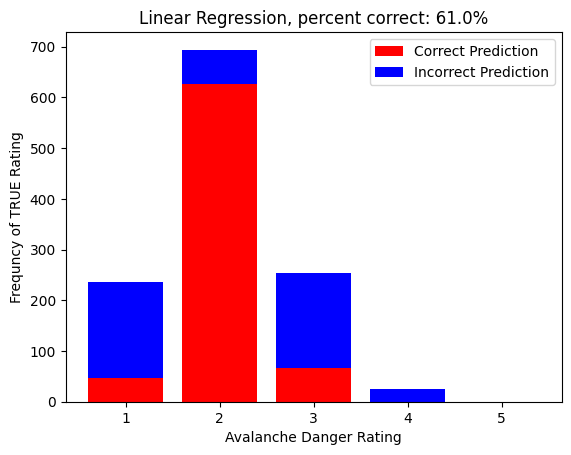

In [557]:
stackedBar(y_int, y_test, "Linear Regression")

## Perceptron

In [474]:
from sklearn.linear_model import Perceptron

In [558]:
p = Perceptron(random_state=15)
p.fit(X_train, y_train)

Perceptron(random_state=15)

In [573]:
y_pred = p.predict(X_test)

In [574]:
correctRatio(y_pred, y_test)

0.6100993377483444

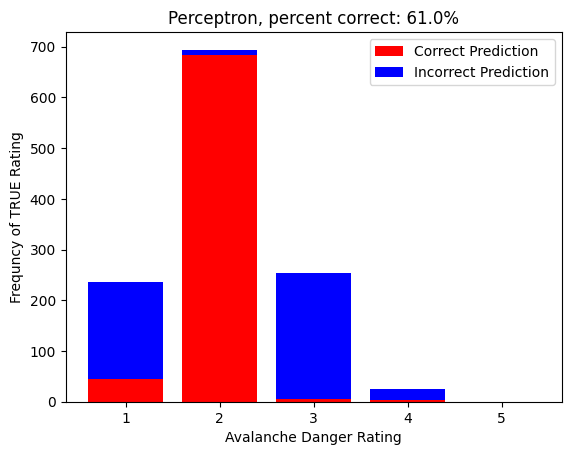

In [561]:
stackedBar(y_pred, y_test, "Perceptron")

## KNN

In [483]:
from sklearn.neighbors import KNeighborsClassifier

In [578]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)

KNeighborsClassifier()

In [579]:
y_pred = neigh.predict(X_test)

In [580]:
correctRatio(y_pred, y_test)

0.5910596026490066

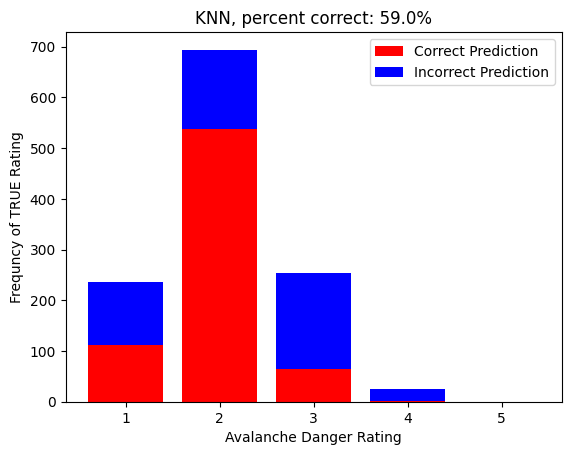

In [581]:
stackedBar(y_pred, y_test, "KNN")

## Multi Layer Perceptron

In [582]:
from sklearn.neural_network import MLPClassifier

In [614]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(9, 2, 2, 9), random_state=1)

In [615]:
clf.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(9, 2, 2, 9), random_state=1,
              solver='lbfgs')

In [616]:
y_pred = clf.predict(X_test)

In [617]:
correctRatio(y_pred, y_test)

0.5745033112582781

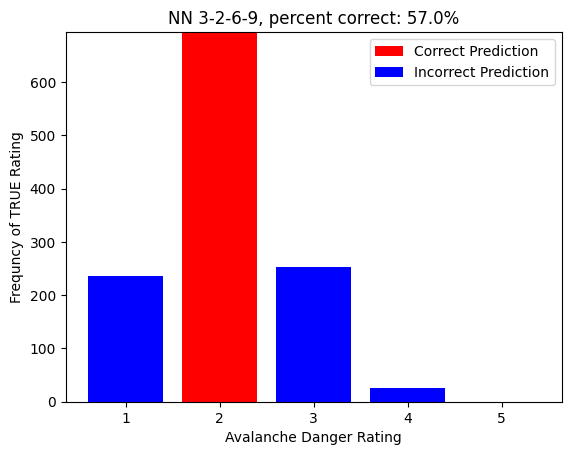

In [618]:
stackedBar(y_pred, y_test, "NN 3-2-6-9")

## Naive Bayes

In [506]:
from sklearn.naive_bayes import GaussianNB

In [569]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

In [570]:
correctRatio(y_pred, y_test)

0.32450331125827814

In [571]:
y_pred

array([1, 3, 1, ..., 4, 3, 1])

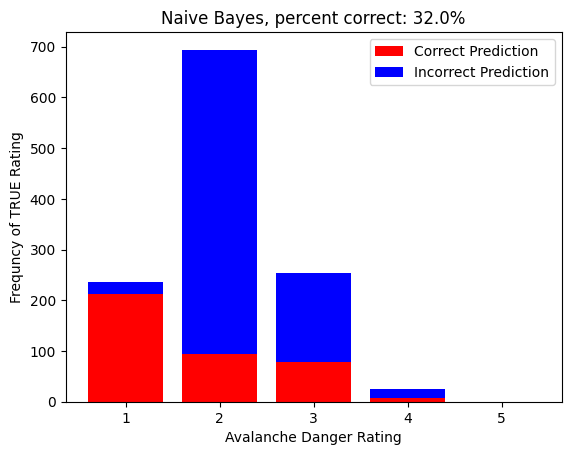

In [572]:
stackedBar(y_pred, y_test, "Naive Bayes")

## Tree

In [510]:
from sklearn import tree

In [619]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [620]:
y_pred = clf.predict(X_test)

In [320]:
correctRatio(y_pred, y_test)

0.5538079470198676

[Text(0.3064686798802048, 0.98, 'x[13] <= 14.455\ngini = 0.609\nsamples = 3622\nvalue = [743, 1975, 815, 89]'),
 Text(0.09763865774095953, 0.94, 'x[9] <= 0.006\ngini = 0.514\nsamples = 543\nvalue = [335, 174, 26, 8]'),
 Text(0.06817638019684055, 0.9, 'x[5] <= 6.972\ngini = 0.452\nsamples = 427\nvalue = [296, 110, 14, 7]'),
 Text(0.04706733095479899, 0.86, 'x[4] <= 67.149\ngini = 0.366\nsamples = 314\nvalue = [243, 58, 7, 6]'),
 Text(0.03441253569130807, 0.82, 'x[10] <= 0.08\ngini = 0.279\nsamples = 243\nvalue = [204, 30, 3, 6]'),
 Text(0.0293080804589756, 0.78, 'x[11] <= 0.875\ngini = 0.252\nsamples = 237\nvalue = [203, 28, 2, 4]'),
 Text(0.025905110304087285, 0.74, 'x[3] <= 21.328\ngini = 0.237\nsamples = 233\nvalue = [202, 25, 2, 4]'),
 Text(0.023182734180176634, 0.7, 'x[14] <= 0.224\ngini = 0.221\nsamples = 228\nvalue = [200, 22, 2, 4]'),
 Text(0.02182154611822131, 0.66, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1, 0]'),
 Text(0.02454392224213196, 0.66, 'x[2] <= 12.864\ngini = 0.214\

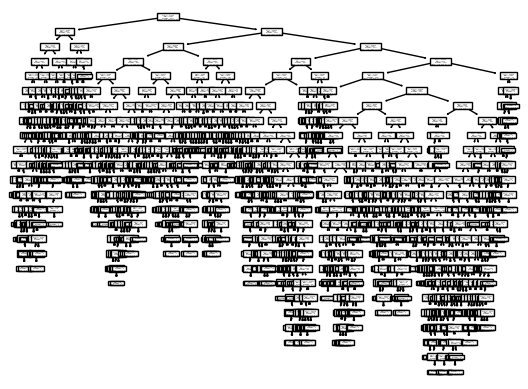

In [322]:
tree.plot_tree(clf)

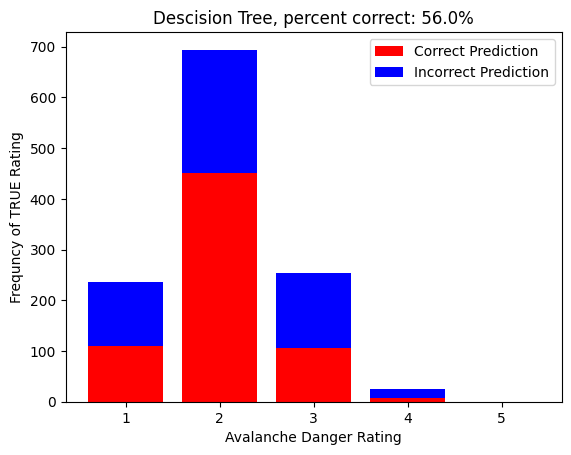

In [621]:
stackedBar(y_pred, y_test, "Descision Tree")

In [622]:
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
correctRatio(y_pred, y_test)

0.5811258278145696

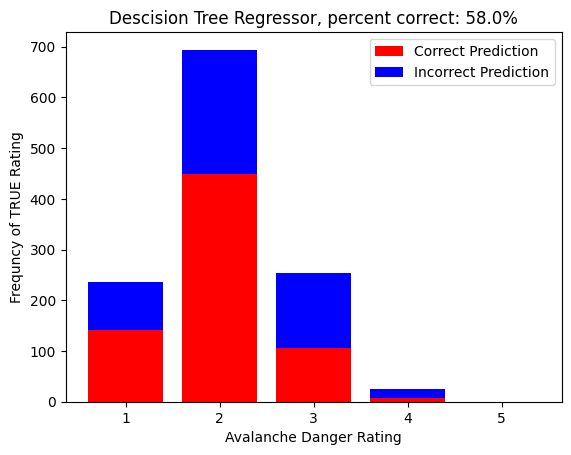

In [623]:
stackedBar(y_pred, y_test, "Descision Tree Regressor")

## Ensemble

### Random Forest

In [624]:
from sklearn.ensemble import RandomForestClassifier

In [688]:
clf = RandomForestClassifier(n_estimators=20)

In [689]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
correctRatio(y_pred, y_test)

0.6639072847682119

In [690]:
importances = clf.feature_importances_

In [692]:
importances

array([0.06694478, 0.10586418, 0.07373907, 0.07165486, 0.07896694,
       0.06911357, 0.07095839, 0.06887381, 0.04329707, 0.04922337,
       0.04894151, 0.02094199, 0.        , 0.11915128, 0.11232918])

In [710]:


features = ["Temperature","MaxTemp","MinTemp","DewPoint","RelativeHumidity","WindSpeed","WindDir","GustSpeed","Precip1hr","Precip24hr","PrecipAccumulated","Snow24","SnowWaterEquiv24hours","SnowHeight","SnowWaterEquiv"]
            

In [711]:
sorted_idx = np.argsort(importances)

In [712]:
importances[sorted_idx]

array([0.        , 0.02094199, 0.04329707, 0.04894151, 0.04922337,
       0.06694478, 0.06887381, 0.06911357, 0.07095839, 0.07165486,
       0.07373907, 0.07896694, 0.10586418, 0.11232918, 0.11915128])

In [713]:
featuresSorted = [features[x] for x in sorted_idx]

Text(0, 0.5, 'Feature')

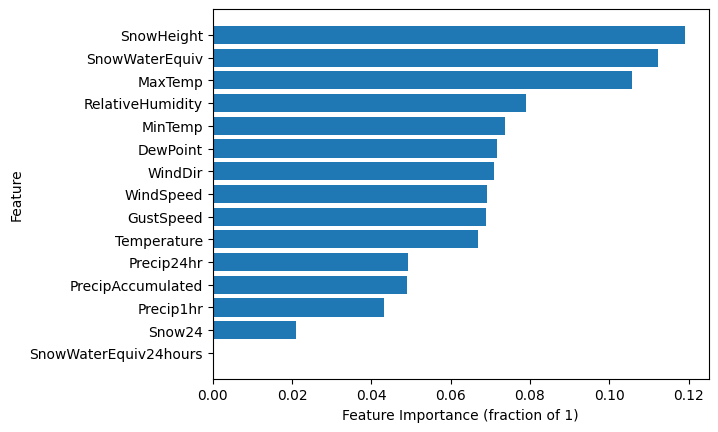

In [714]:

plt.barh(featuresSorted,importances[sorted_idx])
plt.xlabel("Feature Importance (fraction of 1)")
plt.ylabel("Feature")

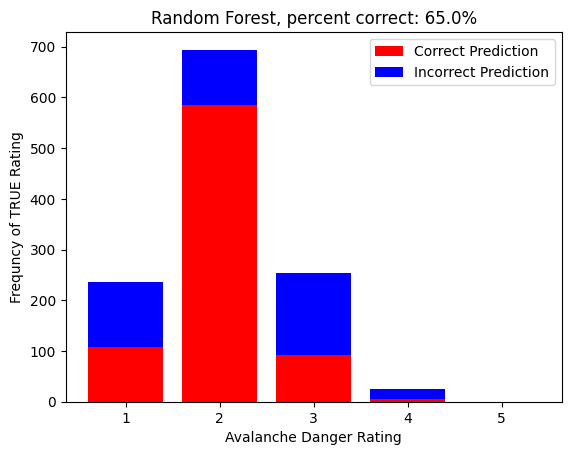

In [627]:
stackedBar(y_pred, y_test, "Random Forest")

### AdaBoost

In [628]:
from sklearn.ensemble import AdaBoostClassifier

In [629]:
clf = AdaBoostClassifier(n_estimators=50)

In [630]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
correctRatio(y_pred, y_test)

0.5587748344370861

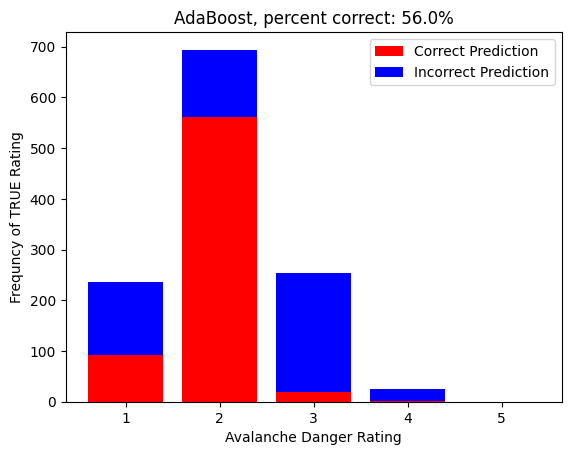

In [631]:
stackedBar(y_pred, y_test, "AdaBoost")

## LASSO

In [532]:
from sklearn import linear_model

In [575]:
clf = linear_model.Lasso(alpha=0.1)

In [576]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_int = [int(round(a, 0)) for a in y_pred]
correctRatio(y_int, y_test)

0.6225165562913907

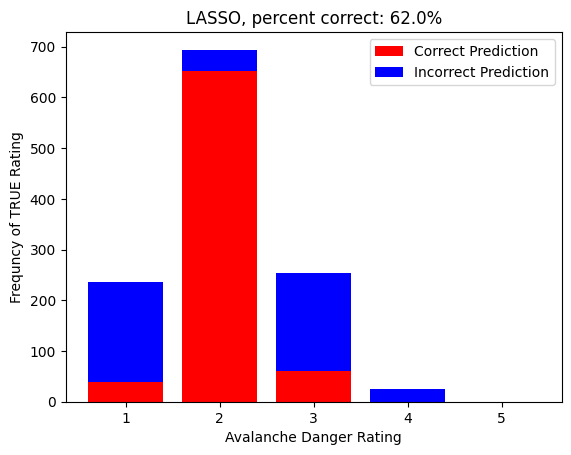

In [577]:
stackedBar(y_int, y_test, "LASSO")

## Other Plotting

In [354]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'Frequency')

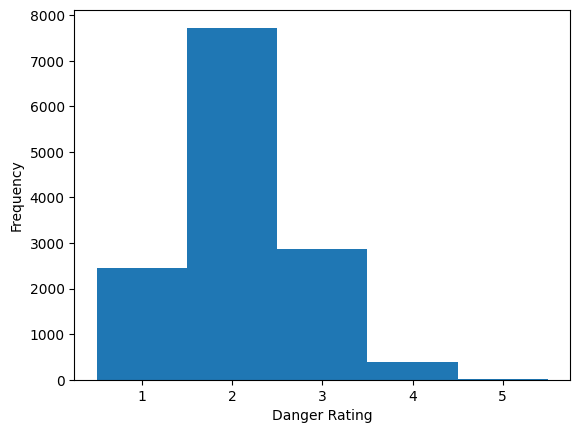

In [363]:
droppedLabels = []
for l in labels:
    if l != 0:
        droppedLabels.append(l)
plt.hist(droppedLabels, [0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
plt.xlabel("Danger Rating")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

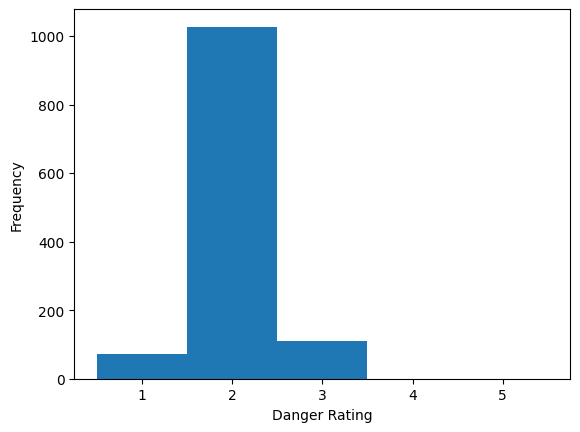

In [538]:
plt.hist(y_int, [0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
plt.xlabel("Danger Rating")
plt.ylabel("Frequency")

In [656]:
y_pred = [np.random.randint(1,6) for x in y_test]

In [657]:
correctRatio(y_pred, y_test)

0.1986754966887417

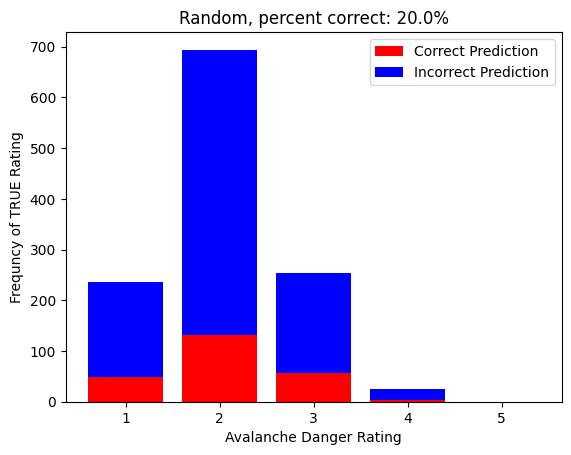

In [658]:
stackedBar(y_pred, y_test, "Random")